
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_1060060/1755373187.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


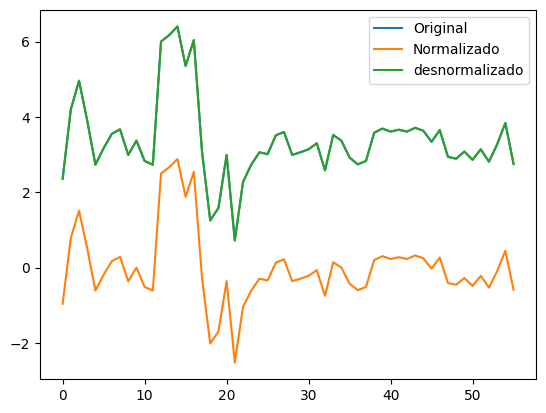

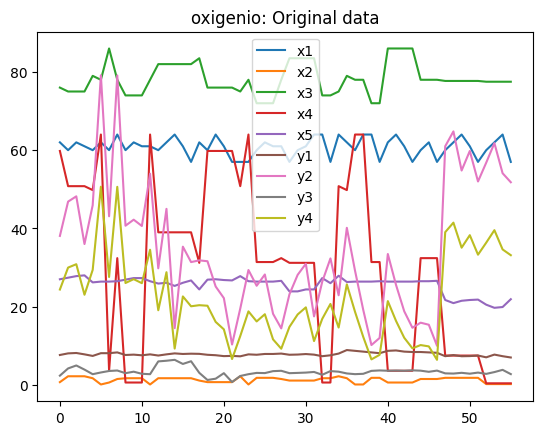

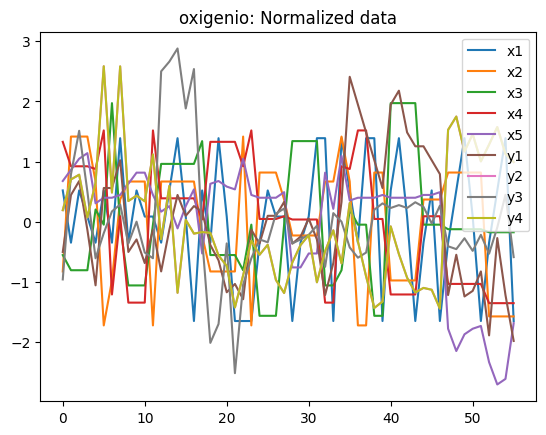

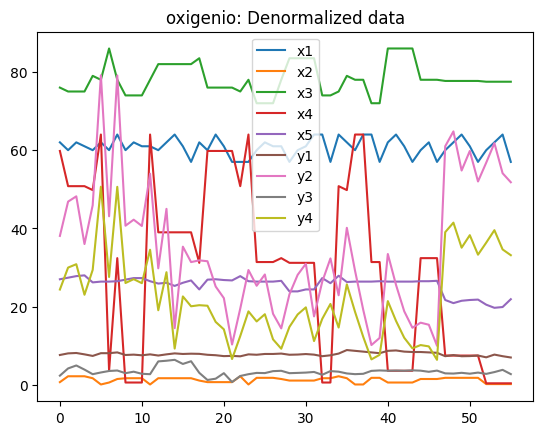

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y3"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y3")
test_out_scaler()
show_norm(label="oxigenio")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-05 17:54:19.512745: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 17:54:19.546890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 17:54:19.546928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 17:54:19.548145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 17:54:19.554058: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 17:54:19.554939: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-04-05 17:54:20.602442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[20,10], [20,5], [20,7], [25,15], [25,5], [25, 7], [25, 10], [35, 5], [35, 10], [35, 15], [35, 17]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.6158932250000362
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.4657067799998913
Stopped at epoch:  13
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++


Elapsed time:  0.23950198000056844
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.16229627299981075
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.16371417800019117
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.16402155200012203
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Elapsed time:  0.19766815200000565
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Elapsed time:  0.2395725369997308
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_0] | 9 ++++++++++++++++++
Elapsed time:  0.4212134319996039
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step


r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_1_0   0.815812  0.941788 -0.949308  0.738641  0.203842  0.069292   
model_1_1_1   0.828806  0.910508 -1.176213  0.688203  0.189461  0.106526   
model_1_1_2   0.839002  0.878872 -1.351126  0.643176  0.178177  0.144183   
model_1_1_3   0.847506  0.850140 -1.478574  0.605728  0.168766  0.178384   
model_1_1_4   0.854620  0.825536 -1.566813  0.575953  0.160893  0.207671   
model_1_1_5   0.860335  0.804237 -1.626638  0.551994  0.154568  0.233023   
model_1_1_6   0.864744  0.785255 -1.667657  0.531990  0.149689  0.255618   
model_1_1_23  0.867830  0.626125 -1.866309  0.380221  0.146273  0.445036   
model_1_1_7   0.868028  0.768018 -1.696752  0.514719  0.146054  0.276136   
model_1_1_22  0.868425  0.630148 -1.860479  0.384147  0.145615  0.440247   
model_1_1_21  0.869047  0.634588 -1.854180  0.388464  0.144927  0.434962   
model_1_1_20  0.869691  0.639485 -1.847403  0.393207  0.144214  0.429133   
model_1_1_19  0.870348  0.644881 -1.840130  0.398413  0.143486  0.422709   
model_1_1_8   0.870381  0.752226 -1.718489  0.499436  0.143450  0.294933   
model_1_1_18  0.871008  0.650824 -1.832354  0.404119  0.142756  0.415636   
model_1_1_17  0.871654  0.657359 -1.824068  0.410366  0.142041  0.407857   
model_1_1_9   0.871981  0.737712 -1.735740  0.485688  0.141679  0.312210   
model_1_1_16  0.872266  0.664539 -1.815282  0.417195  0.141364  0.399311   
model_1_1_15  0.872815  0.672418 -1.805984  0.424651  0.140757  0.389932   
model_1_1_10  0.872981  0.724362 -1.750267  0.473190  0.140573  0.328102   
model_1_1_14  0.873265  0.681053 -1.796177  0.432780  0.140258  0.379653   
model_1_1_11  0.873511  0.712091 -1.763105  0.461759  0.139987  0.342708   
model_1_1_13  0.873572  0.690502 -1.785823  0.441633  0.139918  0.368405   
model_1_1_12  0.873678  0.700827 -1.774854  0.451270  0.139801  0.356115   

               mse_val    mse_vt  
model_1_1_0   0.350531  0.201640  
model_1_1_1   0.391334  0.240553  
model_1_1_2   0.422788  0.275291  
model_1_1_3   0.445706  0.304182  
model_1_1_4   0.461573  0.327154  
model_1_1_5   0.472331  0.345639  
model_1_1_6   0.479707  0.361072  
model_1_1_23  0.515430  0.478162  
model_1_1_7   0.484939  0.374396  
model_1_1_22  0.514381  0.475134  
model_1_1_21  0.513248  0.471803  
model_1_1_20  0.512030  0.468143  
model_1_1_19  0.510722  0.464127  
model_1_1_8   0.488848  0.386187  
model_1_1_18  0.509324  0.459725  
model_1_1_17  0.507834  0.454905  
model_1_1_9   0.491950  0.396794  
model_1_1_16  0.506254  0.449637  
model_1_1_15  0.504582  0.443885  
model_1_1_10  0.494563  0.406436  
model_1_1_14  0.502818  0.437613  
model_1_1_11  0.496871  0.415255  
model_1_1_13  0.500956  0.430782  
model_1_1_12  0.498984  0.423348

DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Elapsed time:  0.1868451569998797
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Elapsed time:  0.18484652999995888
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Elapsed time:  0.20679759199992986
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Elapsed time:  0.1767283609997321
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Elapsed time:  0.20787512700007937
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Elapsed time:  0.16702386700035277
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Elapsed time:  0.18982372

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_2_17  0.803061 -0.031733 -0.649767 -0.390168  0.217953  0.416384   
model_1_2_16  0.807076 -0.013288 -0.607718 -0.358019  0.213509  0.408941   
model_1_2_15  0.811584  0.007258 -0.559717 -0.321532  0.208521  0.400649   
model_1_2_14  0.816648  0.030131 -0.504796 -0.280050  0.202916  0.391418   
model_1_2_13  0.822340  0.055552 -0.441833 -0.232830  0.196617  0.381158   
model_1_2_12  0.828734  0.083746 -0.369556 -0.179037  0.189540  0.369780   
model_1_2_11  0.835906  0.114923 -0.286562 -0.117769  0.181603  0.357198   
model_1_2_10  0.843919  0.149247 -0.191410 -0.048118  0.172735  0.343345   
model_1_2_9   0.852805  0.186805 -0.082804  0.030702  0.162901  0.328188   
model_1_2_8   0.862527  0.227530  0.040019  0.119110  0.152142  0.311752   
model_1_2_7   0.872921  0.271128  0.176700  0.216773  0.140639  0.294157   
model_1_2_6   0.883607  0.316952  0.324779  0.321990  0.128813  0.275663   
model_1_2_0   0.890477  0.485057  0.943397  0.751793  0.121209  0.207820   
model_1_2_5   0.893879  0.363850  0.478498  0.430934  0.117445  0.256736   
model_1_2_4   0.902617  0.409993  0.627950  0.537083  0.107774  0.238114   
model_1_2_1   0.903766  0.502130  0.921535  0.746227  0.106503  0.200929   
model_1_2_3   0.908306  0.452436  0.759725  0.631411  0.101479  0.220985   
model_1_2_2   0.909230  0.486159  0.860349  0.703990  0.100456  0.207375   

               mse_val    mse_vt  
model_1_2_17  1.041085  0.710361  
model_1_2_16  1.014551  0.693934  
model_1_2_15  0.984260  0.675289  
model_1_2_14  0.949601  0.654092  
model_1_2_13  0.909869  0.629963  
model_1_2_12  0.864259  0.602476  
model_1_2_11  0.811885  0.571168  
model_1_2_10  0.751839  0.535577  
model_1_2_9   0.683304  0.495301  
model_1_2_8   0.605796  0.450125  
model_1_2_7   0.519543  0.400221  
model_1_2_6   0.426098  0.346456  
model_1_2_0   0.035719  0.126831  
model_1_2_5   0.329094  0.290787  
model_1_2_4   0.234782  0.236546  
model_1_2_1   0.049515  0.129676  
model_1_2_3   0.151625  0.188345  
model_1_2_2   0.088127  0.151258

DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Elapsed time:  0.3034540319995358
Stopped at epoch:  10
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Elapsed time:  0.29550147899954027
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Elapsed time:  0.17224104000069929
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Elapsed time:  0.1615272310000364
Stopped at epoch:  6
1/1 [==============================] - 0s 76ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Elapsed time:  0.2954163329995936
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Elapsed time:  0.22390859100050875
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Elapsed time:  0.22306126

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_3_0   0.878156  0.679437  0.885962  0.749180  0.134846  0.325645   
model_1_3_1   0.882919  0.625886  0.887072  0.714077  0.129575  0.380046   
model_1_3_2   0.886450  0.581484  0.886004  0.684301  0.125666  0.425151   
model_1_3_3   0.889148  0.545260  0.883632  0.659503  0.122681  0.461949   
model_1_3_24  0.890004  0.355074  0.807711  0.507909  0.121733  0.655151   
model_1_3_23  0.890323  0.356926  0.809630  0.509782  0.121380  0.653270   
model_1_3_22  0.890665  0.358995  0.811728  0.511861  0.121002  0.651168   
model_1_3_21  0.891028  0.361310  0.814019  0.514167  0.120600  0.648816   
model_1_3_4   0.891201  0.515712  0.880409  0.638841  0.120409  0.491966   
model_1_3_20  0.891413  0.363904  0.816513  0.516726  0.120174  0.646181   
model_1_3_19  0.891817  0.366811  0.819222  0.519565  0.119727  0.643227   
model_1_3_18  0.892237  0.370077  0.822155  0.522718  0.119262  0.639910   
model_1_3_17  0.892668  0.373750  0.825321  0.526219  0.118785  0.636179   
model_1_3_5   0.892723  0.491440  0.876594  0.621475  0.118724  0.516623   
model_1_3_16  0.893104  0.377889  0.828723  0.530108  0.118303  0.631974   
model_1_3_15  0.893535  0.382565  0.832364  0.534433  0.117825  0.627224   
model_1_3_6   0.893802  0.471311  0.872362  0.606713  0.117530  0.537071   
model_1_3_14  0.893951  0.387858  0.836238  0.539246  0.117365  0.621847   
model_1_3_13  0.894336  0.393873  0.840336  0.544612  0.116938  0.615737   
model_1_3_7   0.894513  0.454450  0.867852  0.594021  0.116744  0.554200   
model_1_3_12  0.894671  0.400726  0.844639  0.550603  0.116568  0.608775   
model_1_3_8   0.894925  0.440193  0.863182  0.583002  0.116288  0.568682   
model_1_3_11  0.894930  0.408572  0.849121  0.557313  0.116281  0.600804   
model_1_3_10  0.895085  0.417598  0.853742  0.564850  0.116110  0.591636   
model_1_3_9   0.895098  0.428039  0.858452  0.573355  0.116096  0.581029   

               mse_val    mse_vt  
model_1_3_0   0.066327  0.203613  
model_1_3_1   0.065681  0.232109  
model_1_3_2   0.066302  0.256281  
model_1_3_3   0.067682  0.276412  
model_1_3_24  0.111839  0.399475  
model_1_3_23  0.110723  0.397954  
model_1_3_22  0.109502  0.396266  
model_1_3_21  0.108170  0.394394  
model_1_3_4   0.069556  0.293185  
model_1_3_20  0.106720  0.392317  
model_1_3_19  0.105144  0.390012  
model_1_3_18  0.103438  0.387453  
model_1_3_17  0.101597  0.384611  
model_1_3_5   0.071775  0.307283  
model_1_3_16  0.099618  0.381453  
model_1_3_15  0.097500  0.377942  
model_1_3_6   0.074237  0.319266  
model_1_3_14  0.095247  0.374035  
model_1_3_13  0.092864  0.369679  
model_1_3_7   0.076860  0.329569  
model_1_3_12  0.090361  0.364816  
model_1_3_8   0.079576  0.338515  
model_1_3_11  0.087754  0.359369  
model_1_3_10  0.085067  0.353250  
model_1_3_9   0.082327  0.346346

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Elapsed time:  0.26749036100045487
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Elapsed time:  0.19550527800038253
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Elapsed time:  0.23476997000034316
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Elapsed time:  0.25684636300047714
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Elapsed time:  0.3318775919997279
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Elapsed time:  0.3775749350006663
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Elapsed time:  0.27943465

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_4_0   0.905232  0.788235  0.997997  0.901415  0.104880  0.263548   
model_1_4_1   0.917177  0.795290  0.997926  0.904625  0.091661  0.254769   
model_1_4_2   0.926522  0.800233  0.997004  0.906404  0.081319  0.248617   
model_1_4_3   0.933812  0.803462  0.995608  0.907138  0.073251  0.244598   
model_1_4_4   0.939484  0.805345  0.994011  0.907144  0.066973  0.242254   
model_1_4_5   0.943888  0.806214  0.992386  0.906668  0.062099  0.241173   
model_1_4_6   0.947301  0.806359  0.990828  0.905895  0.058323  0.240993   
model_1_4_7   0.949939  0.806013  0.989377  0.904953  0.055403  0.241423   
model_1_4_8   0.951971  0.805355  0.988043  0.903931  0.053154  0.242242   
model_1_4_9   0.953529  0.804514  0.986821  0.902885  0.051430  0.243289   
model_1_4_10  0.954716  0.803578  0.985703  0.901851  0.050116  0.244454   
model_1_4_11  0.955612  0.802607  0.984678  0.900851  0.049124  0.245663   
model_1_4_12  0.956281  0.801640  0.983736  0.899899  0.048384  0.246865   
model_1_4_13  0.956773  0.800703  0.982872  0.899001  0.047840  0.248031   
model_1_4_14  0.957126  0.799810  0.982078  0.898162  0.047449  0.249143   
model_1_4_15  0.957372  0.798967  0.981349  0.897381  0.047177  0.250192   
model_1_4_24  0.957520  0.793766  0.977053  0.892670  0.047013  0.256666   
model_1_4_16  0.957536  0.798181  0.980681  0.896658  0.046996  0.251171   
model_1_4_23  0.957576  0.794160  0.977371  0.893023  0.046951  0.256175   
model_1_4_22  0.957626  0.794593  0.977722  0.893411  0.046895  0.255636   
model_1_4_17  0.957636  0.797451  0.980069  0.895992  0.046884  0.252079   
model_1_4_21  0.957668  0.795068  0.978108  0.893838  0.046849  0.255045   
model_1_4_18  0.957689  0.796777  0.979509  0.895380  0.046826  0.252918   
model_1_4_20  0.957696  0.795588  0.978532  0.894306  0.046818  0.254398   
model_1_4_19  0.957706  0.796157  0.978998  0.894819  0.046807  0.253690   

               mse_val    mse_vt  
model_1_4_0   0.003283  0.141071  
model_1_4_1   0.003399  0.136477  
model_1_4_2   0.004911  0.133932  
model_1_4_3   0.007200  0.132881  
model_1_4_4   0.009818  0.132873  
model_1_4_5   0.012482  0.133554  
model_1_4_6   0.015037  0.134661  
model_1_4_7   0.017416  0.136008  
model_1_4_8   0.019604  0.137471  
model_1_4_9   0.021606  0.138968  
model_1_4_10  0.023440  0.140447  
model_1_4_11  0.025120  0.141878  
model_1_4_12  0.026663  0.143241  
model_1_4_13  0.028081  0.144525  
model_1_4_14  0.029382  0.145726  
model_1_4_15  0.030577  0.146844  
model_1_4_24  0.037620  0.153585  
model_1_4_16  0.031672  0.147878  
model_1_4_23  0.037098  0.153080  
model_1_4_22  0.036523  0.152524  
model_1_4_17  0.032676  0.148831  
model_1_4_21  0.035891  0.151913  
model_1_4_18  0.033593  0.149706  
model_1_4_20  0.035195  0.151244  
model_1_4_19  0.034431  0.150509

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Elapsed time:  0.23506818100031523
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Elapsed time:  0.20935564299998077
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Elapsed time:  0.23317385999962426
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Elapsed time:  0.28366758599986497
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Elapsed time:  0.3177471600001809
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Elapsed time:  0.31737970799986215
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Elapsed time:  0.3526774

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_5_24  0.957164  0.863161  0.812241  0.848066  0.047407  0.185486   
model_1_5_23  0.957400  0.863055  0.815466  0.848958  0.047145  0.185631   
model_1_5_22  0.957658  0.862936  0.819019  0.849940  0.046860  0.185791   
model_1_5_21  0.957939  0.862804  0.822928  0.851018  0.046549  0.185971   
model_1_5_20  0.958244  0.862656  0.827224  0.852202  0.046212  0.186171   
model_1_5_19  0.958575  0.862492  0.831939  0.853500  0.045846  0.186394   
model_1_5_18  0.958931  0.862308  0.837104  0.854919  0.045451  0.186643   
model_1_5_17  0.959314  0.862105  0.842749  0.856468  0.045027  0.186919   
model_1_5_16  0.959723  0.861878  0.848904  0.858153  0.044575  0.187226   
model_1_5_0   0.959973  0.854850  0.985352  0.894118  0.044298  0.196753   
model_1_5_15  0.960157  0.861625  0.855597  0.859982  0.044095  0.187568   
model_1_5_14  0.960613  0.861347  0.862846  0.861959  0.043590  0.187946   
model_1_5_13  0.961088  0.861038  0.870669  0.864087  0.043064  0.188365   
model_1_5_12  0.961577  0.860698  0.879067  0.866365  0.042523  0.188825   
model_1_5_1   0.961726  0.855207  0.982080  0.893388  0.042358  0.196269   
model_1_5_11  0.962071  0.860325  0.888029  0.868789  0.041977  0.189331   
model_1_5_10  0.962558  0.859917  0.897524  0.871349  0.041438  0.189884   
model_1_5_2   0.962913  0.855688  0.976275  0.891985  0.041044  0.195617   
model_1_5_9   0.963023  0.859475  0.907490  0.874025  0.040923  0.190484   
model_1_5_8   0.963445  0.858997  0.917838  0.876792  0.040456  0.191130   
model_1_5_3   0.963649  0.856234  0.968567  0.890058  0.040229  0.194877   
model_1_5_7   0.963796  0.858487  0.928430  0.879608  0.040067  0.191822   
model_1_5_4   0.964031  0.856808  0.959500  0.887743  0.039807  0.194098   
model_1_5_6   0.964043  0.857947  0.939080  0.882422  0.039794  0.192554   
model_1_5_5   0.964139  0.857384  0.949542  0.885162  0.039687  0.193317   

               mse_val    mse_vt  
model_1_5_24  0.122681  0.155931  
model_1_5_23  0.120574  0.155016  
model_1_5_22  0.118253  0.154009  
model_1_5_21  0.115699  0.152902  
model_1_5_20  0.112891  0.151686  
model_1_5_19  0.109811  0.150355  
model_1_5_18  0.106436  0.148898  
model_1_5_17  0.102747  0.147309  
model_1_5_16  0.098726  0.145579  
model_1_5_0   0.009571  0.108667  
model_1_5_15  0.094353  0.143702  
model_1_5_14  0.089616  0.141673  
model_1_5_13  0.084505  0.139489  
model_1_5_12  0.079017  0.137151  
model_1_5_1   0.011709  0.109417  
model_1_5_11  0.073161  0.134663  
model_1_5_10  0.066958  0.132036  
model_1_5_2   0.015502  0.110857  
model_1_5_9   0.060446  0.129289  
model_1_5_8   0.053685  0.126450  
model_1_5_3   0.020538  0.112835  
model_1_5_7   0.046764  0.123560  
model_1_5_4   0.026462  0.115211  
model_1_5_6   0.039805  0.120672  
model_1_5_5   0.032969  0.117859

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.2768205360007414
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.2598783369994635
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.2180477570000221
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.26234368400037056
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.37774213400007284
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.388323150999895
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.38361694599

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_6_0   0.964927  0.981901  0.997645  0.990589  0.038815  0.018799   
model_1_6_1   0.970959  0.981668  0.997509  0.990425  0.032140  0.019041   
model_1_6_2   0.975618  0.980550  0.996741  0.989591  0.026984  0.020202   
model_1_6_3   0.979192  0.978875  0.995484  0.988298  0.023028  0.021943   
model_1_6_4   0.981914  0.976894  0.993857  0.986712  0.020016  0.024000   
model_1_6_5   0.983968  0.974800  0.991961  0.984963  0.017742  0.026175   
model_1_6_6   0.985505  0.972729  0.989878  0.983150  0.016042  0.028326   
model_1_6_7   0.986641  0.970775  0.987680  0.981345  0.014785  0.030356   
model_1_6_8   0.987469  0.968993  0.985425  0.979597  0.013868  0.032207   
model_1_6_9   0.988062  0.967410  0.983161  0.977938  0.013212  0.033851   
model_1_6_24  0.988378  0.959273  0.959779  0.964641  0.012862  0.042303   
model_1_6_23  0.988462  0.959399  0.960641  0.965050  0.012769  0.042172   
model_1_6_10  0.988475  0.966031  0.980925  0.976385  0.012755  0.035283   
model_1_6_22  0.988549  0.959546  0.961585  0.965502  0.012673  0.042019   
model_1_6_21  0.988638  0.959720  0.962617  0.966002  0.012575  0.041839   
model_1_6_20  0.988726  0.959924  0.963743  0.966555  0.012477  0.041627   
model_1_6_11  0.988752  0.964849  0.978747  0.974948  0.012449  0.036512   
model_1_6_19  0.988812  0.960166  0.964969  0.967166  0.012382  0.041375   
model_1_6_18  0.988893  0.960455  0.966300  0.967841  0.012292  0.041076   
model_1_6_12  0.988925  0.963846  0.976649  0.973628  0.012257  0.037554   
model_1_6_17  0.988964  0.960799  0.967741  0.968587  0.012214  0.040718   
model_1_6_16  0.989021  0.961210  0.969295  0.969410  0.012151  0.040291   
model_1_6_13  0.989021  0.963001  0.974646  0.972420  0.012150  0.038431   
model_1_6_15  0.989055  0.961703  0.970965  0.970318  0.012112  0.039779   
model_1_6_14  0.989059  0.962294  0.972749  0.971319  0.012108  0.039166   

               mse_val    mse_vt  
model_1_6_0   0.002392  0.011078  
model_1_6_1   0.002531  0.011272  
model_1_6_2   0.003311  0.012253  
model_1_6_3   0.004587  0.013775  
model_1_6_4   0.006240  0.015642  
model_1_6_5   0.008167  0.017701  
model_1_6_6   0.010283  0.019835  
model_1_6_7   0.012515  0.021960  
model_1_6_8   0.014806  0.024018  
model_1_6_9   0.017106  0.025971  
model_1_6_24  0.040858  0.041623  
model_1_6_23  0.039983  0.041142  
model_1_6_10  0.019377  0.027798  
model_1_6_22  0.039024  0.040610  
model_1_6_21  0.037976  0.040021  
model_1_6_20  0.036832  0.039370  
model_1_6_11  0.021590  0.029490  
model_1_6_19  0.035586  0.038651  
model_1_6_18  0.034234  0.037856  
model_1_6_12  0.023721  0.031044  
model_1_6_17  0.032770  0.036978  
model_1_6_16  0.031191  0.036009  
model_1_6_13  0.025756  0.032466  
model_1_6_15  0.029496  0.034940  
model_1_6_14  0.027683  0.033762

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.23127384200051893
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.2010392940001111
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.32886270099970716
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.2623818049996771
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.34556083799998305
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.3943789730001299
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.238975809

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_7_24  0.973528  0.948999  0.899542  0.930848  0.029296  0.078884   
model_1_7_23  0.973951  0.950120  0.900751  0.931978  0.028829  0.077151   
model_1_7_22  0.974414  0.951348  0.902084  0.933220  0.028316  0.075251   
model_1_7_21  0.974920  0.952690  0.903553  0.934581  0.027756  0.073176   
model_1_7_20  0.975472  0.954153  0.905169  0.936071  0.027145  0.070912   
model_1_7_19  0.976072  0.955743  0.906942  0.937697  0.026481  0.068454   
model_1_7_18  0.976722  0.957465  0.908885  0.939466  0.025762  0.065791   
model_1_7_17  0.977422  0.959320  0.911009  0.941385  0.024987  0.062921   
model_1_7_16  0.978174  0.961311  0.913325  0.943459  0.024155  0.059841   
model_1_7_15  0.978976  0.963435  0.915843  0.945688  0.023267  0.056557   
model_1_7_14  0.979825  0.965681  0.918566  0.948071  0.022328  0.053082   
model_1_7_13  0.980717  0.968042  0.921505  0.950604  0.021341  0.049431   
model_1_7_12  0.981644  0.970497  0.924661  0.953278  0.020314  0.045633   
model_1_7_11  0.982599  0.973026  0.928038  0.956081  0.019258  0.041722   
model_1_7_10  0.983570  0.975600  0.931638  0.958998  0.018183  0.037740   
model_1_7_9   0.984543  0.978186  0.935459  0.962008  0.017107  0.033741   
model_1_7_8   0.985500  0.980745  0.939500  0.965088  0.016047  0.029783   
model_1_7_7   0.986424  0.983236  0.943762  0.968214  0.015024  0.025929   
model_1_7_6   0.987291  0.985614  0.948240  0.971358  0.014065  0.022251   
model_1_7_5   0.988074  0.987830  0.952931  0.974490  0.013198  0.018824   
model_1_7_4   0.988742  0.989829  0.957823  0.977573  0.012460  0.015732   
model_1_7_0   0.989224  0.994235  0.978461  0.988211  0.011926  0.008917   
model_1_7_3   0.989251  0.991549  0.962892  0.980561  0.011895  0.013071   
model_1_7_2   0.989552  0.992919  0.968090  0.983393  0.011563  0.010953   
model_1_7_1   0.989573  0.993850  0.973329  0.985983  0.011539  0.009513   

               mse_val    mse_vt  
model_1_7_24  0.116022  0.096361  
model_1_7_23  0.114625  0.094786  
model_1_7_22  0.113085  0.093055  
model_1_7_21  0.111389  0.091159  
model_1_7_20  0.109523  0.089082  
model_1_7_19  0.107475  0.086817  
model_1_7_18  0.105231  0.084351  
model_1_7_17  0.102777  0.081677  
model_1_7_16  0.100103  0.078788  
model_1_7_15  0.097195  0.075681  
model_1_7_14  0.094050  0.072361  
model_1_7_13  0.090656  0.068831  
model_1_7_12  0.087010  0.065105  
model_1_7_11  0.083111  0.061199  
model_1_7_10  0.078953  0.057135  
model_1_7_9   0.074540  0.052940  
model_1_7_8   0.069873  0.048649  
model_1_7_7   0.064951  0.044292  
model_1_7_6   0.059779  0.039911  
model_1_7_5   0.054361  0.035548  
model_1_7_4   0.048711  0.031252  
model_1_7_0   0.024876  0.016427  
model_1_7_3   0.042857  0.027088  
model_1_7_2   0.036853  0.023141  
model_1_7_1   0.030803  0.019532

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  0.31959568000002037
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.43307197299964173
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.33451672099999996
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.46261936200062337
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.3172313959994426
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.2794817169997259
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.27115066

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_8_0   0.978206  0.991849  0.993909  0.993352  0.024120  0.009947   
model_1_8_1   0.981804  0.991150  0.994134  0.993131  0.020138  0.010800   
model_1_8_2   0.984552  0.990125  0.993875  0.992531  0.017096  0.012051   
model_1_8_3   0.986631  0.988892  0.993262  0.991669  0.014796  0.013556   
model_1_8_4   0.988183  0.987534  0.992402  0.990634  0.013078  0.015213   
model_1_8_5   0.989323  0.986114  0.991375  0.989492  0.011816  0.016946   
model_1_8_24  0.989884  0.968455  0.975185  0.973688  0.011196  0.038497   
model_1_8_23  0.990000  0.968867  0.975588  0.974069  0.011067  0.037994   
model_1_8_22  0.990124  0.969320  0.976032  0.974487  0.010930  0.037441   
model_1_8_6   0.990141  0.984675  0.990246  0.988293  0.010911  0.018702   
model_1_8_21  0.990255  0.969818  0.976518  0.974947  0.010785  0.036833   
model_1_8_20  0.990393  0.970364  0.977051  0.975451  0.010633  0.036166   
model_1_8_19  0.990536  0.970962  0.977634  0.976002  0.010474  0.035436   
model_1_8_18  0.990683  0.971616  0.978270  0.976604  0.010311  0.034638   
model_1_8_7   0.990709  0.983250  0.989064  0.987075  0.010282  0.020441   
model_1_8_17  0.990831  0.972330  0.978962  0.977261  0.010147  0.033768   
model_1_8_16  0.990977  0.973106  0.979713  0.977974  0.009985  0.032820   
model_1_8_8   0.991084  0.981861  0.987864  0.985867  0.009867  0.022136   
model_1_8_15  0.991117  0.973950  0.980526  0.978748  0.009831  0.031790   
model_1_8_14  0.991244  0.974864  0.981401  0.979583  0.009690  0.030675   
model_1_8_9   0.991311  0.980523  0.986675  0.984687  0.009616  0.023768   
model_1_8_13  0.991351  0.975849  0.982340  0.980481  0.009572  0.029473   
model_1_8_10  0.991426  0.979248  0.985517  0.983551  0.009489  0.025325   
model_1_8_12  0.991426  0.976909  0.983342  0.981443  0.009489  0.028180   
model_1_8_11  0.991457  0.978042  0.984402  0.982468  0.009455  0.026796   

               mse_val    mse_vt  
model_1_8_0   0.008374  0.009207  
model_1_8_1   0.008065  0.009513  
model_1_8_2   0.008422  0.010343  
model_1_8_3   0.009264  0.011536  
model_1_8_4   0.010447  0.012970  
model_1_8_5   0.011859  0.014552  
model_1_8_24  0.034120  0.036437  
model_1_8_23  0.033565  0.035910  
model_1_8_22  0.032955  0.035330  
model_1_8_6   0.013411  0.016212  
model_1_8_21  0.032286  0.034693  
model_1_8_20  0.031553  0.033996  
model_1_8_19  0.030752  0.033232  
model_1_8_18  0.029878  0.032398  
model_1_8_7   0.015037  0.017898  
model_1_8_17  0.028926  0.031489  
model_1_8_16  0.027893  0.030501  
model_1_8_8   0.016686  0.019571  
model_1_8_15  0.026776  0.029430  
model_1_8_14  0.025572  0.028274  
model_1_8_9   0.018321  0.021205  
model_1_8_13  0.024281  0.027029  
model_1_8_10  0.019914  0.022778  
model_1_8_12  0.022904  0.025697  
model_1_8_11  0.021446  0.024279

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.20762866400036728
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.37031374700018205
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.41042866699990554
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.39733520499976294
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.2144102689999272
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.25438111499988736
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.2655536

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_9_0   0.991583  0.992220  0.997071  0.994067  0.009315  0.011693   
model_1_9_1   0.992870  0.992782  0.996738  0.994291  0.007891  0.010848   
model_1_9_2   0.993829  0.993124  0.996036  0.994241  0.006830  0.010334   
model_1_9_24  0.994107  0.989993  0.972113  0.983332  0.006522  0.015040   
model_1_9_23  0.994192  0.990096  0.972654  0.983598  0.006428  0.014885   
model_1_9_22  0.994282  0.990208  0.973246  0.983890  0.006328  0.014715   
model_1_9_21  0.994380  0.990331  0.973893  0.984209  0.006220  0.014531   
model_1_9_20  0.994484  0.990465  0.974598  0.984556  0.006104  0.014330   
model_1_9_3   0.994529  0.993298  0.995059  0.993983  0.006055  0.010072   
model_1_9_19  0.994595  0.990609  0.975366  0.984933  0.005982  0.014113   
model_1_9_18  0.994711  0.990766  0.976198  0.985342  0.005853  0.013878   
model_1_9_17  0.994833  0.990934  0.977098  0.985784  0.005718  0.013625   
model_1_9_16  0.994959  0.991114  0.978069  0.986260  0.005579  0.013355   
model_1_9_4   0.995024  0.993346  0.993882  0.993572  0.005507  0.010000   
model_1_9_15  0.995087  0.991305  0.979112  0.986770  0.005437  0.013067   
model_1_9_14  0.995215  0.991508  0.980227  0.987313  0.005295  0.012762   
model_1_9_13  0.995341  0.991720  0.981414  0.987890  0.005157  0.012443   
model_1_9_5   0.995358  0.993300  0.992567  0.993051  0.005137  0.010069   
model_1_9_12  0.995458  0.991941  0.982671  0.988498  0.005026  0.012112   
model_1_9_11  0.995563  0.992167  0.983992  0.989134  0.004910  0.011772   
model_1_9_6   0.995567  0.993187  0.991163  0.992454  0.004906  0.010240   
model_1_9_10  0.995649  0.992394  0.985369  0.989791  0.004816  0.011430   
model_1_9_7   0.995681  0.993025  0.989712  0.991810  0.004780  0.010482   
model_1_9_9   0.995705  0.992618  0.986793  0.990464  0.004754  0.011094   
model_1_9_8   0.995720  0.992832  0.988247  0.991141  0.004737  0.010773   

               mse_val    mse_vt  
model_1_9_0   0.002985  0.007595  
model_1_9_1   0.003325  0.007308  
model_1_9_2   0.004040  0.007372  
model_1_9_24  0.028420  0.021336  
model_1_9_23  0.027869  0.020995  
model_1_9_22  0.027265  0.020621  
model_1_9_21  0.026606  0.020213  
model_1_9_20  0.025887  0.019769  
model_1_9_3   0.005035  0.007702  
model_1_9_19  0.025105  0.019286  
model_1_9_18  0.024257  0.018762  
model_1_9_17  0.023340  0.018197  
model_1_9_16  0.022350  0.017588  
model_1_9_4   0.006235  0.008228  
model_1_9_15  0.021288  0.016936  
model_1_9_14  0.020151  0.016239  
model_1_9_13  0.018941  0.015501  
model_1_9_5   0.007576  0.008896  
model_1_9_12  0.017660  0.014723  
model_1_9_11  0.016314  0.013910  
model_1_9_6   0.009006  0.009659  
model_1_9_10  0.014910  0.013068  
model_1_9_7   0.010485  0.010483  
model_1_9_9   0.013460  0.012207  
model_1_9_8   0.011978  0.011340

DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.9667035489992486
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.4428859690005993
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.25840102799975284
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.22492388099999516
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.2627204840000559
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.3085133649992713
Stopped at epoch:  6
1/1 [==============================] - 0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_1_0   0.824583  0.923971  0.826723  0.875524  0.194135  0.103371   
model_2_1_1   0.848607  0.925134  0.826358  0.875909  0.167548  0.101790   
model_2_1_2   0.867813  0.925866  0.826556  0.876367  0.146292  0.100794   
model_2_1_3   0.882850  0.925371  0.825813  0.875750  0.129651  0.101468   
model_2_1_4   0.894225  0.923362  0.822653  0.873176  0.117062  0.104198   
model_2_1_5   0.902564  0.920110  0.816859  0.868666  0.107833  0.108620   
model_2_1_6   0.908534  0.916068  0.809226  0.862844  0.101226  0.114116   
model_2_1_7   0.912710  0.911630  0.800667  0.856362  0.096604  0.120150   
model_2_1_21  0.914401  0.868488  0.714394  0.791801  0.094733  0.178806   
model_2_1_20  0.915032  0.870082  0.717736  0.794264  0.094034  0.176639   
model_2_1_8   0.915545  0.907078  0.791834  0.849686  0.093467  0.126339   
model_2_1_19  0.915683  0.871847  0.721424  0.796985  0.093314  0.174240   
model_2_1_18  0.916342  0.873799  0.725488  0.799987  0.092585  0.171585   
model_2_1_17  0.916995  0.875959  0.729958  0.803295  0.091862  0.168649   
model_2_1_9   0.917380  0.902596  0.783119  0.843104  0.091436  0.132433   
model_2_1_16  0.917623  0.878343  0.734864  0.806933  0.091167  0.165407   
model_2_1_15  0.918197  0.880972  0.740237  0.810925  0.090532  0.161833   
model_2_1_10  0.918473  0.898300  0.774738  0.836781  0.090226  0.138273   
model_2_1_14  0.918680  0.883864  0.746100  0.815293  0.089997  0.157901   
model_2_1_11  0.919020  0.894257  0.766806  0.830807  0.089621  0.143771   
model_2_1_13  0.919025  0.887036  0.752477  0.820057  0.089615  0.153589   
model_2_1_12  0.919167  0.890499  0.759379  0.825227  0.089458  0.148880   

               mse_val    mse_vt  
model_2_1_0   0.272991  0.183192  
model_2_1_1   0.273567  0.182626  
model_2_1_2   0.273254  0.181952  
model_2_1_3   0.274425  0.182859  
model_2_1_4   0.279403  0.186648  
model_2_1_5   0.288531  0.193284  
model_2_1_6   0.300557  0.201853  
model_2_1_7   0.314042  0.211393  
model_2_1_21  0.449961  0.306408  
model_2_1_20  0.444695  0.302783  
model_2_1_8   0.327957  0.221218  
model_2_1_19  0.438885  0.298779  
model_2_1_18  0.432483  0.294361  
model_2_1_17  0.425441  0.289492  
model_2_1_9   0.341687  0.230905  
model_2_1_16  0.417711  0.284138  
model_2_1_15  0.409247  0.278263  
model_2_1_10  0.354891  0.240211  
model_2_1_14  0.400009  0.271834  
model_2_1_11  0.367387  0.249002  
model_2_1_13  0.389964  0.264824  
model_2_1_12  0.379089  0.257214

DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Elapsed time:  0.2641468120000354
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Elapsed time:  0.19537331299943617
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Elapsed time:  0.19683174200054054
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Elapsed time:  0.23835417999998754
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Elapsed time:  0.27658135300043796
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Elapsed time:  0.3077038209994498
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Elapsed time:  0.24343106

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_2_0   0.924547  0.846638  0.957328  0.896984  0.083505  0.204466   
model_2_2_1   0.932336  0.851935  0.951631  0.897611  0.074884  0.197403   
model_2_2_2   0.938302  0.856206  0.944711  0.897165  0.068282  0.191710   
model_2_2_3   0.942840  0.859518  0.937287  0.895979  0.063259  0.187294   
model_2_2_4   0.946256  0.861987  0.929758  0.894279  0.059478  0.184002   
model_2_2_5   0.948790  0.863745  0.922357  0.892234  0.056675  0.181658   
model_2_2_6   0.950632  0.864918  0.915231  0.889976  0.054636  0.180094   
model_2_2_24  0.951460  0.859231  0.851712  0.860837  0.053719  0.187676   
model_2_2_23  0.951655  0.859600  0.852994  0.861567  0.053504  0.187184   
model_2_2_22  0.951861  0.859999  0.854422  0.862373  0.053275  0.186652   
model_2_2_7   0.951936  0.865623  0.908472  0.887606  0.053192  0.179155   
model_2_2_21  0.952080  0.860427  0.856013  0.863262  0.053034  0.186081   
model_2_2_20  0.952309  0.860885  0.857785  0.864242  0.052780  0.185471   
model_2_2_19  0.952546  0.861372  0.859759  0.865321  0.052518  0.184822   
model_2_2_18  0.952787  0.861885  0.861958  0.866506  0.052251  0.184138   
model_2_2_8   0.952825  0.865958  0.902135  0.885203  0.052209  0.178707   
model_2_2_17  0.953028  0.862420  0.864405  0.867805  0.051984  0.183424   
model_2_2_16  0.953263  0.862972  0.867126  0.869225  0.051724  0.182689   
model_2_2_9   0.953395  0.866011  0.896250  0.882826  0.051578  0.178637   
model_2_2_15  0.953481  0.863532  0.870151  0.870774  0.051483  0.181942   
model_2_2_14  0.953671  0.864088  0.873507  0.872456  0.051273  0.181201   
model_2_2_10  0.953725  0.865852  0.890827  0.880521  0.051212  0.178850   
model_2_2_13  0.953815  0.864623  0.877225  0.874275  0.051113  0.180488   
model_2_2_11  0.953875  0.865538  0.885860  0.878315  0.051046  0.179268   
model_2_2_12  0.953893  0.865116  0.881334  0.876229  0.051027  0.179830   

               mse_val    mse_vt  
model_2_2_0   0.046890  0.130312  
model_2_2_1   0.053150  0.129519  
model_2_2_2   0.060754  0.130084  
model_2_2_3   0.068912  0.131585  
model_2_2_4   0.077185  0.133735  
model_2_2_5   0.085317  0.136321  
model_2_2_6   0.093148  0.139178  
model_2_2_24  0.162945  0.176038  
model_2_2_23  0.161537  0.175115  
model_2_2_22  0.159968  0.174095  
model_2_2_7   0.100575  0.142176  
model_2_2_21  0.158220  0.172970  
model_2_2_20  0.156272  0.171730  
model_2_2_19  0.154103  0.170366  
model_2_2_18  0.151687  0.168867  
model_2_2_8   0.107538  0.145216  
model_2_2_17  0.148998  0.167224  
model_2_2_16  0.146007  0.165427  
model_2_2_9   0.114005  0.148222  
model_2_2_15  0.142684  0.163468  
model_2_2_14  0.138996  0.161340  
model_2_2_10  0.119964  0.151139  
model_2_2_13  0.134911  0.159040  
model_2_2_11  0.125422  0.153929  
model_2_2_12  0.130396  0.156567

DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Elapsed time:  0.28696827000021585
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Elapsed time:  0.18683874799990008
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Elapsed time:  0.29485213499992824
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Elapsed time:  0.17890326599990658
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Elapsed time:  0.2607337829995231
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Elapsed time:  0.24481791800008068
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Elapsed time:  0.1753416

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_3_24  0.825276  0.368014 -0.900379  0.170305  0.193368  0.730250   
model_2_3_23  0.827787  0.375070 -0.862655  0.182397  0.190589  0.722097   
model_2_3_22  0.830555  0.382917 -0.821271  0.195748  0.187526  0.713030   
model_2_3_21  0.833604  0.391647 -0.775953  0.210477  0.184152  0.702942   
model_2_3_20  0.836957  0.401361 -0.726448  0.226708  0.180441  0.691718   
model_2_3_19  0.840638  0.412174 -0.672537  0.244571  0.176367  0.679224   
model_2_3_18  0.844673  0.424215 -0.614046  0.264199  0.171901  0.665311   
model_2_3_17  0.849084  0.437630 -0.550879  0.285723  0.167019  0.649810   
model_2_3_16  0.853894  0.452587 -0.483067  0.309273  0.161696  0.632527   
model_2_3_15  0.859120  0.469279 -0.410831  0.334965  0.155913  0.613240   
model_2_3_14  0.864776  0.487936 -0.334645  0.362902  0.149653  0.591682   
model_2_3_13  0.870863  0.508824 -0.255417  0.393138  0.142917  0.567546   
model_2_3_12  0.877369  0.532264 -0.174632  0.425676  0.135717  0.540462   
model_2_3_11  0.884258  0.558637 -0.094599  0.460425  0.128092  0.509988   
model_2_3_10  0.891472  0.588413 -0.018589  0.497198  0.120109  0.475582   
model_2_3_9   0.898927  0.622135  0.049279  0.535721  0.111859  0.436617   
model_2_3_8   0.906554  0.660483  0.104893  0.575834  0.103417  0.392307   
model_2_3_7   0.914355  0.704339  0.145356  0.617742  0.094784  0.341631   
model_2_3_6   0.922437  0.754914  0.169754  0.662255  0.085840  0.283193   
model_2_3_5   0.931096  0.813600  0.182721  0.711277  0.076257  0.215382   
model_2_3_4   0.941191  0.878217  0.226296  0.770274  0.065084  0.140719   
model_2_3_3   0.952134  0.929915  0.376450  0.837237  0.052974  0.080982   
model_2_3_2   0.959390  0.960398  0.532723  0.888330  0.044943  0.045759   
model_2_3_0   0.961970  0.989496  0.714404  0.942673  0.042088  0.012138   
model_2_3_1   0.962446  0.978326  0.645871  0.922019  0.041561  0.025044   

               mse_val    mse_vt  
model_2_3_24  0.530954  0.636463  
model_2_3_23  0.520414  0.627187  
model_2_3_22  0.508852  0.616946  
model_2_3_21  0.496190  0.605647  
model_2_3_20  0.482359  0.593196  
model_2_3_19  0.467296  0.579493  
model_2_3_18  0.450954  0.564437  
model_2_3_17  0.433306  0.547926  
model_2_3_16  0.414360  0.529860  
model_2_3_15  0.394177  0.510152  
model_2_3_14  0.372891  0.488721  
model_2_3_13  0.350756  0.465527  
model_2_3_12  0.328185  0.440567  
model_2_3_11  0.305824  0.413911  
model_2_3_10  0.284587  0.385702  
model_2_3_9   0.265626  0.356151  
model_2_3_8   0.250087  0.325380  
model_2_3_7   0.238782  0.293232  
model_2_3_6   0.231966  0.259086  
model_2_3_5   0.228343  0.221481  
model_2_3_4   0.216168  0.176224  
model_2_3_3   0.174216  0.124857  
model_2_3_2   0.130554  0.085663  
model_2_3_0   0.079794  0.043976  
model_2_3_1   0.098941  0.059820

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Elapsed time:  0.2700249649997204
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Elapsed time:  0.22980866600028094
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Elapsed time:  0.2441946110002391
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Elapsed time:  0.2626892019998195
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Elapsed time:  0.2878047610001886
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Elapsed time:  0.2364423059998444
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Elapsed time:  0.24842364200

r2   r2_test     r2_val     r2_vt       mse  mse_test  \
model_2_4_24  0.837533  0.802632 -10.915693  0.065776  0.179803  0.195527   
model_2_4_23  0.838809  0.804929 -10.820037  0.073868  0.178390  0.193251   
model_2_4_22  0.840199  0.807458 -10.714607  0.082784  0.176852  0.190745   
model_2_4_21  0.841709  0.810241 -10.598504  0.092600  0.175182  0.187988   
model_2_4_0   0.842887  0.958630  -4.443911  0.613687  0.173878  0.040984   
model_2_4_20  0.843342  0.813298 -10.470829  0.103392  0.173374  0.184960   
model_2_4_19  0.845104  0.816654 -10.330574  0.115245  0.171424  0.181636   
model_2_4_18  0.846995  0.820330 -10.176737  0.128243  0.169332  0.177993   
model_2_4_17  0.849015  0.824354 -10.008252  0.142476  0.167096  0.174007   
model_2_4_16  0.851158  0.828749  -9.824050  0.158034  0.164724  0.169653   
model_2_4_15  0.853416  0.833542  -9.623102  0.175004  0.162225  0.164905   
model_2_4_1   0.855172  0.949688  -4.819341  0.581992  0.160282  0.049842   
model_2_4_14  0.855773  0.838757  -9.404344  0.193476  0.159616  0.159739   
model_2_4_13  0.858205  0.844418  -9.166787  0.213534  0.156925  0.154130   
model_2_4_12  0.860678  0.850550  -8.909526  0.235257  0.154188  0.148055   
model_2_4_11  0.863144  0.857173  -8.631755  0.258713  0.151459  0.141494   
model_2_4_2   0.863336  0.939346  -5.234201  0.546585  0.151246  0.060088   
model_2_4_10  0.865539  0.864305  -8.332817  0.283960  0.148809  0.134429   
model_2_4_9   0.867778  0.871959  -8.012225  0.311041  0.146331  0.126846   
model_2_4_3   0.868405  0.928636  -5.665393  0.509817  0.145637  0.070698   
model_2_4_8   0.869748  0.880145  -7.669836  0.339973  0.144150  0.118736   
model_2_4_4   0.871195  0.918066  -6.096257  0.473186  0.142549  0.081170   
model_2_4_7   0.871302  0.888864  -7.305792  0.370746  0.142431  0.110099   
model_2_4_6   0.872245  0.898109  -6.920837  0.403309  0.141387  0.100940   
model_2_4_5   0.872323  0.907857  -6.516632  0.437534  0.141301  0.091283   

               mse_val    mse_vt  
model_2_4_24  1.034506  0.590340  
model_2_4_23  1.026201  0.585227  
model_2_4_22  1.017048  0.579593  
model_2_4_21  1.006968  0.573390  
model_2_4_0   0.472634  0.244113  
model_2_4_20  0.995883  0.566571  
model_2_4_19  0.983706  0.559081  
model_2_4_18  0.970350  0.550867  
model_2_4_17  0.955723  0.541873  
model_2_4_16  0.939730  0.532042  
model_2_4_15  0.922284  0.521319  
model_2_4_1   0.505228  0.264141  
model_2_4_14  0.903292  0.509646  
model_2_4_13  0.882668  0.496971  
model_2_4_12  0.860333  0.483244  
model_2_4_11  0.836217  0.468422  
model_2_4_2   0.541246  0.286515  
model_2_4_10  0.810264  0.452469  
model_2_4_9   0.782430  0.435356  
model_2_4_3   0.578681  0.309749  
model_2_4_8   0.752704  0.417074  
model_2_4_4   0.616088  0.332896  
model_2_4_7   0.721099  0.397628  
model_2_4_6   0.687677  0.377052  
model_2_4_5   0.652585  0.355425

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Elapsed time:  0.2603095200001917
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Elapsed time:  0.24144367600001715
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Elapsed time:  0.24752514700048778
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Elapsed time:  0.2186467299998185
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Elapsed time:  0.22850388299957558
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Elapsed time:  0.22177759399983188
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Elapsed time:  0.33693485

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_5_0   0.865258  0.782395  0.963006  0.910087  0.149120  0.111479   
model_2_5_1   0.887269  0.787302  0.961587  0.910840  0.124759  0.108965   
model_2_5_2   0.904748  0.789884  0.959127  0.910268  0.105416  0.107642   
model_2_5_3   0.918623  0.790903  0.956007  0.908827  0.090061  0.107120   
model_2_5_4   0.929626  0.790818  0.952501  0.906817  0.077883  0.107164   
model_2_5_5   0.938338  0.789930  0.948801  0.904443  0.068241  0.107619   
model_2_5_6   0.945221  0.788453  0.945046  0.901852  0.060624  0.108375   
model_2_5_7   0.950642  0.786545  0.941331  0.899146  0.054624  0.109353   
model_2_5_8   0.954897  0.784337  0.937723  0.896406  0.049915  0.110484   
model_2_5_9   0.958222  0.781933  0.934266  0.893689  0.046236  0.111715   
model_2_5_10  0.960806  0.779416  0.930987  0.891037  0.043377  0.113005   
model_2_5_11  0.962800  0.776853  0.927901  0.888479  0.041169  0.114318   
model_2_5_12  0.964327  0.774297  0.925016  0.886038  0.039479  0.115627   
model_2_5_13  0.965484  0.771789  0.922332  0.883725  0.038199  0.116912   
model_2_5_14  0.966350  0.769360  0.919846  0.881549  0.037241  0.118157   
model_2_5_15  0.966987  0.767032  0.917551  0.879513  0.036536  0.119349   
model_2_5_16  0.967444  0.764820  0.915440  0.877618  0.036030  0.120483   
model_2_5_17  0.967762  0.762733  0.913501  0.875860  0.035678  0.121552   
model_2_5_18  0.967972  0.760776  0.911726  0.874236  0.035445  0.122554   
model_2_5_24  0.968067  0.751685  0.903912  0.866935  0.035340  0.127212   
model_2_5_19  0.968100  0.758950  0.910103  0.872739  0.035304  0.123490   
model_2_5_23  0.968126  0.752906  0.904926  0.867896  0.035275  0.126586   
model_2_5_20  0.968165  0.757254  0.908621  0.871364  0.035232  0.124359   
model_2_5_22  0.968167  0.754237  0.906043  0.868949  0.035230  0.125904   
model_2_5_21  0.968183  0.755684  0.907271  0.870103  0.035211  0.125163   

               mse_val    mse_vt  
model_2_5_0   0.038022  0.076911  
model_2_5_1   0.039481  0.076267  
model_2_5_2   0.042009  0.076756  
model_2_5_3   0.045216  0.077989  
model_2_5_4   0.048820  0.079708  
model_2_5_5   0.052622  0.081738  
model_2_5_6   0.056482  0.083955  
model_2_5_7   0.060300  0.086269  
model_2_5_8   0.064008  0.088613  
model_2_5_9   0.067561  0.090937  
model_2_5_10  0.070932  0.093206  
model_2_5_11  0.074103  0.095393  
model_2_5_12  0.077069  0.097482  
model_2_5_13  0.079827  0.099460  
model_2_5_14  0.082382  0.101322  
model_2_5_15  0.084741  0.103063  
model_2_5_16  0.086911  0.104684  
model_2_5_17  0.088904  0.106188  
model_2_5_18  0.090728  0.107577  
model_2_5_24  0.098759  0.113822  
model_2_5_19  0.092396  0.108858  
model_2_5_23  0.097717  0.113000  
model_2_5_20  0.093919  0.110034  
model_2_5_22  0.096569  0.112099  
model_2_5_21  0.095306  0.111113

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.34041653199983557
Stopped at epoch:  8
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.3246410720003041
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.20916551200025424
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.31452263400024094
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.17353102400011267
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.2325028579998616
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.26072196

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_6_24  0.937570  0.503125  0.905838  0.838144  0.069092  0.260606   
model_2_6_23  0.938319  0.511100  0.906422  0.840114  0.068263  0.256423   
model_2_6_22  0.939143  0.519878  0.907067  0.842285  0.067351  0.251819   
model_2_6_21  0.940047  0.529527  0.907779  0.844673  0.066350  0.246758   
model_2_6_20  0.941039  0.540116  0.908564  0.847297  0.065253  0.241204   
model_2_6_19  0.942124  0.551724  0.909430  0.850176  0.064052  0.235116   
model_2_6_18  0.943309  0.564417  0.910383  0.853328  0.062740  0.228458   
model_2_6_17  0.944599  0.578268  0.911429  0.856773  0.061312  0.221194   
model_2_6_16  0.946000  0.593340  0.912576  0.860527  0.059762  0.213288   
model_2_6_15  0.947516  0.609692  0.913831  0.864607  0.058084  0.204712   
model_2_6_14  0.949150  0.627370  0.915201  0.869027  0.056276  0.195441   
model_2_6_13  0.950901  0.646397  0.916691  0.873794  0.054338  0.185461   
model_2_6_12  0.952767  0.666777  0.918305  0.878913  0.052273  0.174772   
model_2_6_11  0.954741  0.688470  0.920045  0.884376  0.050089  0.163394   
model_2_6_10  0.956810  0.711399  0.921908  0.890167  0.047799  0.151368   
model_2_6_9   0.958956  0.735430  0.923890  0.896256  0.045424  0.138764   
model_2_6_8   0.961151  0.760364  0.925978  0.902594  0.042995  0.125687   
model_2_6_7   0.963357  0.785919  0.928152  0.909114  0.040553  0.112283   
model_2_6_6   0.965525  0.811728  0.930381  0.915722  0.038153  0.098747   
model_2_6_5   0.967592  0.837328  0.932623  0.922296  0.035866  0.085320   
model_2_6_4   0.969479  0.862160  0.934819  0.928688  0.033778  0.072296   
model_2_6_3   0.971090  0.885574  0.936892  0.934717  0.031995  0.060015   
model_2_6_2   0.972316  0.906870  0.938750  0.940181  0.030638  0.048846   
model_2_6_1   0.973032  0.925313  0.940275  0.944857  0.029846  0.039173   
model_2_6_0   0.973102  0.940217  0.941339  0.948522  0.029769  0.031355   

               mse_val    mse_vt  
model_2_6_24  0.190113  0.227433  
model_2_6_23  0.188934  0.224663  
model_2_6_22  0.187632  0.221613  
model_2_6_21  0.186194  0.218257  
model_2_6_20  0.184608  0.214570  
model_2_6_19  0.182860  0.210525  
model_2_6_18  0.180937  0.206095  
model_2_6_17  0.178824  0.201255  
model_2_6_16  0.176509  0.195980  
model_2_6_15  0.173974  0.190247  
model_2_6_14  0.171208  0.184037  
model_2_6_13  0.168200  0.177338  
model_2_6_12  0.164941  0.170146  
model_2_6_11  0.161429  0.162470  
model_2_6_10  0.157667  0.154332  
model_2_6_9   0.153666  0.145777  
model_2_6_8   0.149450  0.136870  
model_2_6_7   0.145062  0.127708  
model_2_6_6   0.140561  0.118424  
model_2_6_5   0.136035  0.109186  
model_2_6_4   0.131601  0.100204  
model_2_6_3   0.127414  0.091732  
model_2_6_2   0.123664  0.084055  
model_2_6_1   0.120584  0.077484  
model_2_6_0   0.118436  0.072334

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.2975675849993422
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.2916814179998255
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.2672742040003868
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.2427031490005902
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.3039283570005864
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.18511797499922977
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.21568404200

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_7_0   0.948680  0.996448  0.996891  0.996565  0.056797  0.008442   
model_2_7_1   0.957263  0.995303  0.993340  0.994786  0.047298  0.011161   
model_2_7_2   0.963844  0.994095  0.988270  0.992560  0.040014  0.014033   
model_2_7_3   0.968843  0.992862  0.982171  0.990045  0.034481  0.016962   
model_2_7_4   0.972594  0.991636  0.975423  0.987363  0.030330  0.019875   
model_2_7_5   0.975363  0.990439  0.968322  0.984609  0.027266  0.022721   
model_2_7_24  0.976923  0.977864  0.877659  0.951452  0.025540  0.052603   
model_2_7_23  0.977211  0.978138  0.879842  0.952228  0.025221  0.051953   
model_2_7_6   0.977363  0.989284  0.961089  0.981853  0.025052  0.025465   
model_2_7_22  0.977517  0.978439  0.882236  0.953082  0.024882  0.051237   
model_2_7_21  0.977841  0.978771  0.884860  0.954018  0.024523  0.050448   
model_2_7_20  0.978179  0.979136  0.887730  0.955043  0.024149  0.049581   
model_2_7_19  0.978530  0.979537  0.890863  0.956164  0.023761  0.048628   
model_2_7_7   0.978764  0.988183  0.953893  0.979145  0.023502  0.028082   
model_2_7_18  0.978887  0.979976  0.894279  0.957388  0.023366  0.047584   
model_2_7_17  0.979245  0.980458  0.897994  0.958722  0.022969  0.046440   
model_2_7_16  0.979596  0.980983  0.902027  0.960172  0.022581  0.045190   
model_2_7_8   0.979700  0.987140  0.946854  0.976522  0.022466  0.030560   
model_2_7_15  0.979928  0.981557  0.906391  0.961745  0.022214  0.043827   
model_2_7_14  0.980225  0.982181  0.911103  0.963447  0.021885  0.042344   
model_2_7_9   0.980279  0.986160  0.940059  0.974009  0.021825  0.032890   
model_2_7_13  0.980469  0.982859  0.916173  0.965282  0.021615  0.040732   
model_2_7_10  0.980585  0.985242  0.933565  0.971621  0.021486  0.035070   
model_2_7_12  0.980633  0.983594  0.921608  0.967256  0.021434  0.038987   
model_2_7_11  0.980686  0.984388  0.927408  0.969369  0.021375  0.037101   

               mse_val    mse_vt  
model_2_7_0   0.002976  0.005870  
model_2_7_1   0.006375  0.008909  
model_2_7_2   0.011227  0.012713  
model_2_7_3   0.017065  0.017010  
model_2_7_4   0.023523  0.021592  
model_2_7_5   0.030321  0.026297  
model_2_7_24  0.117097  0.082953  
model_2_7_23  0.115008  0.081626  
model_2_7_6   0.037243  0.031008  
model_2_7_22  0.112716  0.080168  
model_2_7_21  0.110205  0.078569  
model_2_7_20  0.107458  0.076817  
model_2_7_19  0.104459  0.074901  
model_2_7_7   0.044131  0.035635  
model_2_7_18  0.101189  0.072810  
model_2_7_17  0.097633  0.070531  
model_2_7_16  0.093774  0.068053  
model_2_7_8   0.050868  0.040117  
model_2_7_15  0.089596  0.065366  
model_2_7_14  0.085086  0.062458  
model_2_7_9   0.057372  0.044411  
model_2_7_13  0.080234  0.059321  
model_2_7_10  0.063588  0.048490  
model_2_7_12  0.075032  0.055949  
model_2_7_11  0.069481  0.052339

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.3346849839999777
Stopped at epoch:  11
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.25512174000050436
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.20426644300005137
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.2521742159997302
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.2522543360000782
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.23023714400005701
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.17913093

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_8_24  0.981271  0.941930  0.967103  0.950975  0.020728  0.097726   
model_2_8_23  0.981402  0.942443  0.967199  0.951339  0.020583  0.096863   
model_2_8_22  0.981546  0.943010  0.967304  0.951739  0.020423  0.095910   
model_2_8_21  0.981704  0.943635  0.967420  0.952182  0.020249  0.094858   
model_2_8_20  0.981876  0.944324  0.967547  0.952669  0.020058  0.093697   
model_2_8_19  0.982064  0.945083  0.967687  0.953206  0.019850  0.092419   
model_2_8_18  0.982269  0.945919  0.967840  0.953796  0.019623  0.091013   
model_2_8_17  0.982491  0.946838  0.968007  0.954445  0.019377  0.089467   
model_2_8_16  0.982731  0.947847  0.968190  0.955157  0.019112  0.087769   
model_2_8_15  0.982990  0.948952  0.968388  0.955936  0.018825  0.085909   
model_2_8_14  0.983267  0.950162  0.968603  0.956789  0.018518  0.083873   
model_2_8_13  0.983563  0.951484  0.968836  0.957719  0.018191  0.081648   
model_2_8_12  0.983877  0.952925  0.969087  0.958733  0.017843  0.079223   
model_2_8_11  0.984207  0.954492  0.969355  0.959833  0.017478  0.076586   
model_2_8_10  0.984551  0.956192  0.969641  0.961025  0.017098  0.073726   
model_2_8_9   0.984904  0.958029  0.969943  0.962311  0.016707  0.070634   
model_2_8_8   0.985262  0.960008  0.970260  0.963692  0.016311  0.067303   
model_2_8_7   0.985617  0.962131  0.970588  0.965171  0.015917  0.063731   
model_2_8_6   0.985959  0.964397  0.970923  0.966743  0.015539  0.059917   
model_2_8_5   0.986275  0.966802  0.971259  0.968404  0.015189  0.055870   
model_2_8_4   0.986547  0.969337  0.971585  0.970146  0.014889  0.051603   
model_2_8_0   0.986632  0.980377  0.972476  0.977540  0.014795  0.033024   
model_2_8_3   0.986752  0.971988  0.971891  0.971954  0.014662  0.047142   
model_2_8_1   0.986837  0.977544  0.972363  0.975684  0.014568  0.037792   
model_2_8_2   0.986861  0.974734  0.972158  0.973810  0.014541  0.042521   

               mse_val    mse_vt  
model_2_8_24  0.034917  0.068169  
model_2_8_23  0.034815  0.067664  
model_2_8_22  0.034703  0.067107  
model_2_8_21  0.034580  0.066492  
model_2_8_20  0.034445  0.065814  
model_2_8_19  0.034297  0.065068  
model_2_8_18  0.034135  0.064247  
model_2_8_17  0.033957  0.063345  
model_2_8_16  0.033764  0.062355  
model_2_8_15  0.033553  0.061271  
model_2_8_14  0.033324  0.060085  
model_2_8_13  0.033077  0.058791  
model_2_8_12  0.032812  0.057382  
model_2_8_11  0.032527  0.055852  
model_2_8_10  0.032223  0.054195  
model_2_8_9   0.031903  0.052407  
model_2_8_8   0.031566  0.050486  
model_2_8_7   0.031218  0.048431  
model_2_8_6   0.030862  0.046244  
model_2_8_5   0.030506  0.043934  
model_2_8_4   0.030159  0.041512  
model_2_8_0   0.029214  0.031231  
model_2_8_3   0.029835  0.038998  
model_2_8_1   0.029334  0.033812  
model_2_8_2   0.029552  0.036418

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.19482350399994175
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.2638832339998771
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.2610889859997769
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.20312567499968281
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.20752225999967777
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.2649175619999369
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.348931718

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_9_0   0.984264  0.949332  0.994717  0.967985  0.017415  0.021333   
model_2_9_1   0.986616  0.948244  0.995621  0.967552  0.014812  0.021791   
model_2_9_2   0.988457  0.946621  0.995829  0.966621  0.012775  0.022475   
model_2_9_3   0.989890  0.944644  0.995496  0.965340  0.011188  0.023307   
model_2_9_4   0.991001  0.942451  0.994751  0.963825  0.009960  0.024231   
model_2_9_5   0.991854  0.940146  0.993698  0.962165  0.009015  0.025201   
model_2_9_6   0.992505  0.937805  0.992423  0.960428  0.008295  0.026187   
model_2_9_7   0.992995  0.935485  0.990998  0.958666  0.007753  0.027163   
model_2_9_8   0.993358  0.933226  0.989478  0.956917  0.007350  0.028114   
model_2_9_9   0.993623  0.931056  0.987910  0.955210  0.007057  0.029028   
model_2_9_24  0.993785  0.911861  0.970409  0.939200  0.006878  0.037110   
model_2_9_10  0.993811  0.928992  0.986329  0.953564  0.006850  0.029897   
model_2_9_23  0.993823  0.912502  0.971086  0.939758  0.006836  0.036840   
model_2_9_22  0.993862  0.913208  0.971825  0.940371  0.006793  0.036543   
model_2_9_21  0.993902  0.913985  0.972629  0.941043  0.006749  0.036216   
model_2_9_11  0.993938  0.927047  0.984765  0.951994  0.006709  0.030716   
model_2_9_20  0.993941  0.914840  0.973503  0.941780  0.006705  0.035856   
model_2_9_19  0.993980  0.915778  0.974451  0.942585  0.006662  0.035461   
model_2_9_18  0.994016  0.916806  0.975474  0.943465  0.006622  0.035028   
model_2_9_12  0.994020  0.925223  0.983238  0.950507  0.006618  0.031484   
model_2_9_17  0.994047  0.917931  0.976576  0.944422  0.006588  0.034554   
model_2_9_13  0.994066  0.923526  0.981764  0.949110  0.006567  0.032199   
model_2_9_16  0.994072  0.919160  0.977758  0.945462  0.006561  0.034037   
model_2_9_14  0.994086  0.921952  0.980355  0.947803  0.006545  0.032861   
model_2_9_15  0.994086  0.920498  0.979018  0.946588  0.006545  0.033473   

               mse_val    mse_vt  
model_2_9_0   0.001034  0.011781  
model_2_9_1   0.000857  0.011940  
model_2_9_2   0.000817  0.012283  
model_2_9_3   0.000882  0.012754  
model_2_9_4   0.001028  0.013312  
model_2_9_5   0.001234  0.013922  
model_2_9_6   0.001483  0.014562  
model_2_9_7   0.001762  0.015210  
model_2_9_8   0.002060  0.015854  
model_2_9_9   0.002367  0.016482  
model_2_9_24  0.005793  0.022373  
model_2_9_10  0.002677  0.017087  
model_2_9_23  0.005661  0.022168  
model_2_9_22  0.005516  0.021942  
model_2_9_21  0.005359  0.021695  
model_2_9_11  0.002983  0.017665  
model_2_9_20  0.005188  0.021424  
model_2_9_19  0.005002  0.021127  
model_2_9_18  0.004802  0.020804  
model_2_9_12  0.003282  0.018212  
model_2_9_17  0.004586  0.020452  
model_2_9_13  0.003570  0.018726  
model_2_9_16  0.004355  0.020069  
model_2_9_14  0.003846  0.019207  
model_2_9_15  0.004108  0.019654

DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[20, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.6696138650004286
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.17157438100002764
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  3.9953656909992787
Stopped at epoch:  118
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.4108792580000227
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.5213909579997562
Stopped at epoch:  12
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.4446335699994961
Stopped at epoch:  6
1/1 [==============================] -

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_3_0   0.810280  0.698509  0.969761  0.893457  0.209965  0.205427   
model_4_3_1   0.835882  0.703553  0.956461  0.887409  0.181630  0.201991   
model_4_3_2   0.856193  0.696783  0.944569  0.878657  0.159152  0.206604   
model_4_3_3   0.871533  0.676963  0.934002  0.866788  0.142175  0.220109   
model_4_3_23  0.878813  0.151557  0.809605  0.640451  0.134118  0.578106   
model_4_3_22  0.879328  0.156201  0.811392  0.642841  0.133548  0.574942   
model_4_3_21  0.879869  0.161431  0.813366  0.645512  0.132950  0.571378   
model_4_3_20  0.880433  0.167342  0.815547  0.648501  0.132325  0.567350   
model_4_3_19  0.881017  0.174052  0.817958  0.651858  0.131679  0.562779   
model_4_3_18  0.881615  0.181706  0.820623  0.655639  0.131018  0.557563   
model_4_3_4   0.881991  0.643660  0.923233  0.850806  0.130601  0.242801   
model_4_3_17  0.882221  0.190497  0.823574  0.659919  0.130347  0.551573   
model_4_3_16  0.882828  0.200667  0.826847  0.664791  0.129675  0.544644   
model_4_3_15  0.883430  0.212536  0.830489  0.670376  0.129008  0.536557   
model_4_3_14  0.884022  0.226519  0.834564  0.676832  0.128354  0.527029   
model_4_3_13  0.884600  0.243156  0.839153  0.684368  0.127713  0.515693   
model_4_3_12  0.885169  0.263173  0.844371  0.693263  0.127084  0.502054   
model_4_3_11  0.885742  0.287562  0.850370  0.703897  0.126450  0.485436   
model_4_3_10  0.886362  0.317791  0.857352  0.716820  0.125763  0.464839   
model_4_3_9   0.887127  0.356160  0.865576  0.732861  0.124917  0.438695   
model_4_3_5   0.887950  0.596667  0.911567  0.830255  0.124006  0.274820   
model_4_3_8   0.888205  0.405988  0.875348  0.753177  0.123724  0.404744   
model_4_3_7   0.889563  0.468928  0.886775  0.778319  0.122221  0.361858   
model_4_3_6   0.890084  0.536770  0.899186  0.805474  0.121644  0.315632   

               mse_val    mse_vt  
model_4_3_0   0.044339  0.129621  
model_4_3_1   0.063840  0.136979  
model_4_3_2   0.081275  0.147626  
model_4_3_3   0.096769  0.162067  
model_4_3_23  0.279166  0.437428  
model_4_3_22  0.276546  0.434520  
model_4_3_21  0.273652  0.431271  
model_4_3_20  0.270454  0.427634  
model_4_3_19  0.266919  0.423551  
model_4_3_18  0.263011  0.418950  
model_4_3_4   0.112559  0.181510  
model_4_3_17  0.258685  0.413744  
model_4_3_16  0.253886  0.407817  
model_4_3_15  0.248545  0.401022  
model_4_3_14  0.242571  0.393167  
model_4_3_13  0.235842  0.383998  
model_4_3_12  0.228190  0.373177  
model_4_3_11  0.219394  0.360240  
model_4_3_10  0.209157  0.344518  
model_4_3_9   0.197098  0.325002  
model_4_3_5   0.129665  0.206512  
model_4_3_8   0.182770  0.300286  
model_4_3_7   0.166017  0.269698  
model_4_3_6   0.147818  0.236661

DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.2969942669997181
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.23784687699935603
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.25741562100029114
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.424001970000063
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.35735278200081666
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.22756423800001357
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.343311466

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_4_0   0.932008 -0.222110  0.974859  0.903085  0.075247  0.170193   
model_4_4_1   0.938836 -0.170046  0.971863  0.903451  0.067690  0.162943   
model_4_4_2   0.944042 -0.131917  0.968620  0.902747  0.061929  0.157633   
model_4_4_3   0.947947 -0.105123  0.965224  0.901220  0.057608  0.153901   
model_4_4_24  0.949570 -0.188291  0.915711  0.850392  0.055811  0.165483   
model_4_4_23  0.949925 -0.183608  0.916721  0.851609  0.055418  0.164831   
model_4_4_22  0.950308 -0.178501  0.917832  0.852944  0.054995  0.164120   
model_4_4_21  0.950718 -0.172948  0.919052  0.854408  0.054541  0.163347   
model_4_4_4   0.950809 -0.087469  0.961751  0.899070  0.054440  0.151443   
model_4_4_20  0.951155 -0.166928  0.920388  0.856007  0.054057  0.162508   
model_4_4_19  0.951617 -0.160432  0.921851  0.857752  0.053546  0.161604   
model_4_4_18  0.952102 -0.153452  0.923448  0.859650  0.053009  0.160632   
model_4_4_17  0.952605 -0.146002  0.925188  0.861709  0.052453  0.159594   
model_4_4_5   0.952840 -0.077095  0.958257  0.896462  0.052192  0.149998   
model_4_4_16  0.953119 -0.138109  0.927078  0.863935  0.051883  0.158495   
model_4_4_15  0.953636 -0.129822  0.929127  0.866330  0.051311  0.157341   
model_4_4_14  0.954143 -0.121228  0.931340  0.868895  0.050750  0.156144   
model_4_4_6   0.954216 -0.072415  0.954790  0.893536  0.050670  0.149346   
model_4_4_13  0.954622 -0.112454  0.933720  0.871626  0.050220  0.154922   
model_4_4_12  0.955052 -0.103678  0.936270  0.874515  0.049744  0.153700   
model_4_4_7   0.955077 -0.072101  0.951390  0.890409  0.049717  0.149303   
model_4_4_11  0.955402 -0.095152  0.938988  0.877544  0.049357  0.152513   
model_4_4_8   0.955540 -0.075039  0.948088  0.887176  0.049204  0.149712   
model_4_4_10  0.955634 -0.087220  0.941871  0.880689  0.049100  0.151408   
model_4_4_9   0.955701 -0.080324  0.944908  0.883916  0.049026  0.150448   

               mse_val    mse_vt  
model_4_4_0   0.060476  0.118562  
model_4_4_1   0.067683  0.118115  
model_4_4_2   0.075486  0.118976  
model_4_4_3   0.083654  0.120844  
model_4_4_24  0.202760  0.183025  
model_4_4_23  0.200329  0.181536  
model_4_4_22  0.197657  0.179902  
model_4_4_21  0.194723  0.178112  
model_4_4_4   0.092010  0.123474  
model_4_4_20  0.191508  0.176155  
model_4_4_19  0.187990  0.174021  
model_4_4_18  0.184148  0.171698  
model_4_4_17  0.179963  0.169179  
model_4_4_5   0.100414  0.126664  
model_4_4_16  0.175414  0.166457  
model_4_4_15  0.170486  0.163527  
model_4_4_14  0.165164  0.160389  
model_4_4_6   0.108753  0.130243  
model_4_4_13  0.159439  0.157048  
model_4_4_12  0.153305  0.153514  
model_4_4_7   0.116932  0.134069  
model_4_4_11  0.146766  0.149808  
model_4_4_8   0.124876  0.138024  
model_4_4_10  0.139832  0.145960  
model_4_4_9   0.132524  0.142013

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.28002311999989615
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.1869716809997044
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.3111886050000976
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.3844607610008097
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.4148727649999273
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.18296297500000946
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.1769273079

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_5_0   0.957527  0.930664  0.993879  0.976282  0.047005  0.065657   
model_4_5_1   0.963331  0.928203  0.994443  0.975938  0.040582  0.067987   
model_4_5_24  0.966550  0.794035  0.983886  0.930861  0.037019  0.195035   
model_4_5_23  0.966867  0.796280  0.984060  0.931614  0.036669  0.192910   
model_4_5_22  0.967211  0.798759  0.984254  0.932446  0.036288  0.190562   
model_4_5_2   0.967454  0.923023  0.994517  0.974503  0.036019  0.072892   
model_4_5_21  0.967584  0.801495  0.984469  0.933366  0.035875  0.187971   
model_4_5_20  0.967986  0.804512  0.984708  0.934380  0.035430  0.185114   
model_4_5_19  0.968418  0.807836  0.984973  0.935499  0.034952  0.181967   
model_4_5_18  0.968880  0.811493  0.985267  0.936731  0.034440  0.178503   
model_4_5_17  0.969372  0.815513  0.985593  0.938088  0.033897  0.174697   
model_4_5_16  0.969890  0.819923  0.985955  0.939580  0.033323  0.170521   
model_4_5_3   0.970283  0.915985  0.994233  0.972311  0.032888  0.079556   
model_4_5_15  0.970431  0.824755  0.986357  0.941217  0.032725  0.165946   
model_4_5_14  0.970989  0.830036  0.986803  0.943010  0.032107  0.160944   
model_4_5_13  0.971556  0.835795  0.987297  0.944971  0.031479  0.155492   
model_4_5_12  0.972119  0.842054  0.987843  0.947108  0.030856  0.149564   
model_4_5_4   0.972127  0.907786  0.993700  0.969627  0.030847  0.087321   
model_4_5_11  0.972661  0.848832  0.988446  0.949430  0.030256  0.143146   
model_4_5_10  0.973158  0.856135  0.989108  0.951939  0.029706  0.136230   
model_4_5_5   0.973234  0.898962  0.993004  0.966662  0.029622  0.095676   
model_4_5_9   0.973576  0.863953  0.989827  0.954631  0.029244  0.128828   
model_4_5_6   0.973798  0.889918  0.992220  0.963578  0.028997  0.104241   
model_4_5_8   0.973868  0.872248  0.990597  0.957493  0.028920  0.120973   
model_4_5_7   0.973971  0.880946  0.991404  0.960493  0.028806  0.112736   

               mse_val    mse_vt  
model_4_5_0   0.014518  0.041591  
model_4_5_1   0.013180  0.042195  
model_4_5_24  0.038220  0.121240  
model_4_5_23  0.037806  0.119920  
model_4_5_22  0.037346  0.118460  
model_4_5_2   0.013006  0.044710  
model_4_5_21  0.036836  0.116849  
model_4_5_20  0.036270  0.115070  
model_4_5_19  0.035642  0.113108  
model_4_5_18  0.034944  0.110946  
model_4_5_17  0.034170  0.108567  
model_4_5_16  0.033311  0.105952  
model_4_5_3   0.013678  0.048555  
model_4_5_15  0.032358  0.103081  
model_4_5_14  0.031301  0.099936  
model_4_5_13  0.030129  0.096498  
model_4_5_12  0.028833  0.092749  
model_4_5_4   0.014943  0.053261  
model_4_5_11  0.027403  0.088678  
model_4_5_10  0.025834  0.084279  
model_4_5_5   0.016592  0.058460  
model_4_5_9   0.024129  0.079558  
model_4_5_6   0.018452  0.063870  
model_4_5_8   0.022302  0.074539  
model_4_5_7   0.020388  0.069278

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.3904803159994117
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.26515805599956366
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.41301268600000185
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.39258084900029644
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.2952786220002963
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.23097602300003928
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.24477328

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_6_24  0.962512  0.878372  0.821442  0.859089  0.041488  0.118169   
model_4_6_23  0.962939  0.879768  0.823701  0.860796  0.041016  0.116813   
model_4_6_22  0.963405  0.881295  0.826201  0.862675  0.040500  0.115330   
model_4_6_21  0.963914  0.882962  0.828964  0.864741  0.039937  0.113711   
model_4_6_20  0.964467  0.884779  0.832017  0.867011  0.039324  0.111945   
model_4_6_19  0.965068  0.886758  0.835384  0.869500  0.038660  0.110022   
model_4_6_18  0.965717  0.888909  0.839096  0.872229  0.037941  0.107933   
model_4_6_17  0.966418  0.891244  0.843180  0.875214  0.037165  0.105664   
model_4_6_16  0.967171  0.893775  0.847666  0.878476  0.036332  0.103204   
model_4_6_15  0.967977  0.896516  0.852584  0.882033  0.035440  0.100541   
model_4_6_14  0.968834  0.899481  0.857964  0.885906  0.034492  0.097661   
model_4_6_13  0.969741  0.902684  0.863830  0.890114  0.033488  0.094549   
model_4_6_12  0.970693  0.906143  0.870208  0.894676  0.032434  0.091189   
model_4_6_11  0.971684  0.909876  0.877113  0.899609  0.031337  0.087561   
model_4_6_10  0.972705  0.913905  0.884557  0.904930  0.030207  0.083647   
model_4_6_9   0.973742  0.918253  0.892540  0.910650  0.029060  0.079423   
model_4_6_8   0.974775  0.922945  0.901049  0.916777  0.027916  0.074864   
model_4_6_7   0.975781  0.928005  0.910054  0.923313  0.026804  0.069948   
model_4_6_6   0.976723  0.933459  0.919505  0.930247  0.025760  0.064649   
model_4_6_0   0.977133  0.973745  0.977983  0.976637  0.025307  0.025509   
model_4_6_5   0.977558  0.939322  0.929322  0.937556  0.024837  0.058953   
model_4_6_4   0.978224  0.945599  0.939393  0.945194  0.024100  0.052854   
model_4_6_1   0.978262  0.966515  0.969204  0.969044  0.024057  0.032532   
model_4_6_3   0.978641  0.952273  0.949556  0.953082  0.023638  0.046370   
model_4_6_2   0.978701  0.959285  0.959593  0.961096  0.023571  0.039557   

               mse_val    mse_vt  
model_4_6_24  0.156615  0.136262  
model_4_6_23  0.154633  0.134611  
model_4_6_22  0.152441  0.132794  
model_4_6_21  0.150017  0.130796  
model_4_6_20  0.147340  0.128601  
model_4_6_19  0.144386  0.126194  
model_4_6_18  0.141131  0.123555  
model_4_6_17  0.137549  0.120668  
model_4_6_16  0.133614  0.117515  
model_4_6_15  0.129300  0.114075  
model_4_6_14  0.124582  0.110330  
model_4_6_13  0.119436  0.106261  
model_4_6_12  0.113842  0.101849  
model_4_6_11  0.107785  0.097079  
model_4_6_10  0.101256  0.091934  
model_4_6_9   0.094254  0.086402  
model_4_6_8   0.086791  0.080477  
model_4_6_7   0.078892  0.074157  
model_4_6_6   0.070603  0.067451  
model_4_6_0   0.019311  0.022592  
model_4_6_5   0.061992  0.060383  
model_4_6_4   0.053159  0.052998  
model_4_6_1   0.027011  0.029934  
model_4_6_3   0.044245  0.045370  
model_4_6_2   0.035441  0.037620

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.28430798499994125
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.3485985529996469
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.3302388060001249
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.36356377599986445
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.21133609100070316
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.25793258900012006
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.25280483

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_7_0   0.966913  0.958748  0.942132  0.955667  0.036618  0.068819   
model_4_7_24  0.967928  0.887280  0.930722  0.897886  0.035494  0.188048   
model_4_7_23  0.968212  0.888372  0.931428  0.898882  0.035180  0.186226   
model_4_7_22  0.968520  0.889576  0.932203  0.899981  0.034839  0.184216   
model_4_7_21  0.968855  0.890903  0.933050  0.901190  0.034468  0.182003   
model_4_7_20  0.969217  0.892363  0.933976  0.902518  0.034068  0.179568   
model_4_7_19  0.969607  0.893967  0.934985  0.903977  0.033636  0.176891   
model_4_7_18  0.970026  0.895728  0.936080  0.905575  0.033173  0.173953   
model_4_7_1   0.970068  0.955036  0.947831  0.954012  0.033126  0.075012   
model_4_7_17  0.970472  0.897659  0.937265  0.907323  0.032679  0.170733   
model_4_7_16  0.970944  0.899770  0.938542  0.909232  0.032156  0.167210   
model_4_7_15  0.971441  0.902076  0.939910  0.911310  0.031607  0.163363   
model_4_7_14  0.971957  0.904588  0.941366  0.913567  0.031036  0.159173   
model_4_7_2   0.972262  0.950851  0.951434  0.951544  0.030698  0.081993   
model_4_7_13  0.972486  0.907317  0.942902  0.916009  0.030449  0.154620   
model_4_7_12  0.973020  0.910273  0.944506  0.918641  0.029859  0.149689   
model_4_7_11  0.973546  0.913463  0.946159  0.921465  0.029276  0.144367   
model_4_7_3   0.973718  0.946407  0.953444  0.948533  0.029086  0.089407   
model_4_7_10  0.974047  0.916891  0.947828  0.924477  0.028722  0.138648   
model_4_7_9   0.974500  0.920557  0.949472  0.927667  0.028221  0.132533   
model_4_7_4   0.974610  0.941858  0.954262  0.945186  0.028099  0.096996   
model_4_7_8   0.974875  0.924453  0.951030  0.931017  0.027806  0.126033   
model_4_7_5   0.975075  0.937317  0.954205  0.941658  0.027585  0.104572   
model_4_7_7   0.975132  0.928565  0.952419  0.934499  0.027521  0.119173   
model_4_7_6   0.975221  0.932866  0.953527  0.938067  0.027423  0.111997   

               mse_val    mse_vt  
model_4_7_0   0.030039  0.050569  
model_4_7_24  0.035962  0.116478  
model_4_7_23  0.035596  0.115341  
model_4_7_22  0.035194  0.114088  
model_4_7_21  0.034754  0.112709  
model_4_7_20  0.034273  0.111194  
model_4_7_19  0.033749  0.109530  
model_4_7_18  0.033181  0.107707  
model_4_7_1   0.027081  0.052456  
model_4_7_17  0.032566  0.105713  
model_4_7_16  0.031903  0.103536  
model_4_7_15  0.031193  0.101165  
model_4_7_14  0.030437  0.098591  
model_4_7_2   0.025210  0.055272  
model_4_7_13  0.029640  0.095806  
model_4_7_12  0.028807  0.092803  
model_4_7_11  0.027949  0.089582  
model_4_7_3   0.024167  0.058706  
model_4_7_10  0.027082  0.086147  
model_4_7_9   0.026229  0.082508  
model_4_7_4   0.023743  0.062524  
model_4_7_8   0.025420  0.078686  
model_4_7_5   0.023772  0.066549  
model_4_7_7   0.024699  0.074715  
model_4_7_6   0.024124  0.070645

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.3034885959996245
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.3570634460002111
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.4114085649998742
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.30736833100036165
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.34270016699974803
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.22979424899949663
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.221437037

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_8_24  0.957338  0.380471  0.954929  0.879973  0.047215  0.213710   
model_4_8_23  0.957725  0.385980  0.955474  0.881144  0.046786  0.211810   
model_4_8_22  0.958152  0.392111  0.956074  0.882443  0.046314  0.209695   
model_4_8_21  0.958620  0.398932  0.956735  0.883883  0.045795  0.207342   
model_4_8_20  0.959134  0.406525  0.957462  0.885480  0.045226  0.204723   
model_4_8_19  0.959698  0.414978  0.958260  0.887250  0.044603  0.201807   
model_4_8_18  0.960314  0.424389  0.959136  0.889210  0.043921  0.198560   
model_4_8_17  0.960986  0.434871  0.960094  0.891382  0.043177  0.194944   
model_4_8_16  0.961719  0.446548  0.961142  0.893787  0.042366  0.190916   
model_4_8_15  0.962514  0.459560  0.962284  0.896449  0.041486  0.186428   
model_4_8_14  0.963374  0.474061  0.963525  0.899393  0.040534  0.181425   
model_4_8_13  0.964302  0.490225  0.964871  0.902647  0.039507  0.175850   
model_4_8_12  0.965297  0.508246  0.966325  0.906241  0.038406  0.169633   
model_4_8_11  0.966359  0.528335  0.967888  0.910206  0.037231  0.162703   
model_4_8_10  0.967483  0.550721  0.969561  0.914575  0.035986  0.154981   
model_4_8_9   0.968663  0.575644  0.971339  0.919378  0.034681  0.146384   
model_4_8_8   0.969884  0.603343  0.973215  0.924645  0.033330  0.136829   
model_4_8_7   0.971126  0.634041  0.975176  0.930396  0.031955  0.126239   
model_4_8_6   0.972357  0.667907  0.977201  0.936641  0.030592  0.114557   
model_4_8_5   0.973529  0.704977  0.979260  0.943363  0.029296  0.101770   
model_4_8_0   0.974430  0.914238  0.988163  0.979351  0.028298  0.029584   
model_4_8_4   0.974567  0.745063  0.981314  0.950508  0.028147  0.087942   
model_4_8_3   0.975365  0.787591  0.983308  0.957955  0.027264  0.073272   
model_4_8_1   0.975552  0.874581  0.986828  0.972785  0.027057  0.043264   
model_4_8_2   0.975766  0.831414  0.985175  0.965493  0.026820  0.058155   

               mse_val    mse_vt  
model_4_8_24  0.089168  0.155102  
model_4_8_23  0.088090  0.153589  
model_4_8_22  0.086903  0.151910  
model_4_8_21  0.085595  0.150049  
model_4_8_20  0.084157  0.147986  
model_4_8_19  0.082578  0.145699  
model_4_8_18  0.080846  0.143165  
model_4_8_17  0.078950  0.140359  
model_4_8_16  0.076877  0.137251  
model_4_8_15  0.074618  0.133812  
model_4_8_14  0.072162  0.130007  
model_4_8_13  0.069499  0.125802  
model_4_8_12  0.066623  0.121158  
model_4_8_11  0.063530  0.116034  
model_4_8_10  0.060221  0.110388  
model_4_8_9   0.056703  0.104181  
model_4_8_8   0.052991  0.097376  
model_4_8_7   0.049112  0.089944  
model_4_8_6   0.045106  0.081874  
model_4_8_5   0.041032  0.073187  
model_4_8_0   0.023419  0.026683  
model_4_8_4   0.036969  0.063955  
model_4_8_3   0.033023  0.054331  
model_4_8_1   0.026059  0.035167  
model_4_8_2   0.029330  0.044590

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.2934951199995339
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.3515286150004613
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.35061279499950615
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.19625615699987975
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.27861046499947406
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.19856625000011263
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.22593816

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_9_0   0.965104  0.985601  0.997726  0.993087  0.038620  0.018591   
model_4_9_1   0.970887  0.984319  0.997808  0.992624  0.032220  0.020246   
model_4_9_2   0.975139  0.981617  0.997393  0.991334  0.027514  0.023735   
model_4_9_24  0.978205  0.912054  0.979935  0.954467  0.024120  0.113550   
model_4_9_3   0.978212  0.977980  0.996657  0.989501  0.024113  0.028431   
model_4_9_23  0.978490  0.913351  0.980283  0.955166  0.023806  0.111875   
model_4_9_22  0.978797  0.914780  0.980666  0.955936  0.023466  0.110030   
model_4_9_21  0.979127  0.916354  0.981087  0.956784  0.023100  0.107999   
model_4_9_20  0.979481  0.918084  0.981549  0.957716  0.022709  0.105765   
model_4_9_19  0.979856  0.919984  0.982056  0.958739  0.022293  0.103311   
model_4_9_18  0.980253  0.922068  0.982610  0.959861  0.021854  0.100621   
model_4_9_4   0.980376  0.973765  0.995718  0.987331  0.021718  0.033873   
model_4_9_17  0.980668  0.924349  0.983215  0.961087  0.021395  0.097676   
model_4_9_16  0.981097  0.926840  0.983875  0.962426  0.020920  0.094459   
model_4_9_15  0.981534  0.929555  0.984591  0.963884  0.020437  0.090954   
model_4_9_5   0.981844  0.969232  0.994657  0.984970  0.020093  0.039726   
model_4_9_14  0.981970  0.932505  0.985367  0.965466  0.019954  0.087145   
model_4_9_13  0.982394  0.935699  0.986203  0.967177  0.019485  0.083021   
model_4_9_6   0.982780  0.964569  0.993534  0.982524  0.019057  0.045746   
model_4_9_12  0.982789  0.939144  0.987101  0.969021  0.019048  0.078573   
model_4_9_11  0.983134  0.942842  0.988059  0.970997  0.018666  0.073798   
model_4_9_7   0.983314  0.959913  0.992388  0.980069  0.018466  0.051757   
model_4_9_10  0.983402  0.946789  0.989074  0.973102  0.018369  0.068703   
model_4_9_8   0.983546  0.955358  0.991251  0.977657  0.018210  0.057638   
model_4_9_9   0.983555  0.950969  0.990141  0.975327  0.018200  0.063305   

               mse_val    mse_vt  
model_4_9_0   0.004482  0.011952  
model_4_9_1   0.004321  0.012752  
model_4_9_2   0.005138  0.014983  
model_4_9_24  0.039547  0.078725  
model_4_9_3   0.006588  0.018152  
model_4_9_23  0.038862  0.077516  
model_4_9_22  0.038107  0.076184  
model_4_9_21  0.037278  0.074718  
model_4_9_20  0.036367  0.073107  
model_4_9_19  0.035368  0.071338  
model_4_9_18  0.034276  0.069400  
model_4_9_4   0.008440  0.021905  
model_4_9_17  0.033082  0.067279  
model_4_9_16  0.031782  0.064964  
model_4_9_15  0.030370  0.062444  
model_4_9_5   0.010530  0.025987  
model_4_9_14  0.028842  0.059708  
model_4_9_13  0.027193  0.056749  
model_4_9_6   0.012745  0.030216  
model_4_9_12  0.025424  0.053562  
model_4_9_11  0.023536  0.050145  
model_4_9_7   0.015002  0.034461  
model_4_9_10  0.021535  0.046506  
model_4_9_8   0.017245  0.038630  
model_4_9_9   0.019431  0.042659

DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[20, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.8504560840001432
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.4064193639997029
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.26812223700017057
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.2622921709998991
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.22941657100000157
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.28668468199975905
Stopped at epoch:  6
1/1 [==============================] - 

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_5_1_0   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_22  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_21  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_20  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_19  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_18  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_17  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_16  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_15  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_14  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_13  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_23  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_12  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_10  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_9   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_8   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_7   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_6   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_5   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_4   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_3   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_2   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_1   0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_11  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   
model_5_1_24  0.842241  0.707827  0.460401  0.594721  0.174592  0.424145   

               mse_val    mse_vt  
model_5_1_0   0.744983  0.575127  
model_5_1_22  0.744983  0.575127  
model_5_1_21  0.744983  0.575127  
model_5_1_20  0.744983  0.575127  
model_5_1_19  0.744983  0.575127  
model_5_1_18  0.744983  0.575127  
model_5_1_17  0.744983  0.575127  
model_5_1_16  0.744983  0.575127  
model_5_1_15  0.744983  0.575127  
model_5_1_14  0.744983  0.575127  
model_5_1_13  0.744983  0.575127  
model_5_1_23  0.744983  0.575127  
model_5_1_12  0.744983  0.575127  
model_5_1_10  0.744983  0.575127  
model_5_1_9   0.744983  0.575127  
model_5_1_8   0.744983  0.575127  
model_5_1_7   0.744983  0.575127  
model_5_1_6   0.744983  0.575127  
model_5_1_5   0.744983  0.575127  
model_5_1_4   0.744983  0.575127  
model_5_1_3   0.744983  0.575127  
model_5_1_2   0.744983  0.575127  
model_5_1_1   0.744983  0.575127  
model_5_1_11  0.744983  0.575127  
model_5_1_24  0.744983  0.575127

DataFrame salvo em ../results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Elapsed time:  0.0567940520004413
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Elapsed time:  0.029647746000591724
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Elapsed time:  0.03339220599991677
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Elapsed time:  0.043681084999661834
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Elapsed time:  0.03063117800047621
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Elapsed time:  0.03059964900057821
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Elapsed time:  0.02933

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_5_2_0   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_22  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_21  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_20  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_19  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_18  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_17  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_16  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_15  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_14  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_13  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_23  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_12  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_10  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_9   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_8   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_7   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_6   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_5   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_4   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_3   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_2   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_1   0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_11  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   
model_5_2_24  0.842241  0.995398  0.906867  0.961456  0.174592  0.007133   

               mse_val    mse_vt  
model_5_2_0   0.107271  0.054257  
model_5_2_22  0.107271  0.054257  
model_5_2_21  0.107271  0.054257  
model_5_2_20  0.107271  0.054257  
model_5_2_19  0.107271  0.054257  
model_5_2_18  0.107271  0.054257  
model_5_2_17  0.107271  0.054257  
model_5_2_16  0.107271  0.054257  
model_5_2_15  0.107271  0.054257  
model_5_2_14  0.107271  0.054257  
model_5_2_13  0.107271  0.054257  
model_5_2_23  0.107271  0.054257  
model_5_2_12  0.107271  0.054257  
model_5_2_10  0.107271  0.054257  
model_5_2_9   0.107271  0.054257  
model_5_2_8   0.107271  0.054257  
model_5_2_7   0.107271  0.054257  
model_5_2_6   0.107271  0.054257  
model_5_2_5   0.107271  0.054257  
model_5_2_4   0.107271  0.054257  
model_5_2_3   0.107271  0.054257  
model_5_2_2   0.107271  0.054257  
model_5_2_1   0.107271  0.054257  
model_5_2_11  0.107271  0.054257  
model_5_2_24  0.107271  0.054257

DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.4441596130000107
Stopped at epoch:  11
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.2816019829997458
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.23388359000000492
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.25665775399920676
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.26526647599985154
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.21935060000032536
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.1912122

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_5_3_24  0.820160  0.337566 -2.568016 -0.064003  0.199030  0.625241   
model_5_3_23  0.821670  0.344835 -2.540922 -0.054101  0.197358  0.618380   
model_5_3_22  0.823327  0.352908 -2.510907 -0.043116  0.195525  0.610761   
model_5_3_21  0.825140  0.361871 -2.477650 -0.030928  0.193518  0.602301   
model_5_3_20  0.827122  0.371825 -2.440796 -0.017405  0.191325  0.592906   
model_5_3_19  0.829284  0.382877 -2.399934 -0.002399  0.188932  0.582474   
model_5_3_18  0.831638  0.395150 -2.354608  0.014257  0.186327  0.570891   
model_5_3_17  0.834194  0.408777 -2.304283  0.032751  0.183498  0.558029   
model_5_3_16  0.836964  0.423905 -2.248356  0.053291  0.180433  0.543750   
model_5_3_15  0.839955  0.440696 -2.186118  0.076112  0.177123  0.527901   
model_5_3_0   0.842242  0.865378 -0.305173  0.698448  0.174592  0.127063   
model_5_3_14  0.843172  0.459326 -2.116745  0.101480  0.173563  0.510318   
model_5_3_13  0.846616  0.479979 -2.039279  0.129685  0.169751  0.490824   
model_5_3_12  0.850281  0.502844 -1.952614  0.161044  0.165695  0.469243   
model_5_3_11  0.854147  0.528102 -1.855491  0.195888  0.161416  0.445403   
model_5_3_10  0.858176  0.555903 -1.746507  0.234547  0.156957  0.419163   
model_5_3_1   0.859339  0.862894 -0.330965  0.692632  0.155671  0.129408   
model_5_3_9   0.862300  0.586338 -1.624187  0.277311  0.152393  0.390437   
model_5_3_8   0.866405  0.619380 -1.487100  0.324370  0.147850  0.359250   
model_5_3_2   0.869601  0.837385 -0.447333  0.654753  0.144314  0.153485   
model_5_3_7   0.870308  0.654823 -1.334126  0.375719  0.143530  0.325797   
model_5_3_6   0.873716  0.692167 -1.165096  0.430978  0.139759  0.290550   
model_5_3_3   0.875047  0.804744 -0.608986  0.604407  0.138286  0.184294   
model_5_3_5   0.876160  0.730512 -0.982241  0.489084  0.137054  0.254358   
model_5_3_4   0.876918  0.768547 -0.792609  0.547936  0.136215  0.218458   

               mse_val    mse_vt  
model_5_3_24  0.684652  0.653199  
model_5_3_23  0.679453  0.647120  
model_5_3_22  0.673694  0.640376  
model_5_3_21  0.667312  0.632894  
model_5_3_20  0.660240  0.624593  
model_5_3_19  0.652400  0.615380  
model_5_3_18  0.643702  0.605155  
model_5_3_17  0.634045  0.593801  
model_5_3_16  0.623314  0.581192  
model_5_3_15  0.611371  0.567181  
model_5_3_0   0.250444  0.185125  
model_5_3_14  0.598060  0.551608  
model_5_3_13  0.583195  0.534293  
model_5_3_12  0.566565  0.515041  
model_5_3_11  0.547929  0.493650  
model_5_3_10  0.527016  0.469917  
model_5_3_1   0.255394  0.188695  
model_5_3_9   0.503545  0.443664  
model_5_3_8   0.477240  0.414774  
model_5_3_2   0.277723  0.211950  
model_5_3_7   0.447886  0.383251  
model_5_3_6   0.415451  0.349327  
model_5_3_3   0.308742  0.242857  
model_5_3_5   0.380364  0.313655  
model_5_3_4   0.343976  0.277526

DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  5.10436562599989
Stopped at epoch:  128
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.30040031499993347
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.14479264600049646
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.03129770899977302
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.04496025800017378
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.02770380699985253
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.0314196

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_5_4_12  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_22  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_21  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_20  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_19  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_18  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_17  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_16  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_15  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_14  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_13  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_23  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_24  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_10  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_9   0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_8   0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_7   0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_6   0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_5   0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_4   0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_3   0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_2   0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_11  0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_1   0.908895  0.604481  0.391555  0.507215  0.100826   0.26607   
model_5_4_0   0.908895  0.604481  0.391555  0.507216  0.100826   0.26607   

               mse_val    mse_vt  
model_5_4_12  0.406456  0.332134  
model_5_4_22  0.406456  0.332134  
model_5_4_21  0.406456  0.332134  
model_5_4_20  0.406456  0.332134  
model_5_4_19  0.406456  0.332134  
model_5_4_18  0.406456  0.332134  
model_5_4_17  0.406456  0.332134  
model_5_4_16  0.406456  0.332134  
model_5_4_15  0.406456  0.332134  
model_5_4_14  0.406456  0.332134  
model_5_4_13  0.406456  0.332134  
model_5_4_23  0.406456  0.332134  
model_5_4_24  0.406456  0.332134  
model_5_4_10  0.406456  0.332134  
model_5_4_9   0.406456  0.332134  
model_5_4_8   0.406456  0.332134  
model_5_4_7   0.406456  0.332134  
model_5_4_6   0.406456  0.332134  
model_5_4_5   0.406456  0.332134  
model_5_4_4   0.406456  0.332134  
model_5_4_3   0.406456  0.332134  
model_5_4_2   0.406456  0.332134  
model_5_4_11  0.406456  0.332134  
model_5_4_1   0.406456  0.332134  
model_5_4_0   0.406456  0.332134

DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.23745956199945795
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.20853396099937527
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.24205152500053373
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.24509537199992337
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.21772967400011112
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.23872523399950296
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.205974

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_5_5_0   0.908895  0.833616  0.998597  0.970859  0.100826  0.075808   
model_5_5_1   0.908946  0.833587  0.998595  0.970852  0.100770  0.075821   
model_5_5_2   0.924447  0.841192  0.998171  0.971779  0.083615  0.072356   
model_5_5_3   0.935936  0.838455  0.996386  0.969834  0.070900  0.073603   
model_5_5_4   0.944284  0.828359  0.993633  0.965846  0.061661  0.078204   
model_5_5_24  0.945535  0.521432  0.932267  0.863200  0.060277  0.218046   
model_5_5_23  0.946401  0.529361  0.933761  0.865776  0.059318  0.214434   
model_5_5_22  0.947329  0.538028  0.935401  0.868598  0.058291  0.210485   
model_5_5_21  0.948319  0.547482  0.937200  0.871683  0.057195  0.206177   
model_5_5_20  0.949367  0.557777  0.939169  0.875052  0.056035  0.201487   
model_5_5_5   0.950206  0.813371  0.990226  0.960493  0.055108  0.085032   
model_5_5_19  0.950469  0.568962  0.941319  0.878720  0.054816  0.196391   
model_5_5_18  0.951616  0.581082  0.943661  0.882707  0.053547  0.190868   
model_5_5_17  0.952794  0.594179  0.946205  0.887025  0.052243  0.184901   
model_5_5_16  0.953986  0.608284  0.948960  0.891687  0.050924  0.178475   
model_5_5_6   0.954262  0.795345  0.986404  0.954283  0.050619  0.093246   
model_5_5_15  0.955167  0.623422  0.951931  0.896704  0.049617  0.171577   
model_5_5_14  0.956303  0.639596  0.955121  0.902076  0.048360  0.164208   
model_5_5_7   0.956891  0.775601  0.982345  0.947587  0.047709  0.102241   
model_5_5_13  0.957348  0.656796  0.958527  0.907801  0.047203  0.156371   
model_5_5_12  0.958244  0.674979  0.962141  0.913864  0.046211  0.148087   
model_5_5_8   0.958433  0.755059  0.978181  0.940670  0.046002  0.111601   
model_5_5_11  0.958915  0.694064  0.965946  0.920238  0.045469  0.139391   
model_5_5_9   0.959154  0.734354  0.974014  0.933723  0.045205  0.121034   
model_5_5_10  0.959260  0.713923  0.969917  0.926880  0.045087  0.130343   

               mse_val    mse_vt  
model_5_5_0   0.003557  0.041808  
model_5_5_1   0.003563  0.041817  
model_5_5_2   0.004637  0.040488  
model_5_5_3   0.009163  0.043279  
model_5_5_4   0.016145  0.048999  
model_5_5_24  0.171756  0.196263  
model_5_5_23  0.167968  0.192568  
model_5_5_22  0.163808  0.188519  
model_5_5_21  0.159247  0.184092  
model_5_5_20  0.154255  0.179260  
model_5_5_5   0.024784  0.056680  
model_5_5_19  0.148803  0.173997  
model_5_5_18  0.142864  0.168278  
model_5_5_17  0.136412  0.162083  
model_5_5_16  0.129427  0.155393  
model_5_5_6   0.034477  0.065590  
model_5_5_15  0.121893  0.148196  
model_5_5_14  0.113804  0.140488  
model_5_5_7   0.044770  0.075196  
model_5_5_13  0.105167  0.132275  
model_5_5_12  0.096003  0.123577  
model_5_5_8   0.055327  0.085119  
model_5_5_11  0.086352  0.114432  
model_5_5_9   0.065895  0.095086  
model_5_5_10  0.076283  0.104903

DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.28431527400061896
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.2011663570001474
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.2563909659993442
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.18622867500016582
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.17327080799987016
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.19094093599960615
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.23027979

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_5_6_0   0.955970  0.995173  0.988798  0.991213  0.048728  0.002255   
model_5_6_24  0.958800  0.568954  0.943735  0.864554  0.045596  0.201392   
model_5_6_23  0.959296  0.575818  0.944171  0.866395  0.045047  0.198185   
model_5_6_22  0.959842  0.583461  0.944662  0.868448  0.044443  0.194614   
model_5_6_21  0.960442  0.591968  0.945217  0.870739  0.043779  0.190639   
model_5_6_20  0.961100  0.601441  0.945844  0.873297  0.043050  0.186214   
model_5_6_19  0.961822  0.611982  0.946552  0.876150  0.042252  0.181289   
model_5_6_18  0.962610  0.623711  0.947353  0.879333  0.041380  0.175809   
model_5_6_17  0.963468  0.636751  0.948259  0.882883  0.040430  0.169716   
model_5_6_1   0.963509  0.996958  0.986455  0.990003  0.040385  0.001421   
model_5_6_16  0.964398  0.651236  0.949283  0.886839  0.039401  0.162949   
model_5_6_15  0.965401  0.667304  0.950441  0.891242  0.038291  0.155442   
model_5_6_14  0.966475  0.685089  0.951751  0.896135  0.037102  0.147132   
model_5_6_13  0.967614  0.704719  0.953231  0.901559  0.035842  0.137961   
model_5_6_2   0.968722  0.988269  0.983582  0.986077  0.034616  0.005481   
model_5_6_12  0.968807  0.726295  0.954902  0.907551  0.034521  0.127880   
model_5_6_11  0.970035  0.749875  0.956786  0.914140  0.033163  0.116863   
model_5_6_10  0.971266  0.775446  0.958905  0.921336  0.031801  0.104916   
model_5_6_3   0.972086  0.971444  0.980333  0.980066  0.030892  0.013342   
model_5_6_9   0.972453  0.802877  0.961280  0.929127  0.030487  0.092099   
model_5_6_8   0.973525  0.831875  0.963925  0.937454  0.029300  0.078551   
model_5_6_4   0.974008  0.948569  0.976881  0.972558  0.028765  0.024029   
model_5_6_7   0.974383  0.861918  0.966844  0.946205  0.028351  0.064514   
model_5_6_5   0.974841  0.921573  0.973395  0.964101  0.027844  0.036643   
model_5_6_6   0.974885  0.892198  0.970018  0.955185  0.027795  0.050367   

               mse_val    mse_vt  
model_5_6_0   0.018038  0.009683  
model_5_6_24  0.090600  0.149255  
model_5_6_23  0.089898  0.147226  
model_5_6_22  0.089107  0.144964  
model_5_6_21  0.088213  0.142439  
model_5_6_20  0.087204  0.139621  
model_5_6_19  0.086064  0.136477  
model_5_6_18  0.084774  0.132969  
model_5_6_17  0.083316  0.129057  
model_5_6_1   0.021810  0.011016  
model_5_6_16  0.081666  0.124698  
model_5_6_15  0.079801  0.119846  
model_5_6_14  0.077692  0.114454  
model_5_6_13  0.075309  0.108477  
model_5_6_2   0.026437  0.015343  
model_5_6_12  0.072618  0.101874  
model_5_6_11  0.069585  0.094614  
model_5_6_10  0.066172  0.086683  
model_5_6_3   0.031669  0.021966  
model_5_6_9   0.062349  0.078099  
model_5_6_8   0.058090  0.068922  
model_5_6_4   0.037228  0.030240  
model_5_6_7   0.053389  0.059279  
model_5_6_5   0.042840  0.039559  
model_5_6_6   0.048278  0.049384

DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.238304712000172
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.24298920999990514
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.2588406559998475
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.1799071389996243
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.21476794499994867
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.28433852399939497
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.3004429010

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_5_7_0   0.960754  0.978876  0.842517  0.909048  0.043434  0.024096   
model_5_7_1   0.962280  0.978447  0.842592  0.908877  0.041744  0.024585   
model_5_7_2   0.963469  0.977895  0.842572  0.908598  0.040429  0.025214   
model_5_7_3   0.964389  0.977271  0.842478  0.908245  0.039411  0.025927   
model_5_7_4   0.965095  0.976605  0.842330  0.907845  0.038629  0.026686   
model_5_7_5   0.965632  0.975919  0.842146  0.907416  0.038036  0.027468   
model_5_7_6   0.966034  0.975229  0.841939  0.906973  0.037590  0.028256   
model_5_7_7   0.966331  0.974545  0.841720  0.906528  0.037262  0.029036   
model_5_7_8   0.966544  0.973877  0.841498  0.906088  0.037026  0.029798   
model_5_7_24  0.966555  0.967288  0.839244  0.901722  0.037013  0.037314   
model_5_7_23  0.966589  0.967495  0.839311  0.901857  0.036976  0.037078   
model_5_7_22  0.966624  0.967722  0.839386  0.902006  0.036937  0.036819   
model_5_7_21  0.966661  0.967971  0.839469  0.902170  0.036897  0.036535   
model_5_7_9   0.966693  0.973232  0.841278  0.905661  0.036861  0.030533   
model_5_7_20  0.966698  0.968244  0.839560  0.902349  0.036855  0.036224   
model_5_7_19  0.966736  0.968542  0.839659  0.902546  0.036813  0.035883   
model_5_7_18  0.966773  0.968868  0.839769  0.902761  0.036772  0.035512   
model_5_7_10  0.966792  0.972615  0.841064  0.905251  0.036752  0.031237   
model_5_7_17  0.966809  0.969222  0.839890  0.902995  0.036733  0.035108   
model_5_7_16  0.966841  0.969607  0.840021  0.903250  0.036698  0.034669   
model_5_7_11  0.966852  0.972029  0.840860  0.904861  0.036685  0.031906   
model_5_7_15  0.966867  0.970024  0.840164  0.903527  0.036668  0.034194   
model_5_7_12  0.966883  0.971476  0.840668  0.904493  0.036651  0.032536   
model_5_7_14  0.966886  0.970474  0.840319  0.903826  0.036648  0.033680   
model_5_7_13  0.966893  0.970958  0.840487  0.904148  0.036640  0.033128   

               mse_val    mse_vt  
model_5_7_0   0.212290  0.112658  
model_5_7_1   0.212189  0.112869  
model_5_7_2   0.212216  0.113215  
model_5_7_3   0.212343  0.113652  
model_5_7_4   0.212542  0.114147  
model_5_7_5   0.212790  0.114679  
model_5_7_6   0.213069  0.115227  
model_5_7_7   0.213364  0.115779  
model_5_7_8   0.213664  0.116323  
model_5_7_24  0.216703  0.121732  
model_5_7_23  0.216611  0.121564  
model_5_7_22  0.216511  0.121380  
model_5_7_21  0.216399  0.121177  
model_5_7_9   0.213961  0.116852  
model_5_7_20  0.216277  0.120955  
model_5_7_19  0.216142  0.120711  
model_5_7_18  0.215994  0.120445  
model_5_7_10  0.214248  0.117360  
model_5_7_17  0.215832  0.120155  
model_5_7_16  0.215655  0.119839  
model_5_7_11  0.214523  0.117843  
model_5_7_15  0.215462  0.119496  
model_5_7_12  0.214783  0.118299  
model_5_7_14  0.215252  0.119126  
model_5_7_13  0.215026  0.118727

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.21005033700021158
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.2101462669998
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.2217188790000364
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.24778666100064584
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.186989290999918
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.308679192999989
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.271227117999842

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_5_8_24  0.970959  0.968186  0.540249  0.927424  0.032139  0.073079   
model_5_8_23  0.971386  0.968760  0.547093  0.928588  0.031667  0.071761   
model_5_8_22  0.971850  0.969389  0.554611  0.929866  0.031154  0.070316   
model_5_8_21  0.972351  0.970076  0.562856  0.931266  0.030599  0.068737   
model_5_8_0   0.972355  0.997501  0.952880  0.993200  0.030594  0.005742   
model_5_8_20  0.972892  0.970827  0.571888  0.932796  0.030001  0.067013   
model_5_8_19  0.973472  0.971644  0.581764  0.934468  0.029359  0.065136   
model_5_8_18  0.974092  0.972532  0.592546  0.936289  0.028672  0.063096   
model_5_8_17  0.974751  0.973494  0.604294  0.938268  0.027943  0.060886   
model_5_8_16  0.975446  0.974534  0.617065  0.940415  0.027174  0.058497   
model_5_8_15  0.976173  0.975654  0.630917  0.942737  0.026370  0.055924   
model_5_8_1   0.976241  0.996882  0.933730  0.990769  0.026294  0.007162   
model_5_8_14  0.976926  0.976857  0.645900  0.945241  0.025536  0.053162   
model_5_8_13  0.977696  0.978142  0.662059  0.947932  0.024683  0.050210   
model_5_8_12  0.978472  0.979510  0.679430  0.950813  0.023825  0.047068   
model_5_8_2   0.978809  0.995708  0.910539  0.987469  0.023452  0.009860   
model_5_8_11  0.979237  0.980957  0.698034  0.953885  0.022979  0.043742   
model_5_8_10  0.979968  0.982482  0.717880  0.957144  0.022170  0.040241   
model_5_8_3   0.980438  0.994236  0.885466  0.983732  0.021649  0.013239   
model_5_8_9   0.980638  0.984076  0.738951  0.960584  0.021428  0.036580   
model_5_8_8   0.981211  0.985730  0.761207  0.964193  0.020794  0.032780   
model_5_8_4   0.981380  0.992607  0.859737  0.979797  0.020607  0.016983   
model_5_8_7   0.981640  0.987431  0.784573  0.967953  0.020319  0.028871   
model_5_8_5   0.981812  0.990899  0.834075  0.975802  0.020128  0.020906   
model_5_8_6   0.981866  0.989162  0.808924  0.971835  0.020069  0.024895   

               mse_val    mse_vt  
model_5_8_24  0.141554  0.105303  
model_5_8_23  0.139447  0.103613  
model_5_8_22  0.137133  0.101759  
model_5_8_21  0.134594  0.099728  
model_5_8_0   0.014508  0.009867  
model_5_8_20  0.131813  0.097507  
model_5_8_19  0.128772  0.095082  
model_5_8_18  0.125453  0.092440  
model_5_8_17  0.121835  0.089568  
model_5_8_16  0.117903  0.086453  
model_5_8_15  0.113638  0.083084  
model_5_8_1   0.020404  0.013394  
model_5_8_14  0.109025  0.079450  
model_5_8_13  0.104050  0.075546  
model_5_8_12  0.098702  0.071366  
model_5_8_2   0.027545  0.018182  
model_5_8_11  0.092973  0.066910  
model_5_8_10  0.086863  0.062181  
model_5_8_3   0.035264  0.023604  
model_5_8_9   0.080375  0.057189  
model_5_8_8   0.073523  0.051953  
model_5_8_4   0.043186  0.029314  
model_5_8_7   0.066329  0.046498  
model_5_8_5   0.051087  0.035109  
model_5_8_6   0.058831  0.040865

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.19584950300031778
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.2888771000007182
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.23577806899993448
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.24015402799977892
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.28307015300015337
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.2633762879995629
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.38169873

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_5_9_0   0.974604  0.523423  0.993108  0.909300  0.028106  0.093453   
model_5_9_1   0.977388  0.549033  0.992744  0.913633  0.025025  0.088431   
model_5_9_2   0.979500  0.565629  0.992242  0.916243  0.022688  0.085176   
model_5_9_3   0.981087  0.575539  0.991650  0.917586  0.020932  0.083233   
model_5_9_4   0.982266  0.580549  0.991004  0.918010  0.019626  0.082251   
model_5_9_5   0.983130  0.582021  0.990331  0.917777  0.018670  0.081962   
model_5_9_6   0.983750  0.580981  0.989653  0.917090  0.017984  0.082166   
model_5_9_24  0.983846  0.508034  0.982269  0.898536  0.017877  0.096470   
model_5_9_23  0.983919  0.510439  0.982449  0.899101  0.017797  0.095999   
model_5_9_22  0.983997  0.513071  0.982648  0.899720  0.017710  0.095482   
model_5_9_21  0.984080  0.515945  0.982867  0.900398  0.017619  0.094919   
model_5_9_20  0.984166  0.519076  0.983107  0.901138  0.017523  0.094305   
model_5_9_7   0.984184  0.578203  0.988984  0.916097  0.017504  0.082711   
model_5_9_19  0.984256  0.522475  0.983372  0.901944  0.017424  0.093639   
model_5_9_18  0.984347  0.526154  0.983662  0.902819  0.017323  0.092917   
model_5_9_17  0.984439  0.530120  0.983980  0.903766  0.017221  0.092139   
model_5_9_8   0.984474  0.574264  0.988335  0.914910  0.017183  0.083483   
model_5_9_16  0.984529  0.534373  0.984327  0.904787  0.017121  0.091305   
model_5_9_15  0.984614  0.538907  0.984706  0.905881  0.017028  0.090416   
model_5_9_9   0.984655  0.569592  0.987713  0.913612  0.016982  0.084399   
model_5_9_14  0.984690  0.543702  0.985118  0.907046  0.016944  0.089476   
model_5_9_13  0.984750  0.548729  0.985565  0.908279  0.016877  0.088490   
model_5_9_10  0.984755  0.564503  0.987122  0.912262  0.016872  0.085397   
model_5_9_12  0.984788  0.553930  0.986048  0.909570  0.016835  0.087471   
model_5_9_11  0.984794  0.559227  0.986567  0.910905  0.016829  0.086432   

               mse_val    mse_vt  
model_5_9_0   0.006247  0.052415  
model_5_9_1   0.006577  0.049911  
model_5_9_2   0.007032  0.048402  
model_5_9_3   0.007569  0.047626  
model_5_9_4   0.008154  0.047382  
model_5_9_5   0.008764  0.047516  
model_5_9_6   0.009379  0.047913  
model_5_9_24  0.016071  0.058635  
model_5_9_23  0.015908  0.058309  
model_5_9_22  0.015728  0.057951  
model_5_9_21  0.015530  0.057559  
model_5_9_20  0.015312  0.057132  
model_5_9_7   0.009985  0.048487  
model_5_9_19  0.015072  0.056666  
model_5_9_18  0.014809  0.056160  
model_5_9_17  0.014521  0.055613  
model_5_9_8   0.010574  0.049173  
model_5_9_16  0.014206  0.055023  
model_5_9_15  0.013862  0.054391  
model_5_9_9   0.011137  0.049923  
model_5_9_14  0.013489  0.053717  
model_5_9_13  0.013084  0.053005  
model_5_9_10  0.011672  0.050703  
model_5_9_12  0.012646  0.052259  
model_5_9_11  0.012176  0.051488

DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[20, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.5290487440006473
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.32011669900020934
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.1979466479997427
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.3448335210005098
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.3020320619998529
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  4.866934442999991
Stopped at epoch:  123
1/1 [==============================] - 0s

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_2_0   0.818648  0.467483  0.379004  0.459745  0.200703  0.307244   
model_6_2_1   0.834993  0.398950  0.407400  0.426287  0.182614  0.346785   
model_6_2_2   0.847798  0.340548  0.429100  0.396943  0.168443  0.380481   
model_6_2_3   0.858253  0.293314  0.449750  0.374242  0.156872  0.407734   
model_6_2_4   0.867272  0.258171  0.472276  0.359738  0.146890  0.428010   
model_6_2_5   0.875167  0.233390  0.494955  0.351773  0.138153  0.442308   
model_6_2_6   0.881754  0.214289  0.514411  0.346292  0.130864  0.453328   
model_6_2_7   0.886847  0.196076  0.529449  0.339895  0.125227  0.463836   
model_6_2_23  0.886913 -0.075962  0.503544  0.160923  0.125154  0.620793   
model_6_2_22  0.887608 -0.066814  0.506249  0.167552  0.124385  0.615515   
model_6_2_21  0.888345 -0.056756  0.509199  0.174832  0.123570  0.609712   
model_6_2_20  0.889119 -0.045715  0.512402  0.182813  0.122712  0.603341   
model_6_2_19  0.889925 -0.033613  0.515866  0.191544  0.121821  0.596359   
model_6_2_8   0.890471  0.176171  0.540041  0.330958  0.121217  0.475321   
model_6_2_18  0.890751 -0.020374  0.519588  0.201074  0.120906  0.588720   
model_6_2_17  0.891584 -0.005922  0.523556  0.211445  0.119985  0.580382   
model_6_2_16  0.892401  0.009811  0.527737  0.222689  0.119081  0.571305   
model_6_2_9   0.892799  0.154288  0.546064  0.319261  0.118640  0.487947   
model_6_2_15  0.893172  0.026878  0.532065  0.234817  0.118227  0.561458   
model_6_2_14  0.893855  0.045316  0.536429  0.247816  0.117471  0.550819   
model_6_2_10  0.894101  0.131358  0.548043  0.305562  0.117199  0.501177   
model_6_2_13  0.894392  0.065120  0.540636  0.261618  0.116877  0.539393   
model_6_2_11  0.894657  0.108430  0.547107  0.290893  0.116583  0.514405   
model_6_2_12  0.894698  0.086221  0.544369  0.276074  0.116538  0.527219   

               mse_val    mse_vt  
model_6_2_0   0.214367  0.263537  
model_6_2_1   0.204565  0.279858  
model_6_2_2   0.197074  0.294172  
model_6_2_3   0.189946  0.305245  
model_6_2_4   0.182169  0.312320  
model_6_2_5   0.174341  0.316205  
model_6_2_6   0.167625  0.318879  
model_6_2_7   0.162433  0.322000  
model_6_2_23  0.171376  0.409302  
model_6_2_22  0.170442  0.406069  
model_6_2_21  0.169424  0.402517  
model_6_2_20  0.168318  0.398625  
model_6_2_19  0.167122  0.394365  
model_6_2_8   0.158777  0.326359  
model_6_2_18  0.165837  0.389717  
model_6_2_17  0.164468  0.384658  
model_6_2_16  0.163024  0.379173  
model_6_2_9   0.156698  0.332065  
model_6_2_15  0.161530  0.373257  
model_6_2_14  0.160024  0.366916  
model_6_2_10  0.156015  0.338748  
model_6_2_13  0.158572  0.360183  
model_6_2_11  0.156338  0.345903  
model_6_2_12  0.157283  0.353132

DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Elapsed time:  0.24665631800053234
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Elapsed time:  0.234570485000404
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Elapsed time:  0.24478033400009735
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Elapsed time:  0.22974946500016813
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Elapsed time:  0.19185857700085762
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.21349735999956465
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.21589198

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_3_24  0.858072 -2.965081  0.757071  0.296320  0.157072  0.680584   
model_6_3_23  0.859236 -2.941750  0.760695  0.302384  0.155784  0.676579   
model_6_3_22  0.860513 -2.916006  0.764697  0.309076  0.154371  0.672161   
model_6_3_21  0.861913 -2.887624  0.769113  0.316458  0.152822  0.667289   
model_6_3_20  0.863443 -2.856364  0.773978  0.324591  0.151128  0.661923   
model_6_3_19  0.865113 -2.821966  0.779336  0.333543  0.149280  0.656019   
model_6_3_18  0.866931 -2.784161  0.785226  0.343383  0.147268  0.649530   
model_6_3_17  0.868904 -2.742669  0.791693  0.354185  0.145084  0.642408   
model_6_3_16  0.871039 -2.697197  0.798780  0.366023  0.142722  0.634603   
model_6_3_15  0.873339 -2.647449  0.806530  0.378971  0.140177  0.626064   
model_6_3_14  0.875804 -2.593132  0.814985  0.393102  0.137448  0.616741   
model_6_3_13  0.878433 -2.533964  0.824181  0.408484  0.134539  0.606585   
model_6_3_12  0.881215 -2.469672  0.834149  0.425175  0.131460  0.595550   
model_6_3_11  0.884135 -2.400023  0.844906  0.443221  0.128229  0.583595   
model_6_3_10  0.887164 -2.324844  0.856455  0.462646  0.124876  0.570691   
model_6_3_9   0.890264 -2.244014  0.868777  0.483447  0.121445  0.556817   
model_6_3_8   0.893377 -2.157528  0.881820  0.505580  0.118000  0.541972   
model_6_3_7   0.896423 -2.065518  0.895493  0.528949  0.114629  0.526179   
model_6_3_6   0.899296 -1.968292  0.909650  0.553388  0.111450  0.509491   
model_6_3_0   0.901251 -1.333083  0.986280  0.699156  0.109286  0.400461   
model_6_3_5   0.901852 -1.866388  0.924078  0.578643  0.108621  0.492000   
model_6_3_4   0.903906 -1.760657  0.938481  0.604350  0.106347  0.473851   
model_6_3_1   0.904320 -1.435651  0.977041  0.678365  0.105890  0.418066   
model_6_3_3   0.905218 -1.652344  0.952465  0.630009  0.104895  0.455260   
model_6_3_2   0.905484 -1.543196  0.965525  0.654963  0.104602  0.436526   

               mse_val    mse_vt  
model_6_3_24  0.331969  0.516530  
model_6_3_23  0.327016  0.512079  
model_6_3_22  0.321547  0.507166  
model_6_3_21  0.315513  0.501748  
model_6_3_20  0.308864  0.495778  
model_6_3_19  0.301543  0.489207  
model_6_3_18  0.293494  0.481984  
model_6_3_17  0.284656  0.474054  
model_6_3_16  0.274972  0.465365  
model_6_3_15  0.264381  0.455861  
model_6_3_14  0.252828  0.445488  
model_6_3_13  0.240261  0.434197  
model_6_3_12  0.226640  0.421945  
model_6_3_11  0.211940  0.408699  
model_6_3_10  0.196158  0.394440  
model_6_3_9   0.179320  0.379171  
model_6_3_8   0.161496  0.362924  
model_6_3_7   0.142811  0.345771  
model_6_3_6   0.123465  0.327832  
model_6_3_0   0.018749  0.220832  
model_6_3_5   0.103749  0.309293  
model_6_3_4   0.084067  0.290423  
model_6_3_1   0.031374  0.236093  
model_6_3_3   0.064957  0.271588  
model_6_3_2   0.047110  0.253271

DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.23642689799999062
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.20536876200003462
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.2286822160003794
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.28074491300048976
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.29395579700030794
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.27405280099992524
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.1946591

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_4_0   0.868587  0.815609  0.020400  0.458287  0.145435  0.092491   
model_6_4_24  0.871323  0.678377 -0.764279  0.030128  0.142407  0.161327   
model_6_4_23  0.872031  0.682062 -0.755409  0.036143  0.141624  0.159479   
model_6_4_22  0.872799  0.686085 -0.745581  0.042774  0.140774  0.157461   
model_6_4_21  0.873631  0.690468 -0.734691  0.050081  0.139853  0.155262   
model_6_4_20  0.874530  0.695232 -0.722632  0.058123  0.138859  0.152873   
model_6_4_19  0.875495  0.700394 -0.709282  0.066964  0.137791  0.150283   
model_6_4_1   0.876127  0.817694 -0.048566  0.428445  0.137091  0.091445   
model_6_4_18  0.876526  0.705970 -0.694507  0.076673  0.136649  0.147486   
model_6_4_17  0.877623  0.711969 -0.678169  0.087318  0.135436  0.144477   
model_6_4_16  0.878779  0.718395 -0.660108  0.098973  0.134156  0.141254   
model_6_4_15  0.879988  0.725242 -0.640158  0.111707  0.132817  0.137819   
model_6_4_14  0.881239  0.732498 -0.618135  0.125598  0.131434  0.134180   
model_6_4_2   0.881395  0.817129 -0.114974  0.398293  0.131261  0.091729   
model_6_4_13  0.882514  0.740129 -0.593846  0.140715  0.130023  0.130352   
model_6_4_12  0.883789  0.748092 -0.567083  0.157125  0.128611  0.126358   
model_6_4_3   0.884926  0.814404 -0.177828  0.368550  0.127353  0.093095   
model_6_4_11  0.885034  0.756320 -0.537627  0.174892  0.127233  0.122231   
model_6_4_10  0.886205  0.764721 -0.505249  0.194067  0.125937  0.118016   
model_6_4_4   0.887131  0.809940 -0.236659  0.339657  0.124913  0.095334   
model_6_4_9   0.887247  0.773179 -0.469711  0.214693  0.124784  0.113774   
model_6_4_8   0.888088  0.781548 -0.430773  0.236798  0.123854  0.109576   
model_6_4_5   0.888328  0.804112 -0.291300  0.311895  0.123588  0.098258   
model_6_4_7   0.888633  0.789643 -0.388200  0.260386  0.123251  0.105515   
model_6_4_6   0.888764  0.797250 -0.341771  0.285437  0.123106  0.101700   

               mse_val    mse_vt  
model_6_4_0   0.451106  0.261251  
model_6_4_24  0.812451  0.467738  
model_6_4_23  0.808366  0.464837  
model_6_4_22  0.803840  0.461639  
model_6_4_21  0.798825  0.458116  
model_6_4_20  0.793272  0.454237  
model_6_4_19  0.787124  0.449973  
model_6_4_1   0.482865  0.275643  
model_6_4_18  0.780321  0.445291  
model_6_4_17  0.772797  0.440157  
model_6_4_16  0.764480  0.434537  
model_6_4_15  0.755293  0.428395  
model_6_4_14  0.745151  0.421696  
model_6_4_2   0.513446  0.290184  
model_6_4_13  0.733966  0.414406  
model_6_4_12  0.721642  0.406491  
model_6_4_3   0.542390  0.304528  
model_6_4_11  0.708077  0.397923  
model_6_4_10  0.693167  0.388676  
model_6_4_4   0.569481  0.318462  
model_6_4_9   0.676802  0.378728  
model_6_4_8   0.658871  0.368068  
model_6_4_5   0.594644  0.331851  
model_6_4_7   0.639266  0.356692  
model_6_4_6   0.617885  0.344611

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.26311687100042036
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.28134281700022257
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.2032551020001847
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.22918542099978367
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.2693627290000222
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.2450267320000421
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.303137597

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_5_0   0.875828  0.162548 -0.369946 -0.185717  0.137422  0.107306   
model_6_5_1   0.879201  0.178060 -0.382195 -0.191432  0.133689  0.105318   
model_6_5_2   0.881721  0.189416 -0.395006 -0.198445  0.130900  0.103863   
model_6_5_3   0.883596  0.197803 -0.407686 -0.205991  0.128825  0.102788   
model_6_5_4   0.884983  0.204047 -0.419823 -0.213593  0.127290  0.101988   
model_6_5_5   0.885998  0.208726 -0.431198 -0.220967  0.126166  0.101389   
model_6_5_6   0.886731  0.212246 -0.441712 -0.227954  0.125355  0.100938   
model_6_5_24  0.887171  0.222391 -0.524547 -0.286737  0.124869  0.099638   
model_6_5_23  0.887244  0.222424 -0.522949 -0.285554  0.124787  0.099633   
model_6_5_7   0.887248  0.214904 -0.451337 -0.234470  0.124783  0.100597   
model_6_5_22  0.887322  0.222453 -0.521168 -0.284238  0.124701  0.099630   
model_6_5_21  0.887405  0.222474 -0.519186 -0.282775  0.124610  0.099627   
model_6_5_20  0.887490  0.222482 -0.516981 -0.281151  0.124515  0.099626   
model_6_5_19  0.887578  0.222474 -0.514523 -0.279345  0.124418  0.099627   
model_6_5_8   0.887603  0.216912 -0.460094 -0.240485  0.124391  0.100340   
model_6_5_18  0.887668  0.222441 -0.511788 -0.277339  0.124319  0.099631   
model_6_5_17  0.887756  0.222375 -0.508739 -0.275111  0.124221  0.099640   
model_6_5_9   0.887833  0.218427 -0.468025 -0.245997  0.124136  0.100146   
model_6_5_16  0.887841  0.222267 -0.505344 -0.272636  0.124127  0.099653   
model_6_5_15  0.887919  0.222103 -0.501564 -0.269891  0.124041  0.099675   
model_6_5_10  0.887970  0.219568 -0.475186 -0.251023  0.123984  0.099999   
model_6_5_14  0.887985  0.221863 -0.497353 -0.266843  0.123968  0.099705   
model_6_5_13  0.888032  0.221522 -0.492664 -0.263466  0.123915  0.099749   
model_6_5_11  0.888037  0.220421 -0.481638 -0.255589  0.123910  0.099890   
model_6_5_12  0.888054  0.221058 -0.487445 -0.259726  0.123892  0.099808   

               mse_val    mse_vt  
model_6_5_0   0.683824  0.378608  
model_6_5_1   0.689938  0.380433  
model_6_5_2   0.696333  0.382672  
model_6_5_3   0.702662  0.385082  
model_6_5_4   0.708720  0.387509  
model_6_5_5   0.714398  0.389864  
model_6_5_6   0.719646  0.392095  
model_6_5_24  0.760994  0.410864  
model_6_5_23  0.760197  0.410487  
model_6_5_7   0.724451  0.394175  
model_6_5_22  0.759308  0.410066  
model_6_5_21  0.758318  0.409599  
model_6_5_20  0.757218  0.409081  
model_6_5_19  0.755991  0.408504  
model_6_5_8   0.728822  0.396096  
model_6_5_18  0.754625  0.407864  
model_6_5_17  0.753104  0.407152  
model_6_5_9   0.732781  0.397856  
model_6_5_16  0.751409  0.406362  
model_6_5_15  0.749522  0.405485  
model_6_5_10  0.736355  0.399461  
model_6_5_14  0.747420  0.404512  
model_6_5_13  0.745080  0.403434  
model_6_5_11  0.739576  0.400919  
model_6_5_12  0.742474  0.402240

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.2877881510003135
Stopped at epoch:  8
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.2533137810005428
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.2269891429996278
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.25691581800037966
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.2335276209996664
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.27155371800017747
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.2428195499

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_6_24  0.843095 -0.828923  0.850441 -0.057752  0.173647  1.025254   
model_6_6_23  0.844694 -0.809212  0.851860 -0.046419  0.171878  1.014204   
model_6_6_22  0.846452 -0.787389  0.853422 -0.033875  0.169932  1.001971   
model_6_6_21  0.848386 -0.763238  0.855139 -0.019997  0.167792  0.988432   
model_6_6_20  0.850508 -0.736529  0.857023 -0.004654  0.165444  0.973460   
model_6_6_19  0.852833 -0.707007  0.859087  0.012299  0.162871  0.956910   
model_6_6_18  0.855376 -0.674399  0.861344  0.031015  0.160056  0.938631   
model_6_6_17  0.858151 -0.638414  0.863806  0.051661  0.156985  0.918458   
model_6_6_16  0.861172 -0.598742  0.866485  0.074409  0.153642  0.896219   
model_6_6_15  0.864450 -0.555051  0.869393  0.099446  0.150014  0.871727   
model_6_6_14  0.867995 -0.506999  0.872538  0.126965  0.146091  0.844790   
model_6_6_13  0.871813 -0.454228  0.875929  0.157164  0.141865  0.815208   
model_6_6_12  0.875904 -0.396377  0.879570  0.190244  0.137337  0.782778   
model_6_6_11  0.880262 -0.333091  0.883463  0.226400  0.132515  0.747301   
model_6_6_10  0.884870 -0.264026  0.887607  0.265822  0.127415  0.708585   
model_6_6_9   0.889696 -0.188881  0.891997  0.308674  0.122074  0.666460   
model_6_6_8   0.894693 -0.107413  0.896626  0.355085  0.116544  0.620791   
model_6_6_7   0.899784 -0.019483  0.901479  0.405128  0.110909  0.571500   
model_6_6_6   0.904863  0.074888  0.906539  0.458785  0.105289  0.518597   
model_6_6_5   0.909773  0.175436  0.911780  0.515902  0.099854  0.462233   
model_6_6_4   0.914298  0.281535  0.917168  0.576124  0.094847  0.402755   
model_6_6_3   0.918131  0.392026  0.922651  0.638793  0.090605  0.340817   
model_6_6_0   0.920343  0.723777  0.938533  0.826758  0.088157  0.154845   
model_6_6_2   0.920849  0.504942  0.928147  0.702801  0.087597  0.277519   
model_6_6_1   0.921861  0.617147  0.933521  0.766375  0.086477  0.214619   

               mse_val    mse_vt  
model_6_6_24  0.059501  0.570782  
model_6_6_23  0.058937  0.564666  
model_6_6_22  0.058315  0.557897  
model_6_6_21  0.057632  0.550409  
model_6_6_20  0.056883  0.542129  
model_6_6_19  0.056061  0.532981  
model_6_6_18  0.055163  0.522882  
model_6_6_17  0.054184  0.511741  
model_6_6_16  0.053118  0.499466  
model_6_6_15  0.051961  0.485955  
model_6_6_14  0.050710  0.471105  
model_6_6_13  0.049361  0.454809  
model_6_6_12  0.047913  0.436959  
model_6_6_11  0.046364  0.417448  
model_6_6_10  0.044715  0.396176  
model_6_6_9   0.042968  0.373052  
model_6_6_8   0.041127  0.348008  
model_6_6_7   0.039196  0.321004  
model_6_6_6   0.037183  0.292049  
model_6_6_5   0.035098  0.261228  
model_6_6_4   0.032954  0.228731  
model_6_6_3   0.030773  0.194914  
model_6_6_0   0.024454  0.093484  
model_6_6_2   0.028586  0.160374  
model_6_6_1   0.026448  0.126068

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.3410302510001202
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.25690518600004
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.20299089799937065
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.20379772999967827
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.2527145419999215
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.2842098660003103
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.273816836000

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_7_0   0.891954 -0.063774  0.989446  0.769063  0.119576  0.454478   
model_6_7_1   0.897669 -0.089534  0.988373  0.762887  0.113250  0.465484   
model_6_7_2   0.901860 -0.114307  0.986576  0.756401  0.108612  0.476068   
model_6_7_24  0.903755 -0.368052  0.947374  0.675102  0.106515  0.584476   
model_6_7_23  0.904068 -0.364404  0.948070  0.676365  0.106169  0.582917   
model_6_7_22  0.904405 -0.360368  0.948837  0.677760  0.105795  0.581193   
model_6_7_21  0.904768 -0.355905  0.949682  0.679301  0.105393  0.579286   
model_6_7_3   0.904870 -0.137851  0.984312  0.749838  0.105281  0.486126   
model_6_7_20  0.905157 -0.350973  0.950613  0.681002  0.104963  0.577179   
model_6_7_19  0.905571 -0.345524  0.951636  0.682878  0.104505  0.574851   
model_6_7_18  0.906008 -0.339509  0.952761  0.684945  0.104021  0.572281   
model_6_7_17  0.906467 -0.332874  0.953994  0.687219  0.103514  0.569446   
model_6_7_16  0.906942 -0.325561  0.955344  0.689720  0.102988  0.566322   
model_6_7_4   0.906969 -0.160033  0.981770  0.743363  0.102958  0.495604   
model_6_7_15  0.907428 -0.317508  0.956820  0.692465  0.102450  0.562882   
model_6_7_14  0.907917 -0.308651  0.958428  0.695474  0.101909  0.559098   
model_6_7_5   0.908369 -0.180791  0.979092  0.737091  0.101409  0.504472   
model_6_7_13  0.908396 -0.298918  0.960176  0.698767  0.101379  0.554939   
model_6_7_12  0.908849 -0.288239  0.962069  0.702363  0.100878  0.550377   
model_6_7_6   0.909236 -0.200112  0.976381  0.731096  0.100449  0.512726   
model_6_7_11  0.909255 -0.276537  0.964112  0.706280  0.100428  0.545377   
model_6_7_10  0.909585 -0.263738  0.966304  0.710534  0.100062  0.539910   
model_6_7_7   0.909700 -0.218016  0.973705  0.725424  0.099936  0.520376   
model_6_7_9   0.909804 -0.249768  0.968642  0.715138  0.099821  0.533941   
model_6_7_8   0.909863 -0.234549  0.971115  0.720102  0.099756  0.527439   

               mse_val    mse_vt  
model_6_7_0   0.017261  0.248729  
model_6_7_1   0.019015  0.255381  
model_6_7_2   0.021953  0.262367  
model_6_7_24  0.086064  0.349929  
model_6_7_23  0.084927  0.348569  
model_6_7_22  0.083673  0.347066  
model_6_7_21  0.082290  0.345406  
model_6_7_3   0.025657  0.269435  
model_6_7_20  0.080768  0.343574  
model_6_7_19  0.079094  0.341554  
model_6_7_18  0.077255  0.339328  
model_6_7_17  0.075238  0.336878  
model_6_7_16  0.073030  0.334185  
model_6_7_4   0.029814  0.276408  
model_6_7_15  0.070617  0.331228  
model_6_7_14  0.067987  0.327987  
model_6_7_5   0.034192  0.283164  
model_6_7_13  0.065129  0.324440  
model_6_7_12  0.062032  0.320568  
model_6_7_6   0.038627  0.289621  
model_6_7_11  0.058692  0.316349  
model_6_7_10  0.055107  0.311767  
model_6_7_7   0.043002  0.295729  
model_6_7_9   0.051283  0.306808  
model_6_7_8   0.047238  0.301462

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.2013190650004617
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.18621667899969907
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.21862003600017488
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.19791232799980207
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.19998321900038718
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.21065857599933224
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.2534732

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_8_24  0.825630  0.418314 -0.830997 -0.019675  0.192976  0.433711   
model_6_8_23  0.827096  0.426950 -0.820676 -0.010528  0.191354  0.427272   
model_6_8_22  0.828674  0.436525 -0.809810 -0.000590  0.189607  0.420132   
model_6_8_21  0.830365  0.447137 -0.798479  0.010170  0.187736  0.412220   
model_6_8_20  0.832166  0.458879 -0.786811  0.021767  0.185743  0.403465   
model_6_8_19  0.834067  0.471850 -0.774978  0.034203  0.183639  0.393794   
model_6_8_18  0.836057  0.486143 -0.763197  0.047459  0.181436  0.383137   
model_6_8_17  0.838114  0.501830 -0.751754  0.061481  0.179160  0.371440   
model_6_8_16  0.840210  0.518956 -0.740962  0.076184  0.176841  0.358671   
model_6_8_15  0.842304  0.537523 -0.731160  0.091450  0.174523  0.344827   
model_6_8_14  0.844350  0.557461 -0.722647  0.107128  0.172258  0.329961   
model_6_8_13  0.846295  0.578631 -0.715604  0.123066  0.170107  0.314177   
model_6_8_12  0.848084  0.600810 -0.709946  0.139151  0.168127  0.297640   
model_6_8_11  0.849675  0.623705 -0.705148  0.155386  0.166365  0.280569   
model_6_8_10  0.851061  0.647010 -0.699941  0.172027  0.164832  0.263193   
model_6_8_9   0.852290  0.670433 -0.691905  0.189747  0.163472  0.245729   
model_6_8_8   0.853521  0.693812 -0.676783  0.209957  0.162109  0.228297   
model_6_8_7   0.855107  0.717222 -0.647228  0.235314  0.160354  0.210842   
model_6_8_6   0.857783  0.741204 -0.590144  0.270815  0.157393  0.192961   
model_6_8_5   0.863088  0.767228 -0.480695  0.326216  0.151521  0.173557   
model_6_8_4   0.874045  0.798592 -0.272815  0.419975  0.139395  0.150172   
model_6_8_3   0.892767  0.839362  0.066407  0.566368  0.118676  0.119773   
model_6_8_2   0.910215  0.882978  0.413245  0.717272  0.099366  0.087253   
model_6_8_0   0.914298  0.920688  0.733558  0.855004  0.094847  0.059136   
model_6_8_1   0.917386  0.912095  0.630693  0.813006  0.091429  0.065543   

               mse_val    mse_vt  
model_6_8_24  0.859779  0.634213  
model_6_8_23  0.854933  0.628524  
model_6_8_22  0.849830  0.622343  
model_6_8_21  0.844509  0.615650  
model_6_8_20  0.839031  0.608437  
model_6_8_19  0.833474  0.600702  
model_6_8_18  0.827942  0.592457  
model_6_8_17  0.822569  0.583736  
model_6_8_16  0.817501  0.574591  
model_6_8_15  0.812899  0.565096  
model_6_8_14  0.808901  0.555345  
model_6_8_13  0.805594  0.545432  
model_6_8_12  0.802937  0.535427  
model_6_8_11  0.800684  0.525329  
model_6_8_10  0.798239  0.514979  
model_6_8_9   0.794466  0.503958  
model_6_8_8   0.787365  0.491388  
model_6_8_7   0.773487  0.475616  
model_6_8_6   0.746682  0.453535  
model_6_8_5   0.695288  0.419077  
model_6_8_4   0.597674  0.360761  
model_6_8_3   0.438386  0.269709  
model_6_8_2   0.275522  0.175850  
model_6_8_0   0.125113  0.090184  
model_6_8_1   0.173415  0.116306

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.2713870889992904
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.22147576499992283
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.1886395290002838
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.25248328400084574
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.19718389300032868
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.286233003000234
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.2210751809

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_9_0   0.855394  0.898938  0.992179  0.922896  0.160036  0.138451   
model_6_9_1   0.877742  0.902098  0.972005  0.920064  0.135303  0.134122   
model_6_9_24  0.892109  0.757219  0.144858  0.600051  0.119404  0.332599   
model_6_9_23  0.893331  0.760031  0.157264  0.605326  0.118052  0.328747   
model_6_9_2   0.893929  0.900755  0.938061  0.910352  0.117390  0.135961   
model_6_9_22  0.894656  0.763125  0.171009  0.611153  0.116585  0.324509   
model_6_9_21  0.896089  0.766523  0.186231  0.617586  0.114999  0.319854   
model_6_9_20  0.897632  0.770251  0.203088  0.624684  0.113291  0.314746   
model_6_9_19  0.899287  0.774336  0.221748  0.632511  0.111460  0.309149   
model_6_9_18  0.901052  0.778807  0.242398  0.641134  0.109506  0.303025   
model_6_9_17  0.902923  0.783691  0.265238  0.650627  0.107435  0.296334   
model_6_9_16  0.904891  0.789017  0.290488  0.661068  0.105257  0.289037   
model_6_9_3   0.905165  0.895993  0.892672  0.895161  0.104955  0.142485   
model_6_9_15  0.906941  0.794814  0.318383  0.672537  0.102989  0.281096   
model_6_9_14  0.909051  0.801110  0.349174  0.685120  0.100654  0.272471   
model_6_9_13  0.911187  0.807929  0.383116  0.698902  0.098290  0.263128   
model_6_9_4   0.912541  0.888747  0.839221  0.876053  0.096791  0.152412   
model_6_9_12  0.913301  0.815294  0.420465  0.713963  0.095950  0.253039   
model_6_9_11  0.915327  0.823218  0.461454  0.730375  0.093708  0.242183   
model_6_9_5   0.916996  0.879870  0.781251  0.854574  0.091861  0.164573   
model_6_9_10  0.917172  0.831704  0.506268  0.748185  0.091666  0.230559   
model_6_9_9   0.918708  0.840731  0.554990  0.767402  0.089966  0.218191   
model_6_9_6   0.919302  0.870129  0.721872  0.832091  0.089309  0.177918   
model_6_9_8   0.919755  0.850244  0.607518  0.787957  0.088807  0.205159   
model_6_9_7   0.920067  0.860121  0.663441  0.809653  0.088463  0.191629   

               mse_val    mse_vt  
model_6_9_0   0.004164  0.075257  
model_6_9_1   0.014907  0.078021  
model_6_9_24  0.455358  0.390368  
model_6_9_23  0.448752  0.385220  
model_6_9_2   0.032982  0.087500  
model_6_9_22  0.441433  0.379532  
model_6_9_21  0.433327  0.373253  
model_6_9_20  0.424350  0.366325  
model_6_9_19  0.414414  0.358686  
model_6_9_18  0.403419  0.350269  
model_6_9_17  0.391256  0.341003  
model_6_9_16  0.377811  0.330813  
model_6_9_3   0.057151  0.102328  
model_6_9_15  0.362957  0.319618  
model_6_9_14  0.346561  0.307337  
model_6_9_13  0.328487  0.293885  
model_6_9_4   0.085614  0.120978  
model_6_9_12  0.308599  0.279185  
model_6_9_11  0.286772  0.263166  
model_6_9_5   0.116482  0.141942  
model_6_9_10  0.262909  0.245782  
model_6_9_9   0.236965  0.227026  
model_6_9_6   0.148102  0.163887  
model_6_9_8   0.208994  0.206964  
model_6_9_7   0.179216  0.185787

DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.5282350260004023
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.27732199099955324
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.24292118799985474
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.2627239550001832
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.2677796509997279
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.3028104100003475
Stopped at epoch:  6
1/1 [==============================] - 

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_0_0   0.803670 -0.272596 -1.292696 -0.496353  0.217279  0.670642   
model_7_0_1   0.807172 -0.297115 -1.369257 -0.533260  0.213404  0.683564   
model_7_0_2   0.809568 -0.319799 -1.439412 -0.567236  0.210752  0.695518   
model_7_0_11  0.810054 -0.455250 -1.847166 -0.767334  0.210214  0.766899   
model_7_0_10  0.810719 -0.445163 -1.817363 -0.752573  0.209478  0.761583   
model_7_0_3   0.811115 -0.340713 -1.503560 -0.598429  0.209040  0.706539   
model_7_0_9   0.811334 -0.434056 -1.784453 -0.736296  0.208797  0.755730   
model_7_0_8   0.811866 -0.421837 -1.748136 -0.718362  0.208209  0.749291   
model_7_0_4   0.812016 -0.359939 -1.562105 -0.626997  0.208043  0.716671   
model_7_0_7   0.812267 -0.408415 -1.708093 -0.698624  0.207765  0.742217   
model_7_0_5   0.812430 -0.377565 -1.615448 -0.653106  0.207585  0.725960   
model_7_0_6   0.812481 -0.393690 -1.663983 -0.676925  0.207528  0.734457   

               mse_val    mse_vt  
model_7_0_0   0.466560  0.574604  
model_7_0_1   0.482140  0.588776  
model_7_0_2   0.496417  0.601823  
model_7_0_11  0.579394  0.678661  
model_7_0_10  0.573329  0.672993  
model_7_0_3   0.509471  0.613801  
model_7_0_9   0.566632  0.666742  
model_7_0_8   0.559241  0.659856  
model_7_0_4   0.521384  0.624771  
model_7_0_7   0.551093  0.652276  
model_7_0_5   0.532240  0.634797  
model_7_0_6   0.542116  0.643944

DataFrame salvo em ../results/metrics_7_0
+++++++++++ [7_1] | 1 ++++++++++++++++++
Elapsed time:  0.23113626799931808
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_1] | 2 ++++++++++++++++++
Elapsed time:  0.19542873699992924
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_1] | 3 ++++++++++++++++++
Elapsed time:  0.3071952259997488
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_1] | 4 ++++++++++++++++++
Elapsed time:  0.28631674200005364
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_1] | 5 ++++++++++++++++++
Elapsed time:  0.230672491000405
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_1] | 6 ++++++++++++++++++
Elapsed time:  0.3543585110001004
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_1] | 7 ++++++++++++++++++
Elapsed time:  0.3641247410

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_1_21  0.801264 -0.681598  0.589778  0.259092  0.219942  0.960753   
model_7_1_20  0.802712 -0.669817  0.594285  0.265154  0.218340  0.954022   
model_7_1_19  0.804284 -0.656805  0.599227  0.271830  0.216600  0.946588   
model_7_1_18  0.805985 -0.642447  0.604636  0.279174  0.214718  0.938385   
model_7_1_17  0.807817 -0.626619  0.610544  0.287239  0.212690  0.929341   
model_7_1_16  0.809782 -0.609190  0.616978  0.296082  0.210516  0.919384   
model_7_1_15  0.811876 -0.590024  0.623964  0.305759  0.208198  0.908434   
model_7_1_14  0.814092 -0.568982  0.631520  0.316323  0.205745  0.896412   
model_7_1_13  0.816417 -0.545920  0.639656  0.327823  0.203172  0.883236   
model_7_1_12  0.818828 -0.520698  0.648372  0.340303  0.200504  0.868826   
model_7_1_0   0.820454 -0.026617  0.765435  0.556144  0.198704  0.586540   
model_7_1_11  0.821295 -0.493184  0.657649  0.353794  0.197774  0.853106   
model_7_1_10  0.823771 -0.463250  0.667454  0.368318  0.195034  0.836004   
model_7_1_9   0.826195 -0.430788  0.677727  0.383876  0.192351  0.817457   
model_7_1_1   0.827140 -0.076772  0.759796  0.537565  0.191305  0.615196   
model_7_1_8   0.828488 -0.395698  0.688386  0.400457  0.189813  0.797409   
model_7_1_7   0.830546 -0.357899  0.699323  0.418026  0.187536  0.775813   
model_7_1_2   0.831134 -0.128329  0.751899  0.517346  0.186885  0.644652   
model_7_1_6   0.832237 -0.317323  0.710402  0.436534  0.185664  0.752630   
model_7_1_3   0.833177 -0.179063  0.742536  0.496601  0.184623  0.673638   
model_7_1_5   0.833395 -0.273938  0.721451  0.455897  0.184383  0.727843   
model_7_1_4   0.833803 -0.227783  0.732258  0.475991  0.183931  0.701473   

               mse_val    mse_vt  
model_7_1_21  0.453064  0.721841  
model_7_1_20  0.448087  0.715935  
model_7_1_19  0.442628  0.709430  
model_7_1_18  0.436654  0.702276  
model_7_1_17  0.430129  0.694418  
model_7_1_16  0.423023  0.685803  
model_7_1_15  0.415308  0.676375  
model_7_1_14  0.406963  0.666083  
model_7_1_13  0.397977  0.654878  
model_7_1_12  0.388351  0.642720  
model_7_1_0   0.259062  0.432433  
model_7_1_11  0.378104  0.629576  
model_7_1_10  0.367276  0.615426  
model_7_1_9   0.355930  0.600268  
model_7_1_1   0.265290  0.450534  
model_7_1_8   0.344158  0.584114  
model_7_1_7   0.332078  0.566997  
model_7_1_2   0.274011  0.470233  
model_7_1_6   0.319843  0.548966  
model_7_1_3   0.284352  0.490444  
model_7_1_5   0.307639  0.530100  
model_7_1_4   0.295704  0.510523

DataFrame salvo em ../results/metrics_7_1
+++++++++++ [7_2] | 1 ++++++++++++++++++
Elapsed time:  0.3311861809997936
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_2] | 2 ++++++++++++++++++
Elapsed time:  0.1923891669994191
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_2] | 3 ++++++++++++++++++
Elapsed time:  0.22570962099962344
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_2] | 4 ++++++++++++++++++
Elapsed time:  0.27763644700007717
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_2] | 5 ++++++++++++++++++
Elapsed time:  0.2761551160001545
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_2] | 6 ++++++++++++++++++
Elapsed time:  0.3676534059995902
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [7_2] | 7 ++++++++++++++++++
Elapsed time:  0.3877684590

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_2_2  0.804685  0.169220  0.637868  0.277605  0.216156  1.082949   
model_7_2_1  0.809992  0.217428  0.647842  0.317121  0.210283  1.020109   
model_7_2_0  0.813090  0.262657  0.645252  0.351595  0.206854  0.961151   

              mse_val    mse_vt  
model_7_2_2  0.149196  0.643536  
model_7_2_1  0.145087  0.608334  
model_7_2_0  0.146154  0.577623

DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.24895758000002388
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.2205760659999214
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.2412366460002886
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.228369522000321
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.3583729049996691
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.3786156199994366
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.411799704999

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_3_0   0.803776  0.976510  0.980987  0.979046  0.217162  0.039779   
model_7_3_1   0.836806  0.970724  0.979789  0.975839  0.180607  0.049578   
model_7_3_2   0.862917  0.963571  0.979077  0.972307  0.151710  0.061690   
model_7_3_3   0.883533  0.955480  0.978555  0.968470  0.128894  0.075393   
model_7_3_4   0.899734  0.946754  0.977970  0.964319  0.110965  0.090169   
model_7_3_5   0.912364  0.937688  0.977159  0.959894  0.096987  0.105522   
model_7_3_6   0.922110  0.928599  0.976055  0.955293  0.086201  0.120914   
model_7_3_7   0.929546  0.919788  0.974674  0.950659  0.077972  0.135835   
model_7_3_8   0.935152  0.911481  0.973085  0.946129  0.071767  0.149901   
model_7_3_9   0.939323  0.903803  0.971365  0.941800  0.067152  0.162905   
model_7_3_10  0.942373  0.896786  0.969579  0.937725  0.063776  0.174788   
model_7_3_11  0.944553  0.890414  0.967772  0.933920  0.061363  0.185578   
model_7_3_23  0.945790  0.848604  0.950737  0.906051  0.059995  0.256380   
model_7_3_12  0.946060  0.884647  0.965976  0.930386  0.059696  0.195345   
model_7_3_22  0.946202  0.850449  0.951697  0.907398  0.059538  0.253256   
model_7_3_21  0.946610  0.852498  0.952740  0.908880  0.059087  0.249787   
model_7_3_20  0.947002  0.854772  0.953869  0.910510  0.058653  0.245935   
model_7_3_13  0.947047  0.879436  0.964212  0.927115  0.058603  0.204169   
model_7_3_19  0.947361  0.857298  0.955088  0.912300  0.058256  0.241659   
model_7_3_14  0.947637  0.874732  0.962500  0.924094  0.057950  0.212135   
model_7_3_18  0.947665  0.860100  0.956397  0.914262  0.057919  0.236913   
model_7_3_17  0.947887  0.863210  0.957796  0.916409  0.057674  0.231646   
model_7_3_15  0.947926  0.870488  0.960854  0.921312  0.057631  0.219322   
model_7_3_16  0.947989  0.866660  0.959283  0.918754  0.057561  0.225803   

               mse_val    mse_vt  
model_7_3_0   0.046383  0.042887  
model_7_3_1   0.049307  0.049450  
model_7_3_2   0.051043  0.056680  
model_7_3_3   0.052317  0.064534  
model_7_3_4   0.053745  0.073028  
model_7_3_5   0.055722  0.082086  
model_7_3_6   0.058414  0.091503  
model_7_3_7   0.061784  0.100987  
model_7_3_8   0.065662  0.110259  
model_7_3_9   0.069858  0.119118  
model_7_3_10  0.074214  0.127459  
model_7_3_11  0.078622  0.135246  
model_7_3_23  0.120181  0.192286  
model_7_3_12  0.083005  0.142479  
model_7_3_22  0.117838  0.189530  
model_7_3_21  0.115294  0.186496  
model_7_3_20  0.112539  0.183160  
model_7_3_13  0.087307  0.149175  
model_7_3_19  0.109566  0.179497  
model_7_3_14  0.091483  0.155358  
model_7_3_18  0.106373  0.175482  
model_7_3_17  0.102959  0.171087  
model_7_3_15  0.095499  0.161052  
model_7_3_16  0.099331  0.166287

DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.19700694699986343
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.21806286699938937
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.24046071599968855
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.2867739450002773
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.36353593800049566
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.5044317370002318
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.21621107

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_4_0   0.954176  0.975895  0.817501  0.968891  0.050714  0.055622   
model_7_4_1   0.960539  0.974459  0.831141  0.968149  0.043672  0.058935   
model_7_4_2   0.965280  0.972344  0.836909  0.966408  0.038425  0.063815   
model_7_4_3   0.968745  0.969759  0.836647  0.963947  0.034590  0.069780   
model_7_4_24  0.970692  0.927667  0.697714  0.917774  0.032435  0.166906   
model_7_4_23  0.970958  0.928467  0.700845  0.918674  0.032141  0.165060   
model_7_4_4   0.971221  0.966890  0.832141  0.961024  0.031850  0.076401   
model_7_4_22  0.971245  0.929350  0.704281  0.919666  0.031824  0.163022   
model_7_4_21  0.971552  0.930325  0.708047  0.920760  0.031484  0.160774   
model_7_4_20  0.971879  0.931398  0.712167  0.921963  0.031122  0.158297   
model_7_4_19  0.972226  0.932579  0.716671  0.923286  0.030738  0.155572   
model_7_4_18  0.972589  0.933876  0.721581  0.924738  0.030335  0.152578   
model_7_4_5   0.972939  0.963881  0.824915  0.957847  0.029948  0.083343   
model_7_4_17  0.972967  0.935300  0.726924  0.926329  0.029917  0.149294   
model_7_4_16  0.973354  0.936858  0.732726  0.928068  0.029489  0.145698   
model_7_4_15  0.973744  0.938560  0.739009  0.929965  0.029058  0.141772   
model_7_4_6   0.974082  0.960837  0.816140  0.954565  0.028684  0.090367   
model_7_4_14  0.974126  0.940413  0.745793  0.932028  0.028635  0.137495   
model_7_4_13  0.974488  0.942425  0.753094  0.934265  0.028234  0.132853   
model_7_4_7   0.974788  0.957829  0.806631  0.951284  0.027902  0.097308   
model_7_4_12  0.974813  0.944600  0.760916  0.936680  0.027874  0.127835   
model_7_4_11  0.975078  0.946940  0.769253  0.939274  0.027581  0.122435   
model_7_4_8   0.975166  0.954906  0.796922  0.948076  0.027484  0.104052   
model_7_4_10  0.975253  0.949444  0.778081  0.942047  0.027387  0.116657   
model_7_4_9   0.975299  0.952104  0.787340  0.944986  0.027337  0.110519   

               mse_val    mse_vt  
model_7_4_0   0.022671  0.040116  
model_7_4_1   0.020977  0.041072  
model_7_4_2   0.020260  0.043319  
model_7_4_3   0.020293  0.046492  
model_7_4_24  0.037551  0.106033  
model_7_4_23  0.037163  0.104873  
model_7_4_4   0.020852  0.050260  
model_7_4_22  0.036736  0.103593  
model_7_4_21  0.036268  0.102183  
model_7_4_20  0.035756  0.100631  
model_7_4_19  0.035197  0.098925  
model_7_4_18  0.034587  0.097053  
model_7_4_5   0.021750  0.054358  
model_7_4_17  0.033923  0.095002  
model_7_4_16  0.033202  0.092759  
model_7_4_15  0.032422  0.090313  
model_7_4_6   0.022840  0.058590  
model_7_4_14  0.031579  0.087652  
model_7_4_13  0.030672  0.084768  
model_7_4_7   0.024021  0.062820  
model_7_4_12  0.029700  0.081654  
model_7_4_11  0.028665  0.078307  
model_7_4_8   0.025227  0.066958  
model_7_4_10  0.027568  0.074733  
model_7_4_9   0.026418  0.070942

DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.2497844850004185
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.2774160730004951
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.3499970230004692
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.40581583499988483
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.4034487379994971
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.25769311000021844
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.2139495979

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_5_0   0.975158  0.941617  0.967059  0.967501  0.027493  0.007504   
model_7_5_1   0.978597  0.926684  0.966490  0.965245  0.023686  0.009423   
model_7_5_2   0.981220  0.909808  0.965447  0.962386  0.020783  0.011592   
model_7_5_3   0.983198  0.891765  0.964072  0.959130  0.018595  0.013911   
model_7_5_4   0.984667  0.873200  0.962475  0.955638  0.016970  0.016297   
model_7_5_5   0.985737  0.854613  0.960737  0.952036  0.015785  0.018686   
model_7_5_24  0.985801  0.652086  0.935871  0.908213  0.015714  0.044717   
model_7_5_23  0.985927  0.656443  0.936497  0.909226  0.015574  0.044157   
model_7_5_22  0.986062  0.661250  0.937186  0.910342  0.015425  0.043539   
model_7_5_21  0.986205  0.666548  0.937939  0.911568  0.015267  0.042858   
model_7_5_20  0.986355  0.672382  0.938764  0.912914  0.015101  0.042108   
model_7_5_6   0.986495  0.836383  0.958921  0.948417  0.014946  0.021029   
model_7_5_19  0.986513  0.678799  0.939664  0.914389  0.014926  0.041283   
model_7_5_18  0.986675  0.685852  0.940644  0.916003  0.014746  0.040377   
model_7_5_17  0.986841  0.693588  0.941707  0.917764  0.014563  0.039383   
model_7_5_16  0.987006  0.702061  0.942859  0.919684  0.014381  0.038294   
model_7_5_7   0.987012  0.818777  0.957075  0.944851  0.014374  0.023292   
model_7_5_15  0.987166  0.711323  0.944101  0.921769  0.014204  0.037103   
model_7_5_14  0.987315  0.721431  0.945436  0.924028  0.014039  0.035804   
model_7_5_8   0.987342  0.801975  0.955234  0.941386  0.014009  0.025452   
model_7_5_13  0.987446  0.732429  0.946863  0.926467  0.013894  0.034390   
model_7_5_9   0.987529  0.786090  0.953426  0.938058  0.013802  0.027494   
model_7_5_12  0.987548  0.744367  0.948381  0.929091  0.013781  0.032856   
model_7_5_11  0.987608  0.757276  0.949987  0.931900  0.013715  0.031197   
model_7_5_10  0.987609  0.771182  0.951672  0.934891  0.013714  0.029410   

               mse_val    mse_vt  
model_7_5_0   0.030158  0.018165  
model_7_5_1   0.030679  0.019426  
model_7_5_2   0.031634  0.021024  
model_7_5_3   0.032892  0.022844  
model_7_5_4   0.034355  0.024795  
model_7_5_5   0.035946  0.026808  
model_7_5_24  0.058711  0.051302  
model_7_5_23  0.058137  0.050736  
model_7_5_22  0.057507  0.050112  
model_7_5_21  0.056817  0.049427  
model_7_5_20  0.056062  0.048675  
model_7_5_6   0.037608  0.028831  
model_7_5_19  0.055238  0.047850  
model_7_5_18  0.054341  0.046948  
model_7_5_17  0.053368  0.045964  
model_7_5_16  0.052313  0.044891  
model_7_5_7   0.039298  0.030825  
model_7_5_15  0.051176  0.043726  
model_7_5_14  0.049954  0.042463  
model_7_5_8   0.040984  0.032761  
model_7_5_13  0.048647  0.041100  
model_7_5_9   0.042639  0.034621  
model_7_5_12  0.047257  0.039633  
model_7_5_11  0.045788  0.038063  
model_7_5_10  0.044245  0.036391

DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.2592480829998749
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.37482372999966174
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.3543164450002223
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.3438430670003072
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.27239008200012904
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.24051682299977983
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.298304015

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_6_0   0.987655  0.951241  0.994599  0.987308  0.013663  0.024695   
model_7_6_1   0.989102  0.955826  0.993935  0.987581  0.012061  0.022373   
model_7_6_2   0.990223  0.959621  0.993235  0.987689  0.010820  0.020451   
model_7_6_3   0.991085  0.962761  0.992516  0.987670  0.009866  0.018861   
model_7_6_4   0.991739  0.965357  0.991795  0.987554  0.009142  0.017546   
model_7_6_5   0.992229  0.967501  0.991085  0.987368  0.008600  0.016460   
model_7_6_6   0.992590  0.969271  0.990395  0.987133  0.008201  0.015564   
model_7_6_24  0.992783  0.977323  0.983469  0.983092  0.007987  0.011485   
model_7_6_23  0.992823  0.977264  0.983633  0.983211  0.007943  0.011515   
model_7_6_7   0.992848  0.970729  0.989733  0.986866  0.007915  0.014825   
model_7_6_22  0.992866  0.977194  0.983815  0.983342  0.007896  0.011551   
model_7_6_21  0.992911  0.977110  0.984015  0.983484  0.007846  0.011593   
model_7_6_20  0.992957  0.977009  0.984235  0.983639  0.007794  0.011645   
model_7_6_19  0.993005  0.976888  0.984477  0.983809  0.007741  0.011706   
model_7_6_8   0.993028  0.971930  0.989102  0.986579  0.007716  0.014217   
model_7_6_18  0.993053  0.976742  0.984743  0.983992  0.007688  0.011780   
model_7_6_17  0.993101  0.976566  0.985035  0.984190  0.007635  0.011869   
model_7_6_9   0.993146  0.972920  0.988507  0.986283  0.007586  0.013716   
model_7_6_16  0.993147  0.976355  0.985354  0.984404  0.007584  0.011976   
model_7_6_15  0.993189  0.976098  0.985702  0.984633  0.007538  0.012106   
model_7_6_10  0.993217  0.973734  0.987948  0.985986  0.007507  0.013303   
model_7_6_14  0.993224  0.975788  0.986082  0.984877  0.007499  0.012263   
model_7_6_13  0.993249  0.975413  0.986495  0.985137  0.007471  0.012453   
model_7_6_11  0.993252  0.974405  0.987427  0.985693  0.007468  0.012963   
model_7_6_12  0.993261  0.974957  0.986943  0.985409  0.007459  0.012683   

               mse_val    mse_vt  
model_7_6_0   0.013935  0.019632  
model_7_6_1   0.015648  0.019208  
model_7_6_2   0.017456  0.019042  
model_7_6_3   0.019310  0.019072  
model_7_6_4   0.021169  0.019251  
model_7_6_5   0.023001  0.019538  
model_7_6_6   0.024781  0.019901  
model_7_6_24  0.042652  0.026152  
model_7_6_23  0.042227  0.025968  
model_7_6_7   0.026491  0.020315  
model_7_6_22  0.041759  0.025766  
model_7_6_21  0.041243  0.025546  
model_7_6_20  0.040674  0.025306  
model_7_6_19  0.040050  0.025044  
model_7_6_8   0.028118  0.020758  
model_7_6_18  0.039364  0.024760  
model_7_6_17  0.038612  0.024454  
model_7_6_9   0.029654  0.021216  
model_7_6_16  0.037789  0.024123  
model_7_6_15  0.036890  0.023769  
model_7_6_10  0.031095  0.021676  
model_7_6_14  0.035910  0.023391  
model_7_6_13  0.034844  0.022990  
model_7_6_11  0.032440  0.022129  
model_7_6_12  0.033688  0.022568

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.3832964559996981
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.35517019600047206
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.2440599600004134
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.2276033970001663
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.2397197939999387
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.34914150900021923
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.2054493619

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_7_24  0.992273  0.947849  0.992915  0.975842  0.008551  0.044755   
model_7_7_23  0.992300  0.948030  0.992955  0.975934  0.008521  0.044600   
model_7_7_22  0.992330  0.948231  0.992999  0.976036  0.008489  0.044428   
model_7_7_21  0.992362  0.948453  0.993047  0.976149  0.008453  0.044237   
model_7_7_20  0.992397  0.948699  0.993099  0.976273  0.008414  0.044026   
model_7_7_19  0.992436  0.948972  0.993156  0.976410  0.008372  0.043792   
model_7_7_18  0.992477  0.949274  0.993219  0.976561  0.008326  0.043533   
model_7_7_17  0.992522  0.949607  0.993286  0.976728  0.008276  0.043247   
model_7_7_16  0.992570  0.949976  0.993360  0.976911  0.008223  0.042930   
model_7_7_15  0.992622  0.950383  0.993439  0.977113  0.008166  0.042581   
model_7_7_14  0.992676  0.950832  0.993525  0.977334  0.008105  0.042195   
model_7_7_13  0.992734  0.951328  0.993616  0.977576  0.008041  0.041770   
model_7_7_12  0.992795  0.951873  0.993713  0.977841  0.007974  0.041302   
model_7_7_11  0.992857  0.952473  0.993816  0.978131  0.007905  0.040787   
model_7_7_10  0.992921  0.953131  0.993924  0.978446  0.007834  0.040222   
model_7_7_9   0.992985  0.953854  0.994037  0.978788  0.007763  0.039602   
model_7_7_0   0.992988  0.963674  0.994782  0.983021  0.007760  0.031174   
model_7_7_8   0.993047  0.954643  0.994152  0.979158  0.007695  0.038925   
model_7_7_7   0.993106  0.955505  0.994268  0.979557  0.007630  0.038185   
model_7_7_1   0.993119  0.962299  0.994786  0.982486  0.007616  0.032355   
model_7_7_6   0.993157  0.956443  0.994383  0.979984  0.007573  0.037380   
model_7_7_2   0.993192  0.960979  0.994750  0.981951  0.007535  0.033487   
model_7_7_5   0.993197  0.957458  0.994494  0.980440  0.007529  0.036509   
model_7_7_4   0.993221  0.958553  0.994596  0.980922  0.007502  0.035569   
model_7_7_3   0.993222  0.959728  0.994683  0.981428  0.007501  0.034561   

               mse_val    mse_vt  
model_7_7_24  0.009430  0.028132  
model_7_7_23  0.009377  0.028025  
model_7_7_22  0.009319  0.027906  
model_7_7_21  0.009255  0.027775  
model_7_7_20  0.009186  0.027630  
model_7_7_19  0.009110  0.027471  
model_7_7_18  0.009027  0.027295  
model_7_7_17  0.008936  0.027101  
model_7_7_16  0.008839  0.026887  
model_7_7_15  0.008733  0.026652  
model_7_7_14  0.008619  0.026395  
model_7_7_13  0.008498  0.026113  
model_7_7_12  0.008368  0.025804  
model_7_7_11  0.008231  0.025467  
model_7_7_10  0.008087  0.025100  
model_7_7_9   0.007938  0.024701  
model_7_7_0   0.006945  0.019773  
model_7_7_8   0.007784  0.024270  
model_7_7_7   0.007629  0.023806  
model_7_7_1   0.006940  0.020395  
model_7_7_6   0.007476  0.023308  
model_7_7_2   0.006989  0.021017  
model_7_7_5   0.007329  0.022777  
model_7_7_4   0.007194  0.022216  
model_7_7_3   0.007077  0.021627

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.5110009330001049
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.19260837899946637
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.26679332999992766
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.20997459000045637
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.2647178530005476
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.18458244199973706
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.23776067

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_8_0   0.996355  0.998889  0.991210  0.998078  0.004034  0.001705   
model_7_8_1   0.996871  0.998568  0.991347  0.997856  0.003463  0.002198   
model_7_8_2   0.997260  0.998206  0.991287  0.997579  0.003033  0.002753   
model_7_8_3   0.997548  0.997820  0.991063  0.997264  0.002714  0.003346   
model_7_8_24  0.997620  0.992571  0.981148  0.992124  0.002634  0.011403   
model_7_8_23  0.997647  0.992668  0.981406  0.992228  0.002604  0.011254   
model_7_8_22  0.997675  0.992775  0.981688  0.992343  0.002573  0.011090   
model_7_8_21  0.997706  0.992893  0.981995  0.992469  0.002538  0.010909   
model_7_8_20  0.997739  0.993023  0.982329  0.992607  0.002502  0.010709   
model_7_8_4   0.997756  0.997422  0.990709  0.996924  0.002484  0.003957   
model_7_8_19  0.997774  0.993166  0.982692  0.992759  0.002464  0.010490   
model_7_8_18  0.997810  0.993322  0.983085  0.992925  0.002423  0.010249   
model_7_8_17  0.997848  0.993494  0.983509  0.993105  0.002381  0.009985   
model_7_8_16  0.997887  0.993683  0.983964  0.993302  0.002338  0.009696   
model_7_8_5   0.997901  0.997023  0.990256  0.996571  0.002323  0.004569   
model_7_8_15  0.997926  0.993888  0.984451  0.993516  0.002295  0.009381   
model_7_8_14  0.997965  0.994112  0.984968  0.993747  0.002252  0.009037   
model_7_8_6   0.997997  0.996630  0.989728  0.996213  0.002217  0.005173   
model_7_8_13  0.998002  0.994356  0.985515  0.993996  0.002211  0.008663   
model_7_8_12  0.998036  0.994620  0.986089  0.994264  0.002174  0.008258   
model_7_8_7   0.998055  0.996249  0.989151  0.995857  0.002152  0.005758   
model_7_8_11  0.998064  0.994904  0.986686  0.994550  0.002143  0.007821   
model_7_8_10  0.998084  0.995210  0.987299  0.994854  0.002121  0.007352   
model_7_8_8   0.998085  0.995884  0.988544  0.995510  0.002120  0.006318   
model_7_8_9   0.998092  0.995537  0.987922  0.995175  0.002111  0.006851   

               mse_val    mse_vt  
model_7_8_0   0.002544  0.002100  
model_7_8_1   0.002505  0.002342  
model_7_8_2   0.002522  0.002644  
model_7_8_3   0.002587  0.002989  
model_7_8_24  0.005457  0.008605  
model_7_8_23  0.005382  0.008491  
model_7_8_22  0.005301  0.008365  
model_7_8_21  0.005212  0.008228  
model_7_8_20  0.005115  0.008077  
model_7_8_4   0.002689  0.003360  
model_7_8_19  0.005010  0.007911  
model_7_8_18  0.004896  0.007730  
model_7_8_17  0.004773  0.007533  
model_7_8_16  0.004642  0.007318  
model_7_8_5   0.002821  0.003746  
model_7_8_15  0.004501  0.007084  
model_7_8_14  0.004351  0.006832  
model_7_8_6   0.002973  0.004138  
model_7_8_13  0.004193  0.006559  
model_7_8_12  0.004027  0.006267  
model_7_8_7   0.003140  0.004526  
model_7_8_11  0.003854  0.005954  
model_7_8_10  0.003676  0.005622  
model_7_8_8   0.003316  0.004905  
model_7_8_9   0.003496  0.005272

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.2672991469999033
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.2957376340000337
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.21790370800044911
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.25028914700033056
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.235520734999227
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.22437630000058562
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.2002171800

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_9_0   0.998020  0.996761  0.999562  0.999543  0.002191  0.000240   
model_7_9_24  0.998147  0.869632  0.997725  0.992928  0.002050  0.009673   
model_7_9_23  0.998173  0.871741  0.997757  0.993039  0.002021  0.009517   
model_7_9_22  0.998202  0.874065  0.997792  0.993161  0.001990  0.009344   
model_7_9_21  0.998233  0.876621  0.997831  0.993295  0.001956  0.009155   
model_7_9_20  0.998266  0.879431  0.997873  0.993443  0.001919  0.008946   
model_7_9_19  0.998301  0.882515  0.997920  0.993605  0.001880  0.008717   
model_7_9_1   0.998310  0.991971  0.999497  0.999297  0.001871  0.000596   
model_7_9_18  0.998340  0.885897  0.997971  0.993782  0.001837  0.008466   
model_7_9_17  0.998380  0.889594  0.998026  0.993976  0.001793  0.008192   
model_7_9_16  0.998423  0.893633  0.998087  0.994188  0.001745  0.007892   
model_7_9_15  0.998468  0.898033  0.998152  0.994419  0.001695  0.007566   
model_7_9_2   0.998513  0.985773  0.999413  0.998979  0.001646  0.001056   
model_7_9_14  0.998515  0.902812  0.998224  0.994669  0.001644  0.007211   
model_7_9_13  0.998563  0.907989  0.998300  0.994940  0.001591  0.006827   
model_7_9_12  0.998610  0.913575  0.998383  0.995232  0.001538  0.006413   
model_7_9_3   0.998650  0.978666  0.999315  0.998613  0.001494  0.001583   
model_7_9_11  0.998657  0.919579  0.998471  0.995545  0.001486  0.005967   
model_7_9_10  0.998701  0.925995  0.998565  0.995880  0.001437  0.005491   
model_7_9_4   0.998735  0.971033  0.999209  0.998219  0.001400  0.002149   
model_7_9_9   0.998741  0.932813  0.998664  0.996235  0.001394  0.004985   
model_7_9_8   0.998772  0.940003  0.998769  0.996610  0.001359  0.004452   
model_7_9_5   0.998781  0.963164  0.999099  0.997812  0.001349  0.002733   
model_7_9_7   0.998793  0.947515  0.998876  0.997000  0.001336  0.003894   
model_7_9_6   0.998798  0.955272  0.998987  0.997403  0.001330  0.003319   

               mse_val    mse_vt  
model_7_9_0   0.000651  0.000434  
model_7_9_24  0.003378  0.006711  
model_7_9_23  0.003330  0.006605  
model_7_9_22  0.003278  0.006490  
model_7_9_21  0.003220  0.006362  
model_7_9_20  0.003157  0.006222  
model_7_9_19  0.003088  0.006068  
model_7_9_1   0.000747  0.000667  
model_7_9_18  0.003013  0.005900  
model_7_9_17  0.002930  0.005716  
model_7_9_16  0.002840  0.005515  
model_7_9_15  0.002743  0.005296  
model_7_9_2   0.000872  0.000969  
model_7_9_14  0.002637  0.005059  
model_7_9_13  0.002523  0.004802  
model_7_9_12  0.002400  0.004525  
model_7_9_3   0.001017  0.001316  
model_7_9_11  0.002269  0.004227  
model_7_9_10  0.002130  0.003909  
model_7_9_4   0.001174  0.001690  
model_7_9_9   0.001982  0.003572  
model_7_9_8   0.001828  0.003217  
model_7_9_5   0.001338  0.002077  
model_7_9_7   0.001668  0.002847  
model_7_9_6   0.001504  0.002465

DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.44216782200055604
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.20283821599969087
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.2499457470003108
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.19819004100008897
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.18002474700006132
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.20282994900026097
Stopped at epoch:  6
1/1 [==============================] 

2024-04-05 18:08:14.292448: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 19 ++++++++++++++++++
Elapsed time:  0.26245240200023545
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_0] | 20 ++++++++++++++++++
Elapsed time:  0.22603592699942965
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 21 ++++++++++++++++++
Elapsed time:  0.3177732530002686
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 22 ++++++++++++++++++
Elapsed time:  0.3198936170001616
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 23 ++++++++++++++++++
Elapsed time:  0.39682181700027286
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_0] | 24 ++++++++++++++++++
Elapsed time:  0.31212267599948973
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 25 ++++++++++++++++++
Elapsed 

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_1_1  0.806063  0.468260  0.725922  0.585916  0.214632  0.393863   
model_8_1_0  0.808016  0.642874  0.847387  0.734708  0.212469  0.264526   

              mse_val    mse_vt  
model_8_1_1  0.163535  0.285474  
model_8_1_0  0.091061  0.182895

DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Elapsed time:  0.2747051209998972
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Elapsed time:  0.20515633699960745
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Elapsed time:  0.21841227500044624
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Elapsed time:  0.23895617300058802
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Elapsed time:  0.21246923899980175
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Elapsed time:  0.229596801000298
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Elapsed time:  0.226867438

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_2_0   0.867667  0.942428  0.896093  0.923998  0.146454  0.051715   
model_8_2_1   0.889259  0.939622  0.899359  0.923699  0.122558  0.054235   
model_8_2_2   0.906309  0.933004  0.901570  0.920747  0.103688  0.060181   
model_8_2_3   0.919573  0.923301  0.902493  0.915473  0.089009  0.068896   
model_8_2_4   0.929703  0.911185  0.902157  0.908278  0.077798  0.079780   
model_8_2_5   0.937279  0.897275  0.900766  0.899608  0.069414  0.092275   
model_8_2_6   0.942805  0.882127  0.898601  0.889899  0.063298  0.105882   
model_8_2_24  0.943688  0.671962  0.860198  0.751790  0.062320  0.294666   
model_8_2_23  0.944355  0.677622  0.861272  0.755525  0.061583  0.289582   
model_8_2_22  0.945065  0.683855  0.862445  0.759635  0.060796  0.283983   
model_8_2_21  0.945817  0.690709  0.863726  0.764151  0.059964  0.277826   
model_8_2_20  0.946607  0.698235  0.865122  0.769105  0.059091  0.271065   
model_8_2_7   0.946713  0.866223  0.895939  0.879548  0.058974  0.120168   
model_8_2_19  0.947426  0.706480  0.866640  0.774529  0.058184  0.263659   
model_8_2_18  0.948264  0.715493  0.868291  0.780452  0.057257  0.255563   
model_8_2_17  0.949105  0.725315  0.870080  0.786905  0.056326  0.246741   
model_8_2_8   0.949356  0.849971  0.893014  0.868886  0.056048  0.134766   
model_8_2_16  0.949928  0.735982  0.872016  0.793909  0.055415  0.237159   
model_8_2_15  0.950704  0.747520  0.874108  0.801485  0.054557  0.226794   
model_8_2_9   0.951025  0.833711  0.889998  0.858183  0.054201  0.149372   
model_8_2_14  0.951392  0.759937  0.876362  0.809639  0.053795  0.215641   
model_8_2_13  0.951939  0.773222  0.878783  0.818366  0.053189  0.203707   
model_8_2_10  0.951952  0.817718  0.887009  0.847646  0.053175  0.163738   
model_8_2_12  0.952279  0.787336  0.881371  0.827645  0.052813  0.191029   
model_8_2_11  0.952321  0.802206  0.884120  0.837430  0.052766  0.177672   

               mse_val    mse_vt  
model_8_2_0   0.073681  0.062052  
model_8_2_1   0.071364  0.062296  
model_8_2_2   0.069797  0.064706  
model_8_2_3   0.069142  0.069012  
model_8_2_4   0.069380  0.074886  
model_8_2_5   0.070367  0.081965  
model_8_2_6   0.071902  0.089891  
model_8_2_24  0.099134  0.202651  
model_8_2_23  0.098372  0.199601  
model_8_2_22  0.097540  0.196245  
model_8_2_21  0.096632  0.192558  
model_8_2_20  0.095642  0.188513  
model_8_2_7   0.073789  0.098343  
model_8_2_19  0.094565  0.184085  
model_8_2_18  0.093395  0.179249  
model_8_2_17  0.092126  0.173981  
model_8_2_8   0.075864  0.107047  
model_8_2_16  0.090753  0.168262  
model_8_2_15  0.089270  0.162077  
model_8_2_9   0.078002  0.115786  
model_8_2_14  0.087671  0.155420  
model_8_2_13  0.085955  0.148294  
model_8_2_10  0.080122  0.124389  
model_8_2_12  0.084119  0.140719  
model_8_2_11  0.082170  0.132730

DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.22784338500059675
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.24233196800014412
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.2413516589995197
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.22105646599993634
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.20597076500052935
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.17656177099979686
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.2815950

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_3_24  0.943822  0.832164  0.652652  0.781317  0.062172  0.126560   
model_8_3_23  0.944210  0.832865  0.655918  0.782999  0.061744  0.126031   
model_8_3_22  0.944631  0.833638  0.659518  0.784851  0.061277  0.125449   
model_8_3_21  0.945088  0.834489  0.663483  0.786893  0.060771  0.124806   
model_8_3_20  0.945583  0.835430  0.667846  0.789140  0.060224  0.124097   
model_8_3_19  0.946117  0.836473  0.672642  0.791615  0.059633  0.123311   
model_8_3_18  0.946691  0.837635  0.677907  0.794339  0.058997  0.122434   
model_8_3_17  0.947307  0.838941  0.683681  0.797339  0.058315  0.121449   
model_8_3_16  0.947967  0.840425  0.690006  0.800648  0.057585  0.120331   
model_8_3_15  0.948673  0.842134  0.696931  0.804308  0.056804  0.119042   
model_8_3_14  0.949428  0.844143  0.704512  0.808374  0.055969  0.117527   
model_8_3_13  0.950240  0.846563  0.712827  0.812926  0.055069  0.115702   
model_8_3_12  0.951125  0.849568  0.721986  0.818084  0.054090  0.113436   
model_8_3_0   0.951459  0.866610  0.953062  0.923102  0.053721  0.100585   
model_8_3_11  0.952111  0.853425  0.732166  0.824039  0.052999  0.110528   
model_8_3_10  0.953243  0.858507  0.743645  0.831068  0.051746  0.106695   
model_8_3_9   0.954582  0.865234  0.756864  0.839535  0.050264  0.101623   
model_8_3_8   0.956179  0.873836  0.772468  0.849814  0.048497  0.095136   
model_8_3_1   0.957224  0.875049  0.948894  0.924949  0.047340  0.094222   
model_8_3_7   0.958028  0.883948  0.791355  0.862126  0.046451  0.087511   
model_8_3_6   0.960017  0.894013  0.814713  0.876309  0.044249  0.079921   
model_8_3_2   0.961176  0.883145  0.937487  0.923587  0.042967  0.088117   
model_8_3_5   0.961872  0.900638  0.843994  0.891526  0.042196  0.074926   
model_8_3_4   0.963164  0.899811  0.879496  0.906188  0.040767  0.075549   
model_8_3_3   0.963176  0.892156  0.914354  0.917657  0.040753  0.081322   

               mse_val    mse_vt  
model_8_3_24  0.291407  0.204135  
model_8_3_23  0.288667  0.202566  
model_8_3_22  0.285647  0.200836  
model_8_3_21  0.282320  0.198931  
model_8_3_20  0.278660  0.196833  
model_8_3_19  0.274637  0.194523  
model_8_3_18  0.270220  0.191980  
model_8_3_17  0.265376  0.189179  
model_8_3_16  0.260069  0.186090  
model_8_3_15  0.254260  0.182674  
model_8_3_14  0.247899  0.178879  
model_8_3_13  0.240923  0.174630  
model_8_3_12  0.233239  0.169814  
model_8_3_0   0.039379  0.071782  
model_8_3_11  0.224699  0.164256  
model_8_3_10  0.215068  0.157694  
model_8_3_9   0.203979  0.149790  
model_8_3_8   0.190887  0.140195  
model_8_3_1   0.042875  0.070059  
model_8_3_7   0.175043  0.128702  
model_8_3_6   0.155446  0.115462  
model_8_3_2   0.052445  0.071330  
model_8_3_5   0.130881  0.101258  
model_8_3_4   0.101097  0.087572  
model_8_3_3   0.071853  0.076865

DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.41791654200005723
Stopped at epoch:  11
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.294099689000177
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.22329228999933548
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.2146645239999998
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.2385320800003683
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.2020666179996624
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.2179516209

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_4_0   0.960952  0.381471  0.891909  0.817568  0.043215  0.116803   
model_8_4_1   0.961958  0.373613  0.893480  0.817735  0.042102  0.118287   
model_8_4_2   0.962704  0.365839  0.894567  0.817507  0.041276  0.119755   
model_8_4_3   0.963248  0.358279  0.895287  0.817000  0.040674  0.121182   
model_8_4_24  0.963381  0.279260  0.892866  0.803307  0.040526  0.136104   
model_8_4_23  0.963428  0.280552  0.892991  0.803603  0.040474  0.135860   
model_8_4_22  0.963480  0.281979  0.893127  0.803928  0.040417  0.135591   
model_8_4_21  0.963535  0.283559  0.893275  0.804285  0.040357  0.135292   
model_8_4_20  0.963593  0.285303  0.893434  0.804677  0.040292  0.134963   
model_8_4_4   0.963635  0.351025  0.895731  0.816305  0.040245  0.122552   
model_8_4_19  0.963655  0.287228  0.893606  0.805106  0.040223  0.134600   
model_8_4_18  0.963721  0.289352  0.893791  0.805575  0.040151  0.134199   
model_8_4_17  0.963789  0.291691  0.893987  0.806086  0.040075  0.133757   
model_8_4_16  0.963859  0.294267  0.894196  0.806642  0.039997  0.133270   
model_8_4_5   0.963901  0.344138  0.895968  0.815490  0.039950  0.123853   
model_8_4_15  0.963930  0.297098  0.894415  0.807244  0.039919  0.132736   
model_8_4_14  0.964000  0.300208  0.894642  0.807894  0.039841  0.132148   
model_8_4_13  0.964068  0.303618  0.894875  0.808594  0.039766  0.131504   
model_8_4_6   0.964075  0.337652  0.896052  0.814605  0.039758  0.125078   
model_8_4_12  0.964130  0.307349  0.895111  0.809343  0.039697  0.130800   
model_8_4_7   0.964179  0.331582  0.896025  0.813687  0.039644  0.126224   
model_8_4_11  0.964183  0.311425  0.895342  0.810139  0.039639  0.130030   
model_8_4_10  0.964221  0.315871  0.895561  0.810979  0.039596  0.129191   
model_8_4_8   0.964229  0.325933  0.895919  0.812765  0.039588  0.127290   
model_8_4_9   0.964240  0.320700  0.895758  0.811858  0.039576  0.128279   

               mse_val    mse_vt  
model_8_4_0   0.131481  0.123710  
model_8_4_1   0.129571  0.123597  
model_8_4_2   0.128248  0.123752  
model_8_4_3   0.127372  0.124095  
model_8_4_24  0.130317  0.133381  
model_8_4_23  0.130165  0.133180  
model_8_4_22  0.130000  0.132960  
model_8_4_21  0.129820  0.132717  
model_8_4_20  0.129626  0.132452  
model_8_4_4   0.126833  0.124566  
model_8_4_19  0.129417  0.132161  
model_8_4_18  0.129193  0.131843  
model_8_4_17  0.128954  0.131496  
model_8_4_16  0.128700  0.131120  
model_8_4_5   0.126545  0.125119  
model_8_4_15  0.128434  0.130711  
model_8_4_14  0.128157  0.130270  
model_8_4_13  0.127873  0.129796  
model_8_4_6   0.126442  0.125720  
model_8_4_12  0.127587  0.129288  
model_8_4_7   0.126475  0.126342  
model_8_4_11  0.127306  0.128748  
model_8_4_10  0.127039  0.128178  
model_8_4_8   0.126604  0.126967  
model_8_4_9   0.126799  0.127582

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.26412149099996896
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.23318731200015463
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.244302377999702
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.27302482100003544
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.19109418700008973
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.19446202400013135
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.21772546

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_5_0   0.968146  0.970605  0.910936  0.968711  0.035253  0.081750   
model_8_5_1   0.971911  0.972530  0.907404  0.970035  0.031086  0.076394   
model_8_5_2   0.974870  0.974067  0.902181  0.970906  0.027812  0.072121   
model_8_5_3   0.977172  0.975273  0.895702  0.971406  0.025264  0.068768   
model_8_5_4   0.978937  0.976194  0.888264  0.971594  0.023311  0.066206   
model_8_5_24  0.979814  0.973867  0.747164  0.958742  0.022340  0.072679   
model_8_5_23  0.980009  0.974087  0.750662  0.959195  0.022124  0.072066   
model_8_5_22  0.980218  0.974324  0.754506  0.959690  0.021893  0.071406   
model_8_5_5   0.980262  0.976869  0.880096  0.971522  0.021844  0.064329   
model_8_5_21  0.980440  0.974578  0.758721  0.960227  0.021647  0.070700   
model_8_5_20  0.980675  0.974848  0.763336  0.960808  0.021387  0.069950   
model_8_5_19  0.980921  0.975133  0.768377  0.961435  0.021115  0.069156   
model_8_5_18  0.981175  0.975432  0.773866  0.962107  0.020834  0.068326   
model_8_5_6   0.981227  0.977332  0.871392  0.971233  0.020777  0.063041   
model_8_5_17  0.981434  0.975741  0.779824  0.962825  0.020547  0.067465   
model_8_5_16  0.981693  0.976057  0.786265  0.963586  0.020261  0.066586   
model_8_5_7   0.981898  0.977614  0.862328  0.970766  0.020034  0.062256   
model_8_5_15  0.981945  0.976375  0.793197  0.964387  0.019982  0.065702   
model_8_5_14  0.982181  0.976687  0.800616  0.965220  0.019721  0.064835   
model_8_5_8   0.982332  0.977745  0.853065  0.970157  0.019553  0.061893   
model_8_5_13  0.982388  0.976984  0.808503  0.966077  0.019491  0.064008   
model_8_5_12  0.982553  0.977255  0.816826  0.966945  0.019308  0.063256   
model_8_5_9   0.982577  0.977751  0.843756  0.969441  0.019282  0.061877   
model_8_5_11  0.982656  0.977484  0.825529  0.967810  0.019194  0.062617   
model_8_5_10  0.982674  0.977656  0.834538  0.968650  0.019175  0.062139   

               mse_val    mse_vt  
model_8_5_0   0.025988  0.055509  
model_8_5_1   0.027018  0.053159  
model_8_5_2   0.028542  0.051613  
model_8_5_3   0.030433  0.050728  
model_8_5_4   0.032603  0.050393  
model_8_5_24  0.073774  0.073194  
model_8_5_23  0.072753  0.072389  
model_8_5_22  0.071632  0.071512  
model_8_5_5   0.034986  0.050521  
model_8_5_21  0.070402  0.070560  
model_8_5_20  0.069055  0.069529  
model_8_5_19  0.067584  0.068417  
model_8_5_18  0.065983  0.067223  
model_8_5_6   0.037526  0.051034  
model_8_5_17  0.064244  0.065950  
model_8_5_16  0.062365  0.064600  
model_8_5_7   0.040171  0.051863  
model_8_5_15  0.060342  0.063180  
model_8_5_14  0.058177  0.061702  
model_8_5_8   0.042874  0.052942  
model_8_5_13  0.055876  0.060181  
model_8_5_12  0.053448  0.058640  
model_8_5_9   0.045590  0.054212  
model_8_5_11  0.050908  0.057107  
model_8_5_10  0.048279  0.055617

DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.7668788830005724
Stopped at epoch:  22
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.2985813840004994
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.21494962199994916
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.24186320200078626
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.25597459799973876
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.20547348199943372
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.2469189

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_6_24  0.994131  0.987633  0.991840  0.989032  0.006495  0.030418   
model_8_6_23  0.994140  0.987660  0.991835  0.989048  0.006486  0.030350   
model_8_6_22  0.994149  0.987691  0.991831  0.989067  0.006475  0.030275   
model_8_6_21  0.994159  0.987725  0.991825  0.989088  0.006464  0.030192   
model_8_6_20  0.994171  0.987762  0.991819  0.989111  0.006452  0.030100   
model_8_6_19  0.994183  0.987803  0.991812  0.989136  0.006438  0.029999   
model_8_6_18  0.994196  0.987849  0.991804  0.989164  0.006423  0.029886   
model_8_6_17  0.994211  0.987899  0.991796  0.989195  0.006407  0.029762   
model_8_6_16  0.994226  0.987955  0.991786  0.989229  0.006390  0.029625   
model_8_6_15  0.994243  0.988016  0.991775  0.989266  0.006371  0.029474   
model_8_6_14  0.994262  0.988084  0.991763  0.989307  0.006351  0.029308   
model_8_6_13  0.994281  0.988159  0.991749  0.989353  0.006329  0.029125   
model_8_6_12  0.994302  0.988240  0.991734  0.989402  0.006306  0.028923   
model_8_6_11  0.994324  0.988330  0.991717  0.989456  0.006282  0.028702   
model_8_6_10  0.994347  0.988429  0.991697  0.989516  0.006256  0.028460   
model_8_6_9   0.994371  0.988537  0.991675  0.989581  0.006230  0.028194   
model_8_6_8   0.994395  0.988655  0.991649  0.989651  0.006203  0.027903   
model_8_6_7   0.994420  0.988784  0.991621  0.989727  0.006176  0.027587   
model_8_6_6   0.994444  0.988924  0.991588  0.989810  0.006149  0.027242   
model_8_6_5   0.994467  0.989076  0.991551  0.989899  0.006124  0.026869   
model_8_6_4   0.994487  0.989240  0.991509  0.989995  0.006101  0.026464   
model_8_6_3   0.994504  0.989417  0.991460  0.990097  0.006083  0.026029   
model_8_6_0   0.994510  0.990025  0.991268  0.990439  0.006075  0.024535   
model_8_6_2   0.994515  0.989607  0.991405  0.990206  0.006071  0.025562   
model_8_6_1   0.994518  0.989810  0.991341  0.990320  0.006067  0.025063   

               mse_val    mse_vt  
model_8_6_24  0.011226  0.021386  
model_8_6_23  0.011232  0.021353  
model_8_6_22  0.011239  0.021317  
model_8_6_21  0.011246  0.021276  
model_8_6_20  0.011255  0.021232  
model_8_6_19  0.011264  0.021182  
model_8_6_18  0.011275  0.021128  
model_8_6_17  0.011287  0.021068  
model_8_6_16  0.011300  0.021002  
model_8_6_15  0.011315  0.020929  
model_8_6_14  0.011331  0.020848  
model_8_6_13  0.011350  0.020760  
model_8_6_12  0.011372  0.020664  
model_8_6_11  0.011396  0.020558  
model_8_6_10  0.011423  0.020442  
model_8_6_9   0.011453  0.020316  
model_8_6_8   0.011488  0.020179  
model_8_6_7   0.011527  0.020029  
model_8_6_6   0.011572  0.019868  
model_8_6_5   0.011623  0.019694  
model_8_6_4   0.011682  0.019508  
model_8_6_3   0.011748  0.019309  
model_8_6_0   0.012012  0.018642  
model_8_6_2   0.011824  0.019097  
model_8_6_1   0.011912  0.018874

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.23074542900030792
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.24059177500021178
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.26463956299994607
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.18727459399997315
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.26769862699984515
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.2742135859998598
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.2404197

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_7_0   0.994713  0.996187  0.789812  0.892510  0.005851  0.000363   
model_8_7_1   0.995155  0.995735  0.790859  0.892814  0.005362  0.000406   
model_8_7_2   0.995486  0.994232  0.790979  0.892132  0.004995  0.000549   
model_8_7_3   0.995732  0.991972  0.790447  0.890749  0.004724  0.000764   
model_8_7_24  0.995897  0.941236  0.767090  0.853976  0.004541  0.005592   
model_8_7_4   0.995909  0.989191  0.789472  0.888887  0.004527  0.001029   
model_8_7_23  0.995916  0.942333  0.767614  0.854781  0.004520  0.005487   
model_8_7_22  0.995936  0.943539  0.768189  0.855665  0.004497  0.005373   
model_8_7_21  0.995958  0.944862  0.768821  0.856635  0.004473  0.005247   
model_8_7_20  0.995982  0.946311  0.769513  0.857698  0.004447  0.005109   
model_8_7_19  0.996006  0.947896  0.770272  0.858862  0.004420  0.004958   
model_8_7_18  0.996032  0.949627  0.771100  0.860132  0.004391  0.004793   
model_8_7_5   0.996035  0.986074  0.788207  0.886713  0.004388  0.001325   
model_8_7_17  0.996059  0.951511  0.772001  0.861514  0.004362  0.004614   
model_8_7_16  0.996086  0.953557  0.772981  0.863016  0.004331  0.004419   
model_8_7_15  0.996113  0.955772  0.774043  0.864643  0.004301  0.004209   
model_8_7_6   0.996120  0.982766  0.786767  0.884358  0.004295  0.001640   
model_8_7_14  0.996140  0.958161  0.775186  0.866397  0.004272  0.003981   
model_8_7_13  0.996165  0.960728  0.776415  0.868280  0.004244  0.003737   
model_8_7_7   0.996173  0.979378  0.785232  0.881914  0.004235  0.001962   
model_8_7_12  0.996187  0.963471  0.777727  0.870294  0.004220  0.003476   
model_8_7_8   0.996203  0.975992  0.783664  0.879455  0.004202  0.002284   
model_8_7_11  0.996204  0.966385  0.779119  0.872431  0.004201  0.003199   
model_8_7_10  0.996215  0.969458  0.780582  0.874682  0.004189  0.002906   
model_8_7_9   0.996215  0.972671  0.782104  0.877032  0.004188  0.002601   

               mse_val    mse_vt  
model_8_7_0   0.022909  0.010973  
model_8_7_1   0.022795  0.010942  
model_8_7_2   0.022782  0.011012  
model_8_7_3   0.022840  0.011153  
model_8_7_24  0.025386  0.014907  
model_8_7_4   0.022946  0.011343  
model_8_7_23  0.025329  0.014824  
model_8_7_22  0.025266  0.014734  
model_8_7_21  0.025197  0.014635  
model_8_7_20  0.025122  0.014527  
model_8_7_19  0.025039  0.014408  
model_8_7_18  0.024949  0.014278  
model_8_7_5   0.023084  0.011565  
model_8_7_17  0.024850  0.014137  
model_8_7_16  0.024744  0.013984  
model_8_7_15  0.024628  0.013818  
model_8_7_6   0.023241  0.011805  
model_8_7_14  0.024503  0.013639  
model_8_7_13  0.024369  0.013446  
model_8_7_7   0.023408  0.012055  
model_8_7_12  0.024226  0.013241  
model_8_7_8   0.023579  0.012306  
model_8_7_11  0.024075  0.013023  
model_8_7_10  0.023915  0.012793  
model_8_7_9   0.023749  0.012553

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.3800575109999045
Stopped at epoch:  11
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.2504062950001753
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.2413963330000115
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.21547732399994857
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.21642929300014657
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.1971319370004494
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.263507231

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_8_24  0.995874  0.992111  0.772173  0.984859  0.004567  0.014281   
model_8_8_23  0.995898  0.992166  0.773408  0.984953  0.004539  0.014180   
model_8_8_22  0.995925  0.992228  0.774774  0.985058  0.004509  0.014068   
model_8_8_21  0.995955  0.992296  0.776284  0.985173  0.004476  0.013945   
model_8_8_20  0.995988  0.992371  0.777950  0.985301  0.004440  0.013810   
model_8_8_19  0.996023  0.992453  0.779790  0.985441  0.004401  0.013660   
model_8_8_18  0.996062  0.992544  0.781817  0.985596  0.004358  0.013496   
model_8_8_17  0.996104  0.992644  0.784050  0.985766  0.004311  0.013315   
model_8_8_16  0.996150  0.992754  0.786506  0.985953  0.004261  0.013117   
model_8_8_15  0.996200  0.992874  0.789204  0.986158  0.004206  0.012899   
model_8_8_14  0.996253  0.993005  0.792166  0.986383  0.004146  0.012661   
model_8_8_13  0.996311  0.993149  0.795410  0.986629  0.004083  0.012401   
model_8_8_12  0.996372  0.993306  0.798960  0.986897  0.004015  0.012118   
model_8_8_11  0.996438  0.993476  0.802835  0.987190  0.003943  0.011809   
model_8_8_10  0.996506  0.993661  0.807055  0.987507  0.003866  0.011475   
model_8_8_9   0.996578  0.993860  0.811642  0.987852  0.003787  0.011113   
model_8_8_8   0.996652  0.994075  0.816612  0.988223  0.003705  0.010724   
model_8_8_7   0.996728  0.994306  0.821981  0.988623  0.003621  0.010307   
model_8_8_6   0.996803  0.994552  0.827762  0.989052  0.003538  0.009861   
model_8_8_5   0.996877  0.994813  0.833960  0.989509  0.003457  0.009389   
model_8_8_4   0.996946  0.995088  0.840574  0.989992  0.003380  0.008892   
model_8_8_3   0.997006  0.995374  0.847596  0.990501  0.003313  0.008373   
model_8_8_2   0.997055  0.995670  0.855008  0.991031  0.003259  0.007838   
model_8_8_1   0.997086  0.995971  0.862777  0.991578  0.003225  0.007293   
model_8_8_0   0.997092  0.996271  0.870857  0.992135  0.003219  0.006750   

               mse_val    mse_vt  
model_8_8_24  0.015862  0.015025  
model_8_8_23  0.015776  0.014931  
model_8_8_22  0.015681  0.014827  
model_8_8_21  0.015576  0.014713  
model_8_8_20  0.015460  0.014586  
model_8_8_19  0.015332  0.014447  
model_8_8_18  0.015191  0.014293  
model_8_8_17  0.015035  0.014125  
model_8_8_16  0.014864  0.013939  
model_8_8_15  0.014676  0.013736  
model_8_8_14  0.014470  0.013512  
model_8_8_13  0.014244  0.013268  
model_8_8_12  0.013997  0.013002  
model_8_8_11  0.013727  0.012712  
model_8_8_10  0.013433  0.012397  
model_8_8_9   0.013114  0.012055  
model_8_8_8   0.012768  0.011686  
model_8_8_7   0.012394  0.011289  
model_8_8_6   0.011992  0.010864  
model_8_8_5   0.011560  0.010411  
model_8_8_4   0.011100  0.009931  
model_8_8_3   0.010611  0.009426  
model_8_8_2   0.010095  0.008900  
model_8_8_1   0.009554  0.008357  
model_8_8_0   0.008991  0.007805

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.27259207099996274
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.2783002309997755
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.19296918899999582
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.2670567180002763
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.22811778300001606
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.22968412299997
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.31868397400

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_9_0   0.996102  0.990048  0.988544  0.990381  0.004314  0.008997   
model_8_9_1   0.996283  0.989908  0.988711  0.990400  0.004114  0.009124   
model_8_9_2   0.996424  0.989756  0.988851  0.990402  0.003957  0.009261   
model_8_9_3   0.996535  0.989598  0.988969  0.990390  0.003834  0.009404   
model_8_9_4   0.996622  0.989439  0.989069  0.990370  0.003739  0.009548   
model_8_9_5   0.996688  0.989281  0.989154  0.990344  0.003665  0.009690   
model_8_9_6   0.996740  0.989128  0.989227  0.990313  0.003608  0.009829   
model_8_9_7   0.996779  0.988982  0.989288  0.990280  0.003565  0.009961   
model_8_9_8   0.996808  0.988842  0.989341  0.990245  0.003533  0.010087   
model_8_9_9   0.996830  0.988710  0.989386  0.990211  0.003509  0.010207   
model_8_9_10  0.996845  0.988587  0.989424  0.990177  0.003492  0.010318   
model_8_9_24  0.996853  0.987602  0.989642  0.989862  0.003482  0.011208   
model_8_9_23  0.996856  0.987638  0.989637  0.989875  0.003480  0.011176   
model_8_9_11  0.996856  0.988472  0.989458  0.990143  0.003479  0.010422   
model_8_9_22  0.996859  0.987678  0.989630  0.989888  0.003477  0.011140   
model_8_9_21  0.996861  0.987722  0.989623  0.989904  0.003474  0.011100   
model_8_9_12  0.996863  0.988365  0.989486  0.990112  0.003471  0.010519   
model_8_9_20  0.996864  0.987770  0.989614  0.989920  0.003471  0.011056   
model_8_9_19  0.996866  0.987823  0.989605  0.989938  0.003468  0.011008   
model_8_9_13  0.996868  0.988266  0.989511  0.990082  0.003466  0.010608   
model_8_9_18  0.996868  0.987882  0.989594  0.989958  0.003466  0.010956   
model_8_9_17  0.996870  0.987945  0.989581  0.989979  0.003464  0.010898   
model_8_9_14  0.996870  0.988176  0.989532  0.990053  0.003463  0.010690   
model_8_9_16  0.996871  0.988015  0.989567  0.990002  0.003463  0.010835   
model_8_9_15  0.996871  0.988092  0.989551  0.990027  0.003463  0.010765   

               mse_val    mse_vt  
model_8_9_0   0.012964  0.010864  
model_8_9_1   0.012776  0.010842  
model_8_9_2   0.012617  0.010841  
model_8_9_3   0.012483  0.010853  
model_8_9_4   0.012370  0.010876  
model_8_9_5   0.012274  0.010906  
model_8_9_6   0.012192  0.010941  
model_8_9_7   0.012123  0.010978  
model_8_9_8   0.012063  0.011017  
model_8_9_9   0.012012  0.011056  
model_8_9_10  0.011968  0.011095  
model_8_9_24  0.011722  0.011450  
model_8_9_23  0.011728  0.011436  
model_8_9_11  0.011931  0.011132  
model_8_9_22  0.011736  0.011420  
model_8_9_21  0.011744  0.011403  
model_8_9_12  0.011898  0.011168  
model_8_9_20  0.011754  0.011384  
model_8_9_19  0.011764  0.011364  
model_8_9_13  0.011870  0.011202  
model_8_9_18  0.011777  0.011342  
model_8_9_17  0.011791  0.011318  
model_8_9_14  0.011846  0.011234  
model_8_9_16  0.011807  0.011292  
model_8_9_15  0.011825  0.011264

DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.5717533910001293
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.3399488029999702
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.1843002349996823
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.2064143959996727
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.2249691659999371
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.20937293200040585
Stopped at epoch:  6
1/1 [==============================] - 0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_9_2_4  0.800592  0.804624 -0.652584  0.568133  0.220685  0.331942   
model_9_2_6  0.800794  0.738571 -0.741062  0.502531  0.220463  0.444164   
model_9_2_3  0.800921  0.845417 -0.578628  0.611951  0.220322  0.262634   
model_9_2_0  0.801255  0.977747 -0.146161  0.787016  0.219953  0.037807   
model_9_2_5  0.801325  0.770161 -0.699848  0.533717  0.219874  0.390493   
model_9_2_2  0.809931  0.898086 -0.392595  0.684006  0.210351  0.173151   
model_9_2_1  0.816877  0.952033 -0.202561  0.757723  0.202663  0.081495   

              mse_val    mse_vt  
model_9_2_4  0.706800  0.508346  
model_9_2_6  0.744641  0.585565  
model_9_2_3  0.675169  0.456768  
model_9_2_0  0.490206  0.250701  
model_9_2_5  0.727014  0.548856  
model_9_2_2  0.595604  0.371953  
model_9_2_1  0.514328  0.285181

DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.22778750599991326
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.2500138630002766
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.2634634489995733
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.22981739200076845
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.2537270390002959
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.25957319300050585
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.260236350

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_9_3_5  0.806847  0.455090  0.544046  0.557621  0.213764  0.779090   
model_9_3_0  0.816250  0.932962  0.671759  0.896147  0.203357  0.095848   
model_9_3_4  0.825118  0.591538  0.585254  0.655142  0.193543  0.584002   
model_9_3_1  0.838577  0.909629  0.659065  0.878444  0.178647  0.129209   
model_9_3_3  0.839498  0.725137  0.617411  0.749139  0.177629  0.392988   
model_9_3_2  0.845649  0.838281  0.640564  0.828004  0.170821  0.231220   

              mse_val    mse_vt  
model_9_3_5  0.201867  0.507455  
model_9_3_0  0.145324  0.119131  
model_9_3_4  0.183623  0.395589  
model_9_3_1  0.150944  0.139437  
model_9_3_3  0.169386  0.287764  
model_9_3_2  0.159135  0.197298

DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.24981317100082379
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.2829236600000513
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.21599554300064483
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.2949568480007656
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.23648001099991234
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.2329784080002355
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.211719937

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_9_4_19  0.800308 -1.840726  0.884397  0.064032  0.221000  1.244869   
model_9_4_18  0.801786 -1.814432  0.887302  0.073927  0.219364  1.233347   
model_9_4_0   0.802740  0.300053  0.984057  0.777796  0.218308  0.306732   
model_9_4_17  0.803502 -1.782694  0.890441  0.085624  0.217466  1.219438   
model_9_4_16  0.805483 -1.744524  0.893804  0.099415  0.215273  1.202711   
model_9_4_15  0.807748 -1.698938  0.897378  0.115588  0.212766  1.182735   
model_9_4_14  0.810306 -1.644961  0.901144  0.134425  0.209936  1.159081   
model_9_4_13  0.813147 -1.581685  0.905079  0.156186  0.206791  1.131352   
model_9_4_12  0.816245 -1.508242  0.909159  0.181116  0.203362  1.099168   
model_9_4_11  0.819553 -1.423791  0.913367  0.209459  0.199701  1.062159   
model_9_4_1   0.820087  0.118008  0.974314  0.716248  0.199111  0.386509   
model_9_4_10  0.822999 -1.327551  0.917693  0.241444  0.195888  1.019985   
model_9_4_9   0.826472 -1.218873  0.922149  0.277273  0.192044  0.972360   
model_9_4_8   0.829828 -1.097141  0.926773  0.317160  0.188330  0.919014   
model_9_4_2   0.830081 -0.079841  0.964938  0.650172  0.188051  0.473210   
model_9_4_7   0.832875 -0.961788  0.931647  0.361331  0.184959  0.859699   
model_9_4_3   0.835194 -0.278974  0.956551  0.584371  0.182392  0.560475   
model_9_4_6   0.835354 -0.812350  0.936897  0.410010  0.182214  0.794212   
model_9_4_5   0.836926 -0.648395  0.942682  0.463435  0.180474  0.722363   
model_9_4_4   0.837110 -0.470060  0.949179  0.521683  0.180271  0.644213   

               mse_val    mse_vt  
model_9_4_19  0.126556  0.718604  
model_9_4_18  0.123375  0.711007  
model_9_4_0   0.017453  0.170601  
model_9_4_17  0.119939  0.702027  
model_9_4_16  0.116257  0.691439  
model_9_4_15  0.112345  0.679022  
model_9_4_14  0.108222  0.664559  
model_9_4_13  0.103915  0.647852  
model_9_4_12  0.099447  0.628711  
model_9_4_11  0.094841  0.606951  
model_9_4_1   0.028119  0.217855  
model_9_4_10  0.090105  0.582394  
model_9_4_9   0.085227  0.554886  
model_9_4_8   0.080165  0.524262  
model_9_4_2   0.038384  0.268586  
model_9_4_7   0.074829  0.490349  
model_9_4_3   0.047565  0.319106  
model_9_4_6   0.069081  0.452974  
model_9_4_5   0.062748  0.411956  
model_9_4_4   0.055636  0.367236

DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.2784471559998565
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.2213602860001629
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.23006683899984637
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.24245198700009496
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.2108443580000312
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.23789544999999634
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.221224185

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_9_5_0   0.832877  0.964431  0.915479  0.938003  0.184955  0.059810   
model_9_5_1   0.854222  0.944802  0.905652  0.923742  0.161333  0.092815   
model_9_5_2   0.863805  0.920432  0.888913  0.903576  0.150728  0.133794   
model_9_5_3   0.873568  0.905394  0.879955  0.891876  0.139923  0.159082   
model_9_5_24  0.878831  0.749677  0.796264  0.775634  0.134099  0.420921   
model_9_5_23  0.879764  0.752418  0.797833  0.777731  0.133066  0.416312   
model_9_5_22  0.880762  0.755438  0.799547  0.780035  0.131961  0.411233   
model_9_5_4   0.881022  0.891795  0.872301  0.881537  0.131673  0.181948   
model_9_5_21  0.881825  0.758763  0.801417  0.782562  0.130785  0.405642   
model_9_5_20  0.882949  0.762420  0.803454  0.785331  0.129541  0.399493   
model_9_5_19  0.884128  0.766438  0.805670  0.788361  0.128236  0.392738   
model_9_5_18  0.885353  0.770845  0.808078  0.791672  0.126880  0.385326   
model_9_5_5   0.886317  0.878835  0.865161  0.871768  0.125814  0.203741   
model_9_5_17  0.886613  0.775676  0.810691  0.795288  0.125486  0.377203   
model_9_5_16  0.887888  0.780963  0.813524  0.799230  0.124075  0.368313   
model_9_5_15  0.889155  0.786741  0.816592  0.803523  0.122673  0.358598   
model_9_5_6   0.889897  0.866504  0.858474  0.862531  0.121851  0.224475   
model_9_5_14  0.890381  0.793045  0.819914  0.808193  0.121316  0.347998   
model_9_5_13  0.891523  0.799911  0.823509  0.813267  0.120052  0.336451   
model_9_5_7   0.892155  0.854856  0.852242  0.853851  0.119352  0.244062   
model_9_5_12  0.892528  0.807378  0.827400  0.818775  0.118940  0.323896   
model_9_5_11  0.893323  0.815481  0.831612  0.824746  0.118060  0.310270   
model_9_5_8   0.893405  0.843926  0.846460  0.845742  0.117969  0.262439   
model_9_5_10  0.893818  0.824255  0.836173  0.831212  0.117512  0.295517   
model_9_5_9   0.893895  0.833729  0.841113  0.838202  0.117426  0.279586   

               mse_val    mse_vt  
model_9_5_0   0.190336  0.121234  
model_9_5_1   0.212466  0.149122  
model_9_5_2   0.250163  0.188556  
model_9_5_3   0.270334  0.211436  
model_9_5_24  0.458801  0.438747  
model_9_5_23  0.455269  0.434645  
model_9_5_22  0.451409  0.430139  
model_9_5_4   0.287572  0.231653  
model_9_5_21  0.447198  0.425198  
model_9_5_20  0.442611  0.419784  
model_9_5_19  0.437621  0.413859  
model_9_5_18  0.432198  0.407383  
model_9_5_5   0.303651  0.250757  
model_9_5_17  0.426313  0.400314  
model_9_5_16  0.419934  0.392605  
model_9_5_15  0.413024  0.384210  
model_9_5_6   0.318709  0.268820  
model_9_5_14  0.405543  0.375078  
model_9_5_13  0.397447  0.365155  
model_9_5_7   0.332743  0.285794  
model_9_5_12  0.388685  0.354385  
model_9_5_11  0.379201  0.342708  
model_9_5_8   0.345763  0.301650  
model_9_5_10  0.368929  0.330064  
model_9_5_9   0.357805  0.316395

DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.390642385999854
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.1958842949998143
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.2249559579995548
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.21920347399918683
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.23724131399922044
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.2374254500000461
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.2670322289

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_9_6_0   0.929325 -1.338966  0.993588  0.522089  0.078217  0.266694   
model_9_6_24  0.930570 -2.909037  0.923413  0.154057  0.076838  0.445717   
model_9_6_23  0.930834 -2.895204  0.924846  0.157884  0.076546  0.444140   
model_9_6_22  0.931120 -2.879783  0.926410  0.162126  0.076229  0.442381   
model_9_6_21  0.931430 -2.862580  0.928115  0.166829  0.075886  0.440420   
model_9_6_20  0.931764 -2.843386  0.929968  0.172043  0.075517  0.438231   
model_9_6_19  0.932123 -2.821947  0.931980  0.177823  0.075119  0.435787   
model_9_6_18  0.932507 -2.797970  0.934155  0.184234  0.074694  0.433053   
model_9_6_1   0.932564 -1.494283  0.990984  0.488793  0.074632  0.284404   
model_9_6_17  0.932916 -2.771149  0.936500  0.191343  0.074243  0.429995   
model_9_6_16  0.933347 -2.741105  0.939020  0.199230  0.073765  0.426569   
model_9_6_15  0.933800 -2.707403  0.941718  0.207983  0.073263  0.422726   
model_9_6_14  0.934271 -2.669556  0.944591  0.217702  0.072742  0.418411   
model_9_6_2   0.934746 -1.641741  0.987713  0.456608  0.072217  0.301217   
model_9_6_13  0.934756 -2.626998  0.947638  0.228499  0.072206  0.413558   
model_9_6_12  0.935246 -2.579080  0.950851  0.240499  0.071664  0.408095   
model_9_6_11  0.935733 -2.525072  0.954219  0.253843  0.071125  0.401937   
model_9_6_3   0.936140 -1.780282  0.984120  0.425996  0.070675  0.317014   
model_9_6_10  0.936203 -2.464176  0.957727  0.268681  0.070604  0.394993   
model_9_6_9   0.936638 -2.395528  0.961355  0.285173  0.070123  0.387166   
model_9_6_4   0.936950 -1.908973  0.980372  0.397267  0.069777  0.331688   
model_9_6_8   0.937012 -2.318259  0.965079  0.303479  0.069710  0.378355   
model_9_6_7   0.937288 -2.231535  0.968872  0.323749  0.069403  0.368467   
model_9_6_5   0.937337 -2.027186  0.976551  0.370606  0.069350  0.345166   
model_9_6_6   0.937419 -2.134664  0.972707  0.346101  0.069259  0.357421   

               mse_val    mse_vt  
model_9_6_0   0.002914  0.142562  
model_9_6_24  0.034806  0.252347  
model_9_6_23  0.034155  0.251206  
model_9_6_22  0.033444  0.249941  
model_9_6_21  0.032670  0.248537  
model_9_6_20  0.031827  0.246982  
model_9_6_19  0.030913  0.245258  
model_9_6_18  0.029924  0.243345  
model_9_6_1   0.004097  0.152495  
model_9_6_17  0.028859  0.241225  
model_9_6_16  0.027713  0.238872  
model_9_6_15  0.026488  0.236261  
model_9_6_14  0.025182  0.233362  
model_9_6_2   0.005584  0.162096  
model_9_6_13  0.023797  0.230141  
model_9_6_12  0.022337  0.226561  
model_9_6_11  0.020806  0.222581  
model_9_6_3   0.007217  0.171227  
model_9_6_10  0.019212  0.218155  
model_9_6_9   0.017563  0.213235  
model_9_6_4   0.008921  0.179797  
model_9_6_8   0.015871  0.207774  
model_9_6_7   0.014147  0.201728  
model_9_6_5   0.010657  0.187750  
model_9_6_6   0.012404  0.195060

DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.23577580900018802
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.21726478499931545
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.2635716799995862
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.21689698599948315
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.26815659400017466
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.27646406299936643
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.2839082

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_9_7_24  0.923533  0.952559  0.062850  0.816364  0.084626  0.114666   
model_9_7_23  0.924492  0.953440  0.073955  0.818810  0.083565  0.112537   
model_9_7_22  0.925532  0.954410  0.086048  0.821482  0.082415  0.110193   
model_9_7_21  0.926655  0.955477  0.099172  0.824394  0.081172  0.107615   
model_9_7_20  0.927863  0.956648  0.113380  0.827560  0.079834  0.104784   
model_9_7_19  0.929157  0.957931  0.128694  0.830991  0.078402  0.101682   
model_9_7_18  0.930536  0.959334  0.145168  0.834700  0.076876  0.098291   
model_9_7_17  0.931997  0.960864  0.162811  0.838695  0.075260  0.094594   
model_9_7_16  0.933532  0.962526  0.181620  0.842981  0.073561  0.090577   
model_9_7_15  0.935133  0.964325  0.201592  0.847561  0.071789  0.086228   
model_9_7_14  0.936782  0.966264  0.222644  0.852425  0.069964  0.081540   
model_9_7_0   0.938080  0.998588  0.596671  0.937038  0.068527  0.003413   
model_9_7_13  0.938463  0.968344  0.244770  0.857572  0.068103  0.076514   
model_9_7_12  0.940152  0.970561  0.267899  0.862988  0.066234  0.071156   
model_9_7_11  0.941819  0.972908  0.292009  0.868665  0.064389  0.065484   
model_9_7_1   0.943133  0.997422  0.577273  0.933082  0.062935  0.006230   
model_9_7_10  0.943430  0.975373  0.317069  0.874588  0.062606  0.059525   
model_9_7_9   0.944945  0.977939  0.343117  0.880747  0.060929  0.053322   
model_9_7_2   0.946305  0.995704  0.551104  0.927621  0.059425  0.010384   
model_9_7_8   0.946315  0.980583  0.370207  0.887132  0.059414  0.046931   
model_9_7_7   0.947482  0.983276  0.398461  0.893735  0.058122  0.040423   
model_9_7_3   0.948081  0.993590  0.521202  0.921254  0.057459  0.015494   
model_9_7_6   0.948367  0.985977  0.427885  0.900526  0.057142  0.033894   
model_9_7_4   0.948842  0.991203  0.489837  0.914432  0.056617  0.021263   
model_9_7_5   0.948869  0.988640  0.458465  0.907460  0.056587  0.027458   

               mse_val    mse_vt  
model_9_7_24  0.461517  0.277890  
model_9_7_23  0.456048  0.274189  
model_9_7_22  0.450093  0.270146  
model_9_7_21  0.443630  0.265739  
model_9_7_20  0.436633  0.260948  
model_9_7_19  0.429091  0.255757  
model_9_7_18  0.420978  0.250144  
model_9_7_17  0.412289  0.244098  
model_9_7_16  0.403027  0.237612  
model_9_7_15  0.393191  0.230681  
model_9_7_14  0.382823  0.223321  
model_9_7_0   0.198627  0.095278  
model_9_7_13  0.371927  0.215532  
model_9_7_12  0.360537  0.207335  
model_9_7_11  0.348663  0.198745  
model_9_7_1   0.208180  0.101265  
model_9_7_10  0.336322  0.189783  
model_9_7_9   0.323494  0.180462  
model_9_7_2   0.221067  0.109529  
model_9_7_8   0.310153  0.170800  
model_9_7_7   0.296239  0.160807  
model_9_7_3   0.235793  0.119164  
model_9_7_6   0.281749  0.150531  
model_9_7_4   0.251239  0.129487  
model_9_7_5   0.266689  0.140037

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.3439092870003151
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.19184937899990473
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.20756404300027498
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.1922706429995742
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.19543995799995173
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.23216103499999008
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.27646789

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_9_8_0   0.935374  0.937400  0.995882  0.943104  0.071522  0.090318   
model_9_8_1   0.944743  0.936145  0.992734  0.941669  0.061154  0.092128   
model_9_8_2   0.952106  0.934443  0.986370  0.939520  0.053004  0.094583   
model_9_8_3   0.957823  0.932208  0.977701  0.936668  0.046678  0.097808   
model_9_8_4   0.962159  0.929298  0.967274  0.933037  0.041879  0.102006   
model_9_8_5   0.965303  0.925492  0.955364  0.928455  0.038399  0.107498   
model_9_8_24  0.966072  0.861502  0.794657  0.855225  0.037548  0.199820   
model_9_8_23  0.966207  0.862224  0.797285  0.856129  0.037399  0.198779   
model_9_8_22  0.966346  0.863022  0.800173  0.857127  0.037245  0.197628   
model_9_8_21  0.966487  0.863905  0.803347  0.858230  0.037089  0.196354   
model_9_8_20  0.966628  0.864882  0.806833  0.859448  0.036933  0.194943   
model_9_8_19  0.966766  0.865967  0.810662  0.860795  0.036780  0.193379   
model_9_8_18  0.966896  0.867171  0.814870  0.862288  0.036636  0.191641   
model_9_8_17  0.967013  0.868515  0.819506  0.863947  0.036506  0.189702   
model_9_8_16  0.967113  0.870024  0.824626  0.865802  0.036396  0.187525   
model_9_8_15  0.967189  0.871736  0.830316  0.867895  0.036312  0.185055   
model_9_8_14  0.967239  0.873713  0.836708  0.870295  0.036257  0.182202   
model_9_8_13  0.967266  0.876065  0.844011  0.873121  0.036227  0.178809   
model_9_8_12  0.967292  0.878999  0.852590  0.876595  0.036198  0.174576   
model_9_8_6   0.967377  0.920472  0.942005  0.922638  0.036104  0.114740   
model_9_8_11  0.967379  0.882923  0.863071  0.881147  0.036102  0.168914   
model_9_8_10  0.967649  0.888562  0.876346  0.887514  0.035803  0.160779   
model_9_8_9   0.968171  0.896482  0.892710  0.896238  0.035226  0.149352   
model_9_8_7   0.968450  0.913878  0.927038  0.915245  0.034917  0.124254   
model_9_8_8   0.968617  0.905593  0.910360  0.906162  0.034731  0.136207   

               mse_val    mse_vt  
model_9_8_0   0.000713  0.048151  
model_9_8_1   0.001258  0.049366  
model_9_8_2   0.002361  0.051184  
model_9_8_3   0.003862  0.053598  
model_9_8_4   0.005668  0.056671  
model_9_8_5   0.007731  0.060549  
model_9_8_24  0.035565  0.122523  
model_9_8_23  0.035110  0.121758  
model_9_8_22  0.034610  0.120913  
model_9_8_21  0.034060  0.119980  
model_9_8_20  0.033456  0.118949  
model_9_8_19  0.032793  0.117809  
model_9_8_18  0.032064  0.116546  
model_9_8_17  0.031261  0.115141  
model_9_8_16  0.030375  0.113572  
model_9_8_15  0.029389  0.111800  
model_9_8_14  0.028282  0.109769  
model_9_8_13  0.027017  0.107377  
model_9_8_12  0.025531  0.104437  
model_9_8_6   0.010045  0.065472  
model_9_8_11  0.023716  0.100585  
model_9_8_10  0.021417  0.095197  
model_9_8_9   0.018583  0.087814  
model_9_8_7   0.012637  0.071728  
model_9_8_8   0.015526  0.079415

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.443352772000253
Stopped at epoch:  11
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.3007607689996803
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.33213411300039297
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.21895464699991862
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.2702112160004617
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.37092489899987413
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.341388351

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_9_9_0   0.988782  0.993905  0.994273  0.994328  0.012415  0.007532   
model_9_9_1   0.990243  0.992680  0.994192  0.993745  0.010798  0.009046   
model_9_9_2   0.991346  0.991459  0.993946  0.993078  0.009577  0.010555   
model_9_9_3   0.992162  0.990257  0.993567  0.992350  0.008674  0.012040   
model_9_9_24  0.992231  0.976094  0.983819  0.981023  0.008598  0.029544   
model_9_9_23  0.992311  0.976351  0.984044  0.981254  0.008509  0.029225   
model_9_9_22  0.992398  0.976636  0.984291  0.981508  0.008413  0.028874   
model_9_9_21  0.992491  0.976948  0.984561  0.981787  0.008310  0.028488   
model_9_9_20  0.992591  0.977292  0.984856  0.982092  0.008200  0.028063   
model_9_9_19  0.992696  0.977670  0.985178  0.982427  0.008084  0.027596   
model_9_9_4   0.992751  0.989085  0.993088  0.991583  0.008023  0.013490   
model_9_9_18  0.992806  0.978084  0.985529  0.982792  0.007961  0.027084   
model_9_9_17  0.992921  0.978538  0.985909  0.983190  0.007834  0.026523   
model_9_9_16  0.993039  0.979034  0.986320  0.983623  0.007703  0.025910   
model_9_9_15  0.993159  0.979576  0.986763  0.984093  0.007571  0.025240   
model_9_9_5   0.993160  0.987951  0.992538  0.990797  0.007570  0.014890   
model_9_9_14  0.993277  0.980166  0.987238  0.984601  0.007440  0.024511   
model_9_9_13  0.993390  0.980807  0.987746  0.985148  0.007315  0.023720   
model_9_9_6   0.993428  0.986863  0.991942  0.990006  0.007273  0.016234   
model_9_9_12  0.993494  0.981501  0.988285  0.985735  0.007200  0.022862   
model_9_9_11  0.993583  0.982251  0.988853  0.986362  0.007102  0.021935   
model_9_9_7   0.993588  0.985827  0.991320  0.989225  0.007096  0.017515   
model_9_9_10  0.993648  0.983058  0.989446  0.987027  0.007030  0.020938   
model_9_9_8   0.993665  0.984847  0.990689  0.988463  0.007011  0.018727   
model_9_9_9   0.993680  0.983923  0.990061  0.987729  0.006995  0.019868   

               mse_val    mse_vt  
model_9_9_0   0.009384  0.008404  
model_9_9_1   0.009516  0.009267  
model_9_9_2   0.009920  0.010256  
model_9_9_3   0.010541  0.011335  
model_9_9_24  0.026513  0.028118  
model_9_9_23  0.026144  0.027775  
model_9_9_22  0.025740  0.027399  
model_9_9_21  0.025297  0.026986  
model_9_9_20  0.024813  0.026534  
model_9_9_19  0.024285  0.026038  
model_9_9_4   0.011325  0.012471  
model_9_9_18  0.023711  0.025497  
model_9_9_17  0.023088  0.024907  
model_9_9_16  0.022415  0.024265  
model_9_9_15  0.021689  0.023569  
model_9_9_5   0.012226  0.013637  
model_9_9_14  0.020910  0.022817  
model_9_9_13  0.020079  0.022006  
model_9_9_6   0.013203  0.014808  
model_9_9_12  0.019196  0.021136  
model_9_9_11  0.018265  0.020208  
model_9_9_7   0.014222  0.015965  
model_9_9_10  0.017292  0.019222  
model_9_9_8   0.015257  0.017094  
model_9_9_9   0.016285  0.018182

DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.46482874599951174
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.3744909990000451
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.24459669399948325
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.2315934139996898
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.42177599200022087
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.32055282700002863
Stopped at epoch:  6
1/1 [===========================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_1_0   0.896320  0.879268  0.918665  0.900674  0.114743  0.142097   
model_10_1_1   0.903517  0.841421  0.919578  0.881976  0.106778  0.186641   
model_10_1_24  0.904206  0.537863  0.897168  0.718002  0.106016  0.543916   
model_10_1_23  0.904701  0.540370  0.898217  0.719764  0.105468  0.540965   
model_10_1_22  0.905239  0.543183  0.899354  0.721720  0.104873  0.537655   
model_10_1_21  0.905820  0.546337  0.900582  0.723893  0.104230  0.533943   
model_10_1_20  0.906446  0.549880  0.901902  0.726305  0.103537  0.529773   
model_10_1_19  0.907117  0.553861  0.903316  0.728983  0.102794  0.525087   
model_10_1_18  0.907833  0.558339  0.904820  0.731955  0.102002  0.519817   
model_10_1_2   0.908195  0.804259  0.920402  0.863582  0.101601  0.230379   
model_10_1_17  0.908590  0.563378  0.906411  0.735251  0.101164  0.513886   
model_10_1_16  0.909383  0.569054  0.908078  0.738905  0.100286  0.507206   
model_10_1_15  0.910206  0.575450  0.909807  0.742952  0.099376  0.499678   
model_10_1_14  0.911046  0.582663  0.911579  0.747432  0.098446  0.491188   
model_10_1_3   0.911132  0.769382  0.921026  0.846249  0.098351  0.271428   
model_10_1_13  0.911886  0.590799  0.913365  0.752385  0.097516  0.481613   
model_10_1_12  0.912703  0.599980  0.915127  0.757855  0.096612  0.470807   
model_10_1_4   0.912959  0.738033  0.921497  0.830627  0.096329  0.308325   
model_10_1_11  0.913468  0.610346  0.916819  0.763891  0.095766  0.458606   
model_10_1_5   0.914106  0.710835  0.921825  0.817036  0.095060  0.340335   
model_10_1_10  0.914138  0.622062  0.918379  0.770547  0.095023  0.444817   
model_10_1_9   0.914666  0.635330  0.919740  0.777893  0.094440  0.429202   
model_10_1_6   0.914775  0.687594  0.921883  0.805317  0.094319  0.367688   
model_10_1_8   0.914992  0.650416  0.920824  0.786028  0.094079  0.411446   
model_10_1_7   0.915050  0.667670  0.921555  0.795093  0.094015  0.391139   

                mse_val    mse_vt  
model_10_1_0   0.100361  0.122456  
model_10_1_1   0.099235  0.145509  
model_10_1_24  0.126886  0.347667  
model_10_1_23  0.125592  0.345495  
model_10_1_22  0.124190  0.343083  
model_10_1_21  0.122675  0.340405  
model_10_1_20  0.121045  0.337430  
model_10_1_19  0.119301  0.334129  
model_10_1_18  0.117445  0.330465  
model_10_1_2   0.098218  0.168185  
model_10_1_17  0.115482  0.326402  
model_10_1_16  0.113425  0.321897  
model_10_1_15  0.111291  0.316907  
model_10_1_14  0.109104  0.311384  
model_10_1_3   0.097448  0.189555  
model_10_1_13  0.106901  0.305278  
model_10_1_12  0.104726  0.298534  
model_10_1_4   0.096866  0.208815  
model_10_1_11  0.102639  0.291092  
model_10_1_5   0.096461  0.225571  
model_10_1_10  0.100714  0.282886  
model_10_1_9   0.099034  0.273829  
model_10_1_6   0.096390  0.240019  
model_10_1_8   0.097698  0.263800  
model_10_1_7   0.096795  0.252624

DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Elapsed time:  0.19372321799983183
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Elapsed time:  0.36593683899991447
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Elapsed time:  0.39988988599998265
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Elapsed time:  0.36438296400046966
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Elapsed time:  0.2849905779994515
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Elapsed time:  0.22264990199983004
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_2_24  0.830264  0.695758 -8.633624  0.376428  0.187848  0.547872   
model_10_2_23  0.832656  0.699875 -8.480493  0.385647  0.185201  0.540459   
model_10_2_22  0.835285  0.704429 -8.311344  0.395836  0.182290  0.532258   
model_10_2_21  0.838172  0.709465 -8.124687  0.407091  0.179096  0.523190   
model_10_2_20  0.841334  0.715027 -7.918943  0.419507  0.175596  0.513175   
model_10_2_19  0.844791  0.721164 -7.692547  0.433185  0.171771  0.502123   
model_10_2_18  0.848558  0.727926 -7.443912  0.448229  0.167602  0.489945   
model_10_2_17  0.852649  0.735366 -7.171457  0.464742  0.163074  0.476549   
model_10_2_16  0.857072  0.743528 -6.873870  0.482814  0.158179  0.461850   
model_10_2_15  0.861828  0.752459 -6.550014  0.502527  0.152916  0.445768   
model_10_2_14  0.866906  0.762194 -6.199179  0.523941  0.147296  0.428237   
model_10_2_13  0.872279  0.772751 -5.821376  0.547072  0.141349  0.409225   
model_10_2_12  0.877901  0.784131 -5.417244  0.571898  0.135128  0.388733   
model_10_2_11  0.883698  0.796301 -4.988432  0.598333  0.128712  0.366818   
model_10_2_10  0.889570  0.809197 -4.537386  0.626230  0.122213  0.343594   
model_10_2_9   0.895393  0.822734 -4.066816  0.655413  0.115770  0.319217   
model_10_2_8   0.901024  0.836819 -3.578987  0.685717  0.109538  0.293853   
model_10_2_7   0.906341  0.851439 -3.073773  0.717132  0.103653  0.267526   
model_10_2_6   0.911275  0.866751 -2.547393  0.749941  0.098193  0.239952   
model_10_2_5   0.915821  0.883156 -1.993205  0.784755  0.093162  0.210411   
model_10_2_0   0.918821  0.978033  0.756780  0.970494  0.089841  0.039558   
model_10_2_4   0.919961  0.901164 -1.406811  0.822220  0.088580  0.177982   
model_10_2_3   0.923451  0.920993 -0.795605  0.862290  0.084718  0.142274   
model_10_2_1   0.924913  0.962526  0.363463  0.942062  0.083099  0.067483   
model_10_2_2   0.925597  0.942117 -0.186462  0.903536  0.082342  0.104234   

                mse_val    mse_vt  
model_10_2_24  0.694930  0.617076  
model_10_2_23  0.683884  0.607953  
model_10_2_22  0.671683  0.597869  
model_10_2_21  0.658218  0.586733  
model_10_2_20  0.643376  0.574446  
model_10_2_19  0.627045  0.560910  
model_10_2_18  0.609109  0.546022  
model_10_2_17  0.589456  0.529681  
model_10_2_16  0.567989  0.511798  
model_10_2_15  0.544627  0.492290  
model_10_2_14  0.519320  0.471099  
model_10_2_13  0.492066  0.448209  
model_10_2_12  0.462914  0.423642  
model_10_2_11  0.431981  0.397483  
model_10_2_10  0.399445  0.369877  
model_10_2_9   0.365500  0.340997  
model_10_2_8   0.330309  0.311009  
model_10_2_7   0.293865  0.279921  
model_10_2_6   0.255895  0.247454  
model_10_2_5   0.215918  0.213002  
model_10_2_0   0.017545  0.029199  
model_10_2_4   0.173618  0.175928  
model_10_2_3   0.129528  0.136276  
model_10_2_1   0.045917  0.057335  
model_10_2_2   0.085587  0.095459

DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Elapsed time:  0.3288136219998705
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Elapsed time:  0.3565968180000709
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Elapsed time:  0.34599201000037283
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Elapsed time:  0.32006061900028726
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Elapsed time:  0.20091102000060346
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Elapsed time:  0.27302322600007756
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_3_0   0.863910  0.850491  0.817130  0.841642  0.150611  0.239281   
model_10_3_1   0.886923  0.886998  0.817230  0.864062  0.125142  0.180854   
model_10_3_2   0.901736  0.913398  0.795005  0.872143  0.108749  0.138602   
model_10_3_3   0.911258  0.932492  0.763117  0.872221  0.098211  0.108042   
model_10_3_4   0.917590  0.946121  0.730477  0.868674  0.091204  0.086230   
model_10_3_5   0.921929  0.955591  0.701011  0.863734  0.086401  0.071074   
model_10_3_24  0.924694  0.949542  0.543563  0.802606  0.083342  0.080755   
model_10_3_6   0.924940  0.961931  0.675752  0.858410  0.083070  0.060927   
model_10_3_23  0.925101  0.950738  0.545316  0.803979  0.082891  0.078841   
model_10_3_22  0.925533  0.952025  0.547285  0.805486  0.082413  0.076781   
model_10_3_21  0.925989  0.953404  0.549508  0.807142  0.081908  0.074574   
model_10_3_20  0.926465  0.954872  0.552018  0.808958  0.081381  0.072224   
model_10_3_19  0.926956  0.956424  0.554857  0.810944  0.080838  0.069741   
model_10_3_7   0.927007  0.965944  0.654517  0.853126  0.080781  0.054505   
model_10_3_18  0.927456  0.958048  0.558082  0.813117  0.080285  0.067141   
model_10_3_17  0.927955  0.959730  0.561757  0.815488  0.079732  0.064450   
model_10_3_8   0.928385  0.968232  0.636797  0.848067  0.079257  0.050842   
model_10_3_16  0.928441  0.961445  0.565954  0.818070  0.079195  0.061705   
model_10_3_15  0.928897  0.963159  0.570778  0.820880  0.078690  0.058962   
model_10_3_9   0.929242  0.969250  0.621993  0.843292  0.078308  0.049214   
model_10_3_14  0.929302  0.964824  0.576344  0.823931  0.078242  0.056297   
model_10_3_13  0.929626  0.966377  0.582799  0.827236  0.077883  0.053812   
model_10_3_10  0.929710  0.969342  0.609603  0.838830  0.077790  0.049066   
model_10_3_12  0.929836  0.967730  0.590330  0.830813  0.077651  0.051647   
model_10_3_11  0.929883  0.968769  0.599165  0.834672  0.077599  0.049983   

                mse_val    mse_vt  
model_10_3_0   0.195844  0.218840  
model_10_3_1   0.195737  0.187857  
model_10_3_2   0.219538  0.176690  
model_10_3_3   0.253689  0.176582  
model_10_3_4   0.288644  0.181484  
model_10_3_5   0.320200  0.188310  
model_10_3_24  0.488818  0.272785  
model_10_3_6   0.347252  0.195668  
model_10_3_23  0.486941  0.270888  
model_10_3_22  0.484832  0.268805  
model_10_3_21  0.482452  0.266516  
model_10_3_20  0.479764  0.264007  
model_10_3_19  0.476724  0.261262  
model_10_3_7   0.369993  0.202970  
model_10_3_18  0.473269  0.258260  
model_10_3_17  0.469334  0.254983  
model_10_3_8   0.388970  0.209961  
model_10_3_16  0.464839  0.251415  
model_10_3_15  0.459673  0.247532  
model_10_3_9   0.404824  0.216560  
model_10_3_14  0.453712  0.243316  
model_10_3_13  0.446799  0.238747  
model_10_3_10  0.418094  0.222726  
model_10_3_12  0.438734  0.233805  
model_10_3_11  0.429271  0.228472

DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.30202190700038045
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.30950067400044645
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.23341017000075226
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.23390490700057853
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.3043043649995525
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.21804434999921796
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_4_24  0.914023  0.796175  0.716492  0.825270  0.095151  0.480384   
model_10_4_23  0.914407  0.796474  0.722059  0.826121  0.094726  0.479680   
model_10_4_22  0.914827  0.796809  0.728175  0.827060  0.094261  0.478891   
model_10_4_21  0.915286  0.797186  0.734883  0.828097  0.093754  0.478002   
model_10_4_20  0.915784  0.797610  0.742229  0.829240  0.093202  0.477002   
model_10_4_19  0.916325  0.798089  0.750259  0.830501  0.092603  0.475874   
model_10_4_18  0.916911  0.798630  0.759017  0.831888  0.091955  0.474598   
model_10_4_17  0.917542  0.799243  0.768547  0.833415  0.091257  0.473154   
model_10_4_16  0.918219  0.799938  0.778888  0.835093  0.090507  0.471515   
model_10_4_15  0.918943  0.800731  0.790072  0.836936  0.089706  0.469647   
model_10_4_14  0.919712  0.801636  0.802121  0.838957  0.088855  0.467514   
model_10_4_13  0.920523  0.802672  0.815045  0.841171  0.087957  0.465071   
model_10_4_12  0.921371  0.803865  0.828832  0.843593  0.087019  0.462260   
model_10_4_11  0.922250  0.805243  0.843448  0.846240  0.086047  0.459012   
model_10_4_10  0.923147  0.806841  0.858820  0.849128  0.085053  0.455245   
model_10_4_9   0.924052  0.808711  0.874840  0.852279  0.084053  0.450839   
model_10_4_8   0.924942  0.810904  0.891335  0.855711  0.083067  0.445670   
model_10_4_7   0.925795  0.813497  0.908063  0.859448  0.082123  0.439559   
model_10_4_6   0.926579  0.816581  0.924695  0.863517  0.081255  0.432290   
model_10_4_0   0.926612  0.853795  0.987804  0.896728  0.081219  0.344582   
model_10_4_5   0.927256  0.820276  0.940792  0.867949  0.080506  0.423581   
model_10_4_1   0.927644  0.844492  0.986113  0.890051  0.080077  0.366508   
model_10_4_4   0.927776  0.824728  0.955786  0.872781  0.079930  0.413089   
model_10_4_2   0.928072  0.836639  0.979420  0.883808  0.079603  0.385015   
model_10_4_3   0.928076  0.830116  0.968958  0.878055  0.079599  0.400390   

                mse_val    mse_vt  
model_10_4_24  0.124520  0.312919  
model_10_4_23  0.122075  0.311395  
model_10_4_22  0.119388  0.309713  
model_10_4_21  0.116442  0.307856  
model_10_4_20  0.113216  0.305808  
model_10_4_19  0.109689  0.303552  
model_10_4_18  0.105842  0.301066  
model_10_4_17  0.101657  0.298332  
model_10_4_16  0.097115  0.295326  
model_10_4_15  0.092203  0.292026  
model_10_4_14  0.086911  0.288407  
model_10_4_13  0.081234  0.284442  
model_10_4_12  0.075179  0.280104  
model_10_4_11  0.068760  0.275364  
model_10_4_10  0.062008  0.270192  
model_10_4_9   0.054971  0.264548  
model_10_4_8   0.047727  0.258403  
model_10_4_7   0.040380  0.251710  
model_10_4_6   0.033075  0.244424  
model_10_4_0   0.005357  0.184947  
model_10_4_5   0.026005  0.236486  
model_10_4_1   0.006099  0.196904  
model_10_4_4   0.019419  0.227832  
model_10_4_2   0.009039  0.208085  
model_10_4_3   0.013634  0.218387

DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.3285501899999872
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.3536417340001208
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.2199534199999107
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.2502341379995414
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.27862608000032196
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.26546787600000243
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.18

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_5_24  0.883787  0.967062 -2.476222  0.643957  0.128614  0.063551   
model_10_5_23  0.884263  0.967377 -2.462831  0.645491  0.128087  0.062942   
model_10_5_22  0.884791  0.967729 -2.447842  0.647206  0.127502  0.062265   
model_10_5_21  0.885379  0.968119 -2.431063  0.649124  0.126851  0.061510   
model_10_5_20  0.886033  0.968555 -2.412259  0.651270  0.126128  0.060671   
model_10_5_19  0.886760  0.969039 -2.391187  0.653673  0.125324  0.059736   
model_10_5_18  0.887567  0.969578 -2.367560  0.656364  0.124431  0.058696   
model_10_5_17  0.888463  0.970179 -2.341059  0.659379  0.123439  0.057537   
model_10_5_16  0.889457  0.970847 -2.311330  0.662756  0.122339  0.056247   
model_10_5_15  0.890558  0.971592 -2.277968  0.666541  0.121119  0.054811   
model_10_5_14  0.891778  0.972421 -2.240530  0.670783  0.119770  0.053211   
model_10_5_13  0.893126  0.973343 -2.198538  0.675534  0.118278  0.051432   
model_10_5_12  0.894611  0.974369 -2.151490  0.680852  0.116635  0.049452   
model_10_5_11  0.896242  0.975510 -2.098830  0.686797  0.114830  0.047251   
model_10_5_10  0.898026  0.976776 -2.040010  0.693430  0.112855  0.044808   
model_10_5_9   0.899965  0.978180 -1.974519  0.700811  0.110710  0.042099   
model_10_5_8   0.902054  0.979733 -1.901900  0.708992  0.108397  0.039103   
model_10_5_7   0.904282  0.981444 -1.821853  0.718009  0.105932  0.035803   
model_10_5_6   0.906616  0.983318 -1.734369  0.727867  0.103348  0.032187   
model_10_5_5   0.909005  0.985354 -1.639883  0.738525  0.100704  0.028258   
model_10_5_4   0.911362  0.987538 -1.539536  0.749862  0.098097  0.024043   
model_10_5_3   0.913544  0.989834 -1.435625  0.761631  0.095681  0.019615   
model_10_5_2   0.915331  0.992166 -1.332269  0.773379  0.093703  0.015116   
model_10_5_0   0.916179  0.996336 -1.159495  0.793252  0.092765  0.007069   
model_10_5_1   0.916381  0.994402 -1.236471  0.784333  0.092542  0.010801   

                mse_val    mse_vt  
model_10_5_24  0.827987  0.423286  
model_10_5_23  0.824798  0.421462  
model_10_5_22  0.821227  0.419424  
model_10_5_21  0.817231  0.417143  
model_10_5_20  0.812752  0.414592  
model_10_5_19  0.807733  0.411735  
model_10_5_18  0.802106  0.408536  
model_10_5_17  0.795793  0.404952  
model_10_5_16  0.788712  0.400937  
model_10_5_15  0.780766  0.396437  
model_10_5_14  0.771849  0.391394  
model_10_5_13  0.761847  0.385745  
model_10_5_12  0.750641  0.379423  
model_10_5_11  0.738098  0.372356  
model_10_5_10  0.724088  0.364469  
model_10_5_9   0.708489  0.355694  
model_10_5_8   0.691192  0.345968  
model_10_5_7   0.672126  0.335249  
model_10_5_6   0.651288  0.323529  
model_10_5_5   0.628783  0.310858  
model_10_5_4   0.604882  0.297379  
model_10_5_3   0.580132  0.283388  
model_10_5_2   0.555514  0.269421  
model_10_5_0   0.514361  0.245795  
model_10_5_1   0.532696  0.256399

DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.5949991010002122
Stopped at epoch:  11
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.2107454709994272
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.32809962400006043
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.22538755200002925
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.20390446799956408
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.225585186999524
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_6_0   0.963844  0.949491  0.978184  0.969475  0.040014  0.043883   
model_10_6_1   0.969086  0.947232  0.980785  0.969103  0.034212  0.045845   
model_10_6_2   0.973090  0.944935  0.980308  0.967858  0.029782  0.047841   
model_10_6_3   0.976102  0.942647  0.977446  0.965955  0.026448  0.049828   
model_10_6_4   0.978327  0.940404  0.972792  0.963576  0.023986  0.051777   
model_10_6_24  0.978832  0.915951  0.856578  0.919439  0.023426  0.073022   
model_10_6_23  0.979064  0.916424  0.859536  0.920491  0.023170  0.072611   
model_10_6_22  0.979312  0.916947  0.862778  0.921645  0.022896  0.072156   
model_10_6_21  0.979576  0.917523  0.866324  0.922909  0.022603  0.071656   
model_10_6_20  0.979856  0.918158  0.870194  0.924292  0.022293  0.071105   
model_10_6_5   0.979928  0.938233  0.966840  0.960870  0.022213  0.053663   
model_10_6_19  0.980151  0.918855  0.874411  0.925802  0.021967  0.070498   
model_10_6_18  0.980457  0.919622  0.878989  0.927445  0.021628  0.069832   
model_10_6_17  0.980771  0.920463  0.883949  0.929231  0.021280  0.069102   
model_10_6_6   0.981041  0.936152  0.960001  0.957962  0.020982  0.055471   
model_10_6_16  0.981089  0.921384  0.889300  0.931164  0.020929  0.068301   
model_10_6_15  0.981403  0.922391  0.895053  0.933250  0.020581  0.067427   
model_10_6_14  0.981705  0.923490  0.901206  0.935492  0.020248  0.066471   
model_10_6_7   0.981772  0.934173  0.952605  0.954949  0.020172  0.057190   
model_10_6_13  0.981980  0.924688  0.907750  0.937891  0.019942  0.065431   
model_10_6_8   0.982210  0.932306  0.944916  0.951908  0.019688  0.058812   
model_10_6_12  0.982215  0.925988  0.914665  0.940442  0.019683  0.064302   
model_10_6_11  0.982386  0.927397  0.921912  0.943138  0.019494  0.063078   
model_10_6_9   0.982423  0.930554  0.937138  0.948898  0.019453  0.060335   
model_10_6_10  0.982467  0.928918  0.929431  0.945964  0.019404  0.061756   

                mse_val    mse_vt  
model_10_6_0   0.012234  0.028989  
model_10_6_1   0.010775  0.029342  
model_10_6_2   0.011043  0.030524  
model_10_6_3   0.012647  0.032331  
model_10_6_4   0.015257  0.034591  
model_10_6_24  0.080426  0.076506  
model_10_6_23  0.078767  0.075508  
model_10_6_22  0.076948  0.074411  
model_10_6_21  0.074960  0.073211  
model_10_6_20  0.072790  0.071898  
model_10_6_5   0.018595  0.037160  
model_10_6_19  0.070426  0.070464  
model_10_6_18  0.067858  0.068903  
model_10_6_17  0.065077  0.067208  
model_10_6_6   0.022430  0.039922  
model_10_6_16  0.062076  0.065372  
model_10_6_15  0.058850  0.063391  
model_10_6_14  0.055400  0.061261  
model_10_6_7   0.026577  0.042784  
model_10_6_13  0.051730  0.058984  
model_10_6_8   0.030889  0.045672  
model_10_6_12  0.047852  0.056561  
model_10_6_11  0.043789  0.054001  
model_10_6_9   0.035250  0.048530  
model_10_6_10  0.039572  0.051317

DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.3956537899994146
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.20077908399980515
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.25025208799979737
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.23906122999960644
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.22155024000039703
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.20649726600004215
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_7_0   0.982532  0.983405 -0.003375  0.918353  0.019332  0.011563   
model_10_7_24  0.983568  0.965492 -0.792245  0.849640  0.018185  0.024046   
model_10_7_23  0.983660  0.965742 -0.781269  0.850597  0.018084  0.023871   
model_10_7_1   0.983681  0.982257 -0.053309  0.913990  0.018061  0.012364   
model_10_7_22  0.983759  0.966018 -0.769141  0.851654  0.017974  0.023679   
model_10_7_21  0.983866  0.966323 -0.755749  0.852821  0.017855  0.023467   
model_10_7_20  0.983982  0.966658 -0.740988  0.854107  0.017727  0.023233   
model_10_7_19  0.984106  0.967028 -0.724731  0.855523  0.017589  0.022975   
model_10_7_18  0.984239  0.967435 -0.706829  0.857083  0.017442  0.022692   
model_10_7_17  0.984380  0.967881 -0.687150  0.858796  0.017286  0.022381   
model_10_7_2   0.984497  0.981053 -0.105942  0.909397  0.017157  0.013203   
model_10_7_16  0.984529  0.968371 -0.665553  0.860677  0.017122  0.022039   
model_10_7_15  0.984684  0.968908 -0.641879  0.862739  0.016950  0.021665   
model_10_7_14  0.984844  0.969495 -0.615983  0.864993  0.016774  0.021256   
model_10_7_13  0.985006  0.970135 -0.587705  0.867455  0.016594  0.020810   
model_10_7_3   0.985056  0.979832 -0.159485  0.904729  0.016538  0.014053   
model_10_7_12  0.985167  0.970832 -0.556902  0.870136  0.016416  0.020324   
model_10_7_11  0.985323  0.971589 -0.523455  0.873046  0.016243  0.019797   
model_10_7_4   0.985418  0.978624 -0.212620  0.900100  0.016139  0.014895   
model_10_7_10  0.985467  0.972408 -0.487251  0.876197  0.016084  0.019226   
model_10_7_9   0.985592  0.973290 -0.448214  0.879593  0.015946  0.018611   
model_10_7_5   0.985628  0.977450 -0.264415  0.895590  0.015906  0.015713   
model_10_7_8   0.985686  0.974238 -0.406321  0.883239  0.015841  0.017951   
model_10_7_6   0.985724  0.976322 -0.314223  0.891254  0.015799  0.016499   
model_10_7_7   0.985736  0.975249 -0.361608  0.887130  0.015786  0.017247   

                mse_val    mse_vt  
model_10_7_0   0.055882  0.032419  
model_10_7_24  0.099817  0.059703  
model_10_7_23  0.099206  0.059323  
model_10_7_1   0.058663  0.034151  
model_10_7_22  0.098530  0.058903  
model_10_7_21  0.097784  0.058440  
model_10_7_20  0.096962  0.057929  
model_10_7_19  0.096057  0.057367  
model_10_7_18  0.095060  0.056747  
model_10_7_17  0.093964  0.056067  
model_10_7_2   0.061594  0.035975  
model_10_7_16  0.092761  0.055320  
model_10_7_15  0.091442  0.054502  
model_10_7_14  0.090000  0.053606  
model_10_7_13  0.088425  0.052629  
model_10_7_3   0.064576  0.037829  
model_10_7_12  0.086710  0.051565  
model_10_7_11  0.084847  0.050409  
model_10_7_4   0.067535  0.039667  
model_10_7_10  0.082831  0.049158  
model_10_7_9   0.080656  0.047809  
model_10_7_5   0.070420  0.041458  
model_10_7_8   0.078323  0.046362  
model_10_7_6   0.073194  0.043179  
model_10_7_7   0.075833  0.044817

DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.7458593510000355
Stopped at epoch:  11
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.22416242500003136
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.22039764500004821
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.256602345999454
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.20867894900038664
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.23972100599985424
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_8_24  0.990687  0.982599  0.947765  0.971199  0.010306  0.016500   
model_10_8_23  0.990759  0.982649  0.948299  0.971438  0.010227  0.016453   
model_10_8_22  0.990838  0.982703  0.948890  0.971703  0.010140  0.016401   
model_10_8_21  0.990923  0.982763  0.949542  0.971996  0.010045  0.016344   
model_10_8_20  0.991017  0.982829  0.950263  0.972319  0.009942  0.016282   
model_10_8_19  0.991119  0.982901  0.951059  0.972675  0.009829  0.016214   
model_10_8_18  0.991229  0.982980  0.951936  0.973068  0.009707  0.016139   
model_10_8_17  0.991349  0.983065  0.952901  0.973499  0.009575  0.016058   
model_10_8_16  0.991477  0.983159  0.953964  0.973974  0.009432  0.015969   
model_10_8_15  0.991615  0.983260  0.955132  0.974495  0.009280  0.015873   
model_10_8_14  0.991761  0.983370  0.956413  0.975066  0.009118  0.015769   
model_10_8_13  0.991917  0.983488  0.957817  0.975691  0.008946  0.015657   
model_10_8_12  0.992079  0.983614  0.959351  0.976372  0.008766  0.015537   
model_10_8_11  0.992248  0.983749  0.961025  0.977115  0.008579  0.015410   
model_10_8_10  0.992421  0.983891  0.962846  0.977921  0.008387  0.015275   
model_10_8_9   0.992595  0.984040  0.964821  0.978792  0.008195  0.015134   
model_10_8_0   0.992704  0.985016  0.988879  0.989052  0.008074  0.014208   
model_10_8_8   0.992765  0.984194  0.966955  0.979731  0.008007  0.014988   
model_10_8_7   0.992926  0.984351  0.969252  0.980738  0.007829  0.014839   
model_10_8_1   0.993033  0.985044  0.985920  0.987854  0.007711  0.014182   
model_10_8_6   0.993070  0.984507  0.971710  0.981810  0.007670  0.014691   
model_10_8_5   0.993186  0.984658  0.974323  0.982944  0.007541  0.014548   
model_10_8_2   0.993211  0.985004  0.982921  0.986610  0.007514  0.014220   
model_10_8_4   0.993261  0.984798  0.977079  0.984131  0.007458  0.014415   
model_10_8_3   0.993277  0.984917  0.979957  0.985360  0.007440  0.014302   

                mse_val    mse_vt  
model_10_8_24  0.053396  0.033863  
model_10_8_23  0.052850  0.033581  
model_10_8_22  0.052246  0.033269  
model_10_8_21  0.051579  0.032925  
model_10_8_20  0.050842  0.032546  
model_10_8_19  0.050029  0.032127  
model_10_8_18  0.049133  0.031665  
model_10_8_17  0.048145  0.031158  
model_10_8_16  0.047059  0.030600  
model_10_8_15  0.045865  0.029987  
model_10_8_14  0.044556  0.029316  
model_10_8_13  0.043121  0.028581  
model_10_8_12  0.041553  0.027780  
model_10_8_11  0.039842  0.026907  
model_10_8_10  0.037980  0.025960  
model_10_8_9   0.035961  0.024935  
model_10_8_0   0.011368  0.012872  
model_10_8_8   0.033779  0.023831  
model_10_8_7   0.031432  0.022647  
model_10_8_1   0.014393  0.014281  
model_10_8_6   0.028919  0.021386  
model_10_8_5   0.026247  0.020053  
model_10_8_2   0.017458  0.015744  
model_10_8_4   0.023430  0.018657  
model_10_8_3   0.020488  0.017213

DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.3146941570003037
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.19847663300060958
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.19361669599948073
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.24057128799995553
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.19620943599966267
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.2365375839999615
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_9_24  0.987894  0.985055  0.672533  0.948069  0.013398  0.019128   
model_10_9_23  0.988036  0.985299  0.676222  0.948715  0.013241  0.018815   
model_10_9_22  0.988190  0.985569  0.680290  0.949427  0.013070  0.018470   
model_10_9_21  0.988359  0.985866  0.684771  0.950212  0.012883  0.018090   
model_10_9_20  0.988544  0.986193  0.689698  0.951075  0.012679  0.017672   
model_10_9_19  0.988744  0.986552  0.695113  0.952023  0.012457  0.017212   
model_10_9_18  0.988961  0.986946  0.701053  0.953064  0.012217  0.016707   
model_10_9_17  0.989195  0.987379  0.707562  0.954204  0.011958  0.016154   
model_10_9_16  0.989447  0.987851  0.714678  0.955451  0.011679  0.015549   
model_10_9_15  0.989716  0.988367  0.722447  0.956812  0.011381  0.014888   
model_10_9_14  0.990003  0.988929  0.730905  0.958294  0.011064  0.014169   
model_10_9_13  0.990306  0.989539  0.740090  0.959903  0.010729  0.013389   
model_10_9_12  0.990622  0.990198  0.750033  0.961644  0.010379  0.012546   
model_10_9_11  0.990949  0.990908  0.760759  0.963521  0.010016  0.011637   
model_10_9_10  0.991283  0.991668  0.772279  0.965535  0.009647  0.010665   
model_10_9_9   0.991617  0.992476  0.784596  0.967685  0.009277  0.009629   
model_10_9_0   0.991711  0.999821  0.913927  0.989348  0.009174  0.000230   
model_10_9_8   0.991942  0.993330  0.797685  0.969966  0.008917  0.008537   
model_10_9_7   0.992247  0.994222  0.811496  0.972366  0.008580  0.007395   
model_10_9_1   0.992360  0.999357  0.900929  0.987391  0.008455  0.000823   
model_10_9_6   0.992516  0.995142  0.825946  0.974866  0.008282  0.006218   
model_10_9_2   0.992724  0.998687  0.886602  0.985106  0.008053  0.001680   
model_10_9_5   0.992729  0.996075  0.840904  0.977438  0.008047  0.005024   
model_10_9_4   0.992859  0.996998  0.856187  0.980042  0.007903  0.003842   
model_10_9_3   0.992871  0.997883  0.871534  0.982623  0.007889  0.002710   

                mse_val    mse_vt  
model_10_9_24  0.071977  0.043998  
model_10_9_23  0.071166  0.043451  
model_10_9_22  0.070272  0.042848  
model_10_9_21  0.069287  0.042183  
model_10_9_20  0.068204  0.041452  
model_10_9_19  0.067014  0.040648  
model_10_9_18  0.065708  0.039767  
model_10_9_17  0.064278  0.038801  
model_10_9_16  0.062714  0.037744  
model_10_9_15  0.061006  0.036591  
model_10_9_14  0.059147  0.035335  
model_10_9_13  0.057128  0.033972  
model_10_9_12  0.054943  0.032497  
model_10_9_11  0.052585  0.030907  
model_10_9_10  0.050053  0.029200  
model_10_9_9   0.047346  0.027378  
model_10_9_0   0.018919  0.009025  
model_10_9_8   0.044469  0.025446  
model_10_9_7   0.041433  0.023413  
model_10_9_1   0.021776  0.010683  
model_10_9_6   0.038257  0.021295  
model_10_9_2   0.024925  0.012619  
model_10_9_5   0.034969  0.019116  
model_10_9_4   0.031610  0.016909  
model_10_9_3   0.028237  0.014722

DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[25, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.6368254819999493
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.28094834400053514
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.20195404200057965
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.30199247600012313
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.2633950689996709
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.2536391169996932
Stopped at epoch:  6
1/1 [==========================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_1_3  0.804846 -2.563615  0.779594  0.493254  0.215978  0.692406   
model_11_1_0  0.813241 -1.657712  0.892478  0.666264  0.206687  0.516390   
model_11_1_2  0.818479 -2.010041  0.820658  0.577278  0.200890  0.584847   
model_11_1_1  0.822601 -1.755780  0.867885  0.637919  0.196329  0.535445   

               mse_val    mse_vt  
model_11_1_3  0.397827  0.553781  
model_11_1_0  0.194075  0.364712  
model_11_1_2  0.323707  0.461958  
model_11_1_1  0.238464  0.395689

DataFrame salvo em ../results/metrics_11_1
+++++++++++ [11_2] | 1 ++++++++++++++++++
Elapsed time:  0.22586551800031884
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_2] | 2 ++++++++++++++++++
Elapsed time:  0.23533151399988128
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_2] | 3 ++++++++++++++++++
Elapsed time:  0.26830390200029797
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_2] | 4 ++++++++++++++++++
Elapsed time:  0.2274187820003135
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_2] | 5 ++++++++++++++++++
Elapsed time:  0.24928024700056994
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_2] | 6 ++++++++++++++++++
Elapsed time:  0.24218102499980887
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_2] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_2_0   0.800987 -2.246482  0.995541  0.886285  0.220249  0.328833   
model_11_2_1   0.835591 -1.730018  0.992020  0.900711  0.181952  0.276521   
model_11_2_2   0.861643 -1.431349  0.988361  0.907647  0.153121  0.246269   
model_11_2_3   0.881204 -1.284736  0.984910  0.909617  0.131472  0.231418   
model_11_2_4   0.895809 -1.242613  0.981765  0.908318  0.115309  0.227152   
model_11_2_5   0.906607 -1.270607  0.978897  0.904886  0.103359  0.229987   
model_11_2_6   0.914471 -1.344185  0.976240  0.900094  0.094655  0.237440   
model_11_2_23  0.920042 -3.040829  0.948578  0.818718  0.088490  0.409291   
model_11_2_7   0.920075 -1.446162  0.973734  0.894472  0.088453  0.247769   
model_11_2_22  0.920906 -2.984302  0.949384  0.821330  0.087533  0.403566   
model_11_2_21  0.921816 -2.922406  0.950271  0.824192  0.086527  0.397296   
model_11_2_20  0.922763 -2.854754  0.951244  0.827325  0.085478  0.390444   
model_11_2_19  0.923739 -2.780994  0.952310  0.830744  0.084399  0.382973   
model_11_2_8   0.923941 -1.564680  0.971346  0.888393  0.084175  0.259774   
model_11_2_18  0.924726 -2.700791  0.953476  0.834468  0.083307  0.374849   
model_11_2_17  0.925703 -2.613851  0.954747  0.838511  0.082225  0.366043   
model_11_2_9   0.926476 -1.691621  0.969061  0.882118  0.081369  0.272631   
model_11_2_16  0.926639 -2.519973  0.956129  0.842885  0.081189  0.356534   
model_11_2_15  0.927495 -2.419073  0.957626  0.847596  0.080241  0.346314   
model_11_2_10  0.928000 -1.821452  0.966877  0.875833  0.079683  0.285782   
model_11_2_14  0.928217 -2.311201  0.959241  0.852646  0.079442  0.335388   
model_11_2_13  0.928734 -2.196667  0.960976  0.858024  0.078870  0.323787   
model_11_2_11  0.928761 -1.950442  0.964798  0.869667  0.078841  0.298847   
model_11_2_12  0.928955 -2.076067  0.962829  0.863711  0.078626  0.311571   

                mse_val    mse_vt  
model_11_2_0   0.013010  0.180210  
model_11_2_1   0.023282  0.157349  
model_11_2_2   0.033958  0.146358  
model_11_2_3   0.044029  0.143235  
model_11_2_4   0.053203  0.145294  
model_11_2_5   0.061570  0.150732  
model_11_2_6   0.069325  0.158327  
model_11_2_23  0.150032  0.287287  
model_11_2_7   0.076636  0.167236  
model_11_2_22  0.147680  0.283149  
model_11_2_21  0.145093  0.278612  
model_11_2_20  0.142254  0.273648  
model_11_2_19  0.139142  0.268229  
model_11_2_8   0.083603  0.176870  
model_11_2_18  0.135741  0.262328  
model_11_2_17  0.132032  0.255920  
model_11_2_9   0.090270  0.186814  
model_11_2_16  0.128000  0.248989  
model_11_2_15  0.123632  0.241522  
model_11_2_10  0.096642  0.196775  
model_11_2_14  0.118919  0.233520  
model_11_2_13  0.113858  0.224997  
model_11_2_11  0.102708  0.206546  
model_11_2_12  0.108451  0.215986

DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  0.253741111000636
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.23673977599992213
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  0.28196942700014915
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.28103167900007975
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.22354014899974572
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.2989662749996569
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  0.2

2024-04-05 18:15:15.689709: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.40118600000005245
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_3] | 22 ++++++++++++++++++
Elapsed time:  0.2652506509994055
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 23 ++++++++++++++++++
Elapsed time:  0.196534189999511
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_3] | 24 ++++++++++++++++++
Elapsed time:  0.23303152699918428
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_3] | 25 ++++++++++++++++++
Elapsed time:  0.18423785399954795
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step


r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_3_24  0.905418  0.859955 -2.772074  0.562357  0.104674  0.167298   
model_11_3_23  0.906594  0.861777 -2.721182  0.568207  0.103372  0.165122   
model_11_3_22  0.907885  0.863780 -2.664742  0.574681  0.101944  0.162729   
model_11_3_21  0.909300  0.865980 -2.602186  0.581840  0.100378  0.160101   
model_11_3_20  0.910847  0.868392 -2.532878  0.589751  0.098667  0.157219   
model_11_3_19  0.912534  0.871032 -2.456144  0.598486  0.096799  0.154065   
model_11_3_18  0.914369  0.873916 -2.371259  0.608119  0.094768  0.150620   
model_11_3_17  0.916358  0.877057 -2.277455  0.618727  0.092567  0.146868   
model_11_3_16  0.918506  0.880469 -2.173931  0.630390  0.090190  0.142792   
model_11_3_15  0.920812  0.884162 -2.059856  0.643188  0.087638  0.138381   
model_11_3_14  0.923274  0.888142 -1.934406  0.657198  0.084913  0.133626   
model_11_3_13  0.925881  0.892411 -1.796779  0.672488  0.082027  0.128526   
model_11_3_12  0.928617  0.896961 -1.646250  0.689116  0.079000  0.123090   
model_11_3_11  0.931450  0.901777 -1.482224  0.707120  0.075865  0.117337   
model_11_3_0   0.931824  0.948838  0.806340  0.942102  0.075451  0.061118   
model_11_3_10  0.934337  0.906827 -1.304313  0.726509  0.072670  0.111304   
model_11_3_9   0.937213  0.912065 -1.112454  0.747250  0.069487  0.105047   
model_11_3_1   0.939527  0.947671  0.661611  0.928699  0.066926  0.062512   
model_11_3_8   0.939989  0.917424 -0.907016  0.769257  0.066414  0.098646   
model_11_3_7   0.942543  0.922811 -0.689019  0.792369  0.063588  0.092210   
model_11_3_2   0.944130  0.945275  0.470057  0.910274  0.061832  0.065375   
model_11_3_6   0.944712  0.928109 -0.460336  0.816329  0.061187  0.085881   
model_11_3_5   0.946281  0.933174 -0.224064  0.840755  0.059451  0.079831   
model_11_3_3   0.946408  0.941934  0.249818  0.888618  0.059311  0.069366   
model_11_3_4   0.946968  0.937841  0.015027  0.865103  0.058691  0.074255   

                mse_val    mse_vt  
model_11_3_24  0.541758  0.343514  
model_11_3_23  0.534449  0.338923  
model_11_3_22  0.526343  0.333841  
model_11_3_21  0.517358  0.328222  
model_11_3_20  0.507404  0.322012  
model_11_3_19  0.496383  0.315156  
model_11_3_18  0.484192  0.307595  
model_11_3_17  0.470719  0.299269  
model_11_3_16  0.455851  0.290114  
model_11_3_15  0.439467  0.280068  
model_11_3_14  0.421449  0.269072  
model_11_3_13  0.401683  0.257070  
model_11_3_12  0.380063  0.244019  
model_11_3_11  0.356506  0.229887  
model_11_3_0   0.027814  0.045445  
model_11_3_10  0.330953  0.214669  
model_11_3_9   0.303398  0.198388  
model_11_3_1   0.048601  0.055965  
model_11_3_8   0.273892  0.181115  
model_11_3_7   0.242583  0.162974  
model_11_3_2   0.076112  0.070428  
model_11_3_6   0.209738  0.144167  
model_11_3_5   0.175804  0.124995  
model_11_3_3   0.107744  0.087426  
model_11_3_4   0.141465  0.105883

DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.19718342599935568
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.20020751300035045
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.24987744300051418
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.219440759000463
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.3245579929998712
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.24402131300030305
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_4_0   0.917140  0.752648  0.994215  0.803216  0.091701  0.242659   
model_11_4_1   0.925984  0.753270  0.984243  0.801987  0.081913  0.242048   
model_11_4_2   0.932589  0.751165  0.970856  0.798008  0.074605  0.244113   
model_11_4_3   0.937445  0.747166  0.955126  0.792125  0.069230  0.248037   
model_11_4_24  0.939890  0.650535  0.677659  0.667710  0.066524  0.342834   
model_11_4_23  0.940287  0.652525  0.683580  0.670308  0.066085  0.340882   
model_11_4_22  0.940714  0.654717  0.690082  0.673167  0.065612  0.338731   
model_11_4_4   0.940941  0.741901  0.937853  0.784974  0.065360  0.253202   
model_11_4_21  0.941171  0.657131  0.697210  0.676308  0.065106  0.336363   
model_11_4_20  0.941659  0.659783  0.705010  0.679755  0.064567  0.333761   
model_11_4_19  0.942174  0.662694  0.713531  0.683531  0.063996  0.330905   
model_11_4_18  0.942714  0.665885  0.722821  0.687662  0.063398  0.327775   
model_11_4_17  0.943275  0.669374  0.732926  0.692169  0.062777  0.324352   
model_11_4_5   0.943383  0.735847  0.919659  0.777040  0.062658  0.259140   
model_11_4_16  0.943850  0.673181  0.743886  0.697075  0.062142  0.320617   
model_11_4_15  0.944427  0.677323  0.755739  0.702401  0.061503  0.316554   
model_11_4_14  0.944993  0.681815  0.768512  0.708163  0.060876  0.312147   
model_11_4_6   0.945013  0.729364  0.901037  0.768691  0.060854  0.265501   
model_11_4_13  0.945530  0.686668  0.782222  0.714372  0.060282  0.307387   
model_11_4_12  0.946012  0.691886  0.796868  0.721032  0.059749  0.302268   
model_11_4_7   0.946021  0.722712  0.882378  0.760203  0.059739  0.272027   
model_11_4_11  0.946406  0.697463  0.812432  0.728135  0.059313  0.296796   
model_11_4_8   0.946559  0.716082  0.863985  0.751778  0.059144  0.278531   
model_11_4_10  0.946668  0.703382  0.828866  0.735659  0.059022  0.290990   
model_11_4_9   0.946743  0.709608  0.846091  0.743563  0.058939  0.284881   

                mse_val    mse_vt  
model_11_4_0   0.001393  0.129122  
model_11_4_1   0.003795  0.129929  
model_11_4_2   0.007020  0.132540  
model_11_4_3   0.010808  0.136400  
model_11_4_24  0.077639  0.218036  
model_11_4_23  0.076213  0.216332  
model_11_4_22  0.074647  0.214456  
model_11_4_4   0.014969  0.141092  
model_11_4_21  0.072930  0.212395  
model_11_4_20  0.071052  0.210133  
model_11_4_19  0.068999  0.207655  
model_11_4_18  0.066762  0.204945  
model_11_4_17  0.064328  0.201988  
model_11_4_5   0.019351  0.146298  
model_11_4_16  0.061688  0.198768  
model_11_4_15  0.058833  0.195274  
model_11_4_14  0.055756  0.191493  
model_11_4_6   0.023836  0.151776  
model_11_4_13  0.052454  0.187418  
model_11_4_12  0.048927  0.183048  
model_11_4_7   0.028331  0.157346  
model_11_4_11  0.045178  0.178388  
model_11_4_8   0.032761  0.162874  
model_11_4_10  0.041220  0.173451  
model_11_4_9   0.037071  0.168265

DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.6440961219996097
Stopped at epoch:  15
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.1948137499994118
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.41469114899973647
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.3200245129992254
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.32967117199950735
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.24269896399982827
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_5_0   0.959768  0.946758  0.804465  0.899778  0.044525  0.091680   
model_11_5_24  0.959940  0.943742  0.795708  0.894876  0.044335  0.096873   
model_11_5_23  0.959968  0.943793  0.795855  0.894958  0.044303  0.096786   
model_11_5_22  0.959999  0.943849  0.796018  0.895049  0.044269  0.096690   
model_11_5_21  0.960033  0.943910  0.796196  0.895149  0.044232  0.096584   
model_11_5_20  0.960069  0.943978  0.796393  0.895259  0.044192  0.096468   
model_11_5_1   0.960094  0.946657  0.804160  0.899610  0.044165  0.091854   
model_11_5_19  0.960107  0.944052  0.796608  0.895379  0.044149  0.096340   
model_11_5_18  0.960149  0.944133  0.796844  0.895511  0.044103  0.096200   
model_11_5_17  0.960193  0.944222  0.797102  0.895656  0.044054  0.096047   
model_11_5_16  0.960240  0.944319  0.797384  0.895814  0.044003  0.095879   
model_11_5_15  0.960289  0.944425  0.797691  0.895986  0.043949  0.095697   
model_11_5_2   0.960322  0.946518  0.803749  0.899382  0.043912  0.092094   
model_11_5_14  0.960340  0.944540  0.798025  0.896173  0.043892  0.095499   
model_11_5_13  0.960391  0.944665  0.798386  0.896375  0.043835  0.095285   
model_11_5_12  0.960443  0.944799  0.798775  0.896593  0.043778  0.095053   
model_11_5_3   0.960476  0.946353  0.803270  0.899114  0.043741  0.092377   
model_11_5_11  0.960494  0.944944  0.799192  0.896827  0.043721  0.094805   
model_11_5_10  0.960542  0.945098  0.799639  0.897077  0.043669  0.094539   
model_11_5_4   0.960572  0.946174  0.802750  0.898823  0.043635  0.092685   
model_11_5_9   0.960584  0.945262  0.800112  0.897343  0.043621  0.094257   
model_11_5_8   0.960619  0.945434  0.800611  0.897623  0.043583  0.093960   
model_11_5_5   0.960625  0.945988  0.802211  0.898520  0.043577  0.093006   
model_11_5_7   0.960641  0.945615  0.801131  0.897915  0.043559  0.093649   
model_11_5_6   0.960645  0.945800  0.801667  0.898216  0.043554  0.093330   

                mse_val    mse_vt  
model_11_5_0   0.192632  0.139187  
model_11_5_24  0.201258  0.145996  
model_11_5_23  0.201113  0.145881  
model_11_5_22  0.200953  0.145755  
model_11_5_21  0.200777  0.145616  
model_11_5_20  0.200584  0.145463  
model_11_5_1   0.192932  0.139420  
model_11_5_19  0.200372  0.145296  
model_11_5_18  0.200139  0.145112  
model_11_5_17  0.199885  0.144912  
model_11_5_16  0.199607  0.144692  
model_11_5_15  0.199305  0.144454  
model_11_5_2   0.193336  0.139738  
model_11_5_14  0.198976  0.144194  
model_11_5_13  0.198620  0.143913  
model_11_5_12  0.198237  0.143610  
model_11_5_3   0.193808  0.140109  
model_11_5_11  0.197826  0.143285  
model_11_5_10  0.197386  0.142938  
model_11_5_4   0.194320  0.140514  
model_11_5_9   0.196919  0.142569  
model_11_5_8   0.196428  0.142180  
model_11_5_5   0.194852  0.140934  
model_11_5_7   0.195915  0.141775  
model_11_5_6   0.195387  0.141357

DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.30834882799990737
Stopped at epoch:  9
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.23564187300053163
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.24823266600014904
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.3372026970000661
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.19526270000005752
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.2884206839999024
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_6_24  0.956525  0.921422  0.019831  0.859754  0.048114  0.118251   
model_11_6_23  0.956774  0.922218  0.023017  0.860591  0.047838  0.117053   
model_11_6_22  0.957048  0.923097  0.026529  0.861515  0.047535  0.115730   
model_11_6_21  0.957348  0.924066  0.030393  0.862533  0.047203  0.114272   
model_11_6_20  0.957677  0.925135  0.034643  0.863655  0.046840  0.112664   
model_11_6_19  0.958035  0.926311  0.039309  0.864889  0.046443  0.110893   
model_11_6_18  0.958426  0.927605  0.044425  0.866245  0.046010  0.108946   
model_11_6_17  0.958851  0.929028  0.050024  0.867733  0.045539  0.106806   
model_11_6_16  0.959313  0.930589  0.056144  0.869364  0.045029  0.104456   
model_11_6_15  0.959811  0.932300  0.062816  0.871148  0.044477  0.101882   
model_11_6_14  0.960347  0.934172  0.070070  0.873098  0.043884  0.099063   
model_11_6_13  0.960923  0.936219  0.077938  0.875223  0.043247  0.095983   
model_11_6_12  0.961536  0.938452  0.086444  0.877534  0.042568  0.092623   
model_11_6_11  0.962186  0.940883  0.095597  0.880041  0.041849  0.088965   
model_11_6_10  0.962870  0.943524  0.105404  0.882754  0.041092  0.084990   
model_11_6_9   0.963583  0.946387  0.115848  0.885678  0.040303  0.080681   
model_11_6_8   0.964317  0.949484  0.126890  0.888818  0.039491  0.076021   
model_11_6_7   0.965062  0.952824  0.138456  0.892176  0.038666  0.070995   
model_11_6_6   0.965803  0.956415  0.150417  0.895745  0.037846  0.065590   
model_11_6_5   0.966519  0.960265  0.162575  0.899514  0.037053  0.059796   
model_11_6_4   0.967183  0.964379  0.174629  0.903459  0.036319  0.053605   
model_11_6_3   0.967757  0.968757  0.186104  0.907542  0.035684  0.047017   
model_11_6_2   0.968187  0.973396  0.196291  0.911697  0.035208  0.040036   
model_11_6_0   0.968290  0.983378  0.207777  0.919734  0.035093  0.025014   
model_11_6_1   0.968400  0.978282  0.204091  0.915819  0.034972  0.032683   

                mse_val    mse_vt  
model_11_6_24  0.203433  0.158337  
model_11_6_23  0.202771  0.157391  
model_11_6_22  0.202042  0.156348  
model_11_6_21  0.201240  0.155198  
model_11_6_20  0.200358  0.153932  
model_11_6_19  0.199390  0.152539  
model_11_6_18  0.198328  0.151008  
model_11_6_17  0.197166  0.149328  
model_11_6_16  0.195896  0.147487  
model_11_6_15  0.194511  0.145472  
model_11_6_14  0.193005  0.143271  
model_11_6_13  0.191372  0.140872  
model_11_6_12  0.189607  0.138263  
model_11_6_11  0.187707  0.135432  
model_11_6_10  0.185672  0.132370  
model_11_6_9   0.183504  0.129068  
model_11_6_8   0.181213  0.125523  
model_11_6_7   0.178812  0.121732  
model_11_6_6   0.176330  0.117703  
model_11_6_5   0.173806  0.113448  
model_11_6_4   0.171305  0.108993  
model_11_6_3   0.168923  0.104384  
model_11_6_2   0.166808  0.099694  
model_11_6_0   0.164425  0.090619  
model_11_6_1   0.165190  0.095039

DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.20924030999958632
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.23007792800035531
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.21293835300002684
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.24108837800031324
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.2880297610008711
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.2318829289997666
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_7_0   0.962915  0.853961  0.997326  0.975252  0.041042  0.054168   
model_11_7_1   0.967880  0.848069  0.996799  0.973907  0.035547  0.056353   
model_11_7_2   0.971711  0.841738  0.996035  0.972299  0.031307  0.058701   
model_11_7_3   0.974639  0.835206  0.995095  0.970514  0.028067  0.061124   
model_11_7_4   0.976850  0.828655  0.994031  0.968623  0.025620  0.063554   
model_11_7_5   0.978495  0.822220  0.992881  0.966680  0.023800  0.065941   
model_11_7_6   0.979693  0.815997  0.991680  0.964727  0.022474  0.068249   
model_11_7_24  0.979710  0.755595  0.975926  0.942383  0.022455  0.090653   
model_11_7_23  0.979870  0.756988  0.976369  0.942964  0.022278  0.090136   
model_11_7_22  0.980041  0.758527  0.976854  0.943602  0.022089  0.089566   
model_11_7_21  0.980221  0.760225  0.977384  0.944303  0.021889  0.088936   
model_11_7_20  0.980409  0.762096  0.977962  0.945069  0.021681  0.088242   
model_11_7_7   0.980540  0.810053  0.990455  0.962797  0.021536  0.070454   
model_11_7_19  0.980604  0.764158  0.978592  0.945908  0.021466  0.087477   
model_11_7_18  0.980802  0.766428  0.979275  0.946823  0.021246  0.086635   
model_11_7_17  0.981000  0.768921  0.980015  0.947819  0.021027  0.085710   
model_11_7_8   0.981115  0.804428  0.989228  0.960914  0.020901  0.072540   
model_11_7_16  0.981194  0.771657  0.980813  0.948901  0.020813  0.084695   
model_11_7_15  0.981375  0.774656  0.981671  0.950073  0.020612  0.083583   
model_11_7_9   0.981478  0.799147  0.988017  0.959098  0.020499  0.074499   
model_11_7_14  0.981535  0.777936  0.982590  0.951339  0.020435  0.082366   
model_11_7_13  0.981663  0.781516  0.983568  0.952700  0.020293  0.081039   
model_11_7_10  0.981679  0.794218  0.986836  0.957361  0.020276  0.076327   
model_11_7_12  0.981744  0.785413  0.984605  0.954158  0.020205  0.079593   
model_11_7_11  0.981757  0.789644  0.985696  0.955713  0.020190  0.078024   

                mse_val    mse_vt  
model_11_7_0   0.005977  0.031490  
model_11_7_1   0.007155  0.033201  
model_11_7_2   0.008863  0.035248  
model_11_7_3   0.010963  0.037519  
model_11_7_4   0.013343  0.039925  
model_11_7_5   0.015912  0.042398  
model_11_7_6   0.018597  0.044883  
model_11_7_24  0.053808  0.073314  
model_11_7_23  0.052818  0.072575  
model_11_7_22  0.051734  0.071763  
model_11_7_21  0.050549  0.070872  
model_11_7_20  0.049257  0.069896  
model_11_7_7   0.021335  0.047339  
model_11_7_19  0.047850  0.068829  
model_11_7_18  0.046323  0.067665  
model_11_7_17  0.044669  0.066397  
model_11_7_8   0.024078  0.049734  
model_11_7_16  0.042885  0.065020  
model_11_7_15  0.040968  0.063529  
model_11_7_9   0.026785  0.052045  
model_11_7_14  0.038915  0.061919  
model_11_7_13  0.036728  0.060186  
model_11_7_10  0.029424  0.054255  
model_11_7_12  0.034411  0.058331  
model_11_7_11  0.031972  0.056353

DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  3.70081971000036
Stopped at epoch:  105
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  1.031579719000547
Stopped at epoch:  19
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.3045090049999999
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.6997189610001442
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.19530015500004083
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.3086219910001091
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.037

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_8_0   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_22  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_21  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_20  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_19  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_18  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_17  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_16  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_15  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_14  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_13  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_23  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_12  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_10  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_9   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_8   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_7   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_6   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_5   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_11  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_24  0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_4   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_3   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_2   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   
model_11_8_1   0.991408  0.952657  0.988821  0.974108  0.009509  0.044413   

                mse_val    mse_vt  
model_11_8_0   0.016598  0.031324  
model_11_8_22  0.016598  0.031324  
model_11_8_21  0.016598  0.031324  
model_11_8_20  0.016598  0.031324  
model_11_8_19  0.016598  0.031324  
model_11_8_18  0.016598  0.031324  
model_11_8_17  0.016598  0.031324  
model_11_8_16  0.016598  0.031324  
model_11_8_15  0.016598  0.031324  
model_11_8_14  0.016598  0.031324  
model_11_8_13  0.016598  0.031324  
model_11_8_23  0.016598  0.031324  
model_11_8_12  0.016598  0.031324  
model_11_8_10  0.016598  0.031324  
model_11_8_9   0.016598  0.031324  
model_11_8_8   0.016598  0.031324  
model_11_8_7   0.016598  0.031324  
model_11_8_6   0.016598  0.031324  
model_11_8_5   0.016598  0.031324  
model_11_8_11  0.016598  0.031324  
model_11_8_24  0.016598  0.031324  
model_11_8_4   0.016598  0.031324  
model_11_8_3   0.016598  0.031324  
model_11_8_2   0.016598  0.031324  
model_11_8_1   0.016598  0.031324

DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.32638809400032187
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.26360863799982326
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.2580714399991848
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.2566531290003695
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.19268017100057477
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.17741829300030076
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_9_24  0.991304  0.968800  0.992351  0.978417  0.009624  0.050978   
model_11_9_0   0.991408  0.987871  0.999862  0.992764  0.009509  0.019818   
model_11_9_1   0.991409  0.987866  0.999862  0.992761  0.009507  0.019827   
model_11_9_23  0.991427  0.969253  0.992515  0.978751  0.009487  0.050238   
model_11_9_22  0.991561  0.969750  0.992695  0.979119  0.009339  0.049427   
model_11_9_21  0.991707  0.970294  0.992892  0.979521  0.009178  0.048538   
model_11_9_20  0.991863  0.970888  0.993108  0.979961  0.009005  0.047567   
model_11_9_19  0.992031  0.971536  0.993344  0.980441  0.008819  0.046508   
model_11_9_18  0.992210  0.972242  0.993602  0.980963  0.008621  0.045355   
model_11_9_17  0.992400  0.973007  0.993882  0.981530  0.008411  0.044105   
model_11_9_2   0.992495  0.987947  0.999798  0.992783  0.008306  0.019693   
model_11_9_16  0.992600  0.973834  0.994186  0.982144  0.008190  0.042753   
model_11_9_15  0.992808  0.974725  0.994515  0.982805  0.007959  0.041297   
model_11_9_14  0.993022  0.975680  0.994869  0.983515  0.007722  0.039737   
model_11_9_13  0.993239  0.976699  0.995249  0.984272  0.007482  0.038072   
model_11_9_3   0.993247  0.987584  0.999583  0.992480  0.007474  0.020287   
model_11_9_12  0.993454  0.977778  0.995653  0.985075  0.007244  0.036310   
model_11_9_11  0.993661  0.978911  0.996081  0.985921  0.007015  0.034458   
model_11_9_4   0.993739  0.986895  0.999260  0.991941  0.006929  0.021413   
model_11_9_10  0.993851  0.980091  0.996530  0.986802  0.006805  0.032531   
model_11_9_9   0.994014  0.981302  0.996996  0.987708  0.006625  0.030551   
model_11_9_5   0.994031  0.985976  0.998863  0.991236  0.006606  0.022914   
model_11_9_8   0.994134  0.982527  0.997472  0.988628  0.006492  0.028549   
model_11_9_6   0.994170  0.984905  0.998420  0.990421  0.006452  0.024664   
model_11_9_7   0.994194  0.983740  0.997951  0.989540  0.006425  0.026568   

                mse_val    mse_vt  
model_11_9_24  0.009670  0.031539  
model_11_9_0   0.000175  0.010574  
model_11_9_1   0.000175  0.010579  
model_11_9_23  0.009463  0.031050  
model_11_9_22  0.009236  0.030513  
model_11_9_21  0.008987  0.029926  
model_11_9_20  0.008714  0.029283  
model_11_9_19  0.008415  0.028582  
model_11_9_18  0.008090  0.027818  
model_11_9_17  0.007735  0.026990  
model_11_9_2   0.000255  0.010546  
model_11_9_16  0.007351  0.026093  
model_11_9_15  0.006935  0.025127  
model_11_9_14  0.006487  0.024090  
model_11_9_13  0.006007  0.022983  
model_11_9_3   0.000527  0.010988  
model_11_9_12  0.005495  0.021809  
model_11_9_11  0.004954  0.020574  
model_11_9_4   0.000936  0.011777  
model_11_9_10  0.004387  0.019287  
model_11_9_9   0.003798  0.017961  
model_11_9_5   0.001438  0.012807  
model_11_9_8   0.003196  0.016618  
model_11_9_6   0.001998  0.013998  
model_11_9_7   0.002591  0.015285

DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[25, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.5673373519994129
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.4550156360000983
Stopped at epoch:  9
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.259990538999773
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.18417794200013304
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.27017409299969586
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.3758445899993603
Stopped at epoch:  6
1/1 [=============================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_2_0   0.838841  0.980647  0.591020  0.824923  0.178355  0.040120   
model_12_2_1   0.855019  0.974765  0.611026  0.829389  0.160452  0.052313   
model_12_2_2   0.867899  0.968651  0.628264  0.832610  0.146197  0.064987   
model_12_2_3   0.878293  0.962538  0.643741  0.835128  0.134694  0.077659   
model_12_2_4   0.886612  0.956430  0.657445  0.836940  0.125488  0.090322   
model_12_2_5   0.893164  0.950323  0.669318  0.838021  0.118236  0.102981   
model_12_2_6   0.898242  0.944254  0.679461  0.838434  0.112616  0.115561   
model_12_2_7   0.902116  0.938286  0.688065  0.838292  0.108329  0.127933   
model_12_2_8   0.905022  0.932481  0.695344  0.837718  0.105113  0.139966   
model_12_2_9   0.907160  0.926896  0.701501  0.836827  0.102746  0.151546   
model_12_2_10  0.908695  0.921572  0.706713  0.835716  0.101048  0.162581   
model_12_2_24  0.909353  0.877323  0.734419  0.820237  0.100319  0.254311   
model_12_2_23  0.909600  0.878962  0.733729  0.820945  0.100046  0.250912   
model_12_2_11  0.909760  0.916542  0.711136  0.834465  0.099869  0.173008   
model_12_2_22  0.909853  0.880771  0.732946  0.821718  0.099766  0.247161   
model_12_2_21  0.910109  0.882766  0.732055  0.822558  0.099482  0.243026   
model_12_2_20  0.910362  0.884963  0.731039  0.823471  0.099202  0.238473   
model_12_2_12  0.910465  0.911824  0.714899  0.833138  0.099089  0.182790   
model_12_2_19  0.910604  0.887378  0.729879  0.824456  0.098935  0.233466   
model_12_2_18  0.910824  0.890030  0.728549  0.825516  0.098692  0.227968   
model_12_2_13  0.910893  0.907424  0.718111  0.831782  0.098615  0.191909   
model_12_2_17  0.911007  0.892936  0.727021  0.826649  0.098490  0.221944   
model_12_2_14  0.911114  0.903345  0.720860  0.830433  0.098371  0.200366   
model_12_2_16  0.911134  0.896113  0.725259  0.827851  0.098349  0.215358   
model_12_2_15  0.911180  0.899578  0.723223  0.829117  0.098297  0.208175   

                mse_val    mse_vt  
model_12_2_0   0.635303  0.320206  
model_12_2_1   0.604227  0.312037  
model_12_2_2   0.577450  0.306146  
model_12_2_3   0.553408  0.301541  
model_12_2_4   0.532120  0.298227  
model_12_2_5   0.513676  0.296249  
model_12_2_6   0.497921  0.295495  
model_12_2_7   0.484555  0.295755  
model_12_2_8   0.473248  0.296805  
model_12_2_9   0.463685  0.298435  
model_12_2_10  0.455588  0.300467  
model_12_2_24  0.412549  0.328776  
model_12_2_23  0.413622  0.327481  
model_12_2_11  0.448717  0.302754  
model_12_2_22  0.414838  0.326068  
model_12_2_21  0.416223  0.324530  
model_12_2_20  0.417800  0.322862  
model_12_2_12  0.442872  0.305181  
model_12_2_19  0.419603  0.321060  
model_12_2_18  0.421669  0.319121  
model_12_2_13  0.437883  0.307662  
model_12_2_17  0.424042  0.317049  
model_12_2_14  0.433612  0.310129  
model_12_2_16  0.426779  0.314850  
model_12_2_15  0.429942  0.312536

DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.3744455749992994
Stopped at epoch:  10
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.22896672699971532
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.3309150189998036
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.34801739100021223
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.4164397849999659
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.26033083599941165
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_3_0   0.942455  0.490393  0.938067  0.875278  0.063686  0.180967   
model_12_3_1   0.945785  0.507714  0.938854  0.878385  0.060000  0.174816   
model_12_3_2   0.948482  0.522628  0.939320  0.880877  0.057015  0.169520   
model_12_3_3   0.950665  0.535254  0.939586  0.882876  0.054599  0.165036   
model_12_3_4   0.952432  0.545783  0.939729  0.884476  0.052644  0.161298   
model_12_3_5   0.953856  0.554446  0.939791  0.885745  0.051068  0.158221   
model_12_3_6   0.954999  0.561497  0.939792  0.886735  0.049803  0.155717   
model_12_3_7   0.955909  0.567185  0.939740  0.887488  0.048796  0.153697   
model_12_3_8   0.956626  0.571743  0.939640  0.888041  0.048002  0.152079   
model_12_3_9   0.957187  0.575376  0.939498  0.888429  0.047382  0.150789   
model_12_3_10  0.957618  0.578260  0.939321  0.888681  0.046904  0.149765   
model_12_3_11  0.957946  0.580541  0.939116  0.888825  0.046541  0.148955   
model_12_3_12  0.958191  0.582339  0.938891  0.888884  0.046270  0.148316   
model_12_3_13  0.958370  0.583751  0.938654  0.888878  0.046072  0.147815   
model_12_3_14  0.958497  0.584853  0.938412  0.888824  0.045932  0.147423   
model_12_3_24  0.958578  0.588004  0.936410  0.887545  0.045842  0.146304   
model_12_3_15  0.958583  0.585707  0.938169  0.888735  0.045836  0.147120   
model_12_3_23  0.958606  0.587982  0.936557  0.887668  0.045811  0.146312   
model_12_3_22  0.958631  0.587932  0.936716  0.887798  0.045783  0.146330   
model_12_3_16  0.958639  0.586365  0.937931  0.888623  0.045775  0.146887   
model_12_3_21  0.958654  0.587844  0.936888  0.887933  0.045758  0.146361   
model_12_3_17  0.958670  0.586864  0.937700  0.888494  0.045741  0.146709   
model_12_3_20  0.958671  0.587709  0.937072  0.888073  0.045739  0.146409   
model_12_3_19  0.958682  0.587513  0.937269  0.888215  0.045727  0.146479   
model_12_3_18  0.958682  0.587238  0.937479  0.888357  0.045726  0.146576   

                mse_val    mse_vt  
model_12_3_0   0.151648  0.167170  
model_12_3_1   0.149720  0.163006  
model_12_3_2   0.148581  0.159666  
model_12_3_3   0.147929  0.156986  
model_12_3_4   0.147578  0.154841  
model_12_3_5   0.147425  0.153141  
model_12_3_6   0.147424  0.151814  
model_12_3_7   0.147551  0.150805  
model_12_3_8   0.147795  0.150063  
model_12_3_9   0.148143  0.149543  
model_12_3_10  0.148576  0.149205  
model_12_3_11  0.149078  0.149013  
model_12_3_12  0.149629  0.148934  
model_12_3_13  0.150209  0.148942  
model_12_3_14  0.150803  0.149014  
model_12_3_24  0.155705  0.150728  
model_12_3_15  0.151397  0.149133  
model_12_3_23  0.155346  0.150563  
model_12_3_22  0.154956  0.150389  
model_12_3_16  0.151981  0.149284  
model_12_3_21  0.154536  0.150208  
model_12_3_17  0.152547  0.149456  
model_12_3_20  0.154084  0.150021  
model_12_3_19  0.153600  0.149830  
model_12_3_18  0.153088  0.149640

DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.2154299980002179
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.2666361629999301
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.26315180200072064
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.39961551599935774
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.3853701930001989
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.3354083320000427
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.22

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_4_0   0.964621  0.926476  0.983088  0.979942  0.039154  0.032431   
model_12_4_1   0.969246  0.923858  0.982930  0.979502  0.034035  0.033585   
model_12_4_2   0.972733  0.920078  0.982292  0.978614  0.030177  0.035253   
model_12_4_3   0.975317  0.915446  0.981308  0.977401  0.027317  0.037296   
model_12_4_4   0.977195  0.910226  0.980103  0.975974  0.025239  0.039598   
model_12_4_24  0.978431  0.835895  0.963997  0.956308  0.023871  0.072385   
model_12_4_5   0.978528  0.904663  0.978784  0.974432  0.023763  0.042052   
model_12_4_23  0.978578  0.837436  0.964285  0.956688  0.023708  0.071706   
model_12_4_22  0.978736  0.839134  0.964605  0.957107  0.023533  0.070957   
model_12_4_21  0.978904  0.841005  0.964960  0.957571  0.023347  0.070131   
model_12_4_20  0.979082  0.843064  0.965353  0.958083  0.023150  0.069223   
model_12_4_19  0.979270  0.845325  0.965790  0.958649  0.022943  0.068226   
model_12_4_6   0.979446  0.898962  0.977428  0.972849  0.022747  0.044567   
model_12_4_18  0.979464  0.847807  0.966274  0.959272  0.022727  0.067131   
model_12_4_17  0.979664  0.850524  0.966809  0.959958  0.022506  0.065932   
model_12_4_16  0.979865  0.853495  0.967402  0.960713  0.022283  0.064622   
model_12_4_7   0.980051  0.893287  0.976089  0.971280  0.022078  0.047070   
model_12_4_15  0.980063  0.856735  0.968058  0.961541  0.022064  0.063193   
model_12_4_14  0.980251  0.860259  0.968782  0.962449  0.021856  0.061639   
model_12_4_8   0.980420  0.887754  0.974803  0.969763  0.021669  0.049511   
model_12_4_13  0.980421  0.864080  0.969579  0.963441  0.021668  0.059953   
model_12_4_12  0.980561  0.868208  0.970455  0.964521  0.021513  0.058132   
model_12_4_9   0.980615  0.882441  0.973590  0.968318  0.021453  0.051854   
model_12_4_11  0.980654  0.872648  0.971414  0.965694  0.021410  0.056174   
model_12_4_10  0.980681  0.877396  0.972458  0.966960  0.021380  0.054079   

                mse_val    mse_vt  
model_12_4_0   0.039637  0.035822  
model_12_4_1   0.040009  0.036608  
model_12_4_2   0.041504  0.038194  
model_12_4_3   0.043810  0.040361  
model_12_4_4   0.046633  0.042909  
model_12_4_24  0.084382  0.078031  
model_12_4_5   0.049726  0.045664  
model_12_4_23  0.083706  0.077353  
model_12_4_22  0.082957  0.076604  
model_12_4_21  0.082126  0.075776  
model_12_4_20  0.081204  0.074861  
model_12_4_19  0.080181  0.073851  
model_12_4_6   0.052904  0.048491  
model_12_4_18  0.079047  0.072738  
model_12_4_17  0.077791  0.071513  
model_12_4_16  0.076401  0.070165  
model_12_4_7   0.056041  0.051292  
model_12_4_15  0.074864  0.068685  
model_12_4_14  0.073168  0.067064  
model_12_4_8   0.059055  0.054002  
model_12_4_13  0.071300  0.065293  
model_12_4_12  0.069247  0.063363  
model_12_4_9   0.061900  0.056582  
model_12_4_11  0.067000  0.061269  
model_12_4_10  0.064551  0.059007

DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.4123292719996243
Stopped at epoch:  12
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.21462860700012243
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.2927978190000431
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.3243739839999762
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.3036266369999794
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.2700947729999825
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.18

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_5_24  0.979869  0.848479  0.963779  0.949195  0.022279  0.076865   
model_12_5_23  0.979959  0.849199  0.963939  0.949429  0.022180  0.076500   
model_12_5_22  0.980057  0.849996  0.964116  0.949687  0.022071  0.076096   
model_12_5_21  0.980166  0.850878  0.964311  0.949973  0.021951  0.075649   
model_12_5_20  0.980285  0.851852  0.964526  0.950289  0.021819  0.075154   
model_12_5_19  0.980415  0.852928  0.964763  0.950637  0.021675  0.074608   
model_12_5_18  0.980558  0.854117  0.965024  0.951021  0.021516  0.074005   
model_12_5_17  0.980714  0.855427  0.965311  0.951444  0.021343  0.073341   
model_12_5_16  0.980885  0.856871  0.965626  0.951909  0.021155  0.072608   
model_12_5_15  0.981070  0.858461  0.965970  0.952420  0.020950  0.071802   
model_12_5_14  0.981271  0.860208  0.966347  0.952980  0.020727  0.070915   
model_12_5_13  0.981489  0.862127  0.966759  0.953594  0.020487  0.069942   
model_12_5_12  0.981722  0.864231  0.967207  0.954266  0.020228  0.068874   
model_12_5_11  0.981973  0.866534  0.967694  0.954998  0.019951  0.067706   
model_12_5_10  0.982240  0.869047  0.968220  0.955794  0.019656  0.066431   
model_12_5_9   0.982521  0.871785  0.968788  0.956658  0.019344  0.065042   
model_12_5_8   0.982817  0.874759  0.969396  0.957591  0.019017  0.063534   
model_12_5_7   0.983122  0.877978  0.970045  0.958595  0.018679  0.061901   
model_12_5_6   0.983435  0.881447  0.970732  0.959670  0.018333  0.060141   
model_12_5_5   0.983747  0.885169  0.971453  0.960812  0.017987  0.058253   
model_12_5_4   0.984051  0.889135  0.972201  0.962017  0.017650  0.056241   
model_12_5_3   0.984336  0.893331  0.972967  0.963276  0.017335  0.054112   
model_12_5_2   0.984586  0.897728  0.973734  0.964573  0.017058  0.051882   
model_12_5_1   0.984781  0.902278  0.974482  0.965887  0.016843  0.049574   
model_12_5_0   0.984893  0.906906  0.975184  0.967185  0.016719  0.047226   

                mse_val    mse_vt  
model_12_5_24  0.069375  0.073340  
model_12_5_23  0.069068  0.073003  
model_12_5_22  0.068730  0.072629  
model_12_5_21  0.068356  0.072217  
model_12_5_20  0.067944  0.071761  
model_12_5_19  0.067490  0.071258  
model_12_5_18  0.066991  0.070704  
model_12_5_17  0.066441  0.070094  
model_12_5_16  0.065839  0.069423  
model_12_5_15  0.065179  0.068685  
model_12_5_14  0.064456  0.067876  
model_12_5_13  0.063668  0.066989  
model_12_5_12  0.062809  0.066020  
model_12_5_11  0.061877  0.064963  
model_12_5_10  0.060869  0.063814  
model_12_5_9   0.059782  0.062567  
model_12_5_8   0.058617  0.061220  
model_12_5_7   0.057374  0.059770  
model_12_5_6   0.056058  0.058219  
model_12_5_5   0.054677  0.056570  
model_12_5_4   0.053244  0.054830  
model_12_5_3   0.051778  0.053014  
model_12_5_2   0.050309  0.051141  
model_12_5_1   0.048875  0.049245  
model_12_5_0   0.047532  0.047370

DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.23667290100001992
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.25507124199975806
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.27782105100050103
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.3223888739994436
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.3823959030005426
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.25310706599975674
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_6_24  0.961567  0.794245  0.960576  0.907480  0.042534  0.206409   
model_12_6_23  0.961957  0.796431  0.960992  0.908462  0.042102  0.204215   
model_12_6_22  0.962388  0.798862  0.961449  0.909551  0.041626  0.201777   
model_12_6_21  0.962862  0.801563  0.961950  0.910757  0.041101  0.199067   
model_12_6_20  0.963384  0.804565  0.962497  0.912092  0.040523  0.196056   
model_12_6_19  0.963957  0.807900  0.963095  0.913571  0.039889  0.192710   
model_12_6_18  0.964587  0.811606  0.963746  0.915207  0.039192  0.188993   
model_12_6_17  0.965277  0.815721  0.964455  0.917016  0.038428  0.184864   
model_12_6_16  0.966031  0.820290  0.965223  0.919016  0.037593  0.180281   
model_12_6_15  0.966855  0.825361  0.966053  0.921223  0.036682  0.175194   
model_12_6_14  0.967751  0.830985  0.966948  0.923658  0.035690  0.169552   
model_12_6_13  0.968723  0.837216  0.967910  0.926341  0.034615  0.163301   
model_12_6_12  0.969773  0.844110  0.968940  0.929292  0.033453  0.156385   
model_12_6_11  0.970901  0.851724  0.970040  0.932531  0.032204  0.148747   
model_12_6_10  0.972106  0.860110  0.971209  0.936078  0.030871  0.140335   
model_12_6_9   0.973381  0.869311  0.972451  0.939948  0.029459  0.131104   
model_12_6_8   0.974715  0.879349  0.973767  0.944150  0.027983  0.121034   
model_12_6_7   0.976088  0.890215  0.975163  0.948684  0.026463  0.110134   
model_12_6_6   0.977468  0.901840  0.976651  0.953532  0.024936  0.098472   
model_12_6_5   0.978805  0.914081  0.978251  0.958654  0.023456  0.086192   
model_12_6_4   0.980029  0.926696  0.979992  0.963979  0.022102  0.073537   
model_12_6_3   0.981046  0.939341  0.981912  0.969407  0.020976  0.060852   
model_12_6_0   0.981419  0.972241  0.988852  0.984528  0.020564  0.027847   
model_12_6_2   0.981735  0.951573  0.984049  0.974801  0.020214  0.048581   
model_12_6_1   0.981935  0.962807  0.986400  0.979955  0.019993  0.037311   

                mse_val    mse_vt  
model_12_6_24  0.064965  0.139847  
model_12_6_23  0.064279  0.138363  
model_12_6_22  0.063526  0.136718  
model_12_6_21  0.062701  0.134895  
model_12_6_20  0.061799  0.132876  
model_12_6_19  0.060814  0.130641  
model_12_6_18  0.059740  0.128168  
model_12_6_17  0.058573  0.125433  
model_12_6_16  0.057308  0.122411  
model_12_6_15  0.055940  0.119074  
model_12_6_14  0.054465  0.115393  
model_12_6_13  0.052880  0.111338  
model_12_6_12  0.051182  0.106878  
model_12_6_11  0.049370  0.101982  
model_12_6_10  0.047443  0.096621  
model_12_6_9   0.045397  0.090772  
model_12_6_8   0.043229  0.084420  
model_12_6_7   0.040928  0.077566  
model_12_6_6   0.038475  0.070238  
model_12_6_5   0.035839  0.062496  
model_12_6_4   0.032970  0.054447  
model_12_6_3   0.029806  0.046242  
model_12_6_0   0.018370  0.023387  
model_12_6_2   0.026285  0.038089  
model_12_6_1   0.022410  0.030299

DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.5371463450001102
Stopped at epoch:  13
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.2518181850000474
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.3182910109999284
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.4335518449997835
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.18045358499966824
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.26621698700000707
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_7_0   0.982147  0.965028  0.898940  0.964349  0.019758  0.052714   
model_12_7_24  0.982180  0.945217  0.877930  0.949078  0.019722  0.082575   
model_12_7_23  0.982236  0.945454  0.878195  0.949263  0.019659  0.082217   
model_12_7_22  0.982297  0.945716  0.878487  0.949467  0.019591  0.081822   
model_12_7_21  0.982364  0.946007  0.878810  0.949693  0.019518  0.081385   
model_12_7_20  0.982436  0.946327  0.879167  0.949942  0.019438  0.080901   
model_12_7_19  0.982513  0.946682  0.879560  0.950218  0.019353  0.080367   
model_12_7_18  0.982596  0.947073  0.879994  0.950522  0.019261  0.079777   
model_12_7_17  0.982685  0.947505  0.880472  0.950857  0.019163  0.079126   
model_12_7_1   0.982722  0.963338  0.897265  0.963062  0.019121  0.055261   
model_12_7_16  0.982779  0.947981  0.880997  0.951227  0.019059  0.078409   
model_12_7_15  0.982877  0.948505  0.881575  0.951634  0.018950  0.077619   
model_12_7_14  0.982980  0.949082  0.882209  0.952082  0.018836  0.076750   
model_12_7_13  0.983085  0.949715  0.882903  0.952573  0.018720  0.075795   
model_12_7_2   0.983121  0.961722  0.895633  0.961828  0.018680  0.057697   
model_12_7_12  0.983191  0.950410  0.883664  0.953112  0.018602  0.074747   
model_12_7_11  0.983296  0.951172  0.884493  0.953702  0.018486  0.073598   
model_12_7_3   0.983384  0.960190  0.894064  0.960654  0.018389  0.060006   
model_12_7_10  0.983396  0.952006  0.885397  0.954347  0.018375  0.072342   
model_12_7_9   0.983488  0.952915  0.886380  0.955051  0.018274  0.070972   
model_12_7_4   0.983543  0.958749  0.892569  0.959548  0.018213  0.062178   
model_12_7_8   0.983565  0.953905  0.887444  0.955816  0.018189  0.069479   
model_12_7_7   0.983619  0.954980  0.888594  0.956646  0.018128  0.067859   
model_12_7_5   0.983623  0.957400  0.891156  0.958511  0.018125  0.064211   
model_12_7_6   0.983643  0.956144  0.889831  0.957544  0.018103  0.066104   

                mse_val    mse_vt  
model_12_7_0   0.037162  0.045395  
model_12_7_24  0.044888  0.064840  
model_12_7_23  0.044791  0.064605  
model_12_7_22  0.044683  0.064345  
model_12_7_21  0.044564  0.064057  
model_12_7_20  0.044433  0.063740  
model_12_7_19  0.044288  0.063389  
model_12_7_18  0.044129  0.063002  
model_12_7_17  0.043953  0.062574  
model_12_7_1   0.037778  0.047034  
model_12_7_16  0.043760  0.062104  
model_12_7_15  0.043548  0.061585  
model_12_7_14  0.043315  0.061016  
model_12_7_13  0.043059  0.060390  
model_12_7_2   0.038378  0.048606  
model_12_7_12  0.042780  0.059703  
model_12_7_11  0.042475  0.058952  
model_12_7_3   0.038955  0.050100  
model_12_7_10  0.042142  0.058130  
model_12_7_9   0.041781  0.057235  
model_12_7_4   0.039505  0.051509  
model_12_7_8   0.041390  0.056261  
model_12_7_7   0.040967  0.055204  
model_12_7_5   0.040024  0.052829  
model_12_7_6   0.040512  0.054061

DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.3364542730005269
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.42107583500001056
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.3296706209994227
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.21816721799950756
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.2504321890000938
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.242176236000887
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.201

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_8_24  0.981221  0.974316  0.795585  0.950870  0.020783  0.052309   
model_12_8_23  0.981476  0.974720  0.798448  0.951593  0.020501  0.051486   
model_12_8_22  0.981755  0.975166  0.801609  0.952390  0.020192  0.050578   
model_12_8_21  0.982059  0.975658  0.805100  0.953271  0.019856  0.049576   
model_12_8_20  0.982390  0.976200  0.808948  0.954241  0.019489  0.048472   
model_12_8_19  0.982750  0.976796  0.813187  0.955309  0.019091  0.047258   
model_12_8_18  0.983140  0.977452  0.817851  0.956485  0.018660  0.045922   
model_12_8_17  0.983559  0.978172  0.822978  0.957776  0.018195  0.044456   
model_12_8_16  0.984010  0.978960  0.828603  0.959191  0.017696  0.042850   
model_12_8_15  0.984491  0.979823  0.834766  0.960741  0.017164  0.041093   
model_12_8_14  0.985001  0.980764  0.841504  0.962434  0.016600  0.039176   
model_12_8_0   0.985221  0.999373  0.984325  0.997276  0.016356  0.001277   
model_12_8_13  0.985537  0.981788  0.848852  0.964279  0.016007  0.037090   
model_12_8_12  0.986094  0.982899  0.856845  0.966282  0.015390  0.034828   
model_12_8_11  0.986665  0.984099  0.865509  0.968451  0.014758  0.032385   
model_12_8_10  0.987241  0.985388  0.874863  0.970788  0.014121  0.029759   
model_12_8_1   0.987243  0.998606  0.977172  0.995659  0.014119  0.002840   
model_12_8_9   0.987806  0.986765  0.884912  0.973292  0.013495  0.026955   
model_12_8_8   0.988340  0.988224  0.895638  0.975956  0.012904  0.023983   
model_12_8_2   0.988499  0.997465  0.967297  0.993364  0.012729  0.005163   
model_12_8_7   0.988817  0.989755  0.906996  0.978767  0.012377  0.020866   
model_12_8_3   0.989187  0.996079  0.955847  0.990653  0.011967  0.007985   
model_12_8_6   0.989198  0.991339  0.918896  0.981696  0.011955  0.017639   
model_12_8_5   0.989435  0.992951  0.931186  0.984702  0.011693  0.014357   
model_12_8_4   0.989460  0.994549  0.943626  0.987720  0.011664  0.011101   

                mse_val    mse_vt  
model_12_8_24  0.085971  0.068150  
model_12_8_23  0.084766  0.067147  
model_12_8_22  0.083437  0.066041  
model_12_8_21  0.081969  0.064820  
model_12_8_20  0.080351  0.063474  
model_12_8_19  0.078568  0.061992  
model_12_8_18  0.076606  0.060362  
model_12_8_17  0.074450  0.058571  
model_12_8_16  0.072084  0.056607  
model_12_8_15  0.069492  0.054457  
model_12_8_14  0.066659  0.052109  
model_12_8_0   0.006593  0.003779  
model_12_8_13  0.063568  0.049550  
model_12_8_12  0.060207  0.046771  
model_12_8_11  0.056563  0.043763  
model_12_8_10  0.052629  0.040521  
model_12_8_1   0.009601  0.006021  
model_12_8_9   0.048402  0.037048  
model_12_8_8   0.043891  0.033352  
model_12_8_2   0.013754  0.009205  
model_12_8_7   0.039114  0.029454  
model_12_8_3   0.018569  0.012966  
model_12_8_6   0.034110  0.025390  
model_12_8_5   0.028941  0.021220  
model_12_8_4   0.023709  0.017034

DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.7491768219997539
Stopped at epoch:  10
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.30374604699954943
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.23478139400049258
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.27106517300035193
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.2378092580001976
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.26212601699990046
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_9_24  0.989313  0.974292  0.791055  0.952350  0.011827  0.034702   
model_12_9_23  0.989375  0.974572  0.791546  0.952654  0.011759  0.034324   
model_12_9_22  0.989441  0.974881  0.792086  0.952990  0.011685  0.033907   
model_12_9_0   0.989483  0.995050  0.815497  0.973481  0.011639  0.006682   
model_12_9_21  0.989514  0.975223  0.792679  0.953360  0.011605  0.033446   
model_12_9_20  0.989592  0.975599  0.793330  0.953768  0.011518  0.032938   
model_12_9_19  0.989677  0.976014  0.794041  0.954217  0.011425  0.032378   
model_12_9_18  0.989767  0.976471  0.794820  0.954711  0.011324  0.031762   
model_12_9_17  0.989865  0.976973  0.795668  0.955253  0.011217  0.031084   
model_12_9_16  0.989968  0.977524  0.796592  0.955848  0.011103  0.030339   
model_12_9_1   0.990074  0.993607  0.815558  0.972223  0.010985  0.008630   
model_12_9_15  0.990076  0.978129  0.797592  0.956498  0.010983  0.029523   
model_12_9_14  0.990189  0.978791  0.798674  0.957208  0.010857  0.028629   
model_12_9_13  0.990306  0.979515  0.799838  0.957983  0.010728  0.027652   
model_12_9_12  0.990425  0.980304  0.801085  0.958824  0.010597  0.026587   
model_12_9_2   0.990478  0.992138  0.815021  0.970872  0.010538  0.010612   
model_12_9_11  0.990543  0.981162  0.802412  0.959736  0.010466  0.025429   
model_12_9_10  0.990658  0.982092  0.803815  0.960720  0.010339  0.024173   
model_12_9_3   0.990738  0.990679  0.814066  0.969478  0.010251  0.012582   
model_12_9_9   0.990763  0.983098  0.805284  0.961778  0.010222  0.022815   
model_12_9_8   0.990855  0.984181  0.806804  0.962910  0.010121  0.021354   
model_12_9_4   0.990888  0.989255  0.812831  0.968082  0.010084  0.014504   
model_12_9_7   0.990925  0.985341  0.808356  0.964113  0.010043  0.019788   
model_12_9_5   0.990956  0.987884  0.811419  0.966710  0.010009  0.016355   
model_12_9_6   0.990963  0.986576  0.809908  0.965382  0.010001  0.018120   

                mse_val    mse_vt  
model_12_9_24  0.043523  0.038853  
model_12_9_23  0.043421  0.038605  
model_12_9_22  0.043309  0.038331  
model_12_9_0   0.038432  0.021623  
model_12_9_21  0.043185  0.038029  
model_12_9_20  0.043049  0.037696  
model_12_9_19  0.042901  0.037330  
model_12_9_18  0.042739  0.036927  
model_12_9_17  0.042562  0.036485  
model_12_9_16  0.042370  0.036001  
model_12_9_1   0.038419  0.022648  
model_12_9_15  0.042162  0.035471  
model_12_9_14  0.041936  0.034891  
model_12_9_13  0.041694  0.034260  
model_12_9_12  0.041434  0.033574  
model_12_9_2   0.038531  0.023751  
model_12_9_11  0.041158  0.032831  
model_12_9_10  0.040865  0.032028  
model_12_9_3   0.038730  0.024887  
model_12_9_9   0.040559  0.031165  
model_12_9_8   0.040243  0.030243  
model_12_9_4   0.038987  0.026025  
model_12_9_7   0.039919  0.029262  
model_12_9_5   0.039281  0.027144  
model_12_9_6   0.039596  0.028226

DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[25, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.5857614910000848
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.21801046000018687
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.25284282299980987
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.29254306799975893
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.23810883100031788
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.18477733800045826
Stopped at epoch:  6
1/1 [=======================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_2_0  0.800361 -5.566416  0.854285  0.033119  0.220941  1.070002   
model_13_2_5  0.800903 -5.744683  0.781029 -0.047629  0.220342  1.099050   
model_13_2_4  0.802275 -5.694953  0.795704 -0.029633  0.218824  1.090947   
model_13_2_1  0.802289 -5.587970  0.840154  0.019209  0.218808  1.073514   
model_13_2_3  0.803082 -5.651664  0.810657 -0.012255  0.217930  1.083893   
model_13_2_2  0.803144 -5.615990  0.825566  0.004100  0.217861  1.078080   

               mse_val    mse_vt  
model_13_2_0  0.161849  0.642636  
model_13_2_5  0.243216  0.696305  
model_13_2_4  0.226916  0.684344  
model_13_2_1  0.177545  0.651881  
model_13_2_3  0.210308  0.672794  
model_13_2_2  0.193748  0.661924

DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.20637375699971017
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.19872528499945474
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.2121610710000823
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.18389627099986683
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.22433882699988317
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.21861347199956072
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_3_0   0.818571  0.776739  0.905087  0.872815  0.200789  0.120563   
model_13_3_1   0.845704  0.787267  0.897283  0.870322  0.170760  0.114878   
model_13_3_2   0.866486  0.788838  0.887886  0.864259  0.147761  0.114030   
model_13_3_3   0.882407  0.783721  0.878464  0.856334  0.130141  0.116793   
model_13_3_4   0.894512  0.773174  0.869628  0.847317  0.116744  0.122489   
model_13_3_5   0.903581  0.758125  0.861522  0.837562  0.106708  0.130615   
model_13_3_6   0.910232  0.739447  0.854131  0.827302  0.099347  0.140701   
model_13_3_24  0.911684  0.386719  0.800061  0.692655  0.097740  0.331178   
model_13_3_23  0.912508  0.397650  0.800978  0.696303  0.096828  0.325275   
model_13_3_22  0.913383  0.409606  0.802005  0.700309  0.095860  0.318819   
model_13_3_21  0.914306  0.422653  0.803157  0.704704  0.094838  0.311773   
model_13_3_7   0.914969  0.718009  0.847418  0.816749  0.094104  0.152278   
model_13_3_20  0.915272  0.436857  0.804450  0.709514  0.093769  0.304103   
model_13_3_19  0.916269  0.452276  0.805904  0.714771  0.092666  0.295776   
model_13_3_18  0.917284  0.468955  0.807539  0.720501  0.091542  0.286770   
model_13_3_8   0.918207  0.694645  0.841351  0.806112  0.090521  0.164895   
model_13_3_17  0.918297  0.486927  0.809382  0.726731  0.090421  0.277065   
model_13_3_16  0.919280  0.506201  0.811461  0.733483  0.089334  0.266656   
model_13_3_15  0.920196  0.526762  0.813808  0.740776  0.088319  0.255553   
model_13_3_9   0.920281  0.670110  0.835899  0.795577  0.088225  0.178144   
model_13_3_14  0.920997  0.548554  0.816463  0.748620  0.087433  0.243785   
model_13_3_10  0.921464  0.645051  0.831029  0.785300  0.086916  0.191676   
model_13_3_13  0.921619  0.571475  0.819464  0.757016  0.086745  0.231408   
model_13_3_11  0.921973  0.619998  0.826699  0.775397  0.086352  0.205205   
model_13_3_12  0.921980  0.595367  0.822860  0.765952  0.086345  0.218506   

                mse_val    mse_vt  
model_13_3_0   0.144571  0.131861  
model_13_3_1   0.156457  0.134445  
model_13_3_2   0.170771  0.140731  
model_13_3_3   0.185122  0.148947  
model_13_3_4   0.198580  0.158296  
model_13_3_5   0.210927  0.168409  
model_13_3_6   0.222185  0.179046  
model_13_3_24  0.304544  0.318644  
model_13_3_23  0.303148  0.314862  
model_13_3_22  0.301583  0.310708  
model_13_3_21  0.299829  0.306152  
model_13_3_7   0.232411  0.189988  
model_13_3_20  0.297859  0.301164  
model_13_3_19  0.295645  0.295714  
model_13_3_18  0.293153  0.289774  
model_13_3_8   0.241652  0.201016  
model_13_3_17  0.290346  0.283315  
model_13_3_16  0.287180  0.276315  
model_13_3_15  0.283604  0.268754  
model_13_3_9   0.249956  0.211938  
model_13_3_14  0.279562  0.260621  
model_13_3_10  0.257374  0.222593  
model_13_3_13  0.274990  0.251917  
model_13_3_11  0.263970  0.232859  
model_13_3_12  0.269817  0.242652

DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.27394140800060995
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.19191182299982756
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.25664912499996717
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.22378098399985902
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.19821155699992232
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.2339127430004737
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_4_0   0.922038  0.844795  0.908412  0.887715  0.086281  0.091178   
model_13_4_1   0.930201  0.836225  0.907147  0.884063  0.077247  0.096212   
model_13_4_2   0.936606  0.827726  0.905558  0.880217  0.070159  0.101205   
model_13_4_3   0.941600  0.819422  0.903708  0.876260  0.064632  0.106083   
model_13_4_4   0.945469  0.811395  0.901713  0.872295  0.060350  0.110799   
model_13_4_5   0.948453  0.803721  0.899715  0.868444  0.057048  0.115307   
model_13_4_6   0.950749  0.796479  0.897840  0.864816  0.054507  0.119562   
model_13_4_7   0.952516  0.789735  0.896176  0.861494  0.052550  0.123523   
model_13_4_8   0.953879  0.783532  0.894764  0.858517  0.051042  0.127168   
model_13_4_9   0.954931  0.777880  0.893606  0.855891  0.049878  0.130488   
model_13_4_10  0.955741  0.772765  0.892678  0.853596  0.048981  0.133493   
model_13_4_11  0.956364  0.768156  0.891947  0.851598  0.048292  0.136201   
model_13_4_12  0.956838  0.764011  0.891373  0.849857  0.047768  0.138636   
model_13_4_13  0.957194  0.760286  0.890923  0.848337  0.047374  0.140824   
model_13_4_14  0.957457  0.756938  0.890569  0.847005  0.047083  0.142791   
model_13_4_15  0.957646  0.753928  0.890287  0.845831  0.046874  0.144559   
model_13_4_16  0.957776  0.751220  0.890060  0.844794  0.046729  0.146150   
model_13_4_24  0.957827  0.737263  0.889167  0.839631  0.046674  0.154349   
model_13_4_17  0.957861  0.748782  0.889875  0.843872  0.046635  0.147582   
model_13_4_23  0.957864  0.738445  0.889231  0.840061  0.046632  0.153655   
model_13_4_22  0.957897  0.739756  0.889304  0.840539  0.046596  0.152884   
model_13_4_18  0.957911  0.746585  0.889721  0.843051  0.046580  0.148873   
model_13_4_21  0.957921  0.741209  0.889387  0.841069  0.046569  0.152031   
model_13_4_19  0.957933  0.744605  0.889592  0.842317  0.046556  0.150036   
model_13_4_20  0.957935  0.742819  0.889482  0.841659  0.046554  0.151085   

                mse_val    mse_vt  
model_13_4_0   0.124452  0.106836  
model_13_4_1   0.126170  0.110310  
model_13_4_2   0.128330  0.113970  
model_13_4_3   0.130844  0.117735  
model_13_4_4   0.133554  0.121507  
model_13_4_5   0.136270  0.125172  
model_13_4_6   0.138817  0.128623  
model_13_4_7   0.141078  0.131785  
model_13_4_8   0.142997  0.134617  
model_13_4_9   0.144571  0.137115  
model_13_4_10  0.145831  0.139299  
model_13_4_11  0.146826  0.141201  
model_13_4_12  0.147605  0.142857  
model_13_4_13  0.148216  0.144303  
model_13_4_14  0.148698  0.145571  
model_13_4_15  0.149081  0.146687  
model_13_4_16  0.149389  0.147674  
model_13_4_24  0.150603  0.152586  
model_13_4_17  0.149641  0.148551  
model_13_4_23  0.150515  0.152177  
model_13_4_22  0.150416  0.151723  
model_13_4_18  0.149849  0.149333  
model_13_4_21  0.150303  0.151218  
model_13_4_19  0.150025  0.150031  
model_13_4_20  0.150175  0.150657

DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.23720180399959645
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.2916186900001776
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.1953359109993471
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.20590967899988755
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.2005378740004744
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.23943912600043404
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_5_24  0.958772  0.758694  0.874079  0.865965  0.045628  0.150690   
model_13_5_23  0.959060  0.760772  0.874895  0.866986  0.045308  0.149392   
model_13_5_22  0.959375  0.763057  0.875798  0.868111  0.044960  0.147965   
model_13_5_21  0.959718  0.765566  0.876794  0.869349  0.044580  0.146398   
model_13_5_20  0.960089  0.768318  0.877894  0.870709  0.044169  0.144680   
model_13_5_19  0.960491  0.771330  0.879106  0.872203  0.043725  0.142799   
model_13_5_18  0.960923  0.774620  0.880440  0.873840  0.043246  0.140744   
model_13_5_0   0.961246  0.870934  0.930354  0.927166  0.042889  0.080599   
model_13_5_17  0.961387  0.778208  0.881908  0.875632  0.042734  0.138504   
model_13_5_16  0.961880  0.782109  0.883520  0.877588  0.042188  0.136068   
model_13_5_15  0.962402  0.786339  0.885288  0.879718  0.041610  0.133426   
model_13_5_14  0.962949  0.790910  0.887222  0.882033  0.041004  0.130572   
model_13_5_13  0.963517  0.795830  0.889335  0.884539  0.040376  0.127500   
model_13_5_1   0.963657  0.867888  0.927508  0.924849  0.040221  0.082501   
model_13_5_12  0.964098  0.801101  0.891635  0.887242  0.039732  0.124208   
model_13_5_11  0.964683  0.806717  0.894132  0.890146  0.039086  0.120701   
model_13_5_10  0.965256  0.812660  0.896831  0.893247  0.038451  0.116989   
model_13_5_2   0.965279  0.863490  0.924190  0.921896  0.038426  0.085247   
model_13_5_9   0.965799  0.818903  0.899736  0.896539  0.037851  0.113091   
model_13_5_8   0.966286  0.825395  0.902844  0.900005  0.037312  0.109037   
model_13_5_3   0.966289  0.858100  0.920607  0.918519  0.037308  0.088613   
model_13_5_7   0.966683  0.832067  0.906144  0.903621  0.036873  0.104870   
model_13_5_4   0.966831  0.852028  0.916914  0.914884  0.036709  0.092405   
model_13_5_6   0.966946  0.838822  0.909615  0.907346  0.036581  0.100652   
model_13_5_5   0.967019  0.845532  0.913223  0.911126  0.036500  0.096462   

                mse_val    mse_vt  
model_13_5_24  0.149062  0.149924  
model_13_5_23  0.148095  0.148782  
model_13_5_22  0.147027  0.147524  
model_13_5_21  0.145848  0.146139  
model_13_5_20  0.144546  0.144617  
model_13_5_19  0.143112  0.142946  
model_13_5_18  0.141532  0.141115  
model_13_5_0   0.082446  0.081468  
model_13_5_17  0.139794  0.139111  
model_13_5_16  0.137886  0.136923  
model_13_5_15  0.135793  0.134540  
model_13_5_14  0.133503  0.131951  
model_13_5_13  0.131003  0.129148  
model_13_5_1   0.085814  0.084060  
model_13_5_12  0.128280  0.126124  
model_13_5_11  0.125324  0.122877  
model_13_5_10  0.122128  0.119408  
model_13_5_2   0.089742  0.087362  
model_13_5_9   0.118690  0.115726  
model_13_5_8   0.115011  0.111848  
model_13_5_3   0.093984  0.091140  
model_13_5_7   0.111105  0.107804  
model_13_5_4   0.098356  0.095205  
model_13_5_6   0.106995  0.103637  
model_13_5_5   0.102724  0.099409

DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.2682961600003182
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.1863746569997602
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.1938069190000533
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.21766054199997598
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.2524012359999688
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.29796054500002356
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.21

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_6_24  0.930105  0.938579  0.421124  0.851049  0.077354  0.150730   
model_13_6_23  0.931289  0.939604  0.431515  0.853664  0.076043  0.148213   
model_13_6_22  0.932588  0.940732  0.442962  0.856544  0.074605  0.145445   
model_13_6_21  0.934010  0.941972  0.455559  0.859712  0.073031  0.142402   
model_13_6_20  0.935565  0.943333  0.469402  0.863191  0.071311  0.139063   
model_13_6_19  0.937259  0.944823  0.484593  0.867008  0.069436  0.135405   
model_13_6_18  0.939101  0.946452  0.501231  0.871185  0.067397  0.131407   
model_13_6_17  0.941097  0.948229  0.519417  0.875748  0.065189  0.127048   
model_13_6_16  0.943250  0.950161  0.539245  0.880719  0.062805  0.122306   
model_13_6_15  0.945564  0.952255  0.560801  0.886119  0.060245  0.117168   
model_13_6_14  0.948035  0.954515  0.584152  0.891962  0.057510  0.111622   
model_13_6_13  0.950656  0.956943  0.609341  0.898256  0.054610  0.105664   
model_13_6_12  0.953411  0.959535  0.636373  0.905002  0.051560  0.099303   
model_13_6_11  0.956276  0.962282  0.665200  0.912182  0.048390  0.092561   
model_13_6_10  0.959213  0.965169  0.695700  0.919764  0.045139  0.085478   
model_13_6_9   0.962167  0.968167  0.727653  0.927687  0.041870  0.078120   
model_13_6_8   0.965063  0.971237  0.760709  0.935860  0.038665  0.070585   
model_13_6_0   0.965826  0.987511  0.956401  0.982796  0.037820  0.030648   
model_13_6_7   0.967797  0.974325  0.794352  0.944150  0.035640  0.063007   
model_13_6_6   0.970235  0.977359  0.827866  0.952376  0.032941  0.055561   
model_13_6_1   0.970386  0.987641  0.951649  0.982056  0.032774  0.030328   
model_13_6_5   0.972205  0.980246  0.860298  0.960300  0.030761  0.048476   
model_13_6_2   0.972918  0.986756  0.937851  0.978946  0.029972  0.032501   
model_13_6_4   0.973492  0.982873  0.890443  0.967621  0.029337  0.042030   
model_13_6_3   0.973833  0.985099  0.916849  0.973977  0.028959  0.036568   

                mse_val    mse_vt  
model_13_6_24  0.370595  0.254196  
model_13_6_23  0.363943  0.249733  
model_13_6_22  0.356615  0.244819  
model_13_6_21  0.348551  0.239413  
model_13_6_20  0.339688  0.233475  
model_13_6_19  0.329963  0.226962  
model_13_6_18  0.319311  0.219833  
model_13_6_17  0.307668  0.212045  
model_13_6_16  0.294974  0.203562  
model_13_6_15  0.281175  0.194348  
model_13_6_14  0.266225  0.184376  
model_13_6_13  0.250099  0.173634  
model_13_6_12  0.232793  0.162122  
model_13_6_11  0.214339  0.149868  
model_13_6_10  0.194812  0.136929  
model_13_6_9   0.174356  0.123408  
model_13_6_8   0.153194  0.109460  
model_13_6_0   0.027912  0.029361  
model_13_6_7   0.131655  0.095312  
model_13_6_6   0.110200  0.081274  
model_13_6_1   0.030954  0.030623  
model_13_6_5   0.089437  0.067752  
model_13_6_2   0.039788  0.035930  
model_13_6_4   0.070138  0.055257  
model_13_6_3   0.053233  0.044410

DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.2157660129996657
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.18588390799959598
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.2949771640005565
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.23376450700015994
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.24547456200070883
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.24498860799940303
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_7_24  0.915152 -0.547624 -1.064047 -0.780885  0.093902  0.273922   
model_13_7_23  0.916043 -0.530193 -1.040421 -0.760654  0.092916  0.270837   
model_13_7_22  0.917019 -0.510927 -1.014290 -0.738285  0.091835  0.267427   
model_13_7_21  0.918086 -0.489648 -0.985402 -0.713567  0.090654  0.263660   
model_13_7_20  0.919251 -0.466158 -0.953494 -0.686271  0.089365  0.259503   
model_13_7_19  0.920520 -0.440249 -0.918272 -0.656154  0.087961  0.254917   
model_13_7_18  0.921896 -0.411693 -0.879436 -0.622949  0.086438  0.249863   
model_13_7_17  0.923386 -0.380248 -0.836653 -0.586379  0.084789  0.244297   
model_13_7_16  0.924992 -0.345652 -0.789584 -0.546144  0.083012  0.238174   
model_13_7_15  0.926715 -0.307630 -0.737862 -0.501928  0.081105  0.231444   
model_13_7_14  0.928555 -0.265898 -0.681113 -0.453408  0.079069  0.224058   
model_13_7_13  0.930506 -0.220156 -0.618949 -0.400243  0.076909  0.215962   
model_13_7_12  0.932561 -0.170089 -0.550967 -0.342077  0.074635  0.207100   
model_13_7_11  0.934704 -0.115387 -0.476758 -0.278559  0.072264  0.197418   
model_13_7_10  0.936913 -0.055736 -0.395909 -0.209325  0.069818  0.186860   
model_13_7_9   0.939159  0.009171 -0.307988 -0.134015  0.067334  0.175372   
model_13_7_0   0.940482  0.792015  0.662384  0.733149  0.065869  0.036812   
model_13_7_8   0.941396  0.079607 -0.212575 -0.052290  0.064857  0.162905   
model_13_7_7   0.943567  0.155811 -0.109293  0.036154  0.062455  0.149417   
model_13_7_6   0.945589  0.237940  0.002090  0.131506  0.060217  0.134881   
model_13_7_1   0.946118  0.712188  0.604485  0.663480  0.059632  0.050941   
model_13_7_5   0.947343  0.325973  0.121372  0.233663  0.058275  0.119299   
model_13_7_2   0.948647  0.617036  0.500598  0.564502  0.056833  0.067783   
model_13_7_4   0.948654  0.419542  0.247312  0.341859  0.056825  0.102738   
model_13_7_3   0.949241  0.517486  0.376372  0.453851  0.056175  0.085403   

                mse_val    mse_vt  
model_13_7_24  0.346850  0.308241  
model_13_7_23  0.342880  0.304739  
model_13_7_22  0.338489  0.300868  
model_13_7_21  0.333634  0.296589  
model_13_7_20  0.328272  0.291865  
model_13_7_19  0.322354  0.286652  
model_13_7_18  0.315827  0.280905  
model_13_7_17  0.308638  0.274575  
model_13_7_16  0.300728  0.267611  
model_13_7_15  0.292037  0.259958  
model_13_7_14  0.282501  0.251560  
model_13_7_13  0.272054  0.242358  
model_13_7_12  0.260630  0.232291  
model_13_7_11  0.248160  0.221297  
model_13_7_10  0.234574  0.209314  
model_13_7_9   0.219799  0.196279  
model_13_7_0   0.056734  0.046187  
model_13_7_8   0.203766  0.182134  
model_13_7_7   0.186410  0.166825  
model_13_7_6   0.167693  0.150322  
model_13_7_1   0.066464  0.058246  
model_13_7_5   0.147648  0.132640  
model_13_7_2   0.083921  0.075377  
model_13_7_4   0.126485  0.113913  
model_13_7_3   0.104797  0.094529

DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.22862267599975894
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.21179544200003875
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.20157792499958305
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.2315233690005698
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.2598699870004566
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.29314695299945015
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_8_0   0.929531  0.954551  0.961518  0.963820  0.077989  0.029389   
model_13_8_1   0.940417  0.956744  0.952204  0.960046  0.065941  0.027971   
model_13_8_2   0.948656  0.957760  0.940977  0.954882  0.056823  0.027314   
model_13_8_3   0.954879  0.957975  0.928956  0.949024  0.049936  0.027175   
model_13_8_4   0.959560  0.957617  0.916871  0.942917  0.044756  0.027407   
model_13_8_5   0.963056  0.956822  0.905169  0.936835  0.040886  0.027921   
model_13_8_6   0.965639  0.955688  0.894106  0.930940  0.038027  0.028654   
model_13_8_7   0.967517  0.954297  0.883800  0.925323  0.035949  0.029553   
model_13_8_24  0.968481  0.930274  0.799873  0.874779  0.034882  0.045088   
model_13_8_23  0.968710  0.931102  0.801835  0.876062  0.034629  0.044552   
model_13_8_8   0.968851  0.952722  0.874291  0.920029  0.034473  0.030572   
model_13_8_22  0.968950  0.932006  0.804010  0.877478  0.034363  0.043968   
model_13_8_21  0.969200  0.932989  0.806422  0.879041  0.034086  0.043332   
model_13_8_20  0.969458  0.934055  0.809094  0.880764  0.033800  0.042643   
model_13_8_19  0.969720  0.935209  0.812056  0.882663  0.033511  0.041897   
model_13_8_9   0.969765  0.951027  0.865569  0.915079  0.033462  0.031668   
model_13_8_18  0.969980  0.936452  0.815336  0.884753  0.033223  0.041093   
model_13_8_17  0.970231  0.937785  0.818967  0.887051  0.032946  0.040231   
model_13_8_10  0.970356  0.949266  0.857603  0.910478  0.032807  0.032807   
model_13_8_16  0.970462  0.939210  0.822986  0.889575  0.032690  0.039310   
model_13_8_15  0.970661  0.940722  0.827430  0.892342  0.032470  0.038332   
model_13_8_11  0.970703  0.947483  0.850347  0.906219  0.032424  0.033960   
model_13_8_14  0.970810  0.942318  0.832342  0.895372  0.032305  0.037300   
model_13_8_12  0.970864  0.945715  0.843752  0.902292  0.032245  0.035103   
model_13_8_13  0.970887  0.943987  0.837767  0.898682  0.032219  0.036221   

                mse_val    mse_vt  
model_13_8_0   0.036623  0.032793  
model_13_8_1   0.045487  0.036214  
model_13_8_2   0.056172  0.040895  
model_13_8_3   0.067612  0.046204  
model_13_8_4   0.079114  0.051740  
model_13_8_5   0.090250  0.057252  
model_13_8_6   0.100779  0.062595  
model_13_8_7   0.110587  0.067687  
model_13_8_24  0.190460  0.113499  
model_13_8_23  0.188593  0.112336  
model_13_8_8   0.119637  0.072485  
model_13_8_22  0.186523  0.111053  
model_13_8_21  0.184228  0.109636  
model_13_8_20  0.181685  0.108074  
model_13_8_19  0.178866  0.106353  
model_13_8_9   0.127938  0.076972  
model_13_8_18  0.175745  0.104459  
model_13_8_17  0.172289  0.102376  
model_13_8_10  0.135519  0.081142  
model_13_8_16  0.168464  0.100088  
model_13_8_15  0.164235  0.097580  
model_13_8_11  0.142425  0.085002  
model_13_8_14  0.159560  0.094834  
model_13_8_12  0.148701  0.088561  
model_13_8_13  0.154397  0.091833

DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.2505368759993871
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.26627052499952697
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.18108376300006057
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.2577792279998903
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.2242410259996177
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.22502298600011272
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_9_0   0.972382  0.985761  0.540265  0.948647  0.030565  0.015057   
model_13_9_1   0.975327  0.984993  0.532608  0.947404  0.027306  0.015870   
model_13_9_2   0.977507  0.983251  0.524907  0.945448  0.024893  0.017712   
model_13_9_24  0.978851  0.933974  0.419485  0.900140  0.023405  0.069822   
model_13_9_23  0.979001  0.934886  0.421335  0.900969  0.023240  0.068858   
model_13_9_3   0.979084  0.980813  0.517203  0.942985  0.023148  0.020290   
model_13_9_22  0.979163  0.935892  0.423371  0.901884  0.023061  0.067794   
model_13_9_21  0.979337  0.937001  0.425611  0.902892  0.022868  0.066621   
model_13_9_20  0.979524  0.938223  0.428070  0.904002  0.022661  0.065328   
model_13_9_19  0.979723  0.939568  0.430767  0.905222  0.022440  0.063907   
model_13_9_18  0.979934  0.941045  0.433720  0.906562  0.022207  0.062345   
model_13_9_17  0.980155  0.942664  0.436950  0.908030  0.021963  0.060632   
model_13_9_4   0.980190  0.977915  0.509561  0.940192  0.021923  0.023355   
model_13_9_16  0.980384  0.944437  0.440472  0.909635  0.021709  0.058758   
model_13_9_15  0.980619  0.946372  0.444308  0.911388  0.021449  0.056711   
model_13_9_14  0.980854  0.948478  0.448475  0.913294  0.021189  0.054484   
model_13_9_5   0.980934  0.974745  0.502064  0.937213  0.021100  0.026707   
model_13_9_13  0.981085  0.950764  0.452987  0.915362  0.020934  0.052067   
model_13_9_12  0.981302  0.953233  0.457860  0.917596  0.020693  0.049456   
model_13_9_6   0.981401  0.971447  0.494778  0.934161  0.020584  0.030194   
model_13_9_11  0.981495  0.955886  0.463101  0.919996  0.020480  0.046650   
model_13_9_10  0.981649  0.958720  0.468718  0.922562  0.020309  0.043654   
model_13_9_7   0.981658  0.968130  0.487764  0.931118  0.020299  0.033702   
model_13_9_9   0.981746  0.961722  0.474709  0.925284  0.020202  0.040479   
model_13_9_8   0.981759  0.964870  0.481063  0.928145  0.020187  0.037149   

                mse_val    mse_vt  
model_13_9_0   0.066891  0.039449  
model_13_9_1   0.068005  0.040404  
model_13_9_2   0.069125  0.041906  
model_13_9_24  0.084464  0.076712  
model_13_9_23  0.084195  0.076075  
model_13_9_3   0.070246  0.043799  
model_13_9_22  0.083899  0.075373  
model_13_9_21  0.083573  0.074598  
model_13_9_20  0.083215  0.073746  
model_13_9_19  0.082823  0.072808  
model_13_9_18  0.082393  0.071779  
model_13_9_17  0.081923  0.070651  
model_13_9_4   0.071358  0.045945  
model_13_9_16  0.081410  0.069418  
model_13_9_15  0.080852  0.068072  
model_13_9_14  0.080246  0.066607  
model_13_9_5   0.072449  0.048233  
model_13_9_13  0.079590  0.065019  
model_13_9_12  0.078881  0.063303  
model_13_9_6   0.073509  0.050578  
model_13_9_11  0.078118  0.061458  
model_13_9_10  0.077301  0.059488  
model_13_9_7   0.074530  0.052915  
model_13_9_9   0.076429  0.057397  
model_13_9_8   0.075504  0.055199

DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[25, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.8448168570002963
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.29613738900025055
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.22766920599951845
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.2717233949997535
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.2688672599997517
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.226332143000036
Stopped at epoch:  6
1/1 [============================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_1_0   0.814099  0.550803  0.970057  0.703609  0.205738  0.826603   
model_14_1_1   0.830280  0.570994  0.964491  0.714420  0.187830  0.789447   
model_14_1_2   0.843342  0.588158  0.958306  0.723082  0.173374  0.757864   
model_14_1_3   0.853731  0.602263  0.951673  0.729637  0.161877  0.731908   
model_14_1_4   0.861844  0.613467  0.944700  0.734225  0.152897  0.711291   
model_14_1_24  0.863497  0.612760  0.786380  0.676252  0.151069  0.712592   
model_14_1_23  0.864650  0.614353  0.791738  0.679211  0.149793  0.709660   
model_14_1_22  0.865878  0.616064  0.797524  0.682400  0.148433  0.706512   
model_14_1_21  0.867178  0.617890  0.803749  0.685823  0.146995  0.703152   
model_14_1_5   0.868045  0.622060  0.937443  0.737051  0.146036  0.695477   
model_14_1_20  0.868542  0.619825  0.810422  0.689478  0.145485  0.699590   
model_14_1_19  0.869961  0.621859  0.817541  0.693357  0.143915  0.695847   
model_14_1_18  0.871418  0.623974  0.825098  0.697447  0.142302  0.691956   
model_14_1_6   0.872642  0.628382  0.929889  0.738324  0.140947  0.683843   
model_14_1_17  0.872892  0.626141  0.833073  0.701722  0.140671  0.687967   
model_14_1_16  0.874352  0.628324  0.841434  0.706147  0.139055  0.683952   
model_14_1_15  0.875760  0.630467  0.850135  0.710671  0.137497  0.680007   
model_14_1_7   0.875901  0.632769  0.921987  0.738241  0.137341  0.675771   
model_14_1_14  0.877065  0.632503  0.859114  0.715228  0.136053  0.676261   
model_14_1_8   0.878044  0.635539  0.913700  0.736991  0.134969  0.670673   
model_14_1_13  0.878204  0.634339  0.868295  0.719731  0.134792  0.672881   
model_14_1_12  0.879099  0.635862  0.877585  0.724074  0.133802  0.670079   
model_14_1_9   0.879271  0.636985  0.905040  0.734763  0.133611  0.668012   
model_14_1_11  0.879654  0.636930  0.886880  0.728130  0.133187  0.668115   
model_14_1_10  0.879756  0.637371  0.896068  0.731749  0.133074  0.667302   

                mse_val    mse_vt  
model_14_1_0   0.035435  0.454289  
model_14_1_1   0.042022  0.437718  
model_14_1_2   0.049341  0.424442  
model_14_1_3   0.057191  0.414394  
model_14_1_4   0.065443  0.407363  
model_14_1_24  0.252803  0.496220  
model_14_1_23  0.246462  0.491685  
model_14_1_22  0.239616  0.486796  
model_14_1_21  0.232248  0.481550  
model_14_1_5   0.074032  0.403032  
model_14_1_20  0.224351  0.475948  
model_14_1_19  0.215926  0.470002  
model_14_1_18  0.206983  0.463733  
model_14_1_6   0.082971  0.401080  
model_14_1_17  0.197545  0.457181  
model_14_1_16  0.187651  0.450398  
model_14_1_15  0.177354  0.443464  
model_14_1_7   0.092322  0.401207  
model_14_1_14  0.166728  0.436481  
model_14_1_8   0.102130  0.403123  
model_14_1_13  0.155863  0.429579  
model_14_1_12  0.144869  0.422922  
model_14_1_9   0.112379  0.406538  
model_14_1_11  0.133869  0.416705  
model_14_1_10  0.122995  0.411158

DataFrame salvo em ../results/metrics_14_1
+++++++++++ [14_2] | 1 ++++++++++++++++++
Elapsed time:  0.263246199000605
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_2] | 2 ++++++++++++++++++
Elapsed time:  0.31678458400074305
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_2] | 3 ++++++++++++++++++
Elapsed time:  0.2378200339999239
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_2] | 4 ++++++++++++++++++
Elapsed time:  0.2138789740001812
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_2] | 5 ++++++++++++++++++
Elapsed time:  0.2711650090004696
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_2] | 6 ++++++++++++++++++
Elapsed time:  0.30012168400025985
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_2] | 7 ++++++++++++++++++
Elapsed time:  0.227

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_2_0   0.879155  0.343917  0.803299  0.758803  0.133740  0.086697   
model_14_2_1   0.889960  0.362631  0.761953  0.727860  0.121782  0.084224   
model_14_2_2   0.897115  0.362870  0.717083  0.691748  0.113863  0.084192   
model_14_2_3   0.901722  0.349413  0.672271  0.653955  0.108765  0.085971   
model_14_2_24  0.902271 -0.123872  0.382981  0.361235  0.108158  0.148512   
model_14_2_23  0.902690 -0.114357  0.385964  0.364838  0.107694  0.147255   
model_14_2_22  0.903140 -0.103845  0.389299  0.368850  0.107195  0.145866   
model_14_2_21  0.903623 -0.092241  0.393027  0.373317  0.106661  0.144332   
model_14_2_20  0.904136 -0.079444  0.397200  0.378292  0.106093  0.142641   
model_14_2_19  0.904679 -0.065352  0.401875  0.383835  0.105492  0.140779   
model_14_2_4   0.904709  0.326267  0.630912  0.617720  0.105460  0.089029   
model_14_2_18  0.905248 -0.049856  0.407118  0.390013  0.104863  0.138731   
model_14_2_17  0.905837 -0.032853  0.413004  0.396899  0.104210  0.136484   
model_14_2_16  0.906440 -0.014234  0.419623  0.404579  0.103544  0.134024   
model_14_2_5   0.906703  0.297157  0.594904  0.585045  0.103252  0.092876   
model_14_2_15  0.907045  0.006097  0.427077  0.413148  0.102874  0.131338   
model_14_2_14  0.907637  0.028218  0.435490  0.422714  0.102218  0.128414   
model_14_2_6   0.908042  0.265029  0.564420  0.556437  0.101771  0.097121   
model_14_2_13  0.908198  0.052193  0.445004  0.433402  0.101598  0.125246   
model_14_2_12  0.908700  0.078043  0.455794  0.445354  0.101042  0.121830   
model_14_2_7   0.908889  0.231798  0.538724  0.531548  0.100833  0.101513   
model_14_2_11  0.909112  0.105751  0.468076  0.458742  0.100586  0.118169   
model_14_2_8   0.909345  0.198639  0.516921  0.509803  0.100328  0.105894   
model_14_2_10  0.909392  0.135227  0.482113  0.473767  0.100276  0.114274   
model_14_2_9   0.909490  0.166290  0.498245  0.490679  0.100168  0.110169   

                mse_val    mse_vt  
model_14_2_0   0.186735  0.133774  
model_14_2_1   0.225986  0.150936  
model_14_2_2   0.268583  0.170965  
model_14_2_3   0.311125  0.191925  
model_14_2_24  0.585759  0.354275  
model_14_2_23  0.582926  0.352277  
model_14_2_22  0.579761  0.350052  
model_14_2_21  0.576221  0.347574  
model_14_2_20  0.572260  0.344815  
model_14_2_19  0.567822  0.341740  
model_14_2_4   0.350388  0.212022  
model_14_2_18  0.562845  0.338314  
model_14_2_17  0.557257  0.334495  
model_14_2_16  0.550973  0.330235  
model_14_2_5   0.384572  0.230145  
model_14_2_15  0.543896  0.325483  
model_14_2_14  0.535910  0.320177  
model_14_2_6   0.413511  0.246011  
model_14_2_13  0.526878  0.314249  
model_14_2_12  0.516634  0.307620  
model_14_2_7   0.437906  0.259815  
model_14_2_11  0.504975  0.300195  
model_14_2_8   0.458605  0.271876  
model_14_2_10  0.491649  0.291862  
model_14_2_9   0.476334  0.282482

DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Elapsed time:  0.35140053600025567
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Elapsed time:  0.2040974980000101
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Elapsed time:  0.21596709300047223
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Elapsed time:  0.25705118699988816
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Elapsed time:  0.22049702900039847
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Elapsed time:  0.2934012329997131
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_3_0   0.942790  0.905384  0.942453  0.941997  0.063315  0.037104   
model_14_3_1   0.950616  0.896007  0.942714  0.939989  0.054653  0.040781   
model_14_3_2   0.956580  0.883870  0.942526  0.937061  0.048053  0.045541   
model_14_3_3   0.961096  0.870134  0.942016  0.933560  0.043056  0.050928   
model_14_3_4   0.964485  0.855615  0.941276  0.929734  0.039304  0.056622   
model_14_3_5   0.966999  0.840881  0.940378  0.925759  0.036522  0.062400   
model_14_3_6   0.968835  0.826326  0.939375  0.921760  0.034491  0.068107   
model_14_3_24  0.970000  0.680044  0.925371  0.879103  0.033201  0.125472   
model_14_3_7   0.970144  0.812218  0.938314  0.917827  0.033042  0.073640   
model_14_3_23  0.970188  0.683415  0.925754  0.880124  0.032993  0.124151   
model_14_3_22  0.970388  0.687140  0.926175  0.881251  0.032772  0.122690   
model_14_3_21  0.970598  0.691255  0.926637  0.882493  0.032539  0.121076   
model_14_3_20  0.970817  0.695796  0.927142  0.883861  0.032297  0.119295   
model_14_3_19  0.971041  0.700805  0.927693  0.885367  0.032049  0.117331   
model_14_3_8   0.971049  0.798736  0.937226  0.914023  0.032041  0.078927   
model_14_3_18  0.971268  0.706321  0.928295  0.887022  0.031797  0.115168   
model_14_3_17  0.971493  0.712391  0.928948  0.888837  0.031549  0.112788   
model_14_3_9   0.971643  0.785990  0.936140  0.910390  0.031383  0.083925   
model_14_3_16  0.971708  0.719057  0.929657  0.890825  0.031311  0.110173   
model_14_3_15  0.971903  0.726368  0.930421  0.892998  0.031095  0.107306   
model_14_3_10  0.972002  0.774040  0.935074  0.906955  0.030986  0.088612   
model_14_3_14  0.972068  0.734368  0.931244  0.895366  0.030913  0.104169   
model_14_3_11  0.972183  0.762912  0.934043  0.903731  0.030786  0.092975   
model_14_3_13  0.972184  0.743101  0.932123  0.897939  0.030784  0.100745   
model_14_3_12  0.972232  0.752605  0.933057  0.900726  0.030731  0.097017   

                mse_val    mse_vt  
model_14_3_0   0.068768  0.052005  
model_14_3_1   0.068457  0.053805  
model_14_3_2   0.068681  0.056430  
model_14_3_3   0.069290  0.059569  
model_14_3_4   0.070175  0.062999  
model_14_3_5   0.071249  0.066564  
model_14_3_6   0.072446  0.070149  
model_14_3_24  0.089181  0.108394  
model_14_3_7   0.073715  0.073675  
model_14_3_23  0.088724  0.107479  
model_14_3_22  0.088221  0.106469  
model_14_3_21  0.087669  0.105355  
model_14_3_20  0.087066  0.104128  
model_14_3_19  0.086406  0.102778  
model_14_3_8   0.075014  0.077086  
model_14_3_18  0.085688  0.101295  
model_14_3_17  0.084907  0.099667  
model_14_3_9   0.076313  0.080343  
model_14_3_16  0.084060  0.097885  
model_14_3_15  0.083146  0.095937  
model_14_3_10  0.077586  0.083423  
model_14_3_14  0.082164  0.093814  
model_14_3_11  0.078818  0.086313  
model_14_3_13  0.081113  0.091506  
model_14_3_12  0.079996  0.089007

DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.214563315000305
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.18796765600018261
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.2134407840003405
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.2807343739996213
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.18128798099951382
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.2357699779995528
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.187

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_4_24  0.951555  0.638414  0.836828  0.755342  0.053614  0.202181   
model_14_4_23  0.952100  0.641094  0.839781  0.758182  0.053011  0.200682   
model_14_4_22  0.952700  0.644061  0.843040  0.761321  0.052348  0.199024   
model_14_4_21  0.953359  0.647340  0.846633  0.764786  0.051618  0.197190   
model_14_4_20  0.954082  0.650963  0.850591  0.768606  0.050818  0.195164   
model_14_4_19  0.954875  0.654964  0.854943  0.772814  0.049941  0.192927   
model_14_4_18  0.955741  0.659378  0.859721  0.777442  0.048982  0.190459   
model_14_4_17  0.956686  0.664242  0.864956  0.782525  0.047936  0.187739   
model_14_4_16  0.957713  0.669594  0.870677  0.788095  0.046799  0.184747   
model_14_4_15  0.958825  0.675477  0.876910  0.794184  0.045568  0.181457   
model_14_4_14  0.960024  0.681930  0.883675  0.800821  0.044241  0.177849   
model_14_4_13  0.961310  0.688996  0.890985  0.808030  0.042818  0.173898   
model_14_4_12  0.962679  0.696712  0.898839  0.815828  0.041303  0.169584   
model_14_4_11  0.964125  0.705110  0.907219  0.824215  0.039704  0.164888   
model_14_4_10  0.965634  0.714215  0.916082  0.833177  0.038034  0.159797   
model_14_4_9   0.967187  0.724034  0.925356  0.842675  0.036315  0.154307   
model_14_4_8   0.968755  0.734550  0.934931  0.852637  0.034579  0.148427   
model_14_4_7   0.970299  0.745705  0.944653  0.862947  0.032871  0.142189   
model_14_4_6   0.971761  0.757374  0.954323  0.873438  0.031252  0.135664   
model_14_4_0   0.972801  0.813031  0.994965  0.920247  0.030102  0.104544   
model_14_4_5   0.973069  0.769336  0.963696  0.883874  0.029805  0.128976   
model_14_4_4   0.974124  0.781221  0.972486  0.893936  0.028637  0.122331   
model_14_4_1   0.974357  0.809523  0.992043  0.917084  0.028379  0.106506   
model_14_4_3   0.974803  0.792460  0.980379  0.903203  0.027886  0.116046   
model_14_4_2   0.974946  0.802246  0.987028  0.911140  0.027727  0.110574   

                mse_val    mse_vt  
model_14_4_24  0.147285  0.176348  
model_14_4_23  0.144620  0.174300  
model_14_4_22  0.141678  0.172037  
model_14_4_21  0.138434  0.169540  
model_14_4_20  0.134862  0.166787  
model_14_4_19  0.130934  0.163754  
model_14_4_18  0.126621  0.160418  
model_14_4_17  0.121896  0.156754  
model_14_4_16  0.116731  0.152739  
model_14_4_15  0.111106  0.148351  
model_14_4_14  0.104999  0.143567  
model_14_4_13  0.098401  0.138370  
model_14_4_12  0.091312  0.132750  
model_14_4_11  0.083748  0.126704  
model_14_4_10  0.075747  0.120244  
model_14_4_9   0.067376  0.113398  
model_14_4_8   0.058734  0.106218  
model_14_4_7   0.049958  0.098786  
model_14_4_6   0.041230  0.091224  
model_14_4_0   0.004544  0.057485  
model_14_4_5   0.032770  0.083702  
model_14_4_4   0.024835  0.076450  
model_14_4_1   0.007183  0.059765  
model_14_4_3   0.017710  0.069770  
model_14_4_2   0.011709  0.064049

DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.253989043000729
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.2501932300001499
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.24768509200021072
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.21379884799989668
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.20009976399978768
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.3630815870001243
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.25

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_5_0   0.966530  0.902293  0.942055  0.909519  0.037042  0.042169   
model_14_5_24  0.967198  0.694636 -0.370599  0.558889  0.036302  0.131791   
model_14_5_23  0.967702  0.698861 -0.342385  0.566225  0.035744  0.129968   
model_14_5_22  0.968251  0.703496 -0.311359  0.574281  0.035137  0.127967   
model_14_5_21  0.968845  0.708570 -0.277285  0.583114  0.034479  0.125778   
model_14_5_20  0.969488  0.714112 -0.239908  0.592784  0.033768  0.123386   
model_14_5_19  0.970179  0.720148 -0.199000  0.603342  0.033003  0.120781   
model_14_5_1   0.970864  0.885088  0.968351  0.898446  0.032245  0.049594   
model_14_5_18  0.970918  0.726698 -0.154303  0.614840  0.032185  0.117954   
model_14_5_17  0.971705  0.733780 -0.105573  0.627325  0.031314  0.114897   
model_14_5_16  0.972535  0.741398 -0.052598  0.640830  0.030396  0.111610   
model_14_5_15  0.973401  0.749539  0.004802  0.655367  0.029437  0.108096   
model_14_5_2   0.973921  0.868688  0.962218  0.883737  0.028861  0.056673   
model_14_5_14  0.974294  0.758176  0.066782  0.670933  0.028449  0.104368   
model_14_5_13  0.975199  0.767249  0.133393  0.687485  0.027448  0.100453   
model_14_5_3   0.976088  0.855297  0.927160  0.867727  0.026463  0.062452   
model_14_5_12  0.976096  0.776670  0.204651  0.704950  0.026455  0.096387   
model_14_5_11  0.976957  0.786303  0.280404  0.723194  0.025502  0.092229   
model_14_5_4   0.977601  0.845369  0.867949  0.851435  0.024789  0.066737   
model_14_5_10  0.977745  0.795972  0.360376  0.742029  0.024629  0.088056   
model_14_5_9   0.978414  0.805446  0.444077  0.761196  0.023889  0.083967   
model_14_5_5   0.978571  0.837642  0.792138  0.834799  0.023716  0.070072   
model_14_5_8   0.978905  0.814480  0.530744  0.780385  0.023346  0.080068   
model_14_5_6   0.979063  0.830464  0.707400  0.817439  0.023171  0.073170   
model_14_5_7   0.979147  0.822844  0.619171  0.799240  0.023078  0.076458   

                mse_val    mse_vt  
model_14_5_0   0.004421  0.024405  
model_14_5_24  0.104568  0.118981  
model_14_5_23  0.102416  0.117002  
model_14_5_22  0.100048  0.114829  
model_14_5_21  0.097449  0.112446  
model_14_5_20  0.094597  0.109838  
model_14_5_19  0.091476  0.106990  
model_14_5_1   0.002415  0.027392  
model_14_5_18  0.088066  0.103889  
model_14_5_17  0.084348  0.100521  
model_14_5_16  0.080307  0.096879  
model_14_5_15  0.075927  0.092958  
model_14_5_2   0.002883  0.031360  
model_14_5_14  0.071199  0.088759  
model_14_5_13  0.066117  0.084294  
model_14_5_3   0.005557  0.035678  
model_14_5_12  0.060680  0.079584  
model_14_5_11  0.054901  0.074663  
model_14_5_4   0.010075  0.040072  
model_14_5_10  0.048799  0.069582  
model_14_5_9   0.042413  0.064412  
model_14_5_5   0.015859  0.044560  
model_14_5_8   0.035801  0.059237  
model_14_5_6   0.022324  0.049242  
model_14_5_7   0.029055  0.054151

DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  3.230423095000333
Stopped at epoch:  92
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.7655505780003296
Stopped at epoch:  20
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.23899109800004226
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.7918442589998449
Stopped at epoch:  12
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.5574858939999103
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.32159481899998354
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_6_6   0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_5   0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_8   0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_9   0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_10  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_11  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_12  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_22  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_21  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_20  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_19  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_18  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_17  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_16  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_15  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_24  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_13  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_23  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_14  0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_7   0.976164  0.912520  0.912429  0.912520  0.026379  0.081903   
model_14_6_4   0.976164  0.912520  0.912428  0.912520  0.026379  0.081903   
model_14_6_3   0.976164  0.912521  0.912428  0.912520  0.026379  0.081902   
model_14_6_2   0.976164  0.912522  0.912428  0.912520  0.026379  0.081901   
model_14_6_1   0.976164  0.912522  0.912428  0.912521  0.026379  0.081901   
model_14_6_0   0.976166  0.912537  0.912424  0.912526  0.026378  0.081887   

                mse_val    mse_vt  
model_14_6_6   0.092515  0.086897  
model_14_6_5   0.092515  0.086897  
model_14_6_8   0.092515  0.086897  
model_14_6_9   0.092515  0.086897  
model_14_6_10  0.092515  0.086897  
model_14_6_11  0.092515  0.086897  
model_14_6_12  0.092515  0.086897  
model_14_6_22  0.092515  0.086897  
model_14_6_21  0.092515  0.086897  
model_14_6_20  0.092515  0.086897  
model_14_6_19  0.092515  0.086897  
model_14_6_18  0.092515  0.086897  
model_14_6_17  0.092515  0.086897  
model_14_6_16  0.092515  0.086897  
model_14_6_15  0.092515  0.086897  
model_14_6_24  0.092515  0.086897  
model_14_6_13  0.092515  0.086897  
model_14_6_23  0.092515  0.086897  
model_14_6_14  0.092515  0.086897  
model_14_6_7   0.092515  0.086897  
model_14_6_4   0.092515  0.086897  
model_14_6_3   0.092515  0.086897  
model_14_6_2   0.092516  0.086896  
model_14_6_1   0.092516  0.086896  
model_14_6_0   0.092520  0.086891

DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.739995490000183
Stopped at epoch:  18
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.20535485700020217
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.21135747500011348
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.35317848800059437
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.3857144049998169
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.35598869400018884
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_7_0   0.985707  0.996861  0.996670  0.996772  0.015818  0.004380   
model_14_7_1   0.987801  0.995045  0.996656  0.995908  0.013501  0.006915   
model_14_7_24  0.989286  0.959561  0.989198  0.975263  0.011857  0.056431   
model_14_7_2   0.989320  0.992908  0.996476  0.994806  0.011820  0.009897   
model_14_7_23  0.989414  0.960121  0.989348  0.975605  0.011715  0.055650   
model_14_7_22  0.989553  0.960738  0.989512  0.975983  0.011562  0.054788   
model_14_7_21  0.989703  0.961420  0.989693  0.976398  0.011396  0.053838   
model_14_7_20  0.989863  0.962170  0.989890  0.976856  0.011218  0.052790   
model_14_7_19  0.990035  0.962997  0.990107  0.977360  0.011028  0.051636   
model_14_7_18  0.990218  0.963906  0.990343  0.977912  0.010826  0.050368   
model_14_7_3   0.990394  0.990588  0.996179  0.993556  0.010631  0.013133   
model_14_7_17  0.990411  0.964904  0.990601  0.978518  0.010612  0.048975   
model_14_7_16  0.990612  0.965998  0.990882  0.979181  0.010389  0.047449   
model_14_7_15  0.990821  0.967195  0.991185  0.979905  0.010159  0.045778   
model_14_7_14  0.991032  0.968502  0.991514  0.980694  0.009925  0.043954   
model_14_7_4   0.991126  0.988187  0.995801  0.992226  0.009821  0.016484   
model_14_7_13  0.991243  0.969926  0.991867  0.981551  0.009691  0.041967   
model_14_7_12  0.991447  0.971473  0.992245  0.982478  0.009465  0.039809   
model_14_7_5   0.991595  0.985778  0.995373  0.990865  0.009302  0.019847   
model_14_7_11  0.991637  0.973146  0.992647  0.983478  0.009255  0.037474   
model_14_7_10  0.991802  0.974950  0.993072  0.984552  0.009072  0.034956   
model_14_7_6   0.991866  0.983412  0.994915  0.989510  0.009002  0.023148   
model_14_7_9   0.991929  0.976884  0.993516  0.985697  0.008933  0.032257   
model_14_7_7   0.991987  0.981127  0.994446  0.988186  0.008868  0.026337   
model_14_7_8   0.991998  0.978946  0.993976  0.986911  0.008856  0.029380   

                mse_val    mse_vt  
model_14_7_0   0.005822  0.005059  
model_14_7_1   0.005846  0.006412  
model_14_7_24  0.018884  0.038762  
model_14_7_2   0.006160  0.008138  
model_14_7_23  0.018623  0.038226  
model_14_7_22  0.018336  0.037634  
model_14_7_21  0.018020  0.036982  
model_14_7_20  0.017675  0.036265  
model_14_7_19  0.017296  0.035476  
model_14_7_18  0.016883  0.034610  
model_14_7_3   0.006680  0.010097  
model_14_7_17  0.016432  0.033661  
model_14_7_16  0.015942  0.032622  
model_14_7_15  0.015410  0.031487  
model_14_7_14  0.014836  0.030252  
model_14_7_4   0.007341  0.012181  
model_14_7_13  0.014219  0.028909  
model_14_7_12  0.013558  0.027456  
model_14_7_5   0.008090  0.014314  
model_14_7_11  0.012855  0.025889  
model_14_7_10  0.012113  0.024207  
model_14_7_6   0.008890  0.016438  
model_14_7_9   0.011336  0.022412  
model_14_7_7   0.009711  0.018513  
model_14_7_8   0.010531  0.020510

DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.5551078690004942
Stopped at epoch:  15
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.2697849360001783
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.3283350599995174
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.4075175999996645
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.33320654799990734
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.20965241199974116
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_8_24  0.992623  0.983592  0.994508  0.989438  0.008165  0.036912   
model_14_8_23  0.992664  0.983681  0.994548  0.989500  0.008119  0.036712   
model_14_8_22  0.992710  0.983779  0.994591  0.989569  0.008068  0.036490   
model_14_8_21  0.992761  0.983888  0.994639  0.989645  0.008012  0.036245   
model_14_8_20  0.992816  0.984009  0.994692  0.989730  0.007950  0.035974   
model_14_8_19  0.992877  0.984142  0.994751  0.989823  0.007883  0.035674   
model_14_8_18  0.992944  0.984290  0.994816  0.989926  0.007809  0.035343   
model_14_8_17  0.993017  0.984452  0.994887  0.990039  0.007728  0.034976   
model_14_8_16  0.993097  0.984632  0.994966  0.990165  0.007640  0.034573   
model_14_8_15  0.993184  0.984830  0.995052  0.990303  0.007544  0.034127   
model_14_8_14  0.993278  0.985048  0.995147  0.990455  0.007439  0.033636   
model_14_8_13  0.993380  0.985288  0.995252  0.990622  0.007326  0.033096   
model_14_8_12  0.993490  0.985552  0.995366  0.990805  0.007204  0.032502   
model_14_8_11  0.993609  0.985842  0.995491  0.991007  0.007073  0.031850   
model_14_8_10  0.993735  0.986160  0.995627  0.991227  0.006933  0.031135   
model_14_8_9   0.993869  0.986508  0.995776  0.991468  0.006785  0.030352   
model_14_8_8   0.994011  0.986888  0.995937  0.991730  0.006628  0.029497   
model_14_8_7   0.994159  0.987303  0.996112  0.992016  0.006464  0.028565   
model_14_8_6   0.994312  0.987753  0.996300  0.992326  0.006295  0.027551   
model_14_8_5   0.994468  0.988242  0.996502  0.992661  0.006122  0.026451   
model_14_8_4   0.994623  0.988770  0.996719  0.993021  0.005950  0.025263   
model_14_8_3   0.994775  0.989339  0.996949  0.993408  0.005783  0.023984   
model_14_8_2   0.994916  0.989948  0.997192  0.993821  0.005626  0.022613   
model_14_8_1   0.995040  0.990598  0.997447  0.994259  0.005489  0.021152   
model_14_8_0   0.995138  0.991285  0.997711  0.994719  0.005381  0.019605   

                mse_val    mse_vt  
model_14_8_24  0.015568  0.026868  
model_14_8_23  0.015457  0.026710  
model_14_8_22  0.015333  0.026534  
model_14_8_21  0.015197  0.026340  
model_14_8_20  0.015046  0.026126  
model_14_8_19  0.014880  0.025888  
model_14_8_18  0.014696  0.025627  
model_14_8_17  0.014494  0.025338  
model_14_8_16  0.014271  0.025019  
model_14_8_15  0.014026  0.024668  
model_14_8_14  0.013757  0.024281  
model_14_8_13  0.013461  0.023856  
model_14_8_12  0.013137  0.023389  
model_14_8_11  0.012783  0.022877  
model_14_8_10  0.012397  0.022317  
model_14_8_9   0.011976  0.021704  
model_14_8_8   0.011519  0.021036  
model_14_8_7   0.011023  0.020310  
model_14_8_6   0.010489  0.019522  
model_14_8_5   0.009915  0.018670  
model_14_8_4   0.009301  0.017752  
model_14_8_3   0.008649  0.016767  
model_14_8_2   0.007959  0.015717  
model_14_8_1   0.007237  0.014604  
model_14_8_0   0.006489  0.013432

DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.20960750799986272
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.3052113720004854
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.31298681699990993
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.37541656000030343
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.30616245200053527
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.19071863200042571
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_9_0   0.993944  0.998095  0.999878  0.998907  0.006703  0.002004   
model_14_9_1   0.994981  0.997856  0.999761  0.998724  0.005555  0.002256   
model_14_9_2   0.995792  0.997557  0.999555  0.998467  0.004657  0.002571   
model_14_9_3   0.996422  0.997219  0.999290  0.998163  0.003960  0.002927   
model_14_9_4   0.996909  0.996859  0.998989  0.997829  0.003421  0.003306   
model_14_9_5   0.997282  0.996488  0.998668  0.997482  0.003008  0.003696   
model_14_9_6   0.997565  0.996118  0.998340  0.997131  0.002695  0.004086   
model_14_9_7   0.997777  0.995753  0.998013  0.996784  0.002461  0.004469   
model_14_9_8   0.997933  0.995400  0.997694  0.996447  0.002288  0.004841   
model_14_9_9   0.998045  0.995062  0.997387  0.996123  0.002164  0.005197   
model_14_9_24  0.998070  0.992068  0.994660  0.993253  0.002136  0.008348   
model_14_9_23  0.998089  0.992169  0.994751  0.993349  0.002115  0.008242   
model_14_9_22  0.998108  0.992280  0.994852  0.993455  0.002094  0.008125   
model_14_9_10  0.998123  0.994741  0.997094  0.995815  0.002077  0.005535   
model_14_9_21  0.998127  0.992402  0.994962  0.993572  0.002073  0.007997   
model_14_9_20  0.998147  0.992536  0.995084  0.993700  0.002051  0.007856   
model_14_9_19  0.998166  0.992683  0.995217  0.993841  0.002029  0.007701   
model_14_9_11  0.998175  0.994439  0.996818  0.995525  0.002020  0.005853   
model_14_9_18  0.998185  0.992844  0.995363  0.993995  0.002009  0.007532   
model_14_9_17  0.998201  0.993019  0.995523  0.994163  0.001990  0.007347   
model_14_9_12  0.998207  0.994155  0.996559  0.995253  0.001985  0.006151   
model_14_9_16  0.998215  0.993211  0.995698  0.994347  0.001975  0.007145   
model_14_9_13  0.998223  0.993891  0.996318  0.995000  0.001966  0.006429   
model_14_9_15  0.998225  0.993420  0.995888  0.994547  0.001965  0.006925   
model_14_9_14  0.998228  0.993646  0.996095  0.994765  0.001961  0.006687   

                mse_val    mse_vt  
model_14_9_0   0.000120  0.001118  
model_14_9_1   0.000236  0.001305  
model_14_9_2   0.000440  0.001568  
model_14_9_3   0.000701  0.001879  
model_14_9_4   0.000998  0.002220  
model_14_9_5   0.001315  0.002575  
model_14_9_6   0.001639  0.002935  
model_14_9_7   0.001962  0.003289  
model_14_9_8   0.002277  0.003634  
model_14_9_9   0.002580  0.003966  
model_14_9_24  0.005273  0.006901  
model_14_9_23  0.005183  0.006802  
model_14_9_22  0.005084  0.006694  
model_14_9_10  0.002869  0.004280  
model_14_9_21  0.004975  0.006575  
model_14_9_20  0.004855  0.006443  
model_14_9_19  0.004723  0.006300  
model_14_9_11  0.003142  0.004577  
model_14_9_18  0.004579  0.006142  
model_14_9_17  0.004421  0.005970  
model_14_9_12  0.003398  0.004855  
model_14_9_16  0.004248  0.005782  
model_14_9_13  0.003636  0.005114  
model_14_9_15  0.004061  0.005577  
model_14_9_14  0.003857  0.005355

DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[35, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.6000835660006487
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  5.134236871000212
Stopped at epoch:  130
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.3256272489998082
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.5895491610008321
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.0468371990000378
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.03162425899972732
Stopped at epoch:  0
1/1 [===========================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_1_13  0.800356  0.519573  0.624296  0.592015  0.220947  0.955250   
model_16_1_12  0.804076  0.528816  0.642590  0.603239  0.216830  0.936871   
model_16_1_11  0.807905  0.539027  0.662278  0.615479  0.212593  0.916568   
model_16_1_0   0.808694  0.735846  0.922643  0.815082  0.211719  0.525226   
model_16_1_10  0.811781  0.550305  0.683352  0.628794  0.208303  0.894143   
model_16_1_9   0.815619  0.562757  0.705761  0.643232  0.204055  0.869386   
model_16_1_1   0.818320  0.712024  0.901705  0.794148  0.201066  0.572592   
model_16_1_8   0.819303  0.576491  0.729399  0.658828  0.199978  0.842077   
model_16_1_7   0.822670  0.591613  0.754076  0.675589  0.196252  0.812009   
model_16_1_2   0.824273  0.688933  0.879401  0.773243  0.194477  0.618506   
model_16_1_6   0.825500  0.608206  0.779507  0.693478  0.193120  0.779018   
model_16_1_3   0.827387  0.666820  0.855742  0.752524  0.191032  0.662472   
model_16_1_5   0.827499  0.626307  0.805285  0.712394  0.190908  0.743026   
model_16_1_4   0.828284  0.645885  0.830887  0.732158  0.190039  0.704099   

                mse_val    mse_vt  
model_16_1_13  0.419623  0.703190  
model_16_1_12  0.399190  0.683845  
model_16_1_11  0.377201  0.662749  
model_16_1_0   0.086400  0.318719  
model_16_1_10  0.353664  0.639800  
model_16_1_9   0.328635  0.614915  
model_16_1_1   0.109786  0.354801  
model_16_1_8   0.302234  0.588033  
model_16_1_7   0.274672  0.559144  
model_16_1_2   0.134697  0.390831  
model_16_1_6   0.246268  0.528312  
model_16_1_3   0.161122  0.426543  
model_16_1_5   0.217477  0.495709  
model_16_1_4   0.188882  0.461644

DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Elapsed time:  0.3669082719998187
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Elapsed time:  0.23349761400004354
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Elapsed time:  0.24417425799947523
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Elapsed time:  0.26276698899982875
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Elapsed time:  0.24962031199993362
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Elapsed time:  0.24388894099956815
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_2_0   0.851627 -0.546493  0.896203  0.573609  0.164206  0.635968   
model_16_2_1   0.863870 -0.444461  0.893167  0.594100  0.150656  0.594009   
model_16_2_2   0.874224 -0.345576  0.888655  0.612746  0.139197  0.553344   
model_16_2_3   0.882560 -0.258804  0.883209  0.627960  0.129971  0.517661   
model_16_2_4   0.888964 -0.187913  0.877133  0.639130  0.122884  0.488508   
model_16_2_24  0.889743 -0.075200  0.777778  0.587559  0.122022  0.442157   
model_16_2_23  0.890385 -0.071306  0.780013  0.590158  0.121311  0.440556   
model_16_2_22  0.891080 -0.067136  0.782481  0.592999  0.120543  0.438841   
model_16_2_21  0.891828 -0.062694  0.785203  0.596097  0.119715  0.437014   
model_16_2_20  0.892629 -0.058001  0.788199  0.599464  0.118828  0.435084   
model_16_2_19  0.893482 -0.053090  0.791491  0.603108  0.117884  0.433064   
model_16_2_5   0.893672 -0.132800  0.870608  0.646423  0.117674  0.465844   
model_16_2_18  0.894381 -0.048019  0.795101  0.607033  0.116889  0.430979   
model_16_2_17  0.895319 -0.042874  0.799046  0.611234  0.115851  0.428863   
model_16_2_16  0.896284 -0.037780  0.803343  0.615697  0.114783  0.426768   
model_16_2_6   0.896961 -0.091798  0.863799  0.650337  0.114034  0.448982   
model_16_2_15  0.897256 -0.032914  0.808004  0.620389  0.113707  0.424767   
model_16_2_14  0.898210 -0.028530  0.813033  0.625257  0.112651  0.422964   
model_16_2_7   0.899096 -0.062785  0.856870  0.651475  0.111671  0.437051   
model_16_2_13  0.899108 -0.024979  0.818425  0.630220  0.111658  0.421504   
model_16_2_12  0.899898 -0.022736  0.824166  0.635159  0.110783  0.420582   
model_16_2_8   0.900322 -0.043420  0.849961  0.650469  0.110314  0.429088   
model_16_2_11  0.900515 -0.022447  0.830228  0.639910  0.110100  0.420463   
model_16_2_9   0.900854 -0.031454  0.843173  0.647900  0.109725  0.424167   
model_16_2_10  0.900871 -0.024971  0.836578  0.644254  0.109707  0.421501   

                mse_val    mse_vt  
model_16_2_0   0.165833  0.414728  
model_16_2_1   0.170684  0.394797  
model_16_2_2   0.177893  0.376661  
model_16_2_3   0.186593  0.361864  
model_16_2_4   0.196301  0.350999  
model_16_2_24  0.355038  0.401159  
model_16_2_23  0.351466  0.398631  
model_16_2_22  0.347523  0.395868  
model_16_2_21  0.343175  0.392854  
model_16_2_20  0.338388  0.389580  
model_16_2_19  0.333128  0.386035  
model_16_2_5   0.206725  0.343905  
model_16_2_18  0.327362  0.382218  
model_16_2_17  0.321058  0.378131  
model_16_2_16  0.314192  0.373791  
model_16_2_6   0.217604  0.340099  
model_16_2_15  0.306745  0.369227  
model_16_2_14  0.298711  0.364492  
model_16_2_7   0.228675  0.338992  
model_16_2_13  0.290096  0.359665  
model_16_2_12  0.280925  0.354861  
model_16_2_8   0.239713  0.339970  
model_16_2_11  0.271239  0.350240  
model_16_2_9   0.250557  0.342468  
model_16_2_10  0.261094  0.346015

DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.3096230020000803
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.21750197399887838
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.22609678099979647
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.32743289599966374
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.29877131299872417
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.33300472999872
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.40

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_3_24  0.820454 -0.700845  0.646541  0.555732  0.198704  0.333555   
model_16_3_23  0.823387 -0.663009  0.651903  0.563323  0.195459  0.326135   
model_16_3_22  0.826608 -0.621628  0.657855  0.571704  0.191894  0.318019   
model_16_3_21  0.830141 -0.576462  0.664457  0.580950  0.187984  0.309162   
model_16_3_20  0.834008 -0.527278  0.671778  0.591137  0.183704  0.299516   
model_16_3_19  0.838232 -0.473862  0.679888  0.602348  0.179029  0.289041   
model_16_3_18  0.842834 -0.416026  0.688866  0.614667  0.173937  0.277699   
model_16_3_17  0.847830 -0.353629  0.698791  0.628177  0.168407  0.265462   
model_16_3_16  0.853235 -0.286588  0.709750  0.642962  0.162425  0.252314   
model_16_3_15  0.859056 -0.214912  0.721826  0.659100  0.155984  0.238258   
model_16_3_14  0.865289 -0.138724  0.735106  0.676660  0.149085  0.223316   
model_16_3_13  0.871920 -0.058283  0.749670  0.695698  0.141747  0.207541   
model_16_3_12  0.878916  0.025990  0.765589  0.716249  0.134004  0.191014   
model_16_3_11  0.886222  0.113498  0.782917  0.738320  0.125919  0.173853   
model_16_3_10  0.893752  0.203467  0.801678  0.761879  0.117585  0.156209   
model_16_3_9   0.901379  0.294947  0.821847  0.786836  0.109145  0.138269   
model_16_3_8   0.908915  0.386844  0.843312  0.813010  0.100804  0.120247   
model_16_3_0   0.909122  0.980774  0.992787  0.992028  0.100575  0.003771   
model_16_3_7   0.916092  0.477922  0.865832  0.840094  0.092861  0.102385   
model_16_3_1   0.921697  0.935481  0.984776  0.981483  0.086658  0.012653   
model_16_3_6   0.922531  0.566815  0.888984  0.867603  0.085735  0.084952   
model_16_3_5   0.927721  0.652115  0.912112  0.894836  0.079992  0.068224   
model_16_3_2   0.928856  0.875373  0.971751  0.965293  0.078736  0.024441   
model_16_3_4   0.931018  0.732546  0.934337  0.920897  0.076343  0.052451   
model_16_3_3   0.931669  0.807180  0.954593  0.944742  0.075622  0.037814   

                mse_val    mse_vt  
model_16_3_24  1.011521  0.652598  
model_16_3_23  0.996175  0.641448  
model_16_3_22  0.979142  0.629136  
model_16_3_21  0.960248  0.615555  
model_16_3_20  0.939298  0.600590  
model_16_3_19  0.916088  0.584122  
model_16_3_18  0.890396  0.566027  
model_16_3_17  0.861991  0.546182  
model_16_3_16  0.830631  0.524463  
model_16_3_15  0.796071  0.500758  
model_16_3_14  0.758066  0.474963  
model_16_3_13  0.716388  0.446998  
model_16_3_12  0.670831  0.416810  
model_16_3_11  0.621242  0.384389  
model_16_3_10  0.567552  0.349782  
model_16_3_9   0.509834  0.313123  
model_16_3_8   0.448407  0.274675  
model_16_3_0   0.020643  0.011711  
model_16_3_7   0.383957  0.234890  
model_16_3_1   0.043567  0.027201  
model_16_3_6   0.317704  0.194482  
model_16_3_5   0.251515  0.154479  
model_16_3_2   0.080841  0.050982  
model_16_3_4   0.187912  0.116197  
model_16_3_3   0.129944  0.081169

DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.2732584400000633
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.22046041100111324
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.30530129699945974
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.34001826099847676
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.3756604669997614
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.4107172889998765
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_4_0   0.890613  0.860855  0.933990  0.917162  0.121059  0.063598   
model_16_4_1   0.903691  0.833204  0.928214  0.906337  0.106585  0.076237   
model_16_4_2   0.913388  0.803991  0.921858  0.894705  0.095854  0.089589   
model_16_4_24  0.914277  0.406702  0.792517  0.703587  0.094870  0.271177   
model_16_4_23  0.915072  0.413443  0.794721  0.706836  0.093991  0.268096   
model_16_4_22  0.915938  0.420906  0.797178  0.710447  0.093032  0.264685   
model_16_4_21  0.916880  0.429167  0.799918  0.714460  0.091990  0.260909   
model_16_4_20  0.917900  0.438307  0.802974  0.718919  0.090861  0.256731   
model_16_4_19  0.919000  0.448417  0.806383  0.723873  0.089643  0.252110   
model_16_4_18  0.920183  0.459593  0.810184  0.729374  0.088334  0.247002   
model_16_4_3   0.920429  0.774263  0.914984  0.882558  0.088062  0.103177   
model_16_4_17  0.921447  0.471929  0.814424  0.735480  0.086935  0.241364   
model_16_4_16  0.922788  0.485513  0.819153  0.742250  0.085451  0.235155   
model_16_4_15  0.924195  0.500396  0.824418  0.749732  0.083894  0.228352   
model_16_4_4   0.925380  0.744799  0.907658  0.870124  0.082582  0.116644   
model_16_4_14  0.925646  0.516578  0.830259  0.757957  0.082288  0.220956   
model_16_4_13  0.927106  0.533998  0.836688  0.766918  0.080672  0.212994   
model_16_4_12  0.928519  0.552567  0.843676  0.776575  0.079109  0.204507   
model_16_4_5   0.928691  0.716155  0.899952  0.857588  0.078918  0.129736   
model_16_4_11  0.929811  0.572218  0.851155  0.786859  0.077678  0.195525   
model_16_4_6   0.930717  0.688705  0.891948  0.845099  0.076676  0.142283   
model_16_4_10  0.930895  0.592956  0.859023  0.797692  0.076479  0.186046   
model_16_4_9   0.931665  0.614859  0.867160  0.809001  0.075626  0.176035   
model_16_4_7   0.931743  0.662651  0.883742  0.832777  0.075541  0.154191   
model_16_4_8   0.931998  0.638053  0.875440  0.820719  0.075258  0.165434   

                mse_val    mse_vt  
model_16_4_0   0.112768  0.086737  
model_16_4_1   0.122636  0.098072  
model_16_4_2   0.133495  0.110251  
model_16_4_24  0.354453  0.310365  
model_16_4_23  0.350689  0.306963  
model_16_4_22  0.346492  0.303182  
model_16_4_21  0.341810  0.298980  
model_16_4_20  0.336589  0.294311  
model_16_4_19  0.330766  0.289124  
model_16_4_18  0.324272  0.283364  
model_16_4_3   0.145237  0.122970  
model_16_4_17  0.317028  0.276971  
model_16_4_16  0.308950  0.269882  
model_16_4_15  0.299955  0.262048  
model_16_4_4   0.157752  0.135989  
model_16_4_14  0.289976  0.253436  
model_16_4_13  0.278994  0.244053  
model_16_4_12  0.267056  0.233942  
model_16_4_5   0.170917  0.149115  
model_16_4_11  0.254279  0.223174  
model_16_4_6   0.184591  0.162192  
model_16_4_10  0.240838  0.211831  
model_16_4_9   0.226938  0.199989  
model_16_4_7   0.198610  0.175094  
model_16_4_8   0.212792  0.187720

DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.19525531800172757
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.2381222100011655
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.23502781099887216
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.26539568199950736
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.3892942669990589
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.3830930080002872
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_5_24  0.845235  0.648217  0.330044  0.497304  0.171280  0.300014   
model_16_5_23  0.846174  0.651951  0.333249  0.500535  0.170240  0.296830   
model_16_5_22  0.847207  0.656058  0.336819  0.504113  0.169097  0.293327   
model_16_5_21  0.848342  0.660569  0.340797  0.508073  0.167841  0.289480   
model_16_5_20  0.849587  0.665518  0.345230  0.512456  0.166463  0.285260   
model_16_5_19  0.850951  0.670939  0.350174  0.517303  0.164953  0.280636   
model_16_5_18  0.852443  0.676868  0.355690  0.522664  0.163302  0.275580   
model_16_5_17  0.854073  0.683341  0.361848  0.528590  0.161498  0.270059   
model_16_5_16  0.855848  0.690394  0.368728  0.535139  0.159533  0.264044   
model_16_5_15  0.857779  0.698062  0.376424  0.542374  0.157397  0.257505   
model_16_5_14  0.859874  0.706379  0.385039  0.550367  0.155079  0.250411   
model_16_5_13  0.862139  0.715377  0.394698  0.559196  0.152571  0.242738   
model_16_5_12  0.864584  0.725082  0.405544  0.568950  0.149866  0.234461   
model_16_5_11  0.867213  0.735520  0.417749  0.579731  0.146956  0.225559   
model_16_5_10  0.870031  0.746709  0.431516  0.591656  0.143837  0.216017   
model_16_5_9   0.873043  0.758662  0.447095  0.604866  0.140504  0.205822   
model_16_5_8   0.876253  0.771392  0.464796  0.619532  0.136952  0.194966   
model_16_5_7   0.879666  0.784906  0.485011  0.635868  0.133175  0.183440   
model_16_5_6   0.883291  0.799218  0.508247  0.654154  0.129162  0.171235   
model_16_5_5   0.887149  0.814343  0.535190  0.674764  0.124893  0.158336   
model_16_5_4   0.891276  0.830299  0.566792  0.698219  0.120326  0.144727   
model_16_5_3   0.895749  0.847079  0.604489  0.725291  0.115376  0.130417   
model_16_5_2   0.900743  0.864589  0.650722  0.757256  0.109849  0.115484   
model_16_5_1   0.906768  0.882564  0.710803  0.796869  0.103180  0.100154   
model_16_5_0   0.915288  0.900114  0.798936  0.851425  0.093752  0.085187   

                mse_val    mse_vt  
model_16_5_24  0.859654  0.563374  
model_16_5_23  0.855541  0.559753  
model_16_5_22  0.850960  0.555743  
model_16_5_21  0.845856  0.551304  
model_16_5_20  0.840168  0.546393  
model_16_5_19  0.833825  0.540960  
model_16_5_18  0.826747  0.534953  
model_16_5_17  0.818845  0.528312  
model_16_5_16  0.810016  0.520972  
model_16_5_15  0.800142  0.512863  
model_16_5_14  0.789087  0.503906  
model_16_5_13  0.776693  0.494011  
model_16_5_12  0.762776  0.483080  
model_16_5_11  0.747115  0.470997  
model_16_5_10  0.729451  0.457633  
model_16_5_9   0.709459  0.442828  
model_16_5_8   0.686747  0.426392  
model_16_5_7   0.660808  0.408084  
model_16_5_6   0.630992  0.387591  
model_16_5_5   0.596421  0.364494  
model_16_5_4   0.555871  0.338207  
model_16_5_3   0.507500  0.307868  
model_16_5_2   0.448175  0.272044  
model_16_5_1   0.371083  0.227650  
model_16_5_0   0.257995  0.166509

DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.21678996599985112
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.17938913500074705
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.22472460199969646
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.300463375999243
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.4418602519999695
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.414297749999605
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.242

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_6_0   0.877269  0.033571  0.887621  0.422870  0.135827  0.487755   
model_16_6_1   0.887684  0.076714  0.865199  0.436689  0.124301  0.465981   
model_16_6_2   0.895365  0.107609  0.838986  0.442164  0.115801  0.450389   
model_16_6_24  0.899882  0.046295  0.487334  0.255575  0.110801  0.481334   
model_16_6_23  0.900386  0.050426  0.491951  0.259842  0.110244  0.479249   
model_16_6_3   0.900897  0.128709  0.810713  0.441389  0.109678  0.439739   
model_16_6_22  0.900932  0.054931  0.497104  0.264547  0.109639  0.476975   
model_16_6_21  0.901522  0.059830  0.502854  0.269728  0.108986  0.474503   
model_16_6_20  0.902157  0.065141  0.509271  0.275424  0.108284  0.471822   
model_16_6_19  0.902836  0.070875  0.516436  0.281677  0.107532  0.468928   
model_16_6_18  0.903557  0.077034  0.524436  0.288526  0.106734  0.465820   
model_16_6_17  0.904318  0.083613  0.533366  0.296010  0.105892  0.462499   
model_16_6_4   0.904758  0.142069  0.781738  0.436078  0.105405  0.432997   
model_16_6_16  0.905112  0.090590  0.543331  0.304161  0.105013  0.458978   
model_16_6_15  0.905929  0.097924  0.554448  0.313008  0.104109  0.455277   
model_16_6_14  0.906755  0.105547  0.566837  0.322568  0.103195  0.451429   
model_16_6_5   0.907331  0.149388  0.753070  0.427599  0.102558  0.429303   
model_16_6_13  0.907569  0.113354  0.580627  0.332838  0.102294  0.447489   
model_16_6_12  0.908345  0.121204  0.595951  0.343799  0.101435  0.443527   
model_16_6_6   0.908923  0.152067  0.725421  0.417027  0.100796  0.427951   
model_16_6_11  0.909044  0.128894  0.612935  0.355395  0.100662  0.439646   
model_16_6_10  0.909615  0.136153  0.631693  0.367529  0.100030  0.435982   
model_16_6_7   0.909777  0.151247  0.699256  0.405189  0.099851  0.428364   
model_16_6_9   0.909991  0.142628  0.652314  0.380044  0.099613  0.432715   
model_16_6_8   0.910083  0.147854  0.674844  0.392708  0.099511  0.430077   

                mse_val    mse_vt  
model_16_6_0   0.050820  0.282139  
model_16_6_1   0.060959  0.275383  
model_16_6_2   0.072814  0.272706  
model_16_6_24  0.231837  0.363923  
model_16_6_23  0.229749  0.361837  
model_16_6_3   0.085599  0.273085  
model_16_6_22  0.227419  0.359537  
model_16_6_21  0.224819  0.357004  
model_16_6_20  0.221917  0.354220  
model_16_6_19  0.218677  0.351163  
model_16_6_18  0.215059  0.347815  
model_16_6_17  0.211021  0.344156  
model_16_6_4   0.098702  0.275682  
model_16_6_16  0.206514  0.340171  
model_16_6_15  0.201487  0.335846  
model_16_6_14  0.195884  0.331173  
model_16_6_5   0.111666  0.279827  
model_16_6_13  0.189648  0.326152  
model_16_6_12  0.182719  0.320794  
model_16_6_6   0.124170  0.284995  
model_16_6_11  0.175038  0.315125  
model_16_6_10  0.166555  0.309193  
model_16_6_7   0.136002  0.290782  
model_16_6_9   0.157230  0.303075  
model_16_6_8   0.147042  0.296884

DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.26590131600096356
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.2043365809986426
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.3674764530005632
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.2784223580001708
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.35461255200061714
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.3454401630006032
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.19

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_7_24  0.917047  0.849141 -2.900589  0.734128  0.091804  0.203091   
model_16_7_23  0.917812  0.851757 -2.878700  0.736731  0.090958  0.199570   
model_16_7_22  0.918650  0.854646 -2.854514  0.739606  0.090031  0.195680   
model_16_7_21  0.919567  0.857835 -2.827820  0.742780  0.089015  0.191387   
model_16_7_20  0.920570  0.861350 -2.798395  0.746279  0.087906  0.186655   
model_16_7_19  0.921661  0.865220 -2.766008  0.750131  0.086698  0.181445   
model_16_7_18  0.922847  0.869474 -2.730450  0.754363  0.085386  0.175718   
model_16_7_17  0.924128  0.874141 -2.691506  0.759002  0.083968  0.169435   
model_16_7_16  0.925506  0.879248 -2.649007  0.764075  0.082443  0.162560   
model_16_7_15  0.926977  0.884821 -2.602867  0.769599  0.080815  0.155058   
model_16_7_14  0.928535  0.890876 -2.553088  0.775586  0.079091  0.146906   
model_16_7_0   0.929218  0.992456 -1.891917  0.868392  0.078334  0.010156   
model_16_7_13  0.930165  0.897423 -2.499848  0.782033  0.077287  0.138093   
model_16_7_12  0.931844  0.904454 -2.443568  0.788918  0.075429  0.128627   
model_16_7_11  0.933537  0.911941 -2.384964  0.796192  0.073555  0.118547   
model_16_7_1   0.934072  0.987436 -1.882984  0.865631  0.072963  0.016914   
model_16_7_10  0.935194  0.919827 -2.325119  0.803771  0.071721  0.107931   
model_16_7_9   0.936749  0.928016 -2.265396  0.811534  0.070001  0.096907   
model_16_7_2   0.937204  0.981655 -1.907324  0.860932  0.069497  0.024697   
model_16_7_8   0.938122  0.936376 -2.207198  0.819337  0.068481  0.085653   
model_16_7_3   0.939073  0.975246 -1.948723  0.855091  0.067428  0.033324   
model_16_7_7   0.939225  0.944740 -2.151539  0.827033  0.067260  0.074393   
model_16_7_6   0.939970  0.952939 -2.098467  0.834511  0.066436  0.063355   
model_16_7_4   0.940019  0.968284 -1.996934  0.848603  0.066382  0.042697   
model_16_7_5   0.940269  0.960824 -2.047188  0.841713  0.066105  0.052740   

                mse_val    mse_vt  
model_16_7_24  0.412628  0.301696  
model_16_7_23  0.410312  0.298742  
model_16_7_22  0.407753  0.295479  
model_16_7_21  0.404930  0.291878  
model_16_7_20  0.401817  0.287908  
model_16_7_19  0.398391  0.283537  
model_16_7_18  0.394629  0.278735  
model_16_7_17  0.390509  0.273470  
model_16_7_16  0.386014  0.267714  
model_16_7_15  0.381133  0.261446  
model_16_7_14  0.375867  0.254652  
model_16_7_0   0.305924  0.149341  
model_16_7_13  0.370235  0.247336  
model_16_7_12  0.364281  0.239523  
model_16_7_11  0.358082  0.231269  
model_16_7_1   0.304979  0.152474  
model_16_7_10  0.351751  0.222670  
model_16_7_9   0.345433  0.213860  
model_16_7_2   0.307554  0.157806  
model_16_7_8   0.339276  0.205005  
model_16_7_3   0.311933  0.164434  
model_16_7_7   0.333388  0.196273  
model_16_7_6   0.327774  0.187787  
model_16_7_4   0.317034  0.171796  
model_16_7_5   0.322350  0.179615

DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.23957802400036599
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.5147991679987172
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.4313545240001986
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.3953264259998832
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.21724135700060287
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.27353350200064597
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_8_0   0.923751  0.870259  0.280838  0.746966  0.084385  0.148528   
model_16_8_1   0.928850  0.875211  0.278658  0.750424  0.078742  0.142859   
model_16_8_2   0.932680  0.877794  0.275445  0.751793  0.074503  0.139903   
model_16_8_3   0.935510  0.878592  0.271499  0.751599  0.071372  0.138989   
model_16_8_24  0.936372  0.829909  0.200003  0.698156  0.070417  0.194721   
model_16_8_23  0.936632  0.831282  0.201496  0.699553  0.070130  0.193150   
model_16_8_22  0.936911  0.832783  0.203140  0.701084  0.069821  0.191432   
model_16_8_21  0.937210  0.834419  0.204942  0.702754  0.069490  0.189559   
model_16_8_20  0.937528  0.836200  0.206917  0.704575  0.069138  0.187520   
model_16_8_4   0.937552  0.878065  0.267069  0.750255  0.069112  0.139593   
model_16_8_19  0.937864  0.838133  0.209079  0.706555  0.068766  0.185307   
model_16_8_18  0.938217  0.840224  0.211439  0.708702  0.068376  0.182913   
model_16_8_17  0.938583  0.842478  0.214012  0.711023  0.067971  0.180332   
model_16_8_16  0.938957  0.844898  0.216809  0.713520  0.067556  0.177562   
model_16_8_5   0.938979  0.876568  0.262348  0.748084  0.067532  0.141306   
model_16_8_15  0.939334  0.847483  0.219838  0.716198  0.067139  0.174603   
model_16_8_14  0.939705  0.850226  0.223112  0.719051  0.066729  0.171463   
model_16_8_6   0.939929  0.874382  0.257495  0.745341  0.066481  0.143808   
model_16_8_13  0.940057  0.853118  0.226635  0.722075  0.066339  0.168152   
model_16_8_12  0.940376  0.856141  0.230408  0.725254  0.065986  0.164691   
model_16_8_7   0.940509  0.871727  0.252624  0.742223  0.065839  0.146848   
model_16_8_11  0.940641  0.859266  0.234429  0.728565  0.065693  0.161113   
model_16_8_8   0.940809  0.868772  0.247825  0.738882  0.065507  0.150231   
model_16_8_10  0.940826  0.862453  0.238688  0.731976  0.065489  0.157465   
model_16_8_9   0.940896  0.865647  0.243165  0.735437  0.065411  0.153809   

                mse_val    mse_vt  
model_16_8_0   0.245162  0.194003  
model_16_8_1   0.245905  0.191352  
model_16_8_2   0.247001  0.190302  
model_16_8_3   0.248346  0.190451  
model_16_8_24  0.272719  0.231426  
model_16_8_23  0.272210  0.230355  
model_16_8_22  0.271650  0.229181  
model_16_8_21  0.271035  0.227900  
model_16_8_20  0.270362  0.226504  
model_16_8_4   0.249856  0.191482  
model_16_8_19  0.269625  0.224986  
model_16_8_18  0.268820  0.223340  
model_16_8_17  0.267943  0.221561  
model_16_8_16  0.266990  0.219646  
model_16_8_5   0.251465  0.193146  
model_16_8_15  0.265957  0.217593  
model_16_8_14  0.264841  0.215406  
model_16_8_6   0.253120  0.195249  
model_16_8_13  0.263640  0.213087  
model_16_8_12  0.262354  0.210650  
model_16_8_7   0.254780  0.197640  
model_16_8_11  0.260983  0.208111  
model_16_8_8   0.256417  0.200201  
model_16_8_10  0.259531  0.205496  
model_16_8_9   0.258005  0.202842

DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.42076725799961423
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.41125431100044807
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.23021121400051925
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.19659020100152702
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.27195235900035186
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.24393421999957354
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_9_0   0.954275  0.904322  0.995857  0.958572  0.050604  0.053023   
model_16_9_1   0.960083  0.891632  0.992404  0.951509  0.044177  0.060055   
model_16_9_2   0.964413  0.878230  0.988573  0.943951  0.039385  0.067482   
model_16_9_3   0.967594  0.864600  0.984599  0.936222  0.035863  0.075036   
model_16_9_24  0.968912  0.699689  0.936984  0.842963  0.034405  0.166425   
model_16_9_23  0.969186  0.702677  0.937819  0.844637  0.034102  0.164770   
model_16_9_22  0.969480  0.705968  0.938740  0.846483  0.033777  0.162946   
model_16_9_21  0.969795  0.709593  0.939756  0.848516  0.033428  0.160937   
model_16_9_4   0.969884  0.851072  0.980626  0.928536  0.033330  0.082532   
model_16_9_20  0.970131  0.713579  0.940876  0.850754  0.033056  0.158728   
model_16_9_19  0.970486  0.717958  0.942109  0.853213  0.032663  0.156301   
model_16_9_18  0.970858  0.722763  0.943465  0.855914  0.032252  0.153638   
model_16_9_17  0.971244  0.728028  0.944955  0.858875  0.031825  0.150721   
model_16_9_5   0.971481  0.837872  0.976744  0.921033  0.031562  0.089848   
model_16_9_16  0.971639  0.733787  0.946588  0.862115  0.031388  0.147529   
model_16_9_15  0.972036  0.740076  0.948377  0.865657  0.030948  0.144044   
model_16_9_14  0.972426  0.746929  0.950331  0.869520  0.030516  0.140246   
model_16_9_6   0.972545  0.825155  0.973009  0.913807  0.030385  0.096895   
model_16_9_13  0.972796  0.754381  0.952463  0.873723  0.030107  0.136117   
model_16_9_12  0.973129  0.762462  0.954783  0.878286  0.029738  0.131638   
model_16_9_7   0.973199  0.813021  0.969454  0.906917  0.029661  0.103620   
model_16_9_11  0.973404  0.771200  0.957300  0.883224  0.029434  0.126796   
model_16_9_8   0.973543  0.801534  0.966100  0.900401  0.029280  0.109985   
model_16_9_10  0.973591  0.780618  0.960022  0.888552  0.029227  0.121577   
model_16_9_9   0.973653  0.790729  0.962954  0.894277  0.029158  0.115973   

                mse_val    mse_vt  
model_16_9_0   0.003404  0.029673  
model_16_9_1   0.006242  0.034732  
model_16_9_2   0.009391  0.040145  
model_16_9_3   0.012657  0.045681  
model_16_9_24  0.051786  0.112478  
model_16_9_23  0.051100  0.111278  
model_16_9_22  0.050343  0.109956  
model_16_9_21  0.049508  0.108500  
model_16_9_4   0.015921  0.051186  
model_16_9_20  0.048588  0.106897  
model_16_9_19  0.047574  0.105136  
model_16_9_18  0.046460  0.103201  
model_16_9_17  0.045236  0.101081  
model_16_9_5   0.019111  0.056560  
model_16_9_16  0.043894  0.098760  
model_16_9_15  0.042424  0.096223  
model_16_9_14  0.040817  0.093456  
model_16_9_6   0.022181  0.061736  
model_16_9_13  0.039065  0.090445  
model_16_9_12  0.037159  0.087177  
model_16_9_7   0.025102  0.066670  
model_16_9_11  0.035090  0.083640  
model_16_9_8   0.027859  0.071338  
model_16_9_10  0.032854  0.079825  
model_16_9_9   0.030444  0.075724

DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[35, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  5.001652020999245
Stopped at epoch:  133
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.5122272429998702
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.8063792150005611
Stopped at epoch:  17
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.4651470190001419
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.2802715519992489
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.2973934090005059
Stopped at epoch:  6
1/1 [==========================

2024-04-05 18:27:02.271040: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_1] | 22 ++++++++++++++++++
Elapsed time:  0.22441452800012485
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_1] | 23 ++++++++++++++++++
Elapsed time:  0.42328738100150076
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_1] | 24 ++++++++++++++++++
Elapsed time:  0.23368844099968555
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_1] | 25 ++++++++++++++++++
Elapsed time:  0.2535595459994511
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step


r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_1_0   0.831650  0.399916  0.848404  0.772149  0.186314  0.087858   
model_17_1_1   0.857253  0.229940  0.843715  0.735786  0.157979  0.112744   
model_17_1_2   0.875640  0.038663  0.833831  0.691472  0.137630  0.140749   
model_17_1_3   0.888075 -0.155187  0.819995  0.643748  0.123868  0.169131   
model_17_1_4   0.895984 -0.369179  0.804363  0.590802  0.115115  0.200461   
model_17_1_5   0.900621 -0.609525  0.789624  0.533411  0.109984  0.235650   
model_17_1_6   0.903741 -0.848581  0.778995  0.479297  0.106530  0.270650   
model_17_1_7   0.906586 -1.044456  0.772329  0.436463  0.103381  0.299329   
model_17_1_24  0.908745 -2.269799  0.741813  0.176742  0.100993  0.478731   
model_17_1_8   0.908859 -1.205364  0.767207  0.401536  0.100866  0.322887   
model_17_1_23  0.909124 -2.243885  0.742158  0.182014  0.100573  0.474937   
model_17_1_22  0.909523 -2.215011  0.742556  0.187897  0.100131  0.470709   
model_17_1_21  0.909939 -2.182843  0.743018  0.194466  0.099671  0.466000   
model_17_1_20  0.910368 -2.146993  0.743559  0.201806  0.099196  0.460751   
model_17_1_9   0.910499 -1.343138  0.762932  0.371712  0.099052  0.343058   
model_17_1_19  0.910803 -2.107035  0.744194  0.210010  0.098715  0.454901   
model_17_1_18  0.911234 -2.062502  0.744943  0.219183  0.098238  0.448381   
model_17_1_10  0.911599 -1.463610  0.759306  0.345717  0.097834  0.360697   
model_17_1_17  0.911648 -2.012869  0.745831  0.229447  0.097779  0.441114   
model_17_1_16  0.912028 -1.957555  0.746888  0.240935  0.097359  0.433015   
model_17_1_11  0.912267 -1.570316  0.756234  0.322794  0.097095  0.376320   
model_17_1_15  0.912350 -1.895928  0.748150  0.253796  0.097003  0.423992   
model_17_1_14  0.912582 -1.827261  0.749662  0.268205  0.096745  0.413939   
model_17_1_12  0.912601 -1.665505  0.753645  0.302458  0.096725  0.390256   
model_17_1_13  0.912684 -1.750774  0.751475  0.284350  0.096633  0.402740   

                mse_val    mse_vt  
model_17_1_0   0.094997  0.091218  
model_17_1_1   0.097936  0.105776  
model_17_1_2   0.104129  0.123516  
model_17_1_3   0.112800  0.142622  
model_17_1_4   0.122596  0.163819  
model_17_1_5   0.131832  0.186795  
model_17_1_6   0.138493  0.208459  
model_17_1_7   0.142670  0.225607  
model_17_1_24  0.161792  0.329583  
model_17_1_8   0.145879  0.239589  
model_17_1_23  0.161577  0.327473  
model_17_1_22  0.161327  0.325118  
model_17_1_21  0.161037  0.322488  
model_17_1_20  0.160698  0.319550  
model_17_1_9   0.148559  0.251529  
model_17_1_19  0.160300  0.316265  
model_17_1_18  0.159831  0.312593  
model_17_1_10  0.150830  0.261936  
model_17_1_17  0.159275  0.308484  
model_17_1_16  0.158612  0.303884  
model_17_1_11  0.152755  0.271113  
model_17_1_15  0.157821  0.298736  
model_17_1_14  0.156874  0.292967  
model_17_1_12  0.154378  0.279254  
model_17_1_13  0.155738  0.286504

DataFrame salvo em ../results/metrics_17_1
+++++++++++ [17_2] | 1 ++++++++++++++++++
Elapsed time:  0.3007592369995109
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_2] | 2 ++++++++++++++++++
Elapsed time:  0.28135194400056207
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_2] | 3 ++++++++++++++++++
Elapsed time:  0.20005086199853395
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_2] | 4 ++++++++++++++++++
Elapsed time:  0.19175973900019017
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_2] | 5 ++++++++++++++++++
Elapsed time:  0.3580565089996526
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_2] | 6 ++++++++++++++++++
Elapsed time:  0.3439460310000868
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_2] | 7 ++++++++++++++++++
Elapsed time:  0.4

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_2_24  0.888702  0.722464  0.152783  0.576628  0.123174  0.372376   
model_17_2_23  0.889487  0.724185  0.160896  0.579985  0.122306  0.370067   
model_17_2_22  0.890356  0.726132  0.169960  0.583754  0.121343  0.367455   
model_17_2_21  0.891322  0.728342  0.180098  0.587994  0.120275  0.364490   
model_17_2_20  0.892395  0.730856  0.191455  0.592772  0.119087  0.361116   
model_17_2_19  0.893588  0.733727  0.204201  0.598171  0.117767  0.357265   
model_17_2_18  0.894918  0.737014  0.218539  0.604288  0.116295  0.352853   
model_17_2_17  0.896403  0.740796  0.234712  0.611241  0.114652  0.347780   
model_17_2_16  0.898066  0.745162  0.253012  0.619175  0.112811  0.341921   
model_17_2_15  0.899936  0.750229  0.273801  0.628267  0.110741  0.335123   
model_17_2_14  0.902047  0.756137  0.297516  0.638733  0.108405  0.327197   
model_17_2_13  0.904442  0.763059  0.324699  0.650842  0.105755  0.317909   
model_17_2_12  0.907172  0.771207  0.356005  0.664919  0.102733  0.306977   
model_17_2_11  0.910301  0.780832  0.392224  0.681353  0.099271  0.294062   
model_17_2_10  0.913894  0.792223  0.434261  0.700589  0.095294  0.278779   
model_17_2_9   0.918019  0.805681  0.483121  0.723110  0.090729  0.260722   
model_17_2_0   0.922622  0.946036  0.912443  0.937439  0.085635  0.072405   
model_17_2_8   0.922717  0.821456  0.539763  0.749347  0.085530  0.239557   
model_17_2_7   0.927932  0.839562  0.604697  0.779441  0.079758  0.215263   
model_17_2_1   0.931793  0.934570  0.909086  0.928050  0.075485  0.087789   
model_17_2_6   0.933299  0.859277  0.676240  0.812425  0.073818  0.188810   
model_17_2_2   0.937445  0.922625  0.888817  0.913975  0.069230  0.103816   
model_17_2_5   0.937814  0.878603  0.747137  0.844953  0.068822  0.162881   
model_17_2_3   0.940209  0.909973  0.855005  0.895907  0.066171  0.120791   
model_17_2_4   0.940292  0.895579  0.807917  0.873143  0.066079  0.140104   

                mse_val    mse_vt  
model_17_2_24  0.440149  0.404269  
model_17_2_23  0.435934  0.401063  
model_17_2_22  0.431225  0.397464  
model_17_2_21  0.425958  0.393416  
model_17_2_20  0.420058  0.388853  
model_17_2_19  0.413436  0.383699  
model_17_2_18  0.405988  0.377858  
model_17_2_17  0.397585  0.371218  
model_17_2_16  0.388078  0.363642  
model_17_2_15  0.377278  0.354960  
model_17_2_14  0.364957  0.344966  
model_17_2_13  0.350835  0.333403  
model_17_2_12  0.334571  0.319962  
model_17_2_11  0.315754  0.304270  
model_17_2_10  0.293915  0.285902  
model_17_2_9   0.268531  0.264397  
model_17_2_0   0.045488  0.059738  
model_17_2_8   0.239104  0.239343  
model_17_2_7   0.205369  0.210607  
model_17_2_1   0.047232  0.068704  
model_17_2_6   0.168201  0.179112  
model_17_2_2   0.057762  0.082143  
model_17_2_5   0.131368  0.148051  
model_17_2_3   0.075328  0.099397  
model_17_2_4   0.099791  0.121134

DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Elapsed time:  0.3688716650012793
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Elapsed time:  0.2056298749994312
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Elapsed time:  0.29428828799973417
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Elapsed time:  0.3337053420000302
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Elapsed time:  0.38221636000162107
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Elapsed time:  0.33641464399988763
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_3_0   0.942752  0.991287  0.924511  0.950608  0.063357  0.008716   
model_17_3_1   0.949625  0.987929  0.924680  0.949440  0.055751  0.012075   
model_17_3_2   0.954885  0.984442  0.924039  0.947727  0.049929  0.015565   
model_17_3_3   0.958870  0.980902  0.922827  0.945647  0.045519  0.019105   
model_17_3_4   0.961848  0.977365  0.921225  0.943328  0.042223  0.022644   
model_17_3_5   0.964033  0.973870  0.919365  0.940869  0.039805  0.026140   
model_17_3_24  0.964132  0.932285  0.889876  0.907112  0.039695  0.067742   
model_17_3_23  0.964403  0.933295  0.890646  0.907965  0.039396  0.066731   
model_17_3_22  0.964691  0.934403  0.891489  0.908899  0.039076  0.065623   
model_17_3_21  0.964997  0.935616  0.892411  0.909922  0.038738  0.064410   
model_17_3_20  0.965319  0.936942  0.893417  0.911038  0.038382  0.063083   
model_17_3_6   0.965594  0.970447  0.917347  0.938340  0.038078  0.029565   
model_17_3_19  0.965654  0.938389  0.894514  0.912256  0.038011  0.061636   
model_17_3_18  0.965999  0.939964  0.895705  0.913580  0.037629  0.060061   
model_17_3_17  0.966349  0.941674  0.896996  0.915016  0.037242  0.058349   
model_17_3_7   0.966667  0.967121  0.915246  0.935798  0.036890  0.032892   
model_17_3_16  0.966697  0.943528  0.898390  0.916569  0.036857  0.056495   
model_17_3_15  0.967033  0.945530  0.899890  0.918243  0.036485  0.054492   
model_17_3_14  0.967345  0.947686  0.901497  0.920041  0.036140  0.052335   
model_17_3_8   0.967360  0.963910  0.913118  0.933282  0.036123  0.036105   
model_17_3_13  0.967615  0.950000  0.903211  0.921964  0.035841  0.050021   
model_17_3_9   0.967759  0.960829  0.911005  0.930825  0.035681  0.039186   
model_17_3_12  0.967823  0.952472  0.905027  0.924010  0.035610  0.047547   
model_17_3_10  0.967935  0.957891  0.908938  0.928450  0.035487  0.042126   
model_17_3_11  0.967941  0.955103  0.906940  0.926174  0.035480  0.044915   

                mse_val    mse_vt  
model_17_3_0   0.136951  0.069062  
model_17_3_1   0.136644  0.070696  
model_17_3_2   0.137806  0.073090  
model_17_3_3   0.140004  0.075999  
model_17_3_4   0.142913  0.079241  
model_17_3_5   0.146287  0.082680  
model_17_3_24  0.199784  0.129879  
model_17_3_23  0.198388  0.128687  
model_17_3_22  0.196859  0.127381  
model_17_3_21  0.195186  0.125951  
model_17_3_20  0.193360  0.124390  
model_17_3_6   0.149947  0.086215  
model_17_3_19  0.191371  0.122688  
model_17_3_18  0.189209  0.120836  
model_17_3_17  0.186868  0.118829  
model_17_3_7   0.153758  0.089770  
model_17_3_16  0.184339  0.116657  
model_17_3_15  0.181617  0.114315  
model_17_3_14  0.178701  0.111801  
model_17_3_8   0.157619  0.093288  
model_17_3_13  0.175593  0.109113  
model_17_3_9   0.161452  0.096723  
model_17_3_12  0.172297  0.106253  
model_17_3_10  0.165202  0.100044  
model_17_3_11  0.168827  0.103226

DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.2426491830010491
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.23393595699963043
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.2564152960003412
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.3985593429988512
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++


2024-04-05 18:27:33.189394: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.38359533899892995
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.36652374000004784
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.2107172169999103
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_4] | 8 ++++++++++++++++++
Elapsed time:  0.24004112699913094
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_4] | 9 ++++++++++++++++++
Elapsed time:  0.21945125499951246
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_4] | 10 ++++++++++++++++++
Elapsed time:  0.23614779099989391
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_4] | 11 ++++++++++++++++++
Elapsed time:  0.30986793900046905
Stopped at epoch:  6
1/1 [==============================] - 0s 1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_4_0   0.972506  0.976695  0.945013  0.950063  0.030428  0.005466   
model_17_4_24  0.972669  0.750408  0.895906  0.872757  0.030247  0.058536   
model_17_4_23  0.972884  0.753306  0.896693  0.873880  0.030009  0.057857   
model_17_4_22  0.973118  0.756512  0.897562  0.875121  0.029750  0.057105   
model_17_4_21  0.973373  0.760058  0.898521  0.876491  0.029468  0.056273   
model_17_4_20  0.973650  0.763975  0.899579  0.878004  0.029162  0.055355   
model_17_4_19  0.973948  0.768302  0.900744  0.879672  0.028832  0.054340   
model_17_4_18  0.974269  0.773078  0.902026  0.881510  0.028477  0.053220   
model_17_4_17  0.974612  0.778344  0.903434  0.883532  0.028097  0.051985   
model_17_4_1   0.974965  0.961972  0.943750  0.946657  0.027706  0.008919   
model_17_4_16  0.974978  0.784146  0.904979  0.885755  0.027692  0.050624   
model_17_4_15  0.975364  0.790533  0.906671  0.888194  0.027265  0.049126   
model_17_4_14  0.975768  0.797555  0.908520  0.890867  0.026818  0.047479   
model_17_4_13  0.976186  0.805265  0.910536  0.893788  0.026355  0.045671   
model_17_4_12  0.976612  0.813717  0.912726  0.896975  0.025884  0.043689   
model_17_4_2   0.976622  0.945938  0.941634  0.942326  0.025873  0.012679   
model_17_4_11  0.977038  0.822968  0.915096  0.900440  0.025412  0.041519   
model_17_4_10  0.977452  0.833070  0.917650  0.904195  0.024954  0.039150   
model_17_4_3   0.977672  0.929503  0.938949  0.937452  0.024710  0.016533   
model_17_4_9   0.977838  0.844073  0.920385  0.908246  0.024527  0.036569   
model_17_4_8   0.978174  0.856021  0.923290  0.912591  0.024155  0.033767   
model_17_4_4   0.978272  0.913278  0.935925  0.932327  0.024046  0.020339   
model_17_4_7   0.978432  0.868939  0.926346  0.917216  0.023870  0.030738   
model_17_4_5   0.978541  0.897646  0.932737  0.927159  0.023748  0.024005   
model_17_4_6   0.978571  0.882828  0.929514  0.922091  0.023715  0.027480   

                mse_val    mse_vt  
model_17_4_0   0.076619  0.038950  
model_17_4_24  0.145046  0.099247  
model_17_4_23  0.143949  0.098371  
model_17_4_22  0.142738  0.097403  
model_17_4_21  0.141401  0.096334  
model_17_4_20  0.139928  0.095154  
model_17_4_19  0.138305  0.093853  
model_17_4_18  0.136519  0.092419  
model_17_4_17  0.134556  0.090842  
model_17_4_1   0.078380  0.041606  
model_17_4_16  0.132403  0.089108  
model_17_4_15  0.130045  0.087206  
model_17_4_14  0.127469  0.085121  
model_17_4_13  0.124660  0.082843  
model_17_4_12  0.121609  0.080357  
model_17_4_2   0.081328  0.044985  
model_17_4_11  0.118306  0.077654  
model_17_4_10  0.114748  0.074725  
model_17_4_3   0.085069  0.048786  
model_17_4_9   0.110937  0.071566  
model_17_4_8   0.106888  0.068177  
model_17_4_4   0.089283  0.052783  
model_17_4_7   0.102631  0.064570  
model_17_4_5   0.093725  0.056814  
model_17_4_6   0.098215  0.060767

DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.2957816800008004
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.3297355359991343
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.33916480699917884
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.4136386969985324
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.252971517998958
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.2317517499996029
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0.1915

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_5_0   0.975106  0.997674  0.949491  0.969511  0.027551  0.002848   
model_17_5_1   0.976950  0.996187  0.948936  0.968571  0.025510  0.004669   
model_17_5_2   0.978327  0.994408  0.948435  0.967542  0.023986  0.006848   
model_17_5_3   0.979337  0.992448  0.947985  0.966467  0.022868  0.009248   
model_17_5_24  0.979599  0.964303  0.944312  0.952663  0.022578  0.043714   
model_17_5_23  0.979690  0.964839  0.944364  0.952915  0.022477  0.043058   
model_17_5_22  0.979788  0.965430  0.944421  0.953194  0.022369  0.042334   
model_17_5_21  0.979893  0.966080  0.944485  0.953500  0.022253  0.041538   
model_17_5_20  0.980005  0.966794  0.944556  0.953838  0.022129  0.040663   
model_17_5_4   0.980062  0.990394  0.947578  0.965378  0.022066  0.011764   
model_17_5_19  0.980123  0.967579  0.944635  0.954209  0.021998  0.039702   
model_17_5_18  0.980248  0.968439  0.944722  0.954616  0.021860  0.038649   
model_17_5_17  0.980377  0.969380  0.944818  0.955062  0.021717  0.037497   
model_17_5_16  0.980510  0.970408  0.944925  0.955550  0.021570  0.036237   
model_17_5_5   0.980564  0.988308  0.947212  0.964301  0.021510  0.014318   
model_17_5_15  0.980644  0.971529  0.945043  0.956083  0.021421  0.034865   
model_17_5_14  0.980777  0.972747  0.945174  0.956665  0.021275  0.033373   
model_17_5_6   0.980894  0.986239  0.946882  0.963251  0.021144  0.016851   
model_17_5_13  0.980903  0.974068  0.945320  0.957296  0.021134  0.031756   
model_17_5_12  0.981019  0.975494  0.945480  0.957981  0.021006  0.030009   
model_17_5_7   0.981093  0.984221  0.946585  0.962241  0.020924  0.019323   
model_17_5_11  0.981117  0.977030  0.945658  0.958721  0.020898  0.028129   
model_17_5_10  0.981186  0.978674  0.945856  0.959517  0.020821  0.026116   
model_17_5_8   0.981192  0.982277  0.946316  0.961279  0.020815  0.021703   
model_17_5_9   0.981217  0.980425  0.946074  0.960370  0.020787  0.023972   

                mse_val    mse_vt  
model_17_5_0   0.098215  0.047727  
model_17_5_1   0.099293  0.049198  
model_17_5_2   0.100266  0.050810  
model_17_5_3   0.101143  0.052493  
model_17_5_24  0.108285  0.074101  
model_17_5_23  0.108184  0.073706  
model_17_5_22  0.108072  0.073270  
model_17_5_21  0.107948  0.072790  
model_17_5_20  0.107810  0.072262  
model_17_5_4   0.101933  0.054196  
model_17_5_19  0.107657  0.071681  
model_17_5_18  0.107488  0.071044  
model_17_5_17  0.107301  0.070346  
model_17_5_16  0.107093  0.069581  
model_17_5_5   0.102645  0.055883  
model_17_5_15  0.106863  0.068746  
model_17_5_14  0.106608  0.067837  
model_17_5_6   0.103287  0.057527  
model_17_5_13  0.106325  0.066848  
model_17_5_12  0.106013  0.065776  
model_17_5_7   0.103865  0.059108  
model_17_5_11  0.105667  0.064618  
model_17_5_10  0.105283  0.063371  
model_17_5_8   0.104387  0.060613  
model_17_5_9   0.104858  0.062036

DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.2664526370008389
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.2829588610002247
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.35459646599883854
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.4301796039999317
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.26290211400009866
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.2238530440008617
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.23

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_6_0   0.981216  0.884031  0.994402  0.952156  0.020788  0.090601   
model_17_6_1   0.982522  0.886791  0.994342  0.953248  0.019343  0.088445   
model_17_6_2   0.983576  0.889151  0.994021  0.954119  0.018177  0.086601   
model_17_6_3   0.984426  0.891176  0.993518  0.954813  0.017235  0.085019   
model_17_6_4   0.985113  0.892918  0.992891  0.955364  0.016476  0.083658   
model_17_6_5   0.985666  0.894422  0.992187  0.955801  0.015864  0.082483   
model_17_6_6   0.986112  0.895724  0.991441  0.956146  0.015370  0.081466   
model_17_6_7   0.986471  0.896853  0.990678  0.956419  0.014973  0.080584   
model_17_6_8   0.986760  0.897837  0.989917  0.956634  0.014652  0.079816   
model_17_6_9   0.986993  0.898694  0.989173  0.956802  0.014395  0.079146   
model_17_6_10  0.987180  0.899444  0.988455  0.956933  0.014188  0.078560   
model_17_6_11  0.987331  0.900102  0.987770  0.957035  0.014021  0.078046   
model_17_6_12  0.987451  0.900679  0.987122  0.957114  0.013888  0.077595   
model_17_6_13  0.987548  0.901187  0.986514  0.957174  0.013781  0.077198   
model_17_6_14  0.987625  0.901635  0.985945  0.957219  0.013695  0.076848   
model_17_6_15  0.987687  0.902031  0.985417  0.957253  0.013627  0.076539   
model_17_6_16  0.987737  0.902381  0.984928  0.957278  0.013572  0.076265   
model_17_6_17  0.987776  0.902692  0.984477  0.957296  0.013528  0.076022   
model_17_6_18  0.987808  0.902967  0.984063  0.957308  0.013493  0.075807   
model_17_6_19  0.987832  0.903212  0.983682  0.957317  0.013466  0.075616   
model_17_6_20  0.987852  0.903430  0.983334  0.957322  0.013444  0.075446   
model_17_6_21  0.987868  0.903623  0.983016  0.957324  0.013427  0.075295   
model_17_6_22  0.987880  0.903796  0.982726  0.957325  0.013413  0.075160   
model_17_6_23  0.987889  0.903950  0.982462  0.957325  0.013403  0.075039   
model_17_6_24  0.987897  0.904088  0.982222  0.957323  0.013395  0.074932   

                mse_val    mse_vt  
model_17_6_0   0.002899  0.049329  
model_17_6_1   0.002930  0.048203  
model_17_6_2   0.003096  0.047305  
model_17_6_3   0.003356  0.046590  
model_17_6_4   0.003681  0.046022  
model_17_6_5   0.004045  0.045571  
model_17_6_6   0.004432  0.045215  
model_17_6_7   0.004827  0.044933  
model_17_6_8   0.005221  0.044712  
model_17_6_9   0.005606  0.044539  
model_17_6_10  0.005977  0.044403  
model_17_6_11  0.006332  0.044298  
model_17_6_12  0.006668  0.044218  
model_17_6_13  0.006983  0.044156  
model_17_6_14  0.007277  0.044109  
model_17_6_15  0.007551  0.044074  
model_17_6_16  0.007804  0.044048  
model_17_6_17  0.008037  0.044029  
model_17_6_18  0.008252  0.044017  
model_17_6_19  0.008449  0.044008  
model_17_6_20  0.008629  0.044003  
model_17_6_21  0.008794  0.044000  
model_17_6_22  0.008944  0.043999  
model_17_6_23  0.009081  0.044000  
model_17_6_24  0.009205  0.044002

DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.4748549739997543
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.42204577500160667
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.25547260000166716
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.2270336950005003
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.2672570499998983
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.2878208780002751
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.25

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_7_24  0.942235  0.666738  0.916082  0.876950  0.063929  0.222521   
model_17_7_23  0.943141  0.671640  0.917547  0.878908  0.062926  0.219248   
model_17_7_22  0.944140  0.677077  0.919160  0.881073  0.061820  0.215618   
model_17_7_21  0.945242  0.683105  0.920935  0.883465  0.060601  0.211593   
model_17_7_20  0.946456  0.689786  0.922884  0.886104  0.059258  0.207132   
model_17_7_19  0.947790  0.697184  0.925023  0.889013  0.057781  0.202192   
model_17_7_18  0.949255  0.705368  0.927363  0.892216  0.056160  0.196727   
model_17_7_17  0.950861  0.714416  0.929920  0.895736  0.054383  0.190686   
model_17_7_16  0.952615  0.724402  0.932706  0.899599  0.052441  0.184019   
model_17_7_15  0.954528  0.735405  0.935733  0.903826  0.050324  0.176672   
model_17_7_14  0.956606  0.747501  0.939008  0.908441  0.048024  0.168595   
model_17_7_13  0.958853  0.760763  0.942539  0.913461  0.045537  0.159740   
model_17_7_12  0.961272  0.775253  0.946325  0.918899  0.042860  0.150065   
model_17_7_11  0.963858  0.791010  0.950361  0.924762  0.039999  0.139544   
model_17_7_10  0.966600  0.808050  0.954633  0.931041  0.036964  0.128166   
model_17_7_9   0.969480  0.826344  0.959115  0.937716  0.033777  0.115951   
model_17_7_8   0.972464  0.845798  0.963772  0.944742  0.030474  0.102962   
model_17_7_7   0.975506  0.866241  0.968549  0.952051  0.027107  0.089312   
model_17_7_6   0.978540  0.887390  0.973378  0.959540  0.023750  0.075191   
model_17_7_5   0.981476  0.908828  0.978173  0.967066  0.020501  0.060876   
model_17_7_4   0.984198  0.929971  0.982830  0.974442  0.017489  0.046759   
model_17_7_3   0.986558  0.950042  0.987223  0.981427  0.014876  0.033357   
model_17_7_2   0.988371  0.968030  0.991199  0.987711  0.012870  0.021346   
model_17_7_0   0.989363  0.992404  0.997083  0.996547  0.011772  0.005072   
model_17_7_1   0.989402  0.982667  0.994567  0.992911  0.011728  0.011573   

                mse_val    mse_vt  
model_17_7_24  0.196738  0.210388  
model_17_7_23  0.193305  0.207040  
model_17_7_22  0.189523  0.203338  
model_17_7_21  0.185362  0.199249  
model_17_7_20  0.180792  0.194737  
model_17_7_19  0.175779  0.189763  
model_17_7_18  0.170291  0.184287  
model_17_7_17  0.164297  0.178268  
model_17_7_16  0.157765  0.171664  
model_17_7_15  0.150670  0.164436  
model_17_7_14  0.142991  0.156546  
model_17_7_13  0.134714  0.147963  
model_17_7_12  0.125837  0.138664  
model_17_7_11  0.116375  0.128641  
model_17_7_10  0.106360  0.117904  
model_17_7_9   0.095851  0.106492  
model_17_7_8   0.084935  0.094478  
model_17_7_7   0.073735  0.081982  
model_17_7_6   0.062414  0.069178  
model_17_7_5   0.051172  0.056309  
model_17_7_4   0.040255  0.043698  
model_17_7_3   0.029956  0.031756  
model_17_7_2   0.020634  0.021011  
model_17_7_0   0.006838  0.005903  
model_17_7_1   0.012738  0.012121

DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  3.3046073549994617
Stopped at epoch:  93
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.5055501169990748
Stopped at epoch:  14
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.19439926800077956
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.27098873300019477
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.4454635269994469
Stopped at epoch:  12
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.1960434129996429
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_8_0   0.992196  0.922723  0.914335  0.922305  0.008637  0.043507   
model_17_8_2   0.992196  0.922725  0.914333  0.922305  0.008637  0.043506   
model_17_8_3   0.992196  0.922725  0.914333  0.922306  0.008637  0.043506   
model_17_8_1   0.992196  0.922725  0.914333  0.922306  0.008637  0.043506   
model_17_8_6   0.992196  0.922725  0.914332  0.922306  0.008637  0.043506   
model_17_8_22  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_21  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_20  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_19  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_18  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_17  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_16  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_15  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_14  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_12  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_23  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_11  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_13  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_24  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_9   0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_10  0.992196  0.922725  0.914331  0.922306  0.008637  0.043506   
model_17_8_4   0.992196  0.922725  0.914332  0.922306  0.008637  0.043506   
model_17_8_8   0.992196  0.922725  0.914332  0.922306  0.008637  0.043506   
model_17_8_5   0.992196  0.922725  0.914332  0.922306  0.008637  0.043506   
model_17_8_7   0.992196  0.922726  0.914332  0.922306  0.008637  0.043506   

                mse_val    mse_vt  
model_17_8_0   0.011516  0.028452  
model_17_8_2   0.011516  0.028452  
model_17_8_3   0.011516  0.028452  
model_17_8_1   0.011516  0.028452  
model_17_8_6   0.011516  0.028452  
model_17_8_22  0.011516  0.028452  
model_17_8_21  0.011516  0.028452  
model_17_8_20  0.011516  0.028452  
model_17_8_19  0.011516  0.028452  
model_17_8_18  0.011516  0.028452  
model_17_8_17  0.011516  0.028452  
model_17_8_16  0.011516  0.028452  
model_17_8_15  0.011516  0.028452  
model_17_8_14  0.011516  0.028452  
model_17_8_12  0.011516  0.028452  
model_17_8_23  0.011516  0.028452  
model_17_8_11  0.011516  0.028452  
model_17_8_13  0.011516  0.028452  
model_17_8_24  0.011516  0.028452  
model_17_8_9   0.011516  0.028452  
model_17_8_10  0.011516  0.028452  
model_17_8_4   0.011516  0.028452  
model_17_8_8   0.011516  0.028452  
model_17_8_5   0.011516  0.028452  
model_17_8_7   0.011516  0.028452

DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.0485995710005227
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.035873359000106575
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.03033183600018674
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.028447365999454632
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.035551611999835586
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.039977659998839954
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time

r2   r2_test   r2_val     r2_vt       mse  mse_test  \
model_17_9_0   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_22  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_21  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_20  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_19  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_18  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_17  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_16  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_15  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_14  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_13  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_23  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_12  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_10  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_9   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_8   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_7   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_6   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_5   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_4   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_3   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_2   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_1   0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_11  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   
model_17_9_24  0.992196  0.997505  0.69236  0.868984  0.008637  0.000364   

                mse_val    mse_vt  
model_17_9_0   0.042204  0.020053  
model_17_9_22  0.042204  0.020053  
model_17_9_21  0.042204  0.020053  
model_17_9_20  0.042204  0.020053  
model_17_9_19  0.042204  0.020053  
model_17_9_18  0.042204  0.020053  
model_17_9_17  0.042204  0.020053  
model_17_9_16  0.042204  0.020053  
model_17_9_15  0.042204  0.020053  
model_17_9_14  0.042204  0.020053  
model_17_9_13  0.042204  0.020053  
model_17_9_23  0.042204  0.020053  
model_17_9_12  0.042204  0.020053  
model_17_9_10  0.042204  0.020053  
model_17_9_9   0.042204  0.020053  
model_17_9_8   0.042204  0.020053  
model_17_9_7   0.042204  0.020053  
model_17_9_6   0.042204  0.020053  
model_17_9_5   0.042204  0.020053  
model_17_9_4   0.042204  0.020053  
model_17_9_3   0.042204  0.020053  
model_17_9_2   0.042204  0.020053  
model_17_9_1   0.042204  0.020053  
model_17_9_11  0.042204  0.020053  
model_17_9_24  0.042204  0.020053

DataFrame salvo em ../results/metrics_17_9
Testando combinação 18: Hidden Size=[35, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.5573138529998687
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.27530998299880594
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.25996029199995974
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.39684628800023347
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.36864219500057516
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step


2024-04-05 18:28:47.633118: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.19683502000043518
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 7 ++++++++++++++++++
Elapsed time:  0.2320437779999338
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_0] | 8 ++++++++++++++++++
Elapsed time:  0.205674191000071
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 9 ++++++++++++++++++
Elapsed time:  0.18916153999998642
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 10 ++++++++++++++++++
Elapsed time:  0.34936380200088024
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 11 ++++++++++++++++++
Elapsed time:  0.28010396099853097
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_0] | 12 ++++++++++++++++++
Elapse

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_1_0   0.805416  0.902380  0.800092  0.859812  0.215347  0.066200   
model_18_1_1   0.833003  0.905390  0.763963  0.843204  0.184816  0.064158   
model_18_1_2   0.851172  0.884347  0.720515  0.812809  0.164709  0.078428   
model_18_1_3   0.862908  0.844272  0.680932  0.776284  0.151721  0.105604   
model_18_1_4   0.870749  0.794487  0.650280  0.740075  0.143043  0.139365   
model_18_1_5   0.876225  0.742789  0.628152  0.707277  0.136983  0.174423   
model_18_1_24  0.876314  0.274744  0.555590  0.473572  0.136884  0.491820   
model_18_1_23  0.877001  0.283650  0.556007  0.477542  0.136123  0.485781   
model_18_1_22  0.877734  0.293496  0.556494  0.481944  0.135312  0.479104   
model_18_1_21  0.878510  0.304376  0.557068  0.486826  0.134454  0.471726   
model_18_1_20  0.879325  0.316394  0.557747  0.492241  0.133552  0.463576   
model_18_1_6   0.880092  0.693130  0.612250  0.678422  0.132703  0.208099   
model_18_1_19  0.880173  0.329665  0.558553  0.498248  0.132614  0.454577   
model_18_1_18  0.881045  0.344312  0.559514  0.504913  0.131648  0.444644   
model_18_1_17  0.881928  0.360474  0.560664  0.512312  0.130671  0.433684   
model_18_1_7   0.882753  0.646950  0.600535  0.653108  0.129758  0.239415   
model_18_1_16  0.882805  0.378302  0.562046  0.520530  0.129700  0.421594   
model_18_1_15  0.883651  0.397959  0.563710  0.529661  0.128764  0.408264   
model_18_1_14  0.884436  0.419631  0.565720  0.539814  0.127896  0.393567   
model_18_1_8   0.884480  0.604581  0.591636  0.630799  0.127847  0.268147   
model_18_1_13  0.885116  0.443518  0.568156  0.551114  0.127143  0.377369   
model_18_1_9   0.885479  0.565936  0.584699  0.611035  0.126741  0.294353   
model_18_1_12  0.885639  0.469840  0.571117  0.563703  0.126564  0.359519   
model_18_1_10  0.885919  0.530781  0.579183  0.593448  0.126254  0.318193   
model_18_1_11  0.885936  0.498841  0.574736  0.577750  0.126236  0.339852   

                mse_val    mse_vt  
model_18_1_0   0.178603  0.119095  
model_18_1_1   0.210881  0.133204  
model_18_1_2   0.249698  0.159026  
model_18_1_3   0.285063  0.190056  
model_18_1_4   0.312448  0.220816  
model_18_1_5   0.332217  0.248679  
model_18_1_24  0.397046  0.447220  
model_18_1_23  0.396674  0.443848  
model_18_1_22  0.396238  0.440108  
model_18_1_21  0.395725  0.435961  
model_18_1_20  0.395119  0.431361  
model_18_1_6   0.346425  0.273193  
model_18_1_19  0.394399  0.426258  
model_18_1_18  0.393541  0.420595  
model_18_1_17  0.392513  0.414309  
model_18_1_7   0.356892  0.294698  
model_18_1_16  0.391278  0.407328  
model_18_1_15  0.389792  0.399571  
model_18_1_14  0.387996  0.390946  
model_18_1_8   0.364842  0.313650  
model_18_1_13  0.385820  0.381346  
model_18_1_9   0.371040  0.330441  
model_18_1_12  0.383174  0.370651  
model_18_1_10  0.375968  0.345381  
model_18_1_11  0.379941  0.358718

DataFrame salvo em ../results/metrics_18_1
+++++++++++ [18_2] | 1 ++++++++++++++++++
Elapsed time:  0.37781997499951103
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_2] | 2 ++++++++++++++++++
Elapsed time:  0.3339941530011856
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [18_2] | 3 ++++++++++++++++++
Elapsed time:  0.27463983400048164
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_2] | 4 ++++++++++++++++++
Elapsed time:  0.23355683999943722
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_2] | 5 ++++++++++++++++++
Elapsed time:  0.2019311940002808
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_2] | 6 ++++++++++++++++++
Elapsed time:  0.23004182899967418
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_2] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_2_0   0.897835  0.668589  0.958927  0.921146  0.113067  0.055765   
model_18_2_1   0.914411  0.677899  0.949150  0.916662  0.094722  0.054199   
model_18_2_2   0.927073  0.680913  0.934634  0.908254  0.080709  0.053692   
model_18_2_3   0.936640  0.679059  0.916843  0.897050  0.070121  0.054004   
model_18_2_4   0.943766  0.673539  0.896919  0.883945  0.062234  0.054932   
model_18_2_5   0.948973  0.665351  0.875747  0.869643  0.056471  0.056310   
model_18_2_24  0.949661  0.491366  0.596171  0.670120  0.055710  0.085586   
model_18_2_23  0.950266  0.496066  0.602926  0.675021  0.055041  0.084795   
model_18_2_22  0.950912  0.501222  0.610345  0.680403  0.054326  0.083928   
model_18_2_21  0.951597  0.506865  0.618483  0.686304  0.053568  0.082978   
model_18_2_20  0.952318  0.513032  0.627395  0.692765  0.052770  0.081940   
model_18_2_6   0.952678  0.655310  0.854007  0.854693  0.052371  0.058000   
model_18_2_19  0.953071  0.519756  0.637139  0.699826  0.051937  0.080809   
model_18_2_18  0.953847  0.527067  0.647770  0.707526  0.051078  0.079579   
model_18_2_17  0.954634  0.534991  0.659344  0.715902  0.050207  0.078246   
model_18_2_7   0.955214  0.644064  0.832218  0.839518  0.049565  0.059892   
model_18_2_16  0.955418  0.543550  0.671914  0.724992  0.049339  0.076805   
model_18_2_15  0.956176  0.552755  0.685523  0.734824  0.048500  0.075256   
model_18_2_8   0.956847  0.632130  0.810767  0.824439  0.047758  0.061900   
model_18_2_14  0.956880  0.562606  0.700210  0.745420  0.047721  0.073599   
model_18_2_13  0.957491  0.573082  0.716000  0.756795  0.047045  0.071836   
model_18_2_9   0.957787  0.619903  0.789939  0.809693  0.046718  0.063958   
model_18_2_12  0.957961  0.584144  0.732900  0.768943  0.046525  0.069975   
model_18_2_10  0.958202  0.607692  0.769936  0.795456  0.046258  0.066012   
model_18_2_11  0.958225  0.595718  0.750894  0.781846  0.046232  0.068027   

                mse_val    mse_vt  
model_18_2_0   0.029417  0.043366  
model_18_2_1   0.036420  0.045832  
model_18_2_2   0.046817  0.050456  
model_18_2_3   0.059559  0.056618  
model_18_2_4   0.073829  0.063825  
model_18_2_5   0.088993  0.071691  
model_18_2_24  0.289232  0.181420  
model_18_2_23  0.284394  0.178724  
model_18_2_22  0.279080  0.175764  
model_18_2_21  0.273252  0.172519  
model_18_2_20  0.266869  0.168966  
model_18_2_6   0.104564  0.079912  
model_18_2_19  0.259890  0.165083  
model_18_2_18  0.252276  0.160848  
model_18_2_17  0.243986  0.156241  
model_18_2_7   0.120170  0.088258  
model_18_2_16  0.234984  0.151242  
model_18_2_15  0.225237  0.145835  
model_18_2_8   0.135533  0.096551  
model_18_2_14  0.214717  0.140008  
model_18_2_13  0.203408  0.133752  
model_18_2_9   0.150451  0.104660  
model_18_2_12  0.191304  0.127071  
model_18_2_10  0.164778  0.112490  
model_18_2_11  0.178416  0.119975

DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Elapsed time:  0.3830527539994364
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Elapsed time:  0.343945607999558
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Elapsed time:  0.2164000090015179
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Elapsed time:  0.18850506500166375
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Elapsed time:  0.22594187899994722
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Elapsed time:  0.1954866439991747
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Elapsed time:  0.239

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_3_24  0.925242  0.324547 -0.752634  0.154515  0.082735  0.274324   
model_18_3_23  0.926051  0.334538 -0.739234  0.164207  0.081840  0.270266   
model_18_3_22  0.926944  0.345626 -0.724303  0.174977  0.080851  0.265763   
model_18_3_21  0.927929  0.357926 -0.707668  0.186941  0.079761  0.260767   
model_18_3_20  0.929015  0.371567 -0.689114  0.200231  0.078559  0.255228   
model_18_3_19  0.930210  0.386683 -0.668411  0.214992  0.077237  0.249088   
model_18_3_18  0.931524  0.403424 -0.645286  0.231383  0.075783  0.242289   
model_18_3_17  0.932966  0.421941 -0.619431  0.249576  0.074187  0.234769   
model_18_3_16  0.934545  0.442399 -0.590483  0.269761  0.072439  0.226460   
model_18_3_15  0.936271  0.464958 -0.558011  0.292143  0.070529  0.217298   
model_18_3_14  0.938151  0.489773 -0.521507  0.316940  0.068448  0.207220   
model_18_3_13  0.940193  0.516976 -0.480343  0.344381  0.066189  0.196172   
model_18_3_12  0.942399  0.546664 -0.433735  0.374706  0.063747  0.184115   
model_18_3_11  0.944771  0.578847 -0.380678  0.408150  0.061123  0.171044   
model_18_3_10  0.947300  0.613412 -0.319852  0.444932  0.058324  0.157006   
model_18_3_9   0.949969  0.650024 -0.249499  0.485223  0.055370  0.142137   
model_18_3_8   0.952746  0.688053 -0.167357  0.529110  0.052297  0.126692   
model_18_3_7   0.955575  0.726572 -0.070912  0.576539  0.049166  0.111048   
model_18_3_6   0.958374  0.764611  0.041730  0.627285  0.046068  0.095599   
model_18_3_5   0.961036  0.801642  0.170494  0.680979  0.043122  0.080560   
model_18_3_4   0.963418  0.837772  0.312519  0.737051  0.040485  0.065886   
model_18_3_0   0.964012  0.965422  0.857028  0.944754  0.039828  0.014043   
model_18_3_3   0.965319  0.873278  0.462135  0.794410  0.038382  0.051466   
model_18_3_1   0.966247  0.939378  0.747237  0.902670  0.037355  0.024621   
model_18_3_2   0.966426  0.907774  0.610955  0.850916  0.037156  0.037456   

                mse_val    mse_vt  
model_18_3_24  0.269018  0.271827  
model_18_3_23  0.266962  0.268711  
model_18_3_22  0.264670  0.265249  
model_18_3_21  0.262116  0.261402  
model_18_3_20  0.259268  0.257129  
model_18_3_19  0.256091  0.252384  
model_18_3_18  0.252541  0.247114  
model_18_3_17  0.248573  0.241265  
model_18_3_16  0.244129  0.234775  
model_18_3_15  0.239145  0.227579  
model_18_3_14  0.233542  0.219607  
model_18_3_13  0.227223  0.210784  
model_18_3_12  0.220069  0.201035  
model_18_3_11  0.211925  0.190282  
model_18_3_10  0.202589  0.178457  
model_18_3_9   0.191790  0.165503  
model_18_3_8   0.179182  0.151393  
model_18_3_7   0.164378  0.136145  
model_18_3_6   0.147089  0.119830  
model_18_3_5   0.127324  0.102567  
model_18_3_4   0.105524  0.084539  
model_18_3_0   0.021945  0.017762  
model_18_3_3   0.082559  0.066098  
model_18_3_1   0.038797  0.031292  
model_18_3_2   0.059716  0.047931

DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.5574997250005254
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.2335224409998773
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.21272182900065673
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.37228051900092396
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.21382665400051337
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.28680671300026006
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_4_0   0.940011  0.906088  0.896261  0.910479  0.066390  0.102124   
model_18_4_24  0.942522  0.774007  0.857300  0.832041  0.063612  0.245755   
model_18_4_23  0.942915  0.776190  0.857909  0.833322  0.063176  0.243380   
model_18_4_22  0.943345  0.778609  0.858581  0.834740  0.062700  0.240750   
model_18_4_21  0.943814  0.781287  0.859321  0.836308  0.062181  0.237839   
model_18_4_20  0.944324  0.784248  0.860136  0.838040  0.061617  0.234618   
model_18_4_1   0.944663  0.902442  0.893682  0.907647  0.061242  0.106089   
model_18_4_19  0.944875  0.787520  0.861031  0.839952  0.061007  0.231060   
model_18_4_18  0.945469  0.791130  0.862012  0.842059  0.060350  0.227134   
model_18_4_17  0.946106  0.795107  0.863085  0.844376  0.059645  0.222810   
model_18_4_16  0.946783  0.799477  0.864257  0.846920  0.058895  0.218057   
model_18_4_15  0.947499  0.804269  0.865532  0.849704  0.058104  0.212847   
model_18_4_2   0.947983  0.897081  0.891162  0.904046  0.057567  0.111919   
model_18_4_14  0.948245  0.809504  0.866915  0.852741  0.057278  0.207154   
model_18_4_13  0.949012  0.815202  0.868407  0.856041  0.056428  0.200958   
model_18_4_12  0.949787  0.821372  0.870012  0.859610  0.055571  0.194248   
model_18_4_3   0.950251  0.890481  0.888712  0.899903  0.055057  0.119096   
model_18_4_11  0.950549  0.828013  0.871727  0.863446  0.054728  0.187026   
model_18_4_10  0.951270  0.835108  0.873549  0.867539  0.053930  0.179311   
model_18_4_4   0.951695  0.883038  0.886333  0.895402  0.053460  0.127190   
model_18_4_9   0.951912  0.842618  0.875474  0.871870  0.053219  0.171144   
model_18_4_8   0.952427  0.850482  0.877492  0.876406  0.052649  0.162592   
model_18_4_5   0.952497  0.875075  0.884020  0.890689  0.052572  0.135849   
model_18_4_7   0.952753  0.858606  0.879595  0.881100  0.052289  0.153759   
model_18_4_6   0.952809  0.866860  0.881773  0.885888  0.052226  0.144783   

                mse_val    mse_vt  
model_18_4_0   0.121680  0.111327  
model_18_4_24  0.167378  0.208871  
model_18_4_23  0.166663  0.207278  
model_18_4_22  0.165875  0.205515  
model_18_4_21  0.165007  0.203565  
model_18_4_20  0.164052  0.201411  
model_18_4_1   0.124704  0.114849  
model_18_4_19  0.163002  0.199033  
model_18_4_18  0.161851  0.196413  
model_18_4_17  0.160592  0.193531  
model_18_4_16  0.159218  0.190368  
model_18_4_15  0.157722  0.186906  
model_18_4_2   0.127660  0.119327  
model_18_4_14  0.156101  0.183129  
model_18_4_13  0.154350  0.179025  
model_18_4_12  0.152468  0.174587  
model_18_4_3   0.130534  0.124478  
model_18_4_11  0.150456  0.169817  
model_18_4_10  0.148319  0.164726  
model_18_4_4   0.133324  0.130077  
model_18_4_9   0.146061  0.159340  
model_18_4_8   0.143695  0.153699  
model_18_4_5   0.136037  0.135937  
model_18_4_7   0.141228  0.147862  
model_18_4_6   0.138672  0.141907

DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.31015357399883214
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.22248583100008545
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.24726443700092204
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.19279934400037746
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.25405085499915003
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.22620719999940775
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_5_0   0.948610  0.887904  0.852266  0.908203  0.056874  0.091424   
model_18_5_1   0.953125  0.893071  0.848648  0.908928  0.051877  0.087210   
model_18_5_2   0.956445  0.896653  0.843260  0.908462  0.048202  0.084288   
model_18_5_3   0.958856  0.899044  0.836873  0.907212  0.045535  0.082338   
model_18_5_24  0.959992  0.890235  0.746585  0.873539  0.044277  0.089523   
model_18_5_23  0.960183  0.890694  0.748186  0.874250  0.044065  0.089148   
model_18_5_22  0.960389  0.891193  0.749955  0.875033  0.043838  0.088741   
model_18_5_4   0.960571  0.900534  0.829998  0.905459  0.043636  0.081123   
model_18_5_21  0.960610  0.891734  0.751908  0.875893  0.043594  0.088300   
model_18_5_20  0.960845  0.892318  0.754063  0.876837  0.043333  0.087824   
model_18_5_19  0.961094  0.892946  0.756438  0.877871  0.043058  0.087312   
model_18_5_18  0.961355  0.893618  0.759053  0.879003  0.042768  0.086764   
model_18_5_17  0.961627  0.894333  0.761929  0.880239  0.042467  0.086181   
model_18_5_5   0.961757  0.901342  0.822974  0.903401  0.042323  0.080464   
model_18_5_16  0.961906  0.895088  0.765087  0.881584  0.042159  0.085565   
model_18_5_15  0.962188  0.895878  0.768549  0.883045  0.041847  0.084921   
model_18_5_14  0.962465  0.896696  0.772337  0.884627  0.041541  0.084254   
model_18_5_6   0.962540  0.901639  0.816026  0.901176  0.041457  0.080222   
model_18_5_13  0.962728  0.897531  0.776472  0.886331  0.041249  0.083573   
model_18_5_12  0.962967  0.898368  0.780974  0.888160  0.040985  0.082890   
model_18_5_7   0.963018  0.901556  0.809295  0.898882  0.040928  0.080289   
model_18_5_11  0.963164  0.899186  0.785858  0.890109  0.040766  0.082223   
model_18_5_8   0.963267  0.901198  0.802873  0.896587  0.040652  0.080582   
model_18_5_10  0.963300  0.899957  0.791137  0.892174  0.040617  0.081594   
model_18_5_9   0.963346  0.900644  0.796811  0.894340  0.040566  0.081034   

                mse_val    mse_vt  
model_18_5_0   0.121334  0.105499  
model_18_5_1   0.124306  0.104667  
model_18_5_2   0.128730  0.105202  
model_18_5_3   0.133976  0.106639  
model_18_5_24  0.208129  0.145338  
model_18_5_23  0.206814  0.144521  
model_18_5_22  0.205361  0.143621  
model_18_5_4   0.139623  0.108653  
model_18_5_21  0.203757  0.142633  
model_18_5_20  0.201988  0.141548  
model_18_5_19  0.200037  0.140359  
model_18_5_18  0.197889  0.139058  
model_18_5_17  0.195528  0.137638  
model_18_5_5   0.145391  0.111018  
model_18_5_16  0.192934  0.136092  
model_18_5_15  0.190090  0.134412  
model_18_5_14  0.186979  0.132595  
model_18_5_6   0.151098  0.113575  
model_18_5_13  0.183583  0.130636  
model_18_5_12  0.179886  0.128535  
model_18_5_7   0.156626  0.116212  
model_18_5_11  0.175874  0.126294  
model_18_5_8   0.161900  0.118849  
model_18_5_10  0.171539  0.123921  
model_18_5_9   0.166879  0.121431

DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.47307105000072625
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.2490822030013078
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.2393046589986625
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.4518538769989391
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.2206160909991013
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.20405065100021602
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.26

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_6_0   0.976122  0.985170  0.976210  0.980378  0.026426  0.002649   
model_18_6_1   0.979090  0.977311  0.972439  0.976589  0.023141  0.004053   
model_18_6_24  0.980323  0.728169  0.920617  0.907130  0.021776  0.048552   
model_18_6_23  0.980530  0.732437  0.921412  0.908250  0.021548  0.047789   
model_18_6_22  0.980754  0.737149  0.922288  0.909486  0.021300  0.046948   
model_18_6_21  0.980996  0.742347  0.923252  0.910847  0.021032  0.046019   
model_18_6_2   0.981247  0.966318  0.968599  0.972362  0.020754  0.006016   
model_18_6_20  0.981256  0.748075  0.924311  0.912345  0.020744  0.044996   
model_18_6_19  0.981535  0.754382  0.925473  0.913992  0.020436  0.043870   
model_18_6_18  0.981831  0.761316  0.926748  0.915800  0.020108  0.042631   
model_18_6_17  0.982144  0.768927  0.928143  0.917781  0.019761  0.041272   
model_18_6_16  0.982473  0.777268  0.929669  0.919950  0.019397  0.039782   
model_18_6_3   0.982765  0.953012  0.964780  0.967866  0.019074  0.008392   
model_18_6_15  0.982813  0.786388  0.931334  0.922319  0.019020  0.038153   
model_18_6_14  0.983162  0.796333  0.933148  0.924902  0.018635  0.036377   
model_18_6_13  0.983512  0.807143  0.935121  0.927709  0.018248  0.034446   
model_18_6_4   0.983786  0.938146  0.961045  0.963240  0.017945  0.011048   
model_18_6_12  0.983855  0.818849  0.937262  0.930752  0.017868  0.032355   
model_18_6_11  0.984179  0.831460  0.939578  0.934039  0.017509  0.030103   
model_18_6_5   0.984423  0.922371  0.957439  0.958600  0.017240  0.013865   
model_18_6_10  0.984469  0.844965  0.942079  0.937573  0.017189  0.027691   
model_18_6_9   0.984704  0.859319  0.944768  0.941354  0.016929  0.025127   
model_18_6_6   0.984767  0.906228  0.953994  0.954034  0.016858  0.016749   
model_18_6_8   0.984857  0.874428  0.947652  0.945372  0.016759  0.022428   
model_18_6_7   0.984893  0.890141  0.950728  0.949609  0.016719  0.019622   

                mse_val    mse_vt  
model_18_6_0   0.029023  0.015060  
model_18_6_1   0.033624  0.017968  
model_18_6_24  0.096846  0.071279  
model_18_6_23  0.095876  0.070418  
model_18_6_22  0.094808  0.069470  
model_18_6_21  0.093632  0.068425  
model_18_6_2   0.038308  0.021212  
model_18_6_20  0.092340  0.067276  
model_18_6_19  0.090922  0.066012  
model_18_6_18  0.089367  0.064624  
model_18_6_17  0.087664  0.063104  
model_18_6_16  0.085803  0.061439  
model_18_6_3   0.042968  0.024663  
model_18_6_15  0.083771  0.059621  
model_18_6_14  0.081558  0.057639  
model_18_6_13  0.079151  0.055484  
model_18_6_4   0.047525  0.028213  
model_18_6_12  0.076540  0.053148  
model_18_6_11  0.073713  0.050626  
model_18_6_5   0.051923  0.031775  
model_18_6_10  0.070663  0.047913  
model_18_6_9   0.067382  0.045012  
model_18_6_6   0.056126  0.035279  
model_18_6_8   0.063864  0.041928  
model_18_6_7   0.060111  0.038676

DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.26298710700029915
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.24858154700086743
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.25340006700025697
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.2681178800012276
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.2310080739989644
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.20598470600089058
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_7_24  0.975974  0.939820  0.673101  0.909786  0.026589  0.095971   
model_18_7_23  0.976224  0.940298  0.678209  0.910793  0.026313  0.095208   
model_18_7_22  0.976498  0.940830  0.683865  0.911909  0.026009  0.094360   
model_18_7_21  0.976800  0.941421  0.690121  0.913147  0.025676  0.093417   
model_18_7_20  0.977131  0.942079  0.697038  0.914519  0.025310  0.092369   
model_18_7_19  0.977493  0.942810  0.704678  0.916038  0.024909  0.091202   
model_18_7_18  0.977888  0.943623  0.713104  0.917720  0.024471  0.089905   
model_18_7_17  0.978319  0.944528  0.722387  0.919580  0.023994  0.088462   
model_18_7_16  0.978787  0.945533  0.732595  0.921635  0.023476  0.086859   
model_18_7_15  0.979293  0.946651  0.743792  0.923901  0.022916  0.085077   
model_18_7_14  0.979837  0.947891  0.756039  0.926397  0.022314  0.083099   
model_18_7_13  0.980419  0.949268  0.769388  0.929138  0.021670  0.080903   
model_18_7_12  0.981036  0.950794  0.783869  0.932140  0.020988  0.078469   
model_18_7_11  0.981683  0.952483  0.799484  0.935414  0.020272  0.075777   
model_18_7_10  0.982352  0.954346  0.816198  0.938968  0.019532  0.072806   
model_18_7_0   0.982767  0.979758  0.976293  0.979607  0.019072  0.032281   
model_18_7_9   0.983030  0.956395  0.833911  0.942800  0.018781  0.069538   
model_18_7_8   0.983699  0.958639  0.852455  0.946896  0.018040  0.065960   
model_18_7_1   0.984330  0.977757  0.969529  0.977082  0.017342  0.035471   
model_18_7_7   0.984333  0.961078  0.871568  0.951229  0.017338  0.062070   
model_18_7_6   0.984897  0.963704  0.890876  0.955748  0.016715  0.057881   
model_18_7_2   0.985216  0.975198  0.958644  0.973594  0.016361  0.039552   
model_18_7_5   0.985340  0.966496  0.909893  0.960377  0.016224  0.053430   
model_18_7_3   0.985595  0.972349  0.944522  0.969479  0.015942  0.044095   
model_18_7_4   0.985601  0.969405  0.928010  0.965005  0.015936  0.048791   

                mse_val    mse_vt  
model_18_7_24  0.077571  0.087312  
model_18_7_23  0.076359  0.086338  
model_18_7_22  0.075017  0.085257  
model_18_7_21  0.073532  0.084060  
model_18_7_20  0.071891  0.082732  
model_18_7_19  0.070078  0.081261  
model_18_7_18  0.068079  0.079634  
model_18_7_17  0.065876  0.077833  
model_18_7_16  0.063454  0.075845  
model_18_7_15  0.060797  0.073651  
model_18_7_14  0.057890  0.071236  
model_18_7_13  0.054723  0.068583  
model_18_7_12  0.051287  0.065678  
model_18_7_11  0.047581  0.062508  
model_18_7_10  0.043615  0.059069  
model_18_7_0   0.005626  0.019737  
model_18_7_9   0.039412  0.055361  
model_18_7_8   0.035011  0.051396  
model_18_7_1   0.007231  0.022181  
model_18_7_7   0.030476  0.047202  
model_18_7_6   0.025894  0.042829  
model_18_7_2   0.009814  0.025557  
model_18_7_5   0.021382  0.038348  
model_18_7_3   0.013164  0.029540  
model_18_7_4   0.017083  0.033869

DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.26376990000062506
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.24849998699937714
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.2641693400000804
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.2312686040004337
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.19320190599864873
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.30060605899961956
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_8_24  0.972288  0.827156  0.928768  0.897194  0.030669  0.099931   
model_18_8_23  0.972600  0.829312  0.929572  0.898419  0.030324  0.098684   
model_18_8_22  0.972943  0.831693  0.930469  0.899777  0.029945  0.097308   
model_18_8_21  0.973320  0.834318  0.931470  0.901283  0.029527  0.095790   
model_18_8_20  0.973735  0.837209  0.932586  0.902951  0.029068  0.094119   
model_18_8_19  0.974189  0.840389  0.933831  0.904797  0.028565  0.092280   
model_18_8_18  0.974687  0.843881  0.935220  0.906840  0.028014  0.090261   
model_18_8_17  0.975230  0.847706  0.936770  0.909097  0.027413  0.088050   
model_18_8_16  0.975821  0.851884  0.938499  0.911587  0.026759  0.085634   
model_18_8_15  0.976462  0.856434  0.940425  0.914328  0.026050  0.083004   
model_18_8_14  0.977151  0.861365  0.942569  0.917338  0.025287  0.080153   
model_18_8_13  0.977889  0.866680  0.944951  0.920630  0.024470  0.077080   
model_18_8_12  0.978671  0.872367  0.947590  0.924215  0.023605  0.073792   
model_18_8_0   0.979318  0.922885  0.987359  0.967251  0.022889  0.044584   
model_18_8_11  0.979489  0.878394  0.950502  0.928093  0.022699  0.070307   
model_18_8_10  0.980331  0.884703  0.953693  0.932252  0.021768  0.066660   
model_18_8_9   0.981174  0.891201  0.957162  0.936659  0.020834  0.062902   
model_18_8_1   0.981571  0.925550  0.986136  0.967244  0.020395  0.043044   
model_18_8_8   0.981991  0.897757  0.960887  0.941259  0.019931  0.059112   
model_18_8_7   0.982738  0.904193  0.964822  0.945966  0.019104  0.055391   
model_18_8_2   0.982972  0.925688  0.983785  0.965677  0.018845  0.042964   
model_18_8_6   0.983361  0.910290  0.968891  0.950659  0.018414  0.051866   
model_18_8_3   0.983712  0.923832  0.980637  0.962939  0.018026  0.044037   
model_18_8_5   0.983792  0.915793  0.972987  0.955185  0.017938  0.048685   
model_18_8_4   0.983943  0.920413  0.976963  0.959353  0.017771  0.046014   

                mse_val    mse_vt  
model_18_8_24  0.101666  0.100747  
model_18_8_23  0.100518  0.099547  
model_18_8_22  0.099238  0.098216  
model_18_8_21  0.097810  0.096741  
model_18_8_20  0.096217  0.095106  
model_18_8_19  0.094440  0.093296  
model_18_8_18  0.092457  0.091295  
model_18_8_17  0.090245  0.089083  
model_18_8_16  0.087778  0.086643  
model_18_8_15  0.085029  0.083957  
model_18_8_14  0.081969  0.081007  
model_18_8_13  0.078569  0.077780  
model_18_8_12  0.074802  0.074267  
model_18_8_0   0.018042  0.032094  
model_18_8_11  0.070647  0.070467  
model_18_8_10  0.066091  0.066392  
model_18_8_9   0.061140  0.062073  
model_18_8_1   0.019788  0.032100  
model_18_8_8   0.055824  0.057565  
model_18_8_7   0.050208  0.052952  
model_18_8_2   0.023143  0.033636  
model_18_8_6   0.044400  0.048353  
model_18_8_3   0.027636  0.036319  
model_18_8_5   0.038554  0.043918  
model_18_8_4   0.032879  0.039833

DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.19744874099887966
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.2568081989993516
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.24197536399879027
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.25595026800147025
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.2697903900007077
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.24886473500009743
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_9_0   0.974871  0.328923  0.977524  0.927850  0.027811  0.085810   
model_18_9_1   0.976907  0.344287  0.978829  0.930229  0.025557  0.083845   
model_18_9_2   0.978512  0.354845  0.979848  0.931975  0.023781  0.082495   
model_18_9_3   0.979776  0.361829  0.980644  0.933243  0.022382  0.081602   
model_18_9_4   0.980769  0.366165  0.981268  0.934148  0.021283  0.081048   
model_18_9_5   0.981550  0.368549  0.981758  0.934781  0.020419  0.080743   
model_18_9_6   0.982161  0.369507  0.982143  0.935208  0.019743  0.080621   
model_18_9_7   0.982638  0.369436  0.982446  0.935482  0.019214  0.080630   
model_18_9_8   0.983009  0.368638  0.982685  0.935640  0.018804  0.080732   
model_18_9_9   0.983297  0.367338  0.982874  0.935714  0.018486  0.080898   
model_18_9_10  0.983518  0.365707  0.983024  0.935726  0.018241  0.081106   
model_18_9_11  0.983687  0.363873  0.983142  0.935694  0.018054  0.081341   
model_18_9_12  0.983815  0.361927  0.983236  0.935631  0.017912  0.081590   
model_18_9_13  0.983910  0.359946  0.983310  0.935548  0.017806  0.081843   
model_18_9_14  0.983981  0.357973  0.983369  0.935451  0.017729  0.082095   
model_18_9_15  0.984031  0.356046  0.983416  0.935346  0.017673  0.082342   
model_18_9_16  0.984067  0.354194  0.983454  0.935238  0.017633  0.082579   
model_18_9_17  0.984090  0.352428  0.983483  0.935129  0.017607  0.082804   
model_18_9_24  0.984098  0.342931  0.983573  0.934483  0.017599  0.084019   
model_18_9_23  0.984105  0.343986  0.983567  0.934559  0.017591  0.083884   
model_18_9_18  0.984105  0.350762  0.983506  0.935023  0.017591  0.083018   
model_18_9_22  0.984110  0.345139  0.983560  0.934641  0.017585  0.083736   
model_18_9_19  0.984113  0.349199  0.983525  0.934920  0.017583  0.083217   
model_18_9_21  0.984114  0.346389  0.983551  0.934729  0.017581  0.083577   
model_18_9_20  0.984115  0.347741  0.983540  0.934822  0.017580  0.083404   

                mse_val    mse_vt  
model_18_9_0   0.038715  0.063648  
model_18_9_1   0.036467  0.061550  
model_18_9_2   0.034713  0.060009  
model_18_9_3   0.033341  0.058891  
model_18_9_4   0.032267  0.058092  
model_18_9_5   0.031423  0.057534  
model_18_9_6   0.030760  0.057157  
model_18_9_7   0.030238  0.056916  
model_18_9_8   0.029826  0.056776  
model_18_9_9   0.029500  0.056711  
model_18_9_10  0.029243  0.056700  
model_18_9_11  0.029039  0.056728  
model_18_9_12  0.028877  0.056784  
model_18_9_13  0.028749  0.056858  
model_18_9_14  0.028647  0.056943  
model_18_9_15  0.028566  0.057036  
model_18_9_16  0.028502  0.057131  
model_18_9_17  0.028451  0.057227  
model_18_9_24  0.028296  0.057797  
model_18_9_23  0.028306  0.057730  
model_18_9_18  0.028411  0.057320  
model_18_9_22  0.028318  0.057657  
model_18_9_19  0.028379  0.057411  
model_18_9_21  0.028334  0.057580  
model_18_9_20  0.028354  0.057498

DataFrame salvo em ../results/metrics_18_9
Testando combinação 19: Hidden Size=[35, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [19_0] | 1 ++++++++++++++++++
Elapsed time:  0.49280340200130013
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Elapsed time:  0.2316527450002468
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Elapsed time:  0.2596876349998638
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Elapsed time:  0.26158456800112617
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Elapsed time:  0.2734606680005527
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_0] | 6 ++++++++++++++++++
Elapsed time:  0.3027362610009732
Stopped at epoch:  6
1/1 [==========================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_0_0  0.800163  0.745200 -0.424828  0.513595  0.221161  0.545728   
model_19_0_1  0.802811  0.748183 -0.423119  0.516293  0.218230  0.539339   
model_19_0_2  0.805010  0.750758 -0.421660  0.518619  0.215797  0.533824   
model_19_0_3  0.806838  0.752986 -0.420416  0.520628  0.213773  0.529052   
model_19_0_4  0.808363  0.754919 -0.419354  0.522367  0.212086  0.524911   
model_19_0_5  0.809637  0.756601 -0.418445  0.523878  0.210676  0.521310   
model_19_0_6  0.810703  0.758067 -0.417666  0.525191  0.209495  0.518170   
model_19_0_7  0.811600  0.759348 -0.416998  0.526337  0.208504  0.515425   
model_19_0_8  0.812354  0.760471 -0.416423  0.527339  0.207669  0.513021   

               mse_val    mse_vt  
model_19_0_0  0.869802  0.698233  
model_19_0_1  0.868758  0.694360  
model_19_0_2  0.867868  0.691021  
model_19_0_3  0.867108  0.688137  
model_19_0_4  0.866460  0.685640  
model_19_0_5  0.865906  0.683472  
model_19_0_6  0.865430  0.681586  
model_19_0_7  0.865022  0.679941  
model_19_0_8  0.864671  0.678503

DataFrame salvo em ../results/metrics_19_0
+++++++++++ [19_1] | 1 ++++++++++++++++++
Elapsed time:  0.2479351019992464
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_1] | 2 ++++++++++++++++++
Elapsed time:  0.2793984260006255
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_1] | 3 ++++++++++++++++++
Elapsed time:  0.2308763769997313
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_1] | 4 ++++++++++++++++++
Elapsed time:  0.24952723100068397
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_1] | 5 ++++++++++++++++++
Elapsed time:  0.2338402320001478
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [19_1] | 6 ++++++++++++++++++
Elapsed time:  0.3251748149996274
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_1] | 7 ++++++++++++++++++
Elapsed time:  0.246

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_1_0   0.846102  0.995024  0.883170  0.984113  0.170320  0.004932   
model_19_1_1   0.872214  0.987508  0.858495  0.975555  0.141422  0.012382   
model_19_1_2   0.892191  0.976662  0.788279  0.959684  0.119313  0.023133   
model_19_1_3   0.907159  0.964184  0.678502  0.938477  0.102748  0.035501   
model_19_1_24  0.916667  0.791548 -1.877546  0.539576  0.092225  0.206618   
model_19_1_23  0.917876  0.794871 -1.824658  0.547630  0.090887  0.203324   
model_19_1_4   0.918094  0.951123  0.538743  0.913751  0.090646  0.048447   
model_19_1_22  0.919176  0.798528 -1.766366  0.556501  0.089448  0.199699   
model_19_1_21  0.920569  0.802548 -1.702191  0.566264  0.087907  0.195715   
model_19_1_20  0.922051  0.806960 -1.631630  0.576991  0.086266  0.191341   
model_19_1_19  0.923617  0.811795 -1.554173  0.588760  0.084533  0.186548   
model_19_1_18  0.925258  0.817086 -1.469296  0.601651  0.082718  0.181304   
model_19_1_5   0.925838  0.938069  0.379155  0.887014  0.082076  0.061386   
model_19_1_17  0.926956  0.822864 -1.376489  0.615740  0.080838  0.175577   
model_19_1_16  0.928690  0.829161 -1.275262  0.631102  0.078919  0.169336   
model_19_1_15  0.930426  0.836006 -1.165181  0.647807  0.076998  0.162550   
model_19_1_6   0.931090  0.925308  0.208538  0.859392  0.076263  0.074035   
model_19_1_14  0.932119  0.843430 -1.045889  0.665915  0.075124  0.155192   
model_19_1_13  0.933709  0.851459 -0.917158  0.685469  0.073365  0.147234   
model_19_1_7   0.934416  0.912982  0.033645  0.831684  0.072582  0.086252   
model_19_1_12  0.935115  0.860115 -0.778936  0.706493  0.071809  0.138654   
model_19_1_11  0.936231  0.869413 -0.631417  0.728980  0.070574  0.129437   
model_19_1_8   0.936269  0.901179 -0.140672  0.804456  0.070532  0.097952   
model_19_1_10  0.936921  0.879363 -0.475128  0.752883  0.069810  0.119575   
model_19_1_9   0.937008  0.889958 -0.311035  0.778099  0.069713  0.109073   

                mse_val    mse_vt  
model_19_1_0   0.016463  0.010358  
model_19_1_1   0.019940  0.015938  
model_19_1_2   0.029834  0.026286  
model_19_1_3   0.045303  0.040114  
model_19_1_24  0.405478  0.300199  
model_19_1_23  0.398025  0.294948  
model_19_1_4   0.064996  0.056235  
model_19_1_22  0.389811  0.289164  
model_19_1_21  0.380768  0.282799  
model_19_1_20  0.370825  0.275804  
model_19_1_19  0.359911  0.268131  
model_19_1_18  0.347951  0.259726  
model_19_1_5   0.087484  0.073667  
model_19_1_17  0.334873  0.250540  
model_19_1_16  0.320609  0.240523  
model_19_1_15  0.305098  0.229632  
model_19_1_6   0.111526  0.091677  
model_19_1_14  0.288288  0.217825  
model_19_1_13  0.270149  0.205076  
model_19_1_7   0.136170  0.109743  
model_19_1_12  0.250672  0.191368  
model_19_1_11  0.229884  0.176707  
model_19_1_8   0.160733  0.127496  
model_19_1_10  0.207862  0.161122  
model_19_1_9   0.184739  0.144681

DataFrame salvo em ../results/metrics_19_1
+++++++++++ [19_2] | 1 ++++++++++++++++++
Elapsed time:  0.3329224230001273
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [19_2] | 2 ++++++++++++++++++
Elapsed time:  0.23670107100042515
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_2] | 3 ++++++++++++++++++
Elapsed time:  0.2886377929989976
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [19_2] | 4 ++++++++++++++++++
Elapsed time:  0.2701670650003507
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_2] | 5 ++++++++++++++++++
Elapsed time:  0.24435317499956
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_2] | 6 ++++++++++++++++++
Elapsed time:  0.1903825909994339
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_2] | 7 ++++++++++++++++++
Elapsed time:  0.21701

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_2_0   0.930960  0.980168  0.946884  0.964372  0.076407  0.019503   
model_19_2_1   0.940033  0.968686  0.946415  0.960009  0.066366  0.030794   
model_19_2_2   0.945167  0.950288  0.942765  0.951461  0.060684  0.048886   
model_19_2_3   0.948671  0.930778  0.939991  0.942986  0.056806  0.068072   
model_19_2_4   0.951544  0.914942  0.938787  0.936669  0.053627  0.083645   
model_19_2_5   0.953614  0.901666  0.937767  0.931368  0.051335  0.096700   
model_19_2_6   0.954986  0.890498  0.936090  0.926469  0.049817  0.107683   
model_19_2_24  0.955723  0.798992  0.929011  0.889902  0.049001  0.197669   
model_19_2_23  0.956182  0.801756  0.929713  0.891269  0.048493  0.194951   
model_19_2_7   0.956414  0.883522  0.934392  0.923059  0.048237  0.114543   
model_19_2_22  0.956673  0.804814  0.930459  0.892765  0.047950  0.191944   
model_19_2_21  0.957194  0.808192  0.931247  0.894397  0.047374  0.188622   
model_19_2_20  0.957741  0.811917  0.932070  0.896173  0.046769  0.184959   
model_19_2_8   0.958273  0.878988  0.935043  0.921785  0.046179  0.119002   
model_19_2_19  0.958308  0.816015  0.932919  0.898096  0.046140  0.180928   
model_19_2_18  0.958889  0.820510  0.933778  0.900167  0.045498  0.176509   
model_19_2_17  0.959468  0.825418  0.934628  0.902381  0.044857  0.171681   
model_19_2_9   0.959718  0.873987  0.935949  0.920481  0.044581  0.123920   
model_19_2_16  0.960029  0.830748  0.935440  0.904726  0.044236  0.166440   
model_19_2_15  0.960544  0.836489  0.936176  0.907177  0.043666  0.160795   
model_19_2_10  0.960694  0.868333  0.936746  0.918884  0.043500  0.129480   
model_19_2_14  0.960979  0.842604  0.936788  0.909695  0.043185  0.154782   
model_19_2_11  0.961226  0.862115  0.937244  0.916925  0.042911  0.135595   
model_19_2_13  0.961283  0.849014  0.937216  0.912219  0.042848  0.148478   
model_19_2_12  0.961393  0.855586  0.937390  0.914666  0.042727  0.142015   

                mse_val    mse_vt  
model_19_2_0   0.088143  0.051804  
model_19_2_1   0.088921  0.058148  
model_19_2_2   0.094978  0.070576  
model_19_2_3   0.099582  0.082900  
model_19_2_4   0.101579  0.092084  
model_19_2_5   0.103271  0.099792  
model_19_2_6   0.106054  0.106916  
model_19_2_24  0.117802  0.160084  
model_19_2_23  0.116637  0.158097  
model_19_2_7   0.108872  0.111874  
model_19_2_22  0.115399  0.155923  
model_19_2_21  0.114091  0.153548  
model_19_2_20  0.112725  0.150966  
model_19_2_8   0.107792  0.113727  
model_19_2_19  0.111317  0.148170  
model_19_2_18  0.109891  0.145159  
model_19_2_17  0.108481  0.141940  
model_19_2_9   0.106288  0.115623  
model_19_2_16  0.107133  0.138531  
model_19_2_15  0.105911  0.134967  
model_19_2_10  0.104967  0.117944  
model_19_2_14  0.104896  0.131306  
model_19_2_11  0.104139  0.120792  
model_19_2_13  0.104187  0.127635  
model_19_2_12  0.103898  0.124078

DataFrame salvo em ../results/metrics_19_2
+++++++++++ [19_3] | 1 ++++++++++++++++++
Elapsed time:  0.31288877700171724
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [19_3] | 2 ++++++++++++++++++
Elapsed time:  0.18433515200013062
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_3] | 3 ++++++++++++++++++
Elapsed time:  0.23099683000145887
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_3] | 4 ++++++++++++++++++
Elapsed time:  0.18373233499914932
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_3] | 5 ++++++++++++++++++
Elapsed time:  0.28324229800091416
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_3] | 6 ++++++++++++++++++
Elapsed time:  0.2699606500009395
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_3] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_3_0   0.973583  0.990894  0.993345  0.991212  0.029236  0.027470   
model_19_3_24  0.973959  0.951224  0.928212  0.948379  0.028820  0.147140   
model_19_3_23  0.974253  0.951833  0.929170  0.949031  0.028494  0.145303   
model_19_3_22  0.974575  0.952506  0.930226  0.949752  0.028138  0.143272   
model_19_3_21  0.974924  0.953249  0.931389  0.950547  0.027752  0.141030   
model_19_3_20  0.975303  0.954070  0.932668  0.951424  0.027332  0.138555   
model_19_3_19  0.975712  0.954974  0.934073  0.952390  0.026879  0.135828   
model_19_3_18  0.976152  0.955969  0.935616  0.953453  0.026392  0.132826   
model_19_3_17  0.976623  0.957063  0.937306  0.954621  0.025872  0.129527   
model_19_3_1   0.976731  0.989034  0.989554  0.989111  0.025751  0.033081   
model_19_3_16  0.977123  0.958263  0.939156  0.955902  0.025318  0.125906   
model_19_3_15  0.977651  0.959577  0.941176  0.957303  0.024734  0.121942   
model_19_3_14  0.978201  0.961012  0.943379  0.958833  0.024125  0.117613   
model_19_3_13  0.978769  0.962574  0.945774  0.960499  0.023497  0.112900   
model_19_3_2   0.978931  0.986892  0.985426  0.986721  0.023317  0.039542   
model_19_3_12  0.979344  0.964269  0.948373  0.962306  0.022860  0.107787   
model_19_3_11  0.979915  0.966100  0.951184  0.964258  0.022228  0.102263   
model_19_3_3   0.980388  0.984559  0.981147  0.984146  0.021705  0.046581   
model_19_3_10  0.980463  0.968067  0.954215  0.966357  0.021622  0.096329   
model_19_3_9   0.980965  0.970168  0.957470  0.968601  0.021067  0.089993   
model_19_3_4   0.981268  0.982114  0.976850  0.981470  0.020730  0.053956   
model_19_3_8   0.981388  0.972393  0.960949  0.970981  0.020598  0.083282   
model_19_3_7   0.981692  0.974727  0.964646  0.973485  0.020262  0.076239   
model_19_3_5   0.981710  0.979626  0.972630  0.978767  0.020242  0.061462   
model_19_3_6   0.981822  0.977149  0.968548  0.976090  0.020118  0.068933   

                mse_val    mse_vt  
model_19_3_0   0.003257  0.016075  
model_19_3_24  0.035135  0.094431  
model_19_3_23  0.034666  0.093238  
model_19_3_22  0.034149  0.091920  
model_19_3_21  0.033580  0.090465  
model_19_3_20  0.032954  0.088861  
model_19_3_19  0.032266  0.087093  
model_19_3_18  0.031511  0.085149  
model_19_3_17  0.030684  0.083012  
model_19_3_1   0.005112  0.019919  
model_19_3_16  0.029779  0.080670  
model_19_3_15  0.028790  0.078106  
model_19_3_14  0.027712  0.075307  
model_19_3_13  0.026539  0.072260  
model_19_3_2   0.007133  0.024291  
model_19_3_12  0.025267  0.068954  
model_19_3_11  0.023892  0.065382  
model_19_3_3   0.009227  0.029003  
model_19_3_10  0.022408  0.061543  
model_19_3_9   0.020815  0.057439  
model_19_3_4   0.011330  0.033897  
model_19_3_8   0.019113  0.053085  
model_19_3_7   0.017303  0.048505  
model_19_3_5   0.013396  0.038843  
model_19_3_6   0.015393  0.043738

DataFrame salvo em ../results/metrics_19_3
+++++++++++ [19_4] | 1 ++++++++++++++++++
Elapsed time:  0.836327008999433
Stopped at epoch:  24
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_4] | 2 ++++++++++++++++++
Elapsed time:  0.23450878400035435
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_4] | 3 ++++++++++++++++++
Elapsed time:  0.2629648559995985
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_4] | 4 ++++++++++++++++++
Elapsed time:  0.2641782200007583
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_4] | 5 ++++++++++++++++++
Elapsed time:  0.27817298999980267
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_4] | 6 ++++++++++++++++++
Elapsed time:  0.2878779049988225
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_4] | 7 ++++++++++++++++++
Elapsed time:  0.21

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_4_24  0.981726  0.966610  0.869900  0.915723  0.020224  0.022839   
model_19_4_23  0.981730  0.966656  0.869898  0.915743  0.020219  0.022808   
model_19_4_22  0.981735  0.966707  0.869896  0.915765  0.020214  0.022773   
model_19_4_21  0.981740  0.966763  0.869894  0.915790  0.020209  0.022734   
model_19_4_20  0.981745  0.966826  0.869891  0.915817  0.020203  0.022691   
model_19_4_19  0.981751  0.966895  0.869888  0.915847  0.020196  0.022644   
model_19_4_18  0.981758  0.966972  0.869885  0.915881  0.020189  0.022591   
model_19_4_17  0.981765  0.967058  0.869881  0.915918  0.020181  0.022533   
model_19_4_16  0.981773  0.967152  0.869877  0.915959  0.020172  0.022468   
model_19_4_15  0.981781  0.967257  0.869872  0.916004  0.020163  0.022396   
model_19_4_14  0.981790  0.967373  0.869866  0.916055  0.020153  0.022317   
model_19_4_13  0.981801  0.967502  0.869860  0.916110  0.020141  0.022229   
model_19_4_12  0.981811  0.967644  0.869853  0.916172  0.020129  0.022132   
model_19_4_11  0.981823  0.967801  0.869845  0.916240  0.020117  0.022024   
model_19_4_10  0.981835  0.967975  0.869836  0.916314  0.020103  0.021905   
model_19_4_9   0.981849  0.968167  0.869825  0.916397  0.020088  0.021774   
model_19_4_8   0.981863  0.968379  0.869813  0.916487  0.020073  0.021629   
model_19_4_7   0.981877  0.968613  0.869799  0.916587  0.020057  0.021469   
model_19_4_6   0.981892  0.968871  0.869783  0.916697  0.020040  0.021292   
model_19_4_5   0.981907  0.969155  0.869764  0.916817  0.020023  0.021098   
model_19_4_4   0.981923  0.969468  0.869743  0.916949  0.020006  0.020884   
model_19_4_3   0.981937  0.969811  0.869718  0.917093  0.019990  0.020650   
model_19_4_2   0.981951  0.970188  0.869690  0.917250  0.019975  0.020392   
model_19_4_1   0.981963  0.970600  0.869656  0.917422  0.019962  0.020110   
model_19_4_0   0.981972  0.971052  0.869617  0.917608  0.019951  0.019801   

                mse_val    mse_vt  
model_19_4_24  0.115865  0.066616  
model_19_4_23  0.115867  0.066600  
model_19_4_22  0.115868  0.066583  
model_19_4_21  0.115871  0.066563  
model_19_4_20  0.115873  0.066542  
model_19_4_19  0.115876  0.066518  
model_19_4_18  0.115879  0.066491  
model_19_4_17  0.115882  0.066462  
model_19_4_16  0.115886  0.066429  
model_19_4_15  0.115890  0.066394  
model_19_4_14  0.115895  0.066354  
model_19_4_13  0.115901  0.066310  
model_19_4_12  0.115907  0.066261  
model_19_4_11  0.115914  0.066208  
model_19_4_10  0.115922  0.066149  
model_19_4_9   0.115932  0.066083  
model_19_4_8   0.115943  0.066012  
model_19_4_7   0.115955  0.065933  
model_19_4_6   0.115970  0.065846  
model_19_4_5   0.115986  0.065751  
model_19_4_4   0.116005  0.065647  
model_19_4_3   0.116027  0.065533  
model_19_4_2   0.116053  0.065409  
model_19_4_1   0.116083  0.065273  
model_19_4_0   0.116117  0.065126

DataFrame salvo em ../results/metrics_19_4
+++++++++++ [19_5] | 1 ++++++++++++++++++
Elapsed time:  0.27611203499873227
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_5] | 2 ++++++++++++++++++
Elapsed time:  0.25418507199901796
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_5] | 3 ++++++++++++++++++
Elapsed time:  0.25665627000125824
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_5] | 4 ++++++++++++++++++
Elapsed time:  0.20051528200019675
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_5] | 5 ++++++++++++++++++
Elapsed time:  0.28153068099891243
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_5] | 6 ++++++++++++++++++
Elapsed time:  0.24923562000003585
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [19_5] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_5_24  0.979010  0.979585  0.934147  0.956567  0.023230  0.032743   
model_19_5_23  0.979098  0.979799  0.934324  0.956760  0.023132  0.032400   
model_19_5_22  0.979196  0.980035  0.934519  0.956974  0.023024  0.032022   
model_19_5_21  0.979302  0.980295  0.934736  0.957210  0.022907  0.031605   
model_19_5_20  0.979418  0.980581  0.934974  0.957469  0.022778  0.031146   
model_19_5_19  0.979545  0.980896  0.935238  0.957756  0.022638  0.030641   
model_19_5_18  0.979682  0.981241  0.935528  0.958070  0.022486  0.030087   
model_19_5_17  0.979832  0.981620  0.935848  0.958416  0.022320  0.029480   
model_19_5_16  0.979993  0.982034  0.936200  0.958795  0.022141  0.028816   
model_19_5_15  0.980167  0.982486  0.936586  0.959210  0.021949  0.028090   
model_19_5_14  0.980353  0.982979  0.937010  0.959664  0.021743  0.027300   
model_19_5_13  0.980552  0.983514  0.937474  0.960159  0.021524  0.026442   
model_19_5_12  0.980761  0.984093  0.937981  0.960697  0.021292  0.025514   
model_19_5_11  0.980981  0.984717  0.938533  0.961279  0.021049  0.024513   
model_19_5_10  0.981208  0.985386  0.939134  0.961909  0.020797  0.023439   
model_19_5_9   0.981441  0.986100  0.939784  0.962585  0.020540  0.022294   
model_19_5_8   0.981673  0.986856  0.940487  0.963308  0.020282  0.021081   
model_19_5_7   0.981901  0.987650  0.941241  0.964076  0.020031  0.019808   
model_19_5_6   0.982114  0.988474  0.942048  0.964884  0.019795  0.018487   
model_19_5_0   0.982186  0.993006  0.947664  0.969935  0.019715  0.011218   
model_19_5_5   0.982302  0.989316  0.942904  0.965727  0.019587  0.017136   
model_19_5_1   0.982444  0.992455  0.946691  0.969173  0.019429  0.012102   
model_19_5_4   0.982451  0.990161  0.943805  0.966595  0.019422  0.015780   
model_19_5_3   0.982541  0.990988  0.944744  0.967472  0.019321  0.014455   
model_19_5_2   0.982549  0.991765  0.945711  0.968341  0.019313  0.013208   

                mse_val    mse_vt  
model_19_5_24  0.125610  0.076445  
model_19_5_23  0.125272  0.076104  
model_19_5_22  0.124898  0.075728  
model_19_5_21  0.124486  0.075314  
model_19_5_20  0.124030  0.074856  
model_19_5_19  0.123528  0.074353  
model_19_5_18  0.122974  0.073799  
model_19_5_17  0.122364  0.073190  
model_19_5_16  0.121693  0.072523  
model_19_5_15  0.120956  0.071792  
model_19_5_14  0.120148  0.070993  
model_19_5_13  0.119263  0.070123  
model_19_5_12  0.118296  0.069176  
model_19_5_11  0.117243  0.068150  
model_19_5_10  0.116097  0.067043  
model_19_5_9   0.114856  0.065853  
model_19_5_8   0.113516  0.064580  
model_19_5_7   0.112077  0.063229  
model_19_5_6   0.110539  0.061806  
model_19_5_0   0.099827  0.052916  
model_19_5_5   0.108906  0.060322  
model_19_5_1   0.101682  0.054257  
model_19_5_4   0.107188  0.058795  
model_19_5_3   0.105396  0.057251  
model_19_5_2   0.103551  0.055722

DataFrame salvo em ../results/metrics_19_5
+++++++++++ [19_6] | 1 ++++++++++++++++++
Elapsed time:  0.22471039599986398
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [19_6] | 2 ++++++++++++++++++
Elapsed time:  0.3080180149991065
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [19_6] | 3 ++++++++++++++++++
Elapsed time:  0.2225983759999508
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_6] | 4 ++++++++++++++++++
Elapsed time:  0.2913549140012037
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [19_6] | 5 ++++++++++++++++++
Elapsed time:  0.24198940600035712
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [19_6] | 6 ++++++++++++++++++
Elapsed time:  0.320134636000148
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [19_6] | 7 ++++++++++++++++++
Elapsed time:  0.333

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_6_24  0.982575  0.969925  0.954408  0.963308  0.019284  0.046355   
model_19_6_0   0.982664  0.995713  0.999592  0.997767  0.019186  0.006607   
model_19_6_23  0.982830  0.970348  0.955205  0.963901  0.019002  0.045704   
model_19_6_22  0.983107  0.970812  0.956082  0.964552  0.018695  0.044988   
model_19_6_21  0.983408  0.971323  0.957048  0.965270  0.018362  0.044200   
model_19_6_20  0.983734  0.971885  0.958109  0.966058  0.018002  0.043335   
model_19_6_19  0.984085  0.972500  0.959273  0.966923  0.017613  0.042387   
model_19_6_18  0.984461  0.973174  0.960549  0.967870  0.017197  0.041348   
model_19_6_17  0.984863  0.973911  0.961945  0.968906  0.016752  0.040212   
model_19_6_1   0.985264  0.994634  0.998565  0.996750  0.016308  0.008270   
model_19_6_16  0.985289  0.974714  0.963468  0.970036  0.016281  0.038974   
model_19_6_15  0.985737  0.975589  0.965126  0.971267  0.015785  0.037625   
model_19_6_14  0.986204  0.976539  0.966926  0.972603  0.015268  0.036162   
model_19_6_13  0.986685  0.977567  0.968874  0.974049  0.014736  0.034577   
model_19_6_2   0.987050  0.993290  0.996805  0.995246  0.014332  0.010342   
model_19_6_12  0.987171  0.978675  0.970973  0.975607  0.014198  0.032868   
model_19_6_11  0.987653  0.979867  0.973223  0.977279  0.013665  0.031032   
model_19_6_10  0.988116  0.981141  0.975622  0.979064  0.013152  0.029067   
model_19_6_3   0.988212  0.991787  0.994547  0.993423  0.013045  0.012659   
model_19_6_9   0.988541  0.982497  0.978160  0.980955  0.012681  0.026978   
model_19_6_4   0.988901  0.990202  0.991974  0.991405  0.012284  0.015102   
model_19_6_8   0.988904  0.983930  0.980822  0.982944  0.012280  0.024769   
model_19_6_7   0.989171  0.985432  0.983582  0.985015  0.011985  0.022454   
model_19_6_5   0.989232  0.988591  0.989224  0.989288  0.011917  0.017585   
model_19_6_6   0.989298  0.986992  0.986401  0.987141  0.011843  0.020050   

                mse_val    mse_vt  
model_19_6_24  0.082023  0.063140  
model_19_6_0   0.000734  0.003843  
model_19_6_23  0.080590  0.062121  
model_19_6_22  0.079012  0.060999  
model_19_6_21  0.077275  0.059765  
model_19_6_20  0.075366  0.058408  
model_19_6_19  0.073271  0.056920  
model_19_6_18  0.070975  0.055290  
model_19_6_17  0.068465  0.053508  
model_19_6_1   0.002582  0.005593  
model_19_6_16  0.065724  0.051562  
model_19_6_15  0.062741  0.049444  
model_19_6_14  0.059502  0.047145  
model_19_6_13  0.055998  0.044658  
model_19_6_2   0.005748  0.008180  
model_19_6_12  0.052222  0.041976  
model_19_6_11  0.048174  0.039099  
model_19_6_10  0.043858  0.036028  
model_19_6_3   0.009810  0.011318  
model_19_6_9   0.039292  0.032773  
model_19_6_4   0.014439  0.014790  
model_19_6_8   0.034503  0.029350  
model_19_6_7   0.029537  0.025787  
model_19_6_5   0.019387  0.018433  
model_19_6_6   0.024466  0.022128

DataFrame salvo em ../results/metrics_19_6
+++++++++++ [19_7] | 1 ++++++++++++++++++
Elapsed time:  0.9887029710007482
Stopped at epoch:  27
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_7] | 2 ++++++++++++++++++
Elapsed time:  0.26155173199913406
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [19_7] | 3 ++++++++++++++++++
Elapsed time:  0.4004413699985889
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [19_7] | 4 ++++++++++++++++++
Elapsed time:  0.35251302600045165
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [19_7] | 5 ++++++++++++++++++
Elapsed time:  0.3797592889986845
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_7] | 6 ++++++++++++++++++
Elapsed time:  0.1787652570001228
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_7_24  0.986926  0.928959  0.989206  0.958337  0.014469  0.078654   
model_19_7_23  0.986943  0.929066  0.989209  0.958394  0.014450  0.078535   
model_19_7_22  0.986963  0.929185  0.989212  0.958456  0.014428  0.078403   
model_19_7_21  0.986984  0.929318  0.989216  0.958526  0.014405  0.078256   
model_19_7_20  0.987008  0.929465  0.989220  0.958603  0.014378  0.078094   
model_19_7_19  0.987035  0.929628  0.989225  0.958689  0.014349  0.077913   
model_19_7_18  0.987064  0.929809  0.989229  0.958784  0.014316  0.077713   
model_19_7_17  0.987096  0.930010  0.989235  0.958890  0.014280  0.077490   
model_19_7_16  0.987132  0.930233  0.989241  0.959007  0.014241  0.077244   
model_19_7_15  0.987172  0.930480  0.989247  0.959137  0.014197  0.076970   
model_19_7_14  0.987216  0.930754  0.989254  0.959280  0.014148  0.076666   
model_19_7_13  0.987265  0.931058  0.989261  0.959440  0.014094  0.076329   
model_19_7_12  0.987318  0.931395  0.989269  0.959617  0.014035  0.075956   
model_19_7_11  0.987377  0.931769  0.989278  0.959812  0.013970  0.075542   
model_19_7_10  0.987442  0.932183  0.989287  0.960029  0.013898  0.075084   
model_19_7_9   0.987514  0.932642  0.989297  0.960269  0.013818  0.074576   
model_19_7_8   0.987593  0.933150  0.989307  0.960534  0.013731  0.074014   
model_19_7_7   0.987680  0.933712  0.989318  0.960827  0.013635  0.073391   
model_19_7_6   0.987775  0.934334  0.989329  0.961151  0.013530  0.072702   
model_19_7_5   0.987879  0.935022  0.989340  0.961509  0.013414  0.071941   
model_19_7_4   0.987993  0.935782  0.989351  0.961904  0.013288  0.071099   
model_19_7_3   0.988117  0.936622  0.989362  0.962339  0.013151  0.070170   
model_19_7_2   0.988252  0.937549  0.989371  0.962819  0.013001  0.069144   
model_19_7_1   0.988399  0.938571  0.989379  0.963347  0.012839  0.068012   
model_19_7_0   0.988557  0.939696  0.989385  0.963926  0.012664  0.066766   

                mse_val    mse_vt  
model_19_7_24  0.012795  0.047661  
model_19_7_23  0.012791  0.047597  
model_19_7_22  0.012787  0.047525  
model_19_7_21  0.012782  0.047445  
model_19_7_20  0.012778  0.047357  
model_19_7_19  0.012772  0.047259  
model_19_7_18  0.012767  0.047150  
model_19_7_17  0.012760  0.047029  
model_19_7_16  0.012753  0.046895  
model_19_7_15  0.012746  0.046747  
model_19_7_14  0.012737  0.046582  
model_19_7_13  0.012729  0.046400  
model_19_7_12  0.012719  0.046198  
model_19_7_11  0.012709  0.045974  
model_19_7_10  0.012698  0.045726  
model_19_7_9   0.012686  0.045451  
model_19_7_8   0.012674  0.045148  
model_19_7_7   0.012661  0.044812  
model_19_7_6   0.012648  0.044442  
model_19_7_5   0.012635  0.044032  
model_19_7_4   0.012622  0.043581  
model_19_7_3   0.012610  0.043083  
model_19_7_2   0.012599  0.042534  
model_19_7_1   0.012589  0.041931  
model_19_7_0   0.012582  0.041268

DataFrame salvo em ../results/metrics_19_7
+++++++++++ [19_8] | 1 ++++++++++++++++++
Elapsed time:  0.33767512799931865
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [19_8] | 2 ++++++++++++++++++
Elapsed time:  0.3534485540003516
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [19_8] | 3 ++++++++++++++++++
Elapsed time:  0.37299074600014137
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [19_8] | 4 ++++++++++++++++++
Elapsed time:  0.3059611659991788
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [19_8] | 5 ++++++++++++++++++
Elapsed time:  0.20786823900016316
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_8] | 6 ++++++++++++++++++
Elapsed time:  0.26799167299941473
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [19_8] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_8_0   0.989197  0.992302  0.987515  0.991683  0.011956  0.007611   
model_19_8_1   0.990961  0.992601  0.984500  0.991544  0.010003  0.007316   
model_19_8_2   0.992324  0.992573  0.980768  0.991028  0.008495  0.007344   
model_19_8_3   0.993367  0.992312  0.976547  0.990245  0.007340  0.007602   
model_19_8_4   0.994159  0.991890  0.972020  0.989282  0.006464  0.008019   
model_19_8_5   0.994751  0.991360  0.967330  0.988205  0.005809  0.008542   
model_19_8_6   0.995186  0.990764  0.962587  0.987063  0.005327  0.009131   
model_19_8_24  0.995422  0.982615  0.907484  0.972735  0.005066  0.017189   
model_19_8_23  0.995471  0.982833  0.908927  0.973115  0.005012  0.016973   
model_19_8_7   0.995499  0.990133  0.957878  0.985895  0.004981  0.009756   
model_19_8_22  0.995523  0.983074  0.910512  0.973532  0.004955  0.016735   
model_19_8_21  0.995577  0.983337  0.912249  0.973990  0.004895  0.016475   
model_19_8_20  0.995633  0.983626  0.914151  0.974491  0.004833  0.016189   
model_19_8_19  0.995691  0.983942  0.916230  0.975039  0.004769  0.015876   
model_19_8_8   0.995716  0.989487  0.953269  0.984728  0.004741  0.010394   
model_19_8_18  0.995750  0.984287  0.918498  0.975637  0.004704  0.015535   
model_19_8_17  0.995807  0.984663  0.920966  0.976288  0.004640  0.015164   
model_19_8_9   0.995859  0.988845  0.948811  0.983584  0.004583  0.011029   
model_19_8_16  0.995862  0.985070  0.923646  0.976994  0.004579  0.014761   
model_19_8_15  0.995913  0.985511  0.926547  0.977759  0.004523  0.014325   
model_19_8_10  0.995945  0.988218  0.944539  0.982477  0.004487  0.011649   
model_19_8_14  0.995955  0.985986  0.929676  0.978583  0.004476  0.013856   
model_19_8_13  0.995986  0.986496  0.933041  0.979469  0.004443  0.013352   
model_19_8_11  0.995988  0.987614  0.940478  0.981418  0.004440  0.012246   
model_19_8_12  0.995999  0.987039  0.936642  0.980414  0.004428  0.012815   

                mse_val    mse_vt  
model_19_8_0   0.002113  0.005024  
model_19_8_1   0.002623  0.005108  
model_19_8_2   0.003255  0.005420  
model_19_8_3   0.003969  0.005892  
model_19_8_4   0.004735  0.006474  
model_19_8_5   0.005529  0.007124  
model_19_8_6   0.006332  0.007814  
model_19_8_24  0.015658  0.016469  
model_19_8_23  0.015413  0.016239  
model_19_8_7   0.007129  0.008520  
model_19_8_22  0.015145  0.015987  
model_19_8_21  0.014851  0.015711  
model_19_8_20  0.014529  0.015408  
model_19_8_19  0.014178  0.015077  
model_19_8_8   0.007909  0.009225  
model_19_8_18  0.013794  0.014716  
model_19_8_17  0.013376  0.014323  
model_19_8_9   0.008663  0.009916  
model_19_8_16  0.012922  0.013896  
model_19_8_15  0.012432  0.013434  
model_19_8_10  0.009386  0.010584  
model_19_8_14  0.011902  0.012936  
model_19_8_13  0.011332  0.012401  
model_19_8_11  0.010074  0.011224  
model_19_8_12  0.010723  0.011830

DataFrame salvo em ../results/metrics_19_8
+++++++++++ [19_9] | 1 ++++++++++++++++++
Elapsed time:  0.3229779729990696
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [19_9] | 2 ++++++++++++++++++
Elapsed time:  0.49462904000029084
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [19_9] | 3 ++++++++++++++++++
Elapsed time:  0.3631036940005288
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_9] | 4 ++++++++++++++++++
Elapsed time:  0.1872062319998804
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_9] | 5 ++++++++++++++++++
Elapsed time:  0.18421807200138574
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_9] | 6 ++++++++++++++++++
Elapsed time:  0.21101740899939614
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_19_9_24  0.995750  0.983570  0.915347  0.972996  0.004704  0.014991   
model_19_9_23  0.995785  0.983688  0.916262  0.973238  0.004665  0.014884   
model_19_9_22  0.995823  0.983819  0.917271  0.973504  0.004623  0.014764   
model_19_9_21  0.995864  0.983963  0.918380  0.973798  0.004577  0.014633   
model_19_9_20  0.995909  0.984122  0.919601  0.974122  0.004527  0.014488   
model_19_9_19  0.995958  0.984298  0.920941  0.974478  0.004473  0.014327   
model_19_9_18  0.996011  0.984492  0.922410  0.974870  0.004415  0.014150   
model_19_9_17  0.996067  0.984705  0.924017  0.975299  0.004352  0.013956   
model_19_9_16  0.996128  0.984940  0.925773  0.975770  0.004285  0.013741   
model_19_9_15  0.996192  0.985198  0.927687  0.976285  0.004214  0.013506   
model_19_9_14  0.996260  0.985482  0.929768  0.976847  0.004139  0.013247   
model_19_9_0   0.996285  0.992285  0.972152  0.989166  0.004112  0.007040   
model_19_9_13  0.996331  0.985792  0.932023  0.977459  0.004060  0.012964   
model_19_9_12  0.996405  0.986131  0.934457  0.978122  0.003979  0.012655   
model_19_9_11  0.996479  0.986500  0.937076  0.978841  0.003896  0.012318   
model_19_9_1   0.996531  0.991747  0.969568  0.988311  0.003839  0.007530   
model_19_9_10  0.996554  0.986902  0.939879  0.979614  0.003814  0.011951   
model_19_9_9   0.996626  0.987336  0.942861  0.980444  0.003734  0.011555   
model_19_9_2   0.996690  0.991169  0.966541  0.987354  0.003664  0.008057   
model_19_9_8   0.996693  0.987804  0.946012  0.981328  0.003660  0.011128   
model_19_9_7   0.996752  0.988305  0.949314  0.982263  0.003595  0.010671   
model_19_9_3   0.996781  0.990574  0.963230  0.986337  0.003563  0.008601   
model_19_9_6   0.996797  0.988837  0.952736  0.983243  0.003545  0.010186   
model_19_9_4   0.996821  0.989979  0.959762  0.985297  0.003518  0.009144   
model_19_9_5   0.996823  0.989397  0.956239  0.984259  0.003516  0.009675   

                mse_val    mse_vt  
model_19_9_24  0.015961  0.015448  
model_19_9_23  0.015788  0.015309  
model_19_9_22  0.015598  0.015157  
model_19_9_21  0.015389  0.014989  
model_19_9_20  0.015159  0.014803  
model_19_9_19  0.014906  0.014600  
model_19_9_18  0.014629  0.014376  
model_19_9_17  0.014326  0.014130  
model_19_9_16  0.013995  0.013861  
model_19_9_15  0.013634  0.013566  
model_19_9_14  0.013242  0.013245  
model_19_9_0   0.005250  0.006198  
model_19_9_13  0.012817  0.012895  
model_19_9_12  0.012358  0.012515  
model_19_9_11  0.011864  0.012104  
model_19_9_1   0.005738  0.006687  
model_19_9_10  0.011335  0.011662  
model_19_9_9   0.010773  0.011187  
model_19_9_2   0.006308  0.007234  
model_19_9_8   0.010179  0.010682  
model_19_9_7   0.009557  0.010147  
model_19_9_3   0.006933  0.007816  
model_19_9_6   0.008911  0.009586  
model_19_9_4   0.007587  0.008411  
model_19_9_5   0.008251  0.009005

DataFrame salvo em ../results/metrics_19_9
Testando combinação 20: Hidden Size=[35, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [20_0] | 1 ++++++++++++++++++
Elapsed time:  1.0307719339998584
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Elapsed time:  0.2608908499987592
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Elapsed time:  0.20384462400033954
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Elapsed time:  0.19614668199938023
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Elapsed time:  0.27309153900023375
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_0] | 6 ++++++++++++++++++
Elapsed time:  0.2144683509995957
Stopped at epoch:  6
1/1 [==========================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_20_1_14  0.802318  0.502727 -0.246245  0.428530  0.218775  0.950433   
model_20_1_13  0.806704  0.514853 -0.199129  0.444654  0.213922  0.927257   
model_20_1_12  0.811259  0.528028 -0.149082  0.462024  0.208880  0.902075   
model_20_1_0   0.813714  0.719646  0.523719  0.707437  0.206164  0.535838   
model_20_1_11  0.815924  0.542255 -0.096177  0.480631  0.203718  0.874883   
model_20_1_10  0.820609  0.557498 -0.040549  0.500429  0.198533  0.845750   
model_20_1_9   0.825190  0.573667  0.017621  0.521320  0.193463  0.814847   
model_20_1_1   0.825598  0.707312  0.492265  0.693191  0.193011  0.559412   
model_20_1_8   0.829503  0.590610  0.078077  0.543147  0.188689  0.782463   
model_20_1_2   0.833160  0.693166  0.447145  0.675669  0.184643  0.586449   
model_20_1_7   0.833334  0.608111  0.140458  0.565683  0.184450  0.749014   
model_20_1_6   0.836410  0.625891  0.204221  0.588629  0.181046  0.715032   
model_20_1_3   0.837331  0.677607  0.392475  0.655737  0.180026  0.616187   
model_20_1_5   0.838394  0.643629  0.268507  0.611609  0.178850  0.681129   
model_20_1_4   0.838870  0.660982  0.331954  0.634163  0.178324  0.647962   

                mse_val    mse_vt  
model_20_1_14  0.427071  0.704145  
model_20_1_13  0.410925  0.684277  
model_20_1_12  0.393774  0.662875  
model_20_1_0   0.163215  0.360486  
model_20_1_11  0.375644  0.639947  
model_20_1_10  0.356582  0.615553  
model_20_1_9   0.336647  0.589812  
model_20_1_1   0.173994  0.378039  
model_20_1_8   0.315930  0.562918  
model_20_1_2   0.189456  0.399629  
model_20_1_7   0.294553  0.535150  
model_20_1_6   0.272702  0.506877  
model_20_1_3   0.208190  0.424189  
model_20_1_5   0.250672  0.478561  
model_20_1_4   0.228930  0.450771

DataFrame salvo em ../results/metrics_20_1
+++++++++++ [20_2] | 1 ++++++++++++++++++
Elapsed time:  0.27434776599875477
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_2] | 2 ++++++++++++++++++
Elapsed time:  0.20871661999990465
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_2] | 3 ++++++++++++++++++
Elapsed time:  0.26946418800071115
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_2] | 4 ++++++++++++++++++
Elapsed time:  0.19672982100018999
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_2] | 5 ++++++++++++++++++
Elapsed time:  0.1877456459988025
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_2] | 6 ++++++++++++++++++
Elapsed time:  0.333015890999377
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_2] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_20_2_0   0.845661  0.882921  0.749985  0.858131  0.170808  0.383747   
model_20_2_1   0.858788  0.878895  0.767557  0.858660  0.156281  0.396944   
model_20_2_2   0.868635  0.874579  0.779841  0.857873  0.145382  0.411088   
model_20_2_3   0.876043  0.870230  0.788742  0.856361  0.137184  0.425344   
model_20_2_4   0.881617  0.865987  0.795439  0.854477  0.131015  0.439250   
model_20_2_5   0.885798  0.861933  0.800665  0.852433  0.126388  0.452538   
model_20_2_6   0.888918  0.858113  0.804876  0.850360  0.122935  0.465058   
model_20_2_7   0.891225  0.854551  0.808357  0.848334  0.120382  0.476734   
model_20_2_8   0.892908  0.851255  0.811288  0.846400  0.118519  0.487539   
model_20_2_9   0.894111  0.848223  0.813786  0.844580  0.117188  0.497477   
model_20_2_24  0.894547  0.825447  0.828026  0.829975  0.116705  0.572129   
model_20_2_23  0.894728  0.826115  0.827718  0.830426  0.116505  0.569940   
model_20_2_22  0.894916  0.826857  0.827367  0.830925  0.116297  0.567507   
model_20_2_10  0.894947  0.845447  0.815931  0.842885  0.116263  0.506574   
model_20_2_21  0.895108  0.827681  0.826966  0.831477  0.116084  0.564805   
model_20_2_20  0.895302  0.828597  0.826509  0.832089  0.115870  0.561802   
model_20_2_19  0.895493  0.829615  0.825987  0.832765  0.115659  0.558468   
model_20_2_11  0.895502  0.842916  0.817780  0.841317  0.115649  0.514870   
model_20_2_18  0.895673  0.830744  0.825389  0.833511  0.115459  0.554765   
model_20_2_17  0.895836  0.831998  0.824702  0.834336  0.115279  0.550655   
model_20_2_12  0.895843  0.840615  0.819380  0.839875  0.115271  0.522412   
model_20_2_16  0.895969  0.833389  0.823914  0.835244  0.115131  0.546097   
model_20_2_13  0.896024  0.838528  0.820765  0.838553  0.115071  0.529253   
model_20_2_15  0.896059  0.834931  0.823009  0.836245  0.115032  0.541043   
model_20_2_14  0.896085  0.836639  0.821966  0.837346  0.115003  0.535446   

                mse_val    mse_vt  
model_20_2_0   0.247251  0.319514  
model_20_2_1   0.229874  0.318323  
model_20_2_2   0.217726  0.320094  
model_20_2_3   0.208924  0.323499  
model_20_2_4   0.202300  0.327744  
model_20_2_5   0.197132  0.332347  
model_20_2_6   0.192967  0.337015  
model_20_2_7   0.189525  0.341577  
model_20_2_8   0.186627  0.345933  
model_20_2_9   0.184156  0.350032  
model_20_2_24  0.170073  0.382926  
model_20_2_23  0.170378  0.381911  
model_20_2_22  0.170726  0.380786  
model_20_2_10  0.182035  0.353850  
model_20_2_21  0.171121  0.379542  
model_20_2_20  0.171573  0.378165  
model_20_2_19  0.172090  0.376643  
model_20_2_11  0.180206  0.357381  
model_20_2_18  0.172682  0.374961  
model_20_2_17  0.173361  0.373105  
model_20_2_12  0.178624  0.360630  
model_20_2_16  0.174140  0.371058  
model_20_2_13  0.177254  0.363607  
model_20_2_15  0.175035  0.368804  
model_20_2_14  0.176066  0.366326

DataFrame salvo em ../results/metrics_20_2
+++++++++++ [20_3] | 1 ++++++++++++++++++
Elapsed time:  0.28144399899974815
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_3] | 2 ++++++++++++++++++
Elapsed time:  0.275880227000016
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_3] | 3 ++++++++++++++++++
Elapsed time:  0.2521345179993659
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_3] | 4 ++++++++++++++++++
Elapsed time:  0.25922741499925905
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_3] | 5 ++++++++++++++++++
Elapsed time:  0.23388332600006834
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [20_3] | 6 ++++++++++++++++++
Elapsed time:  0.2678407880011946
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [20_3] | 7 ++++++++++++++++++
Elapsed time:  0.26

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_20_3_24  0.918056  0.634122  0.935014  0.798735  0.090688  0.468534   
model_20_3_23  0.918938  0.637570  0.936467  0.801067  0.089712  0.464117   
model_20_3_0   0.919332  0.801168  0.996891  0.907272  0.089276  0.254619   
model_20_3_22  0.919898  0.641371  0.938054  0.803629  0.088649  0.459251   
model_20_3_21  0.920941  0.645555  0.939783  0.806440  0.087495  0.453893   
model_20_3_20  0.922069  0.650154  0.941662  0.809519  0.086247  0.448004   
model_20_3_19  0.923285  0.655201  0.943697  0.812884  0.084901  0.441540   
model_20_3_18  0.924590  0.660733  0.945894  0.816554  0.083456  0.434457   
model_20_3_17  0.925983  0.666780  0.948256  0.820547  0.081915  0.426712   
model_20_3_1   0.927214  0.801412  0.995088  0.906452  0.080553  0.254306   
model_20_3_16  0.927459  0.673377  0.950783  0.824876  0.080282  0.418264   
model_20_3_15  0.929011  0.680553  0.953474  0.829555  0.078564  0.409076   
model_20_3_14  0.930626  0.688329  0.956320  0.834590  0.076776  0.399117   
model_20_3_13  0.932286  0.696724  0.959308  0.839982  0.074939  0.388367   
model_20_3_2   0.932929  0.799016  0.992795  0.904169  0.074228  0.257374   
model_20_3_12  0.933964  0.705741  0.962420  0.845722  0.073082  0.376821   
model_20_3_11  0.935623  0.715364  0.965628  0.851791  0.071246  0.364497   
model_20_3_3   0.936904  0.794417  0.990222  0.900732  0.069829  0.263264   
model_20_3_10  0.937213  0.725554  0.968899  0.858151  0.069487  0.351449   
model_20_3_9   0.938665  0.736227  0.972190  0.864744  0.067880  0.337780   
model_20_3_4   0.939438  0.787771  0.987498  0.896278  0.067025  0.271775   
model_20_3_8   0.939889  0.747243  0.975454  0.871480  0.066525  0.323673   
model_20_3_7   0.940763  0.758366  0.978644  0.878226  0.065557  0.309430   
model_20_3_5   0.940766  0.779226  0.984667  0.890898  0.065555  0.282718   
model_20_3_6   0.941126  0.769213  0.981721  0.884787  0.065156  0.295540   

                mse_val    mse_vt  
model_20_3_24  0.105594  0.297739  
model_20_3_23  0.103233  0.294289  
model_20_3_0   0.005052  0.137176  
model_20_3_22  0.100654  0.290499  
model_20_3_21  0.097844  0.286341  
model_20_3_20  0.094792  0.281786  
model_20_3_19  0.091485  0.276808  
model_20_3_18  0.087916  0.271379  
model_20_3_17  0.084078  0.265472  
model_20_3_1   0.007982  0.138389  
model_20_3_16  0.079971  0.259067  
model_20_3_15  0.075599  0.252146  
model_20_3_14  0.070975  0.244697  
model_20_3_13  0.066119  0.236721  
model_20_3_2   0.011707  0.141766  
model_20_3_12  0.061063  0.228229  
model_20_3_11  0.055850  0.219251  
model_20_3_3   0.015888  0.146852  
model_20_3_10  0.050536  0.209843  
model_20_3_9   0.045188  0.200090  
model_20_3_4   0.020315  0.153441  
model_20_3_8   0.039884  0.190125  
model_20_3_7   0.034701  0.180146  
model_20_3_5   0.024914  0.161398  
model_20_3_6   0.029702  0.170440

DataFrame salvo em ../results/metrics_20_3
+++++++++++ [20_4] | 1 ++++++++++++++++++
Elapsed time:  0.20121037700118904
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_4] | 2 ++++++++++++++++++
Elapsed time:  0.29900827200071944
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [20_4] | 3 ++++++++++++++++++
Elapsed time:  0.2891755349992309
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [20_4] | 4 ++++++++++++++++++
Elapsed time:  0.20343675799995253
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [20_4] | 5 ++++++++++++++++++
Elapsed time:  0.28695017300015024
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [20_4] | 6 ++++++++++++++++++
Elapsed time:  0.23042790099862032
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [20_4] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_20_4_0   0.924484  0.197226  0.891143  0.434388  0.083574  0.319928   
model_20_4_1   0.929430  0.197611  0.891722  0.434829  0.078100  0.319775   
model_20_4_2   0.933184  0.195112  0.888793  0.432229  0.073945  0.320771   
model_20_4_3   0.935983  0.190471  0.883036  0.427298  0.070848  0.322620   
model_20_4_24  0.937022  0.059692  0.704373  0.283012  0.069698  0.374739   
model_20_4_23  0.937277  0.062741  0.708529  0.286373  0.069415  0.373524   
model_20_4_22  0.937552  0.066086  0.713093  0.290062  0.069111  0.372191   
model_20_4_21  0.937846  0.069748  0.718095  0.294101  0.068786  0.370732   
model_20_4_4   0.938020  0.184290  0.875098  0.420642  0.068594  0.325084   
model_20_4_20  0.938159  0.073748  0.723568  0.298517  0.068439  0.369138   
model_20_4_19  0.938490  0.078109  0.729545  0.303335  0.068073  0.367400   
model_20_4_18  0.938837  0.082852  0.736057  0.308578  0.067689  0.365509   
model_20_4_17  0.939197  0.087996  0.743131  0.314268  0.067291  0.363460   
model_20_4_5   0.939455  0.177044  0.865563  0.412766  0.067006  0.327971   
model_20_4_16  0.939565  0.093554  0.750791  0.320422  0.066883  0.361244   
model_20_4_15  0.939935  0.099539  0.759053  0.327053  0.066474  0.358859   
model_20_4_14  0.940298  0.105955  0.767926  0.334167  0.066073  0.356302   
model_20_4_6   0.940418  0.169117  0.854946  0.404089  0.065940  0.331131   
model_20_4_13  0.940642  0.112802  0.777404  0.341761  0.065692  0.353574   
model_20_4_12  0.940951  0.120061  0.787463  0.349816  0.065350  0.350681   
model_20_4_7   0.941015  0.160810  0.843678  0.394950  0.065279  0.334441   
model_20_4_11  0.941204  0.127706  0.798057  0.358299  0.065069  0.347634   
model_20_4_8   0.941331  0.152356  0.832108  0.385617  0.064930  0.337810   
model_20_4_10  0.941376  0.135687  0.809113  0.367154  0.064879  0.344453   
model_20_4_9   0.941433  0.143938  0.820516  0.376299  0.064817  0.341165   

                mse_val    mse_vt  
model_20_4_0   0.023937  0.180638  
model_20_4_1   0.023810  0.180497  
model_20_4_2   0.024454  0.181328  
model_20_4_3   0.025720  0.182902  
model_20_4_24  0.065006  0.228983  
model_20_4_23  0.064093  0.227909  
model_20_4_22  0.063089  0.226731  
model_20_4_21  0.061989  0.225441  
model_20_4_4   0.027465  0.185028  
model_20_4_20  0.060786  0.224031  
model_20_4_19  0.059471  0.222492  
model_20_4_18  0.058039  0.220818  
model_20_4_17  0.056484  0.219001  
model_20_4_5   0.029562  0.187543  
model_20_4_16  0.054800  0.217035  
model_20_4_15  0.052983  0.214917  
model_20_4_14  0.051032  0.212645  
model_20_4_6   0.031896  0.190315  
model_20_4_13  0.048948  0.210220  
model_20_4_12  0.046736  0.207648  
model_20_4_7   0.034374  0.193233  
model_20_4_11  0.044406  0.204938  
model_20_4_8   0.036918  0.196214  
model_20_4_10  0.041975  0.202110  
model_20_4_9   0.039467  0.199190

DataFrame salvo em ../results/metrics_20_4
+++++++++++ [20_5] | 1 ++++++++++++++++++
Elapsed time:  0.2913443180004833
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [20_5] | 2 ++++++++++++++++++
Elapsed time:  0.28740102099982323
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_5] | 3 ++++++++++++++++++
Elapsed time:  0.24180305399931967
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [20_5] | 4 ++++++++++++++++++
Elapsed time:  0.296767767998972
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [20_5] | 5 ++++++++++++++++++
Elapsed time:  0.25004286900002626
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [20_5] | 6 ++++++++++++++++++
Elapsed time:  0.2182835769999656
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_5] | 7 ++++++++++++++++++
Elapsed time:  0.22

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_20_5_0   0.947410  0.949068  0.977075  0.962577  0.058201  0.043826   
model_20_5_1   0.955216  0.944651  0.976018  0.959679  0.049563  0.047627   
model_20_5_2   0.961038  0.939108  0.972277  0.955140  0.043120  0.052397   
model_20_5_3   0.965332  0.932914  0.966819  0.949590  0.038368  0.057727   
model_20_5_24  0.967583  0.840743  0.851820  0.854359  0.035876  0.137039   
model_20_5_23  0.967961  0.842583  0.854417  0.856373  0.035457  0.135456   
model_20_5_22  0.968367  0.844605  0.857260  0.858582  0.035009  0.133716   
model_20_5_4   0.968446  0.926390  0.960300  0.943456  0.034921  0.063341   
model_20_5_21  0.968800  0.846826  0.860369  0.861003  0.034530  0.131805   
model_20_5_20  0.969259  0.849261  0.863761  0.863651  0.034021  0.129710   
model_20_5_19  0.969743  0.851927  0.867455  0.866543  0.033486  0.127416   
model_20_5_18  0.970247  0.854840  0.871467  0.869694  0.032927  0.124909   
model_20_5_5   0.970646  0.919755  0.953165  0.937028  0.032487  0.069050   
model_20_5_17  0.970768  0.858017  0.875814  0.873120  0.032351  0.122175   
model_20_5_16  0.971298  0.861474  0.880508  0.876835  0.031765  0.119200   
model_20_5_15  0.971826  0.865227  0.885562  0.880851  0.031181  0.115971   
model_20_5_6   0.972138  0.913157  0.945719  0.930505  0.030835  0.074728   
model_20_5_14  0.972339  0.869289  0.890981  0.885179  0.030613  0.112475   
model_20_5_13  0.972818  0.873671  0.896767  0.889826  0.030082  0.108705   
model_20_5_7   0.973084  0.906700  0.938174  0.924025  0.029788  0.080284   
model_20_5_12  0.973241  0.878381  0.902916  0.894794  0.029614  0.104652   
model_20_5_11  0.973577  0.883421  0.909412  0.900079  0.029243  0.100315   
model_20_5_8   0.973610  0.900455  0.930678  0.917684  0.029206  0.085657   
model_20_5_10  0.973785  0.888789  0.916232  0.905671  0.029012  0.095696   
model_20_5_9   0.973818  0.894474  0.923339  0.911550  0.028976  0.090804   

                mse_val    mse_vt  
model_20_5_0   0.014661  0.030101  
model_20_5_1   0.015337  0.032432  
model_20_5_2   0.017729  0.036083  
model_20_5_3   0.021220  0.040547  
model_20_5_24  0.094765  0.117145  
model_20_5_23  0.093104  0.115526  
model_20_5_22  0.091285  0.113748  
model_20_5_4   0.025389  0.045481  
model_20_5_21  0.089297  0.111801  
model_20_5_20  0.087128  0.109671  
model_20_5_19  0.084766  0.107345  
model_20_5_18  0.082200  0.104811  
model_20_5_5   0.029952  0.050651  
model_20_5_17  0.079420  0.102055  
model_20_5_16  0.076418  0.099067  
model_20_5_15  0.073186  0.095837  
model_20_5_6   0.034714  0.055898  
model_20_5_14  0.069720  0.092355  
model_20_5_13  0.066020  0.088618  
model_20_5_7   0.039539  0.061110  
model_20_5_12  0.062088  0.084622  
model_20_5_11  0.057933  0.080371  
model_20_5_8   0.044333  0.066210  
model_20_5_10  0.053571  0.075873  
model_20_5_9   0.049026  0.071144

DataFrame salvo em ../results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Elapsed time:  0.3013510589989892
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Elapsed time:  0.2283390620013961
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Elapsed time:  0.28565511900160345
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Elapsed time:  0.20141574700028286
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Elapsed time:  0.216299991001506
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_6] | 6 ++++++++++++++++++
Elapsed time:  0.22221689999969385
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [20_6] | 7 ++++++++++++++++++
Elapsed time:  0.20

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_20_6_24  0.954419 -0.345181  0.874313  0.593811  0.050445  0.269020   
model_20_6_23  0.954748 -0.335936  0.875784  0.596880  0.050081  0.267171   
model_20_6_22  0.955109 -0.325714  0.877415  0.600276  0.049681  0.265126   
model_20_6_21  0.955507 -0.314416  0.879221  0.604032  0.049241  0.262867   
model_20_6_20  0.955943 -0.301937  0.881223  0.608182  0.048758  0.260371   
model_20_6_19  0.956421 -0.288170  0.883438  0.612765  0.048229  0.257618   
model_20_6_18  0.956944 -0.272992  0.885890  0.617821  0.047651  0.254583   
model_20_6_17  0.957514 -0.256284  0.888602  0.623394  0.047020  0.251241   
model_20_6_16  0.958134 -0.237913  0.891598  0.629527  0.046333  0.247567   
model_20_6_15  0.958807 -0.217750  0.894907  0.636267  0.045588  0.243535   
model_20_6_14  0.959534 -0.195660  0.898555  0.643663  0.044784  0.239117   
model_20_6_13  0.960315 -0.171518  0.902573  0.651760  0.043919  0.234289   
model_20_6_12  0.961151 -0.145213  0.906992  0.660601  0.042995  0.229028   
model_20_6_11  0.962037 -0.116640  0.911842  0.670227  0.042013  0.223314   
model_20_6_10  0.962970 -0.085740  0.917149  0.680666  0.040981  0.217135   
model_20_6_9   0.963941 -0.052491  0.922938  0.691934  0.039907  0.210485   
model_20_6_8   0.964935 -0.016944  0.929226  0.704026  0.038807  0.203376   
model_20_6_7   0.965933  0.020759  0.936017  0.716908  0.037702  0.195836   
model_20_6_6   0.966907  0.060353  0.943291  0.730500  0.036624  0.187918   
model_20_6_5   0.967817  0.101399  0.950999  0.744668  0.035617  0.179709   
model_20_6_4   0.968610  0.143257  0.959042  0.759199  0.034739  0.171338   
model_20_6_0   0.968872  0.297768  0.989656  0.813263  0.034450  0.140438   
model_20_6_3   0.969215  0.185045  0.967250  0.773788  0.034070  0.162981   
model_20_6_1   0.969471  0.263692  0.982990  0.801379  0.033787  0.147252   
model_20_6_2   0.969539  0.225635  0.975357  0.788020  0.033711  0.154863   

                mse_val    mse_vt  
model_20_6_24  0.049960  0.165933  
model_20_6_23  0.049376  0.164679  
model_20_6_22  0.048728  0.163292  
model_20_6_21  0.048010  0.161758  
model_20_6_20  0.047214  0.160062  
model_20_6_19  0.046333  0.158190  
model_20_6_18  0.045359  0.156124  
model_20_6_17  0.044281  0.153848  
model_20_6_16  0.043090  0.151343  
model_20_6_15  0.041775  0.148589  
model_20_6_14  0.040324  0.145568  
model_20_6_13  0.038727  0.142260  
model_20_6_12  0.036971  0.138648  
model_20_6_11  0.035043  0.134716  
model_20_6_10  0.032933  0.130452  
model_20_6_9   0.030632  0.125848  
model_20_6_8   0.028132  0.120909  
model_20_6_7   0.025433  0.115647  
model_20_6_6   0.022542  0.110094  
model_20_6_5   0.019478  0.104306  
model_20_6_4   0.016281  0.098370  
model_20_6_0   0.004112  0.076284  
model_20_6_3   0.013018  0.092410  
model_20_6_1   0.006761  0.081139  
model_20_6_2   0.009796  0.086596

DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Elapsed time:  0.2783257480004977
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Elapsed time:  0.2512417320012901
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Elapsed time:  0.1988396879987704
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Elapsed time:  0.22593111999958637
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Elapsed time:  0.25419727099870215
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Elapsed time:  0.2029813799999829
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Elapsed time:  0.18

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_20_7_0   0.961798  0.885393  0.924174  0.903266  0.042278  0.129521   
model_20_7_1   0.967641  0.900917  0.880182  0.914502  0.035811  0.111977   
model_20_7_2   0.972253  0.913702  0.822397  0.923014  0.030708  0.097529   
model_20_7_3   0.975878  0.924228  0.755826  0.929370  0.026695  0.085632   
model_20_7_4   0.978715  0.932895  0.684249  0.934026  0.023556  0.075837   
model_20_7_5   0.980922  0.940032  0.610485  0.937350  0.021114  0.067771   
model_20_7_6   0.982627  0.945911  0.536604  0.939638  0.019226  0.061127   
model_20_7_7   0.983935  0.950756  0.464105  0.941123  0.017780  0.055652   
model_20_7_8   0.984927  0.954752  0.394032  0.941994  0.016681  0.051137   
model_20_7_9   0.985670  0.958049  0.327092  0.942400  0.015859  0.047410   
model_20_7_10  0.986218  0.960774  0.263736  0.942458  0.015252  0.044331   
model_20_7_11  0.986613  0.963028  0.204215  0.942262  0.014815  0.041783   
model_20_7_24  0.986857  0.973222 -0.255389  0.934825  0.014545  0.030263   
model_20_7_12  0.986889  0.964895  0.148632  0.941884  0.014510  0.039673   
model_20_7_23  0.986924  0.972994 -0.236113  0.935301  0.014471  0.030520   
model_20_7_22  0.986992  0.972726 -0.214867  0.935812  0.014396  0.030823   
model_20_7_21  0.987058  0.972410 -0.191473  0.936357  0.014323  0.031180   
model_20_7_13  0.987073  0.966444  0.096989  0.941379  0.014306  0.037923   
model_20_7_20  0.987121  0.972037 -0.165736  0.936936  0.014253  0.031602   
model_20_7_19  0.987178  0.971595 -0.137464  0.937545  0.014191  0.032102   
model_20_7_14  0.987187  0.967731  0.049206  0.940793  0.014181  0.036468   
model_20_7_18  0.987224  0.971069 -0.106447  0.938180  0.014139  0.032696   
model_20_7_15  0.987246  0.968802  0.005149  0.940157  0.014114  0.035257   
model_20_7_17  0.987256  0.970443 -0.072478  0.938835  0.014104  0.033403   
model_20_7_16  0.987266  0.969696 -0.035348  0.939498  0.014093  0.034247   

                mse_val    mse_vt  
model_20_7_0   0.004038  0.070470  
model_20_7_1   0.006380  0.062284  
model_20_7_2   0.009457  0.056083  
model_20_7_3   0.013002  0.051453  
model_20_7_4   0.016813  0.048061  
model_20_7_5   0.020741  0.045639  
model_20_7_6   0.024675  0.043973  
model_20_7_7   0.028536  0.042891  
model_20_7_8   0.032267  0.042257  
model_20_7_9   0.035831  0.041961  
model_20_7_10  0.039205  0.041918  
model_20_7_11  0.042374  0.042061  
model_20_7_24  0.066847  0.047479  
model_20_7_12  0.045334  0.042337  
model_20_7_23  0.065821  0.047132  
model_20_7_22  0.064690  0.046760  
model_20_7_21  0.063444  0.046363  
model_20_7_13  0.048084  0.042705  
model_20_7_20  0.062074  0.045941  
model_20_7_19  0.060568  0.045498  
model_20_7_14  0.050628  0.043132  
model_20_7_18  0.058917  0.045035  
model_20_7_15  0.052974  0.043595  
model_20_7_17  0.057108  0.044558  
model_20_7_16  0.055131  0.044075

DataFrame salvo em ../results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Elapsed time:  0.21773799000038707
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Elapsed time:  0.23861631900035718
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Elapsed time:  0.24577270900044823
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Elapsed time:  0.20855387399933534
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Elapsed time:  0.16674074399998062
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_8] | 6 ++++++++++++++++++
Elapsed time:  0.16326716599905922
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_8] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_20_8_0   0.987895  0.996403  0.949811  0.972878  0.013397  0.001068   
model_20_8_1   0.988683  0.997404  0.949090  0.972650  0.012525  0.000771   
model_20_8_2   0.989271  0.997883  0.948257  0.972283  0.011874  0.000629   
model_20_8_24  0.989307  0.989212  0.931230  0.961934  0.011834  0.003204   
model_20_8_23  0.989363  0.989444  0.931586  0.962158  0.011772  0.003136   
model_20_8_22  0.989423  0.989697  0.931976  0.962403  0.011705  0.003060   
model_20_8_21  0.989488  0.989974  0.932402  0.962672  0.011633  0.002978   
model_20_8_20  0.989557  0.990276  0.932868  0.962965  0.011557  0.002888   
model_20_8_19  0.989631  0.990605  0.933376  0.963284  0.011475  0.002791   
model_20_8_3   0.989699  0.997993  0.947333  0.971810  0.011400  0.000596   
model_20_8_18  0.989709  0.990962  0.933928  0.963632  0.011389  0.002685   
model_20_8_17  0.989790  0.991348  0.934527  0.964008  0.011299  0.002570   
model_20_8_16  0.989874  0.991763  0.935175  0.964415  0.011206  0.002447   
model_20_8_15  0.989960  0.992209  0.935873  0.964853  0.011111  0.002314   
model_20_8_4   0.990000  0.997845  0.946342  0.971263  0.011067  0.000640   
model_20_8_14  0.990047  0.992685  0.936623  0.965323  0.011015  0.002173   
model_20_8_13  0.990132  0.993190  0.937424  0.965826  0.010921  0.002023   
model_20_8_5   0.990201  0.997520  0.945307  0.970665  0.010844  0.000737   
model_20_8_12  0.990212  0.993722  0.938277  0.966359  0.010832  0.001865   
model_20_8_11  0.990285  0.994276  0.939180  0.966922  0.010752  0.001700   
model_20_8_6   0.990324  0.997079  0.944251  0.970038  0.010708  0.000868   
model_20_8_10  0.990345  0.994848  0.940129  0.967512  0.010685  0.001530   
model_20_8_7   0.990388  0.996563  0.943191  0.969398  0.010638  0.001021   
model_20_8_9   0.990388  0.995428  0.941119  0.968126  0.010638  0.001358   
model_20_8_8   0.990405  0.996006  0.942143  0.968757  0.010619  0.001186   

                mse_val    mse_vt  
model_20_8_0   0.057660  0.027699  
model_20_8_1   0.058487  0.027932  
model_20_8_2   0.059445  0.028307  
model_20_8_24  0.079006  0.038876  
model_20_8_23  0.078597  0.038647  
model_20_8_22  0.078150  0.038396  
model_20_8_21  0.077660  0.038122  
model_20_8_20  0.077124  0.037823  
model_20_8_19  0.076541  0.037497  
model_20_8_3   0.060507  0.028789  
model_20_8_18  0.075907  0.037142  
model_20_8_17  0.075219  0.036758  
model_20_8_16  0.074474  0.036342  
model_20_8_15  0.073672  0.035895  
model_20_8_4   0.061645  0.029349  
model_20_8_14  0.072811  0.035414  
model_20_8_13  0.071890  0.034902  
model_20_8_5   0.062834  0.029959  
model_20_8_12  0.070910  0.034357  
model_20_8_11  0.069873  0.033782  
model_20_8_6   0.064047  0.030599  
model_20_8_10  0.068783  0.033179  
model_20_8_7   0.065265  0.031254  
model_20_8_9   0.067646  0.032552  
model_20_8_8   0.066469  0.031908

DataFrame salvo em ../results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Elapsed time:  0.21796348600037163
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Elapsed time:  0.16806382599861536
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Elapsed time:  0.16642248300013307
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Elapsed time:  0.17610547799995402
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Elapsed time:  0.29968337299942505
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_9] | 6 ++++++++++++++++++
Elapsed time:  0.1771337609989132
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_9] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_20_9_0   0.991163  0.999468  0.977390  0.996861  0.009780  0.001392   
model_20_9_1   0.992607  0.999461  0.978562  0.996999  0.008182  0.001410   
model_20_9_2   0.993726  0.999436  0.978908  0.997024  0.006944  0.001476   
model_20_9_3   0.994587  0.999398  0.978649  0.996965  0.005990  0.001575   
model_20_9_4   0.995246  0.999352  0.977957  0.996848  0.005262  0.001697   
model_20_9_5   0.995744  0.999299  0.976960  0.996689  0.004710  0.001834   
model_20_9_6   0.996116  0.999244  0.975759  0.996503  0.004298  0.001979   
model_20_9_7   0.996390  0.999187  0.974430  0.996300  0.003996  0.002128   
model_20_9_24  0.996551  0.998530  0.956608  0.993657  0.003817  0.003848   
model_20_9_23  0.996584  0.998549  0.957163  0.993739  0.003780  0.003797   
model_20_9_8   0.996585  0.999130  0.973030  0.996088  0.003779  0.002278   
model_20_9_22  0.996619  0.998570  0.957770  0.993828  0.003741  0.003742   
model_20_9_21  0.996656  0.998594  0.958434  0.993926  0.003701  0.003681   
model_20_9_20  0.996693  0.998619  0.959159  0.994032  0.003660  0.003614   
model_20_9_9   0.996721  0.999074  0.971603  0.995874  0.003629  0.002425   
model_20_9_19  0.996730  0.998647  0.959947  0.994148  0.003618  0.003541   
model_20_9_18  0.996768  0.998677  0.960803  0.994274  0.003577  0.003462   
model_20_9_17  0.996803  0.998710  0.961729  0.994411  0.003538  0.003376   
model_20_9_10  0.996809  0.999019  0.970182  0.995662  0.003531  0.002567   
model_20_9_16  0.996836  0.998746  0.962728  0.994558  0.003501  0.003282   
model_20_9_11  0.996862  0.998967  0.968791  0.995455  0.003473  0.002704   
model_20_9_15  0.996864  0.998784  0.963800  0.994716  0.003471  0.003182   
model_20_9_14  0.996884  0.998826  0.964946  0.994885  0.003448  0.003074   
model_20_9_12  0.996888  0.998917  0.967448  0.995256  0.003444  0.002835   
model_20_9_13  0.996894  0.998870  0.966163  0.995065  0.003438  0.002958   

                mse_val    mse_vt  
model_20_9_0   0.011483  0.006141  
model_20_9_1   0.010888  0.005870  
model_20_9_2   0.010712  0.005822  
model_20_9_3   0.010843  0.005937  
model_20_9_4   0.011195  0.006167  
model_20_9_5   0.011701  0.006477  
model_20_9_6   0.012311  0.006841  
model_20_9_7   0.012986  0.007238  
model_20_9_24  0.022037  0.012408  
model_20_9_23  0.021756  0.012248  
model_20_9_8   0.013697  0.007652  
model_20_9_22  0.021447  0.012074  
model_20_9_21  0.021110  0.011883  
model_20_9_20  0.020742  0.011674  
model_20_9_9   0.014422  0.008071  
model_20_9_19  0.020342  0.011447  
model_20_9_18  0.019907  0.011201  
model_20_9_17  0.019437  0.010934  
model_20_9_10  0.015144  0.008486  
model_20_9_16  0.018929  0.010646  
model_20_9_11  0.015850  0.008891  
model_20_9_15  0.018385  0.010336  
model_20_9_14  0.017803  0.010005  
model_20_9_12  0.016532  0.009281  
model_20_9_13  0.017185  0.009653

DataFrame salvo em ../results/metrics_20_9
Testando combinação 21: Hidden Size=[35, 17], regularizer=0.01, learning_rate=0.1
+++++++++++ [21_0] | 1 ++++++++++++++++++
Elapsed time:  0.5687712369999645
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_0] | 2 ++++++++++++++++++
Elapsed time:  0.1834592220002378
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [21_0] | 3 ++++++++++++++++++
Elapsed time:  0.20310925999910978
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_0] | 4 ++++++++++++++++++
Elapsed time:  0.1782609850015433
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_0] | 5 ++++++++++++++++++
Elapsed time:  0.17726449700057856
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_0] | 6 ++++++++++++++++++
Elapsed time:  0.1909001210005954
Stopped at epoch:  6
1/1 [=========================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_1_24  0.822458  0.389043  0.563201  0.519699  0.196486  0.516351   
model_21_1_23  0.822908  0.392541  0.563394  0.520983  0.195989  0.513394   
model_21_1_22  0.823402  0.396419  0.563605  0.522406  0.195441  0.510117   
model_21_1_21  0.823946  0.400715  0.563836  0.523980  0.194840  0.506486   
model_21_1_20  0.824542  0.405475  0.564089  0.525721  0.194180  0.502463   
model_21_1_19  0.825195  0.410744  0.564363  0.527646  0.193457  0.498010   
model_21_1_18  0.825909  0.416577  0.564662  0.529774  0.192667  0.493080   
model_21_1_17  0.826689  0.423030  0.564985  0.532123  0.191804  0.487627   
model_21_1_16  0.827537  0.430165  0.565334  0.534715  0.190866  0.481597   
model_21_1_15  0.828457  0.438049  0.565708  0.537572  0.189847  0.474933   
model_21_1_14  0.829452  0.446755  0.566107  0.540717  0.188746  0.467576   
model_21_1_13  0.830525  0.456360  0.566530  0.544177  0.187559  0.459457   
model_21_1_12  0.831674  0.466949  0.566974  0.547977  0.186287  0.450508   
model_21_1_11  0.832899  0.478609  0.567434  0.552143  0.184932  0.440654   
model_21_1_10  0.834195  0.491433  0.567905  0.556702  0.183497  0.429816   
model_21_1_9   0.835555  0.505517  0.568376  0.561680  0.181992  0.417913   
model_21_1_8   0.836966  0.520959  0.568835  0.567102  0.180431  0.404862   
model_21_1_7   0.838409  0.537859  0.569263  0.572988  0.178834  0.390579   
model_21_1_6   0.839856  0.556310  0.569635  0.579354  0.177232  0.374985   
model_21_1_5   0.841271  0.576402  0.569917  0.586208  0.175667  0.358004   
model_21_1_4   0.842600  0.598209  0.570065  0.593546  0.174195  0.339574   
model_21_1_3   0.843774  0.621788  0.570019  0.601351  0.172896  0.319646   
model_21_1_2   0.844700  0.647164  0.569701  0.609580  0.171871  0.298200   
model_21_1_1   0.845255  0.674326  0.569012  0.618166  0.171257  0.275244   
model_21_1_0   0.845278  0.703212  0.567821  0.627006  0.171232  0.250831   

                mse_val    mse_vt  
model_21_1_24  0.793685  0.646861  
model_21_1_23  0.793335  0.645131  
model_21_1_22  0.792951  0.643215  
model_21_1_21  0.792531  0.641095  
model_21_1_20  0.792072  0.638750  
model_21_1_19  0.791573  0.636157  
model_21_1_18  0.791030  0.633292  
model_21_1_17  0.790443  0.630128  
model_21_1_16  0.789809  0.626638  
model_21_1_15  0.789129  0.622790  
model_21_1_14  0.788404  0.618554  
model_21_1_13  0.787636  0.613894  
model_21_1_12  0.786829  0.608777  
model_21_1_11  0.785993  0.603166  
model_21_1_10  0.785138  0.597026  
model_21_1_9   0.784281  0.590321  
model_21_1_8   0.783447  0.583020  
model_21_1_7   0.782670  0.575092  
model_21_1_6   0.781994  0.566519  
model_21_1_5   0.781481  0.557288  
model_21_1_4   0.781213  0.547404  
model_21_1_3   0.781297  0.536894  
model_21_1_2   0.781874  0.525811  
model_21_1_1   0.783126  0.514247  
model_21_1_0   0.785291  0.502341

DataFrame salvo em ../results/metrics_21_1
+++++++++++ [21_2] | 1 ++++++++++++++++++
Elapsed time:  0.24916887100152962
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_2] | 2 ++++++++++++++++++
Elapsed time:  0.1621844000001147
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_2] | 3 ++++++++++++++++++
Elapsed time:  0.16707059500004107
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_2] | 4 ++++++++++++++++++
Elapsed time:  0.20724146400061727
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_2] | 5 ++++++++++++++++++
Elapsed time:  0.1682932379990234
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_2] | 6 ++++++++++++++++++
Elapsed time:  0.17557202900025004
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [21_2] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_2_24  0.883751  0.048518  0.778122  0.273742  0.128653  0.753146   
model_21_2_23  0.885025  0.060110  0.779505  0.282350  0.127243  0.743970   
model_21_2_22  0.886430  0.072988  0.781081  0.291919  0.125689  0.733777   
model_21_2_21  0.887975  0.087289  0.782874  0.302553  0.123978  0.722457   
model_21_2_20  0.889674  0.103162  0.784915  0.314366  0.122098  0.709893   
model_21_2_19  0.891536  0.120769  0.787234  0.327479  0.120038  0.695956   
model_21_2_18  0.893573  0.140283  0.789867  0.342024  0.117783  0.680509   
model_21_2_17  0.895794  0.161888  0.792849  0.358140  0.115325  0.663408   
model_21_2_16  0.898207  0.185776  0.796217  0.375972  0.112654  0.644499   
model_21_2_15  0.900817  0.212146  0.800009  0.395669  0.109767  0.623626   
model_21_2_14  0.903623  0.241195  0.804261  0.417382  0.106661  0.600632   
model_21_2_13  0.906620  0.273121  0.809008  0.441259  0.103344  0.575362   
model_21_2_12  0.909794  0.308107  0.814278  0.467436  0.099832  0.547668   
model_21_2_11  0.913119  0.346316  0.820098  0.496037  0.096152  0.517424   
model_21_2_10  0.916554  0.387873  0.826484  0.527154  0.092350  0.484529   
model_21_2_0   0.918925  0.904394  0.899936  0.912834  0.089727  0.075677   
model_21_2_9   0.920037  0.432844  0.833443  0.560836  0.088495  0.448933   
model_21_2_8   0.923481  0.481209  0.840967  0.597068  0.084683  0.410649   
model_21_2_7   0.926761  0.532820  0.849025  0.635736  0.081054  0.369797   
model_21_2_1   0.927164  0.864545  0.897296  0.883632  0.080608  0.107219   
model_21_2_6   0.929700  0.587332  0.857549  0.676580  0.077801  0.326648   
model_21_2_2   0.931733  0.815023  0.891580  0.846897  0.075552  0.146418   
model_21_2_5   0.932059  0.644118  0.866404  0.719124  0.075191  0.281699   
model_21_2_4   0.933505  0.702152  0.875345  0.762583  0.073590  0.235762   
model_21_2_3   0.933593  0.759870  0.883955  0.805754  0.073493  0.190075   

                mse_val    mse_vt  
model_21_2_24  0.050021  0.422264  
model_21_2_23  0.049709  0.417259  
model_21_2_22  0.049354  0.411695  
model_21_2_21  0.048950  0.405512  
model_21_2_20  0.048490  0.398644  
model_21_2_19  0.047967  0.391020  
model_21_2_18  0.047373  0.382563  
model_21_2_17  0.046701  0.373193  
model_21_2_16  0.045942  0.362825  
model_21_2_15  0.045087  0.351373  
model_21_2_14  0.044128  0.338748  
model_21_2_13  0.043058  0.324866  
model_21_2_12  0.041870  0.309646  
model_21_2_11  0.040558  0.293016  
model_21_2_10  0.039118  0.274924  
model_21_2_0   0.022559  0.050680  
model_21_2_9   0.037549  0.255340  
model_21_2_8   0.035853  0.234274  
model_21_2_7   0.034036  0.211792  
model_21_2_1   0.023154  0.067659  
model_21_2_6   0.032115  0.188044  
model_21_2_2   0.024443  0.089018  
model_21_2_5   0.030118  0.163308  
model_21_2_4   0.028103  0.138040  
model_21_2_3   0.026162  0.112939

DataFrame salvo em ../results/metrics_21_2
+++++++++++ [21_3] | 1 ++++++++++++++++++
Elapsed time:  0.3454424169995036
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [21_3] | 2 ++++++++++++++++++
Elapsed time:  0.35602943300000334
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_3] | 3 ++++++++++++++++++
Elapsed time:  0.1674347009993653
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_3] | 4 ++++++++++++++++++
Elapsed time:  0.16235086400047294
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_3] | 5 ++++++++++++++++++
Elapsed time:  0.1724178229997051
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_3] | 6 ++++++++++++++++++
Elapsed time:  0.16402509399995324
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [21_3] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_3_0   0.892153  0.725845  0.879985  0.836962  0.119355  0.294675   
model_21_3_1   0.898633  0.730156  0.880589  0.838739  0.112184  0.290041   
model_21_3_2   0.903659  0.732673  0.880795  0.839687  0.106622  0.287335   
model_21_3_3   0.907567  0.733988  0.880765  0.840098  0.102296  0.285922   
model_21_3_4   0.910605  0.734481  0.880586  0.840149  0.098934  0.285392   
model_21_3_5   0.912955  0.734408  0.880304  0.839952  0.096333  0.285471   
model_21_3_6   0.914763  0.733948  0.879947  0.839584  0.094332  0.285966   
model_21_3_7   0.916141  0.733229  0.879537  0.839098  0.092807  0.286738   
model_21_3_8   0.917178  0.732345  0.879090  0.838535  0.091660  0.287688   
model_21_3_9   0.917946  0.731363  0.878618  0.837925  0.090810  0.288743   
model_21_3_10  0.918502  0.730332  0.878132  0.837291  0.090194  0.289852   
model_21_3_24  0.918756  0.719516  0.872851  0.830524  0.089913  0.301477   
model_21_3_23  0.918851  0.719972  0.873087  0.830817  0.089808  0.300987   
model_21_3_11  0.918893  0.729287  0.877644  0.836651  0.089762  0.290975   
model_21_3_22  0.918948  0.720470  0.873343  0.831137  0.089701  0.300452   
model_21_3_21  0.919045  0.721014  0.873622  0.831485  0.089593  0.299867   
model_21_3_20  0.919140  0.721606  0.873923  0.831863  0.089488  0.299230   
model_21_3_12  0.919155  0.728253  0.877159  0.836016  0.089472  0.292087   
model_21_3_19  0.919230  0.722250  0.874248  0.832272  0.089388  0.298539   
model_21_3_18  0.919311  0.722947  0.874596  0.832714  0.089299  0.297790   
model_21_3_13  0.919318  0.727248  0.876685  0.835398  0.089292  0.293167   
model_21_3_17  0.919377  0.723698  0.874969  0.833187  0.089226  0.296982   
model_21_3_14  0.919405  0.726284  0.876226  0.834801  0.089195  0.294203   
model_21_3_16  0.919421  0.724506  0.875366  0.833694  0.089177  0.296114   
model_21_3_15  0.919434  0.725368  0.875785  0.834233  0.089163  0.295187   

                mse_val    mse_vt  
model_21_3_0   0.272521  0.284250  
model_21_3_1   0.271150  0.281151  
model_21_3_2   0.270682  0.279499  
model_21_3_3   0.270749  0.278782  
model_21_3_4   0.271156  0.278693  
model_21_3_5   0.271797  0.279036  
model_21_3_6   0.272606  0.279679  
model_21_3_7   0.273538  0.280526  
model_21_3_8   0.274554  0.281507  
model_21_3_9   0.275626  0.282570  
model_21_3_10  0.276728  0.283676  
model_21_3_24  0.288721  0.295474  
model_21_3_23  0.288185  0.294963  
model_21_3_11  0.277837  0.284793  
model_21_3_22  0.287602  0.294405  
model_21_3_21  0.286970  0.293798  
model_21_3_20  0.286286  0.293139  
model_21_3_12  0.278938  0.285899  
model_21_3_19  0.285549  0.292426  
model_21_3_18  0.284757  0.291657  
model_21_3_13  0.280015  0.286977  
model_21_3_17  0.283911  0.290831  
model_21_3_14  0.281057  0.288017  
model_21_3_16  0.283010  0.289947  
model_21_3_15  0.282058  0.289009

DataFrame salvo em ../results/metrics_21_3
+++++++++++ [21_4] | 1 ++++++++++++++++++
Elapsed time:  0.5145660879989009
Stopped at epoch:  19
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_4] | 2 ++++++++++++++++++
Elapsed time:  0.1808023769990541
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [21_4] | 3 ++++++++++++++++++
Elapsed time:  0.2068191799990018
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_4] | 4 ++++++++++++++++++
Elapsed time:  0.1789052019994415
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [21_4] | 5 ++++++++++++++++++
Elapsed time:  0.27139221699871996
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [21_4] | 6 ++++++++++++++++++
Elapsed time:  0.2721450970002479
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [21_4] | 7 ++++++++++++++++++
Elapsed time:  0.16

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_4_0   0.970032  0.945387  0.918136  0.929294  0.033165  0.057000   
model_21_4_1   0.970355  0.944172  0.918329  0.928938  0.032808  0.058269   
model_21_4_24  0.970420  0.932568  0.917788  0.924096  0.032737  0.070380   
model_21_4_23  0.970443  0.932709  0.917813  0.924166  0.032711  0.070233   
model_21_4_22  0.970469  0.932865  0.917842  0.924244  0.032682  0.070070   
model_21_4_21  0.970497  0.933038  0.917872  0.924329  0.032651  0.069890   
model_21_4_20  0.970527  0.933229  0.917905  0.924424  0.032618  0.069690   
model_21_4_19  0.970559  0.933442  0.917941  0.924528  0.032582  0.069468   
model_21_4_2   0.970587  0.943041  0.918454  0.928574  0.032552  0.059449   
model_21_4_18  0.970593  0.933676  0.917979  0.924643  0.032544  0.069224   
model_21_4_17  0.970630  0.933936  0.918021  0.924769  0.032504  0.068952   
model_21_4_16  0.970668  0.934223  0.918065  0.924907  0.032462  0.068653   
model_21_4_15  0.970708  0.934540  0.918112  0.925059  0.032418  0.068322   
model_21_4_3   0.970748  0.941993  0.918527  0.928210  0.032374  0.060543   
model_21_4_14  0.970748  0.934891  0.918162  0.925226  0.032373  0.067956   
model_21_4_13  0.970789  0.935278  0.918214  0.925407  0.032328  0.067552   
model_21_4_12  0.970830  0.935705  0.918267  0.925606  0.032283  0.067107   
model_21_4_4   0.970854  0.941025  0.918561  0.927854  0.032256  0.061553   
model_21_4_11  0.970868  0.936174  0.918322  0.925822  0.032240  0.066616   
model_21_4_10  0.970903  0.936692  0.918376  0.926055  0.032201  0.066076   
model_21_4_5   0.970919  0.940135  0.918566  0.927510  0.032184  0.062483   
model_21_4_9   0.970933  0.937260  0.918428  0.926308  0.032169  0.065483   
model_21_4_6   0.970952  0.939317  0.918549  0.927182  0.032148  0.063336   
model_21_4_8   0.970953  0.937884  0.918476  0.926580  0.032146  0.064831   
model_21_4_7   0.970961  0.938569  0.918518  0.926872  0.032137  0.064117   

                mse_val    mse_vt  
model_21_4_0   0.149226  0.100401  
model_21_4_1   0.148873  0.100906  
model_21_4_24  0.149860  0.107782  
model_21_4_23  0.149813  0.107683  
model_21_4_22  0.149762  0.107572  
model_21_4_21  0.149707  0.107451  
model_21_4_20  0.149646  0.107316  
model_21_4_19  0.149581  0.107169  
model_21_4_2   0.148645  0.101424  
model_21_4_18  0.149511  0.107006  
model_21_4_17  0.149435  0.106826  
model_21_4_16  0.149354  0.106630  
model_21_4_15  0.149268  0.106414  
model_21_4_3   0.148513  0.101941  
model_21_4_14  0.149178  0.106178  
model_21_4_13  0.149083  0.105920  
model_21_4_12  0.148986  0.105638  
model_21_4_4   0.148451  0.102446  
model_21_4_11  0.148886  0.105332  
model_21_4_10  0.148788  0.104999  
model_21_4_5   0.148442  0.102934  
model_21_4_9   0.148693  0.104640  
model_21_4_6   0.148472  0.103400  
model_21_4_8   0.148605  0.104254  
model_21_4_7   0.148529  0.103840

DataFrame salvo em ../results/metrics_21_4
+++++++++++ [21_5] | 1 ++++++++++++++++++
Elapsed time:  0.17483915100092418
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_5] | 2 ++++++++++++++++++
Elapsed time:  0.279373253999438
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [21_5] | 3 ++++++++++++++++++
Elapsed time:  0.1822314249984629
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_5] | 4 ++++++++++++++++++
Elapsed time:  0.18156659200030845
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_5] | 5 ++++++++++++++++++
Elapsed time:  0.16939907200139714
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_5] | 6 ++++++++++++++++++
Elapsed time:  0.16945449000013468
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_5_0   0.973275  0.733925  0.999778  0.957044  0.029577  0.108269   
model_21_5_1   0.975517  0.739412  0.999257  0.957491  0.027096  0.106036   
model_21_5_2   0.977265  0.744381  0.998513  0.957671  0.025161  0.104014   
model_21_5_3   0.978618  0.748866  0.997612  0.957642  0.023664  0.102189   
model_21_5_4   0.979654  0.752906  0.996610  0.957457  0.022518  0.100545   
model_21_5_5   0.980438  0.756541  0.995549  0.957158  0.021650  0.099066   
model_21_5_6   0.981022  0.759805  0.994463  0.956778  0.021003  0.097738   
model_21_5_7   0.981450  0.762737  0.993377  0.956345  0.020529  0.096545   
model_21_5_24  0.981630  0.784292  0.981853  0.950215  0.020330  0.087774   
model_21_5_23  0.981685  0.783824  0.982176  0.950409  0.020270  0.087964   
model_21_5_22  0.981742  0.783303  0.982531  0.950621  0.020206  0.088176   
model_21_5_8   0.981755  0.765367  0.992311  0.955881  0.020192  0.095475   
model_21_5_21  0.981803  0.782724  0.982921  0.950853  0.020139  0.088412   
model_21_5_20  0.981865  0.782079  0.983349  0.951105  0.020070  0.088674   
model_21_5_19  0.981928  0.781361  0.983817  0.951380  0.020001  0.088966   
model_21_5_9   0.981963  0.767728  0.991279  0.955401  0.019961  0.094514   
model_21_5_18  0.981990  0.780562  0.984330  0.951678  0.019931  0.089292   
model_21_5_17  0.982051  0.779672  0.984889  0.952001  0.019864  0.089654   
model_21_5_10  0.982098  0.769844  0.990291  0.954919  0.019812  0.093653   
model_21_5_16  0.982107  0.778681  0.985497  0.952348  0.019802  0.090057   
model_21_5_15  0.982156  0.777576  0.986158  0.952721  0.019748  0.090507   
model_21_5_11  0.982176  0.771743  0.989354  0.954444  0.019726  0.092880   
model_21_5_14  0.982193  0.776346  0.986873  0.953118  0.019707  0.091007   
model_21_5_12  0.982211  0.773447  0.988470  0.953982  0.019687  0.092187   
model_21_5_13  0.982214  0.774975  0.987643  0.953539  0.019684  0.091565   

                mse_val    mse_vt  
model_21_5_0   0.000526  0.057566  
model_21_5_1   0.001763  0.056966  
model_21_5_2   0.003527  0.056726  
model_21_5_3   0.005661  0.056764  
model_21_5_4   0.008037  0.057012  
model_21_5_5   0.010553  0.057413  
model_21_5_6   0.013129  0.057922  
model_21_5_7   0.015703  0.058502  
model_21_5_24  0.043028  0.066717  
model_21_5_23  0.042262  0.066457  
model_21_5_22  0.041420  0.066173  
model_21_5_8   0.018231  0.059124  
model_21_5_21  0.040495  0.065863  
model_21_5_20  0.039481  0.065524  
model_21_5_19  0.038369  0.065156  
model_21_5_9   0.020677  0.059767  
model_21_5_18  0.037154  0.064756  
model_21_5_17  0.035829  0.064324  
model_21_5_10  0.023020  0.060414  
model_21_5_16  0.034386  0.063859  
model_21_5_15  0.032819  0.063360  
model_21_5_11  0.025243  0.061051  
model_21_5_14  0.031125  0.062827  
model_21_5_12  0.027337  0.061669  
model_21_5_13  0.029298  0.062263

DataFrame salvo em ../results/metrics_21_5
+++++++++++ [21_6] | 1 ++++++++++++++++++
Elapsed time:  0.2202783199991245
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_6] | 2 ++++++++++++++++++
Elapsed time:  0.18499395599974378
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_6] | 3 ++++++++++++++++++
Elapsed time:  0.19214044499858574
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_6] | 4 ++++++++++++++++++
Elapsed time:  0.1689094479988853
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_6] | 5 ++++++++++++++++++
Elapsed time:  0.16481179999937012
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [21_6] | 6 ++++++++++++++++++
Elapsed time:  0.16902152900001965
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_6] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_6_0   0.984649  0.626328  0.999806  0.991714  0.016989  0.021773   
model_21_6_1   0.986923  0.629111  0.999707  0.991679  0.014473  0.021610   
model_21_6_2   0.988646  0.621951  0.999543  0.991365  0.012566  0.022028   
model_21_6_3   0.989954  0.609347  0.999325  0.990882  0.011118  0.022762   
model_21_6_4   0.990939  0.593600  0.999067  0.990291  0.010028  0.023680   
model_21_6_24  0.991484  0.251613  0.994417  0.978390  0.009424  0.043606   
model_21_6_23  0.991586  0.261216  0.994520  0.978698  0.009312  0.043046   
model_21_6_5   0.991669  0.575871  0.998776  0.989626  0.009220  0.024713   
model_21_6_22  0.991695  0.271692  0.994635  0.979035  0.009191  0.042436   
model_21_6_21  0.991811  0.283092  0.994761  0.979404  0.009063  0.041772   
model_21_6_20  0.991933  0.295462  0.994899  0.979806  0.008928  0.041051   
model_21_6_19  0.992060  0.308846  0.995051  0.980243  0.008787  0.040271   
model_21_6_18  0.992192  0.323272  0.995218  0.980717  0.008641  0.039431   
model_21_6_6   0.992195  0.556767  0.998464  0.988911  0.008638  0.025826   
model_21_6_17  0.992327  0.338761  0.995401  0.981229  0.008492  0.038528   
model_21_6_16  0.992461  0.355310  0.995600  0.981779  0.008344  0.037564   
model_21_6_7   0.992557  0.536659  0.998140  0.988162  0.008237  0.026997   
model_21_6_15  0.992591  0.372896  0.995816  0.982370  0.008199  0.036539   
model_21_6_14  0.992714  0.391465  0.996051  0.982999  0.008064  0.035457   
model_21_6_8   0.992790  0.515844  0.997811  0.987393  0.007979  0.028210   
model_21_6_13  0.992822  0.410934  0.996304  0.983665  0.007944  0.034323   
model_21_6_12  0.992908  0.431171  0.996575  0.984366  0.007849  0.033144   
model_21_6_9   0.992920  0.494608  0.997485  0.986619  0.007835  0.029447   
model_21_6_11  0.992962  0.452008  0.996864  0.985096  0.007789  0.031930   
model_21_6_10  0.992971  0.473236  0.997168  0.985850  0.007779  0.030693   

                mse_val    mse_vt  
model_21_6_0   0.000568  0.011794  
model_21_6_1   0.000855  0.011843  
model_21_6_2   0.001336  0.012290  
model_21_6_3   0.001970  0.012978  
model_21_6_4   0.002726  0.013819  
model_21_6_24  0.016303  0.030758  
model_21_6_23  0.016001  0.030319  
model_21_6_5   0.003574  0.014765  
model_21_6_22  0.015667  0.029839  
model_21_6_21  0.015299  0.029314  
model_21_6_20  0.014895  0.028742  
model_21_6_19  0.014451  0.028120  
model_21_6_18  0.013963  0.027446  
model_21_6_6   0.004485  0.015783  
model_21_6_17  0.013430  0.026717  
model_21_6_16  0.012849  0.025933  
model_21_6_7   0.005432  0.016849  
model_21_6_15  0.012216  0.025093  
model_21_6_14  0.011531  0.024198  
model_21_6_8   0.006392  0.017943  
model_21_6_13  0.010792  0.023250  
model_21_6_12  0.010000  0.022253  
model_21_6_9   0.007343  0.019045  
model_21_6_11  0.009157  0.021213  
model_21_6_10  0.008269  0.020140

DataFrame salvo em ../results/metrics_21_6
+++++++++++ [21_7] | 1 ++++++++++++++++++
Elapsed time:  0.16903265800101508
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_7] | 2 ++++++++++++++++++
Elapsed time:  0.16489163899859705
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_7] | 3 ++++++++++++++++++
Elapsed time:  0.20119938700008788
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_7] | 4 ++++++++++++++++++
Elapsed time:  0.17815405799956352
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_7] | 5 ++++++++++++++++++
Elapsed time:  0.16497435800010862
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_7] | 6 ++++++++++++++++++
Elapsed time:  0.16820160200040846
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_7] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_7_0   0.992711  0.998499  0.952044  0.994810  0.008067  0.003322   
model_21_7_1   0.993650  0.998376  0.950090  0.994543  0.007027  0.003593   
model_21_7_2   0.994359  0.998188  0.947682  0.994180  0.006243  0.004009   
model_21_7_24  0.994647  0.992967  0.892031  0.985005  0.005924  0.015563   
model_21_7_23  0.994713  0.993083  0.893328  0.985214  0.005851  0.015306   
model_21_7_22  0.994784  0.993210  0.894741  0.985442  0.005773  0.015025   
model_21_7_21  0.994860  0.993349  0.896280  0.985690  0.005689  0.014718   
model_21_7_3   0.994884  0.997951  0.944940  0.993747  0.005662  0.004533   
model_21_7_20  0.994940  0.993500  0.897949  0.985961  0.005600  0.014383   
model_21_7_19  0.995025  0.993665  0.899757  0.986254  0.005506  0.014019   
model_21_7_18  0.995114  0.993843  0.901708  0.986571  0.005407  0.013625   
model_21_7_17  0.995207  0.994036  0.903807  0.986914  0.005305  0.013197   
model_21_7_4   0.995262  0.997679  0.941959  0.993262  0.005244  0.005136   
model_21_7_16  0.995302  0.994244  0.906057  0.987282  0.005200  0.012737   
model_21_7_15  0.995397  0.994468  0.908458  0.987677  0.005094  0.012242   
model_21_7_14  0.995492  0.994707  0.911011  0.988097  0.004989  0.011713   
model_21_7_5   0.995523  0.997383  0.938817  0.992742  0.004955  0.005792   
model_21_7_13  0.995583  0.994962  0.913710  0.988544  0.004888  0.011149   
model_21_7_12  0.995667  0.995232  0.916549  0.989015  0.004795  0.010552   
model_21_7_6   0.995692  0.997072  0.935578  0.992202  0.004768  0.006480   
model_21_7_11  0.995740  0.995515  0.919516  0.989509  0.004714  0.009924   
model_21_7_7   0.995789  0.996753  0.932295  0.991651  0.004660  0.007184   
model_21_7_10  0.995797  0.995812  0.922597  0.990024  0.004652  0.009267   
model_21_7_9   0.995830  0.996119  0.925771  0.990556  0.004615  0.008587   
model_21_7_8   0.995831  0.996434  0.929014  0.991100  0.004614  0.007890   

                mse_val    mse_vt  
model_21_7_0   0.010521  0.006710  
model_21_7_1   0.010950  0.007055  
model_21_7_2   0.011478  0.007524  
model_21_7_24  0.023688  0.019387  
model_21_7_23  0.023404  0.019117  
model_21_7_22  0.023094  0.018822  
model_21_7_21  0.022756  0.018501  
model_21_7_3   0.012080  0.008085  
model_21_7_20  0.022390  0.018151  
model_21_7_19  0.021993  0.017772  
model_21_7_18  0.021565  0.017361  
model_21_7_17  0.021105  0.016918  
model_21_7_4   0.012734  0.008712  
model_21_7_16  0.020611  0.016442  
model_21_7_15  0.020084  0.015932  
model_21_7_14  0.019524  0.015389  
model_21_7_5   0.013424  0.009383  
model_21_7_13  0.018932  0.014812  
model_21_7_12  0.018309  0.014202  
model_21_7_6   0.014134  0.010082  
model_21_7_11  0.017658  0.013563  
model_21_7_7   0.014854  0.010794  
model_21_7_10  0.016982  0.012898  
model_21_7_9   0.016286  0.012210  
model_21_7_8   0.015574  0.011506

DataFrame salvo em ../results/metrics_21_7
+++++++++++ [21_8] | 1 ++++++++++++++++++
Elapsed time:  0.17102300300030038
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_8] | 2 ++++++++++++++++++
Elapsed time:  0.1638609430010547
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_8] | 3 ++++++++++++++++++
Elapsed time:  0.24570613200012303
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_8] | 4 ++++++++++++++++++
Elapsed time:  0.165400039000815
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_8] | 5 ++++++++++++++++++
Elapsed time:  0.17084185500061722
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [21_8] | 6 ++++++++++++++++++
Elapsed time:  0.26196087900098064
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_8_0   0.995527  0.999761  0.998676  0.999180  0.004950  0.000361   
model_21_8_24  0.995670  0.994645  0.989163  0.991884  0.004792  0.008104   
model_21_8_23  0.995727  0.994737  0.989310  0.992002  0.004729  0.007965   
model_21_8_22  0.995788  0.994838  0.989471  0.992132  0.004661  0.007812   
model_21_8_21  0.995855  0.994949  0.989649  0.992275  0.004588  0.007644   
model_21_8_20  0.995927  0.995071  0.989845  0.992432  0.004508  0.007460   
model_21_8_19  0.996004  0.995204  0.990061  0.992604  0.004422  0.007258   
model_21_8_18  0.996087  0.995349  0.990298  0.992794  0.004330  0.007038   
model_21_8_1   0.996151  0.999617  0.998280  0.998906  0.004260  0.000579   
model_21_8_17  0.996176  0.995508  0.990558  0.993001  0.004232  0.006798   
model_21_8_16  0.996270  0.995681  0.990843  0.993228  0.004128  0.006536   
model_21_8_15  0.996369  0.995868  0.991155  0.993475  0.004019  0.006253   
model_21_8_14  0.996471  0.996071  0.991495  0.993744  0.003905  0.005946   
model_21_8_13  0.996577  0.996289  0.991865  0.994036  0.003788  0.005616   
model_21_8_2   0.996579  0.999402  0.997771  0.998539  0.003786  0.000905   
model_21_8_12  0.996683  0.996524  0.992267  0.994351  0.003671  0.005261   
model_21_8_11  0.996788  0.996774  0.992701  0.994691  0.003554  0.004882   
model_21_8_3   0.996859  0.999139  0.997195  0.998117  0.003477  0.001302   
model_21_8_10  0.996889  0.997040  0.993169  0.995056  0.003443  0.004480   
model_21_8_9   0.996980  0.997320  0.993671  0.995445  0.003342  0.004055   
model_21_8_4   0.997027  0.998848  0.996586  0.997665  0.003291  0.001743   
model_21_8_8   0.997057  0.997614  0.994205  0.995858  0.003257  0.003611   
model_21_8_5   0.997111  0.998541  0.995969  0.997202  0.003197  0.002208   
model_21_8_7   0.997112  0.997918  0.994769  0.996291  0.003197  0.003151   
model_21_8_6   0.997134  0.998229  0.995360  0.996741  0.003172  0.002681   

                mse_val    mse_vt  
model_21_8_0   0.002961  0.001585  
model_21_8_24  0.024228  0.015692  
model_21_8_23  0.023901  0.015464  
model_21_8_22  0.023540  0.015213  
model_21_8_21  0.023142  0.014937  
model_21_8_20  0.022703  0.014633  
model_21_8_19  0.022221  0.014299  
model_21_8_18  0.021691  0.013933  
model_21_8_1   0.003845  0.002116  
model_21_8_17  0.021110  0.013533  
model_21_8_16  0.020472  0.013094  
model_21_8_15  0.019776  0.012617  
model_21_8_14  0.019016  0.012096  
model_21_8_13  0.018188  0.011532  
model_21_8_2   0.004984  0.002825  
model_21_8_12  0.017290  0.010922  
model_21_8_11  0.016319  0.010264  
model_21_8_3   0.006272  0.003641  
model_21_8_10  0.015272  0.009559  
model_21_8_9   0.014151  0.008806  
model_21_8_4   0.007633  0.004515  
model_21_8_8   0.012957  0.008009  
model_21_8_5   0.009012  0.005410  
model_21_8_7   0.011695  0.007171  
model_21_8_6   0.010375  0.006301

DataFrame salvo em ../results/metrics_21_8
+++++++++++ [21_9] | 1 ++++++++++++++++++
Elapsed time:  0.2645681270005298
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [21_9] | 2 ++++++++++++++++++
Elapsed time:  0.20353686599992216
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_9] | 3 ++++++++++++++++++
Elapsed time:  0.16524050899897702
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [21_9] | 4 ++++++++++++++++++
Elapsed time:  0.16532008799913456
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_9] | 5 ++++++++++++++++++
Elapsed time:  0.16388264300076116
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_9] | 6 ++++++++++++++++++
Elapsed time:  0.19544959100130654
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_9] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_9_0   0.996282  0.995323  0.982473  0.994171  0.004115  0.004689   
model_21_9_1   0.996757  0.995226  0.982061  0.994044  0.003589  0.004786   
model_21_9_2   0.997122  0.995051  0.981459  0.993833  0.003185  0.004961   
model_21_9_3   0.997397  0.994814  0.980725  0.993556  0.002880  0.005199   
model_21_9_24  0.997570  0.988723  0.967090  0.987115  0.002690  0.011305   
model_21_9_23  0.997594  0.988870  0.967389  0.987267  0.002663  0.011158   
model_21_9_4   0.997601  0.994526  0.979904  0.993229  0.002655  0.005488   
model_21_9_22  0.997620  0.989031  0.967717  0.987433  0.002633  0.010996   
model_21_9_21  0.997649  0.989207  0.968077  0.987615  0.002602  0.010820   
model_21_9_20  0.997678  0.989399  0.968469  0.987813  0.002569  0.010627   
model_21_9_19  0.997710  0.989608  0.968897  0.988030  0.002535  0.010417   
model_21_9_18  0.997743  0.989835  0.969363  0.988265  0.002498  0.010190   
model_21_9_5   0.997748  0.994199  0.979031  0.992866  0.002492  0.005815   
model_21_9_17  0.997776  0.990081  0.969869  0.988519  0.002461  0.009943   
model_21_9_16  0.997811  0.990347  0.970416  0.988794  0.002423  0.009677   
model_21_9_15  0.997845  0.990631  0.971006  0.989089  0.002385  0.009392   
model_21_9_6   0.997849  0.993845  0.978132  0.992478  0.002380  0.006170   
model_21_9_14  0.997878  0.990936  0.971640  0.989405  0.002349  0.009086   
model_21_9_13  0.997909  0.991259  0.972320  0.989741  0.002314  0.008762   
model_21_9_7   0.997915  0.993473  0.977227  0.992076  0.002308  0.006543   
model_21_9_12  0.997936  0.991600  0.973043  0.990097  0.002285  0.008420   
model_21_9_8   0.997952  0.993091  0.976332  0.991667  0.002266  0.006926   
model_21_9_11  0.997956  0.991958  0.973809  0.990471  0.002262  0.008062   
model_21_9_10  0.997968  0.992328  0.974616  0.990859  0.002248  0.007691   
model_21_9_9   0.997969  0.992707  0.975459  0.991260  0.002248  0.007311   

                mse_val    mse_vt  
model_21_9_0   0.003185  0.003981  
model_21_9_1   0.003259  0.004068  
model_21_9_2   0.003369  0.004212  
model_21_9_3   0.003502  0.004401  
model_21_9_24  0.005980  0.008799  
model_21_9_23  0.005925  0.008695  
model_21_9_4   0.003651  0.004624  
model_21_9_22  0.005866  0.008582  
model_21_9_21  0.005800  0.008458  
model_21_9_20  0.005729  0.008322  
model_21_9_19  0.005651  0.008175  
model_21_9_18  0.005567  0.008014  
model_21_9_5   0.003810  0.004872  
model_21_9_17  0.005475  0.007840  
model_21_9_16  0.005375  0.007653  
model_21_9_15  0.005268  0.007451  
model_21_9_6   0.003973  0.005136  
model_21_9_14  0.005153  0.007235  
model_21_9_13  0.005029  0.007006  
model_21_9_7   0.004138  0.005411  
model_21_9_12  0.004898  0.006763  
model_21_9_8   0.004300  0.005690  
model_21_9_11  0.004759  0.006508  
model_21_9_10  0.004612  0.006242  
model_21_9_9   0.004459  0.005969

DataFrame salvo em ../results/metrics_21_9
Testando combinação 22: Hidden Size=[35, 17], regularizer=0.1, learning_rate=0.1
+++++++++++ [22_0] | 1 ++++++++++++++++++
Elapsed time:  0.4153272420007852
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_0] | 2 ++++++++++++++++++
Elapsed time:  0.16596909899999446
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_0] | 3 ++++++++++++++++++
Elapsed time:  0.17840501999853586
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [22_0] | 4 ++++++++++++++++++
Elapsed time:  0.18108449800092785
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [22_0] | 5 ++++++++++++++++++
Elapsed time:  0.3671188250009436
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [22_0] | 6 ++++++++++++++++++
Elapsed time:  0.3584764340012043
Stopped at epoch:  6
1/1 [==========================

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_22_2_24  0.851896  0.341880 -2.924599 -0.493508  0.163908  0.316947   
model_22_2_23  0.852489  0.348551 -2.917783 -0.487010  0.163251  0.313735   
model_22_2_22  0.853135  0.355908 -2.910309 -0.479854  0.162536  0.310191   
model_22_2_21  0.853838  0.364019 -2.902136 -0.471984  0.161758  0.306285   
model_22_2_20  0.854600  0.372950 -2.893220 -0.463339  0.160915  0.301984   
model_22_2_19  0.855422  0.382773 -2.883511 -0.453856  0.160005  0.297253   
model_22_2_18  0.856307  0.393566 -2.872972 -0.443471  0.159026  0.292055   
model_22_2_17  0.857254  0.405410 -2.861570 -0.432117  0.157978  0.286352   
model_22_2_0   0.857683  0.822356 -2.717367 -0.099843  0.157503  0.085553   
model_22_2_16  0.858261  0.418386 -2.849286 -0.419733  0.156864  0.280102   
model_22_2_15  0.859325  0.432579 -2.836112 -0.406256  0.155686  0.273267   
model_22_2_14  0.860439  0.448075 -2.822065 -0.391629  0.154453  0.265804   
model_22_2_13  0.861594  0.464958 -2.807193 -0.375808  0.153175  0.257674   
model_22_2_1   0.862278  0.788197 -2.691948 -0.117306  0.152417  0.102003   
model_22_2_12  0.862774  0.483307 -2.791582 -0.358756  0.151869  0.248837   
model_22_2_11  0.863958  0.503197 -2.775365 -0.340458  0.150559  0.239258   
model_22_2_10  0.865117  0.524691 -2.758755 -0.320923  0.149275  0.228906   
model_22_2_2   0.865381  0.754163 -2.678366 -0.137783  0.148984  0.118394   
model_22_2_9   0.866214  0.547838 -2.742041 -0.300194  0.148062  0.217759   
model_22_2_8   0.867197  0.572668 -2.725627 -0.278355  0.146974  0.205801   
model_22_2_3   0.867316  0.720737 -2.674020 -0.160251  0.146842  0.134492   
model_22_2_7   0.867999  0.599183 -2.710057 -0.255548  0.146086  0.193032   
model_22_2_4   0.868350  0.688290 -2.676692 -0.183868  0.145698  0.150118   
model_22_2_6   0.868536  0.627350 -2.696048 -0.231982  0.145492  0.179466   
model_22_2_5   0.868699  0.657096 -2.684531 -0.207954  0.145311  0.165141   

                mse_val    mse_vt  
model_22_2_24  0.789133  0.539152  
model_22_2_23  0.787762  0.536806  
model_22_2_22  0.786259  0.534223  
model_22_2_21  0.784616  0.531382  
model_22_2_20  0.782823  0.528261  
model_22_2_19  0.780871  0.524838  
model_22_2_18  0.778752  0.521089  
model_22_2_17  0.776459  0.516990  
model_22_2_0   0.747464  0.397040  
model_22_2_16  0.773989  0.512520  
model_22_2_15  0.771340  0.507654  
model_22_2_14  0.768516  0.502374  
model_22_2_13  0.765525  0.496663  
model_22_2_1   0.742353  0.403344  
model_22_2_12  0.762386  0.490507  
model_22_2_11  0.759126  0.483902  
model_22_2_10  0.755786  0.476850  
model_22_2_2   0.739622  0.410736  
model_22_2_9   0.752425  0.469366  
model_22_2_8   0.749125  0.461483  
model_22_2_3   0.738748  0.418847  
model_22_2_7   0.745994  0.453249  
model_22_2_4   0.739285  0.427373  
model_22_2_6   0.743177  0.444742  
model_22_2_5   0.740861  0.436068

DataFrame salvo em ../results/metrics_22_2
+++++++++++ [22_3] | 1 ++++++++++++++++++
Elapsed time:  0.17402911700082768
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_3] | 2 ++++++++++++++++++
Elapsed time:  0.16726496299997962
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_3] | 3 ++++++++++++++++++
Elapsed time:  0.22156053399885423
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_3] | 4 ++++++++++++++++++
Elapsed time:  0.16785790200083284
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_3] | 5 ++++++++++++++++++
Elapsed time:  0.17227468300006876
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_3] | 6 ++++++++++++++++++
Elapsed time:  0.20786203400166414
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_3] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_22_3_0   0.876372  0.855809  0.880496  0.868421  0.136820  0.120485   
model_22_3_1   0.894467  0.846647  0.892075  0.868271  0.116794  0.128141   
model_22_3_24  0.903401  0.412546  0.734791  0.558860  0.106907  0.490873   
model_22_3_23  0.904649  0.420503  0.739334  0.565242  0.105525  0.484225   
model_22_3_22  0.906002  0.429269  0.744295  0.572254  0.104028  0.476900   
model_22_3_21  0.907462  0.438915  0.749699  0.579947  0.102412  0.468840   
model_22_3_2   0.907617  0.829756  0.897845  0.861323  0.102241  0.142255   
model_22_3_20  0.909031  0.449516  0.755572  0.588373  0.100675  0.459982   
model_22_3_19  0.910710  0.461149  0.761936  0.597586  0.098818  0.450261   
model_22_3_18  0.912494  0.473893  0.768812  0.607636  0.096843  0.439612   
model_22_3_17  0.914377  0.487824  0.776212  0.618573  0.094760  0.427971   
model_22_3_16  0.916345  0.503019  0.784145  0.630443  0.092581  0.415275   
model_22_3_3   0.916919  0.807867  0.898837  0.849543  0.091946  0.160545   
model_22_3_15  0.918381  0.519546  0.792609  0.643283  0.090328  0.401465   
model_22_3_14  0.920455  0.537463  0.801593  0.657121  0.088032  0.386494   
model_22_3_13  0.922530  0.556814  0.811067  0.671969  0.085737  0.370324   
model_22_3_4   0.923231  0.782922  0.896002  0.834420  0.084960  0.181389   
model_22_3_12  0.924550  0.577622  0.820984  0.687818  0.083501  0.352937   
model_22_3_11  0.926444  0.599878  0.831272  0.704634  0.081405  0.334340   
model_22_3_5   0.927231  0.756277  0.890244  0.817097  0.080534  0.203654   
model_22_3_10  0.928117  0.623532  0.841821  0.722341  0.079554  0.314575   
model_22_3_9   0.929443  0.648481  0.852475  0.740815  0.078086  0.293727   
model_22_3_6   0.929461  0.728896  0.882385  0.798464  0.078066  0.226533   
model_22_3_8   0.930260  0.674552  0.863012  0.759865  0.077182  0.271943   
model_22_3_7   0.930356  0.701482  0.873123  0.779211  0.077075  0.249440   

                mse_val    mse_vt  
model_22_3_0   0.086282  0.104390  
model_22_3_1   0.077922  0.104508  
model_22_3_24  0.191481  0.349983  
model_22_3_23  0.188201  0.344919  
model_22_3_22  0.184619  0.339356  
model_22_3_21  0.180717  0.333253  
model_22_3_2   0.073756  0.110020  
model_22_3_20  0.176477  0.326568  
model_22_3_19  0.171882  0.319259  
model_22_3_18  0.166918  0.311286  
model_22_3_17  0.161575  0.302608  
model_22_3_16  0.155848  0.293191  
model_22_3_3   0.073040  0.119366  
model_22_3_15  0.149736  0.283005  
model_22_3_14  0.143250  0.272026  
model_22_3_13  0.136410  0.260247  
model_22_3_4   0.075086  0.131364  
model_22_3_12  0.129249  0.247672  
model_22_3_11  0.121822  0.234332  
model_22_3_5   0.079244  0.145108  
model_22_3_10  0.114205  0.220283  
model_22_3_9   0.106513  0.205627  
model_22_3_6   0.084918  0.159891  
model_22_3_8   0.098905  0.190513  
model_22_3_7   0.091605  0.175165

DataFrame salvo em ../results/metrics_22_3
+++++++++++ [22_4] | 1 ++++++++++++++++++
Elapsed time:  0.16952236199904291
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_4] | 2 ++++++++++++++++++
Elapsed time:  0.23060528600035468
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_4] | 3 ++++++++++++++++++
Elapsed time:  0.17278534900106024
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_4] | 4 ++++++++++++++++++
Elapsed time:  0.23712844300098368
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [22_4] | 5 ++++++++++++++++++
Elapsed time:  0.1651355350004451
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_4] | 6 ++++++++++++++++++
Elapsed time:  0.16394264699920313
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_4] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_22_4_0   0.920275  0.947806  0.462431  0.893888  0.088232  0.046762   
model_22_4_1   0.932973  0.947357  0.495566  0.897172  0.074179  0.047165   
model_22_4_2   0.942755  0.945831  0.503897  0.896743  0.063353  0.048532   
model_22_4_3   0.950435  0.944392  0.496458  0.894638  0.054853  0.049821   
model_22_4_4   0.956522  0.943464  0.478166  0.891781  0.048118  0.050652   
model_22_4_5   0.961344  0.943000  0.452975  0.888568  0.042781  0.051068   
model_22_4_6   0.965133  0.942751  0.424020  0.885128  0.038588  0.051292   
model_22_4_7   0.968073  0.942507  0.393399  0.881508  0.035333  0.051510   
model_22_4_8   0.970326  0.942172  0.362360  0.877761  0.032840  0.051810   
model_22_4_9   0.972029  0.941731  0.331642  0.873954  0.030956  0.052206   
model_22_4_10  0.973297  0.941200  0.301726  0.870157  0.029553  0.052681   
model_22_4_11  0.974222  0.940609  0.272908  0.866428  0.028528  0.053211   
model_22_4_12  0.974881  0.939985  0.245397  0.862816  0.027799  0.053770   
model_22_4_24  0.975192  0.934036  0.027990  0.833366  0.027455  0.059099   
model_22_4_23  0.975321  0.934358  0.039064  0.834883  0.027312  0.058811   
model_22_4_13  0.975334  0.939350  0.219316  0.859353  0.027298  0.054339   
model_22_4_22  0.975449  0.934710  0.051186  0.836543  0.027171  0.058496   
model_22_4_21  0.975572  0.935093  0.064437  0.838356  0.027034  0.058152   
model_22_4_14  0.975628  0.938720  0.194742  0.856062  0.026973  0.054903   
model_22_4_20  0.975686  0.935510  0.078894  0.840334  0.026909  0.057779   
model_22_4_19  0.975783  0.935961  0.094631  0.842483  0.026801  0.057375   
model_22_4_15  0.975800  0.938109  0.171705  0.852958  0.026782  0.055450   
model_22_4_18  0.975856  0.936447  0.111720  0.844815  0.026720  0.056939   
model_22_4_16  0.975881  0.937523  0.150209  0.850049  0.026692  0.055975   
model_22_4_17  0.975894  0.936968  0.130227  0.847335  0.026678  0.056472   

                mse_val    mse_vt  
model_22_4_0   0.067814  0.056669  
model_22_4_1   0.063634  0.054915  
model_22_4_2   0.062583  0.055144  
model_22_4_3   0.063521  0.056268  
model_22_4_4   0.065829  0.057794  
model_22_4_5   0.069006  0.059510  
model_22_4_6   0.072659  0.061347  
model_22_4_7   0.076522  0.063280  
model_22_4_8   0.080437  0.065282  
model_22_4_9   0.084312  0.067315  
model_22_4_10  0.088086  0.069342  
model_22_4_11  0.091721  0.071333  
model_22_4_12  0.095192  0.073263  
model_22_4_24  0.122618  0.088990  
model_22_4_23  0.121221  0.088180  
model_22_4_13  0.098482  0.075112  
model_22_4_22  0.119691  0.087294  
model_22_4_21  0.118020  0.086325  
model_22_4_14  0.101582  0.076869  
model_22_4_20  0.116196  0.085269  
model_22_4_19  0.114211  0.084121  
model_22_4_15  0.104488  0.078527  
model_22_4_18  0.112055  0.082876  
model_22_4_16  0.107200  0.080081  
model_22_4_17  0.109720  0.081530

DataFrame salvo em ../results/metrics_22_4
+++++++++++ [22_5] | 1 ++++++++++++++++++
Elapsed time:  0.2174830789990665
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_5] | 2 ++++++++++++++++++
Elapsed time:  0.17604012799893098
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_5] | 3 ++++++++++++++++++
Elapsed time:  0.17338660399946093
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_5] | 4 ++++++++++++++++++
Elapsed time:  0.16750895799850696
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_5] | 5 ++++++++++++++++++
Elapsed time:  0.1661746250010765
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_5] | 6 ++++++++++++++++++
Elapsed time:  0.20824938800069503
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_5] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_22_5_24  0.977349  0.901095  0.928441  0.913535  0.025068  0.099469   
model_22_5_23  0.977597  0.902165  0.929391  0.914547  0.024793  0.098392   
model_22_5_22  0.977868  0.903345  0.930436  0.915662  0.024493  0.097206   
model_22_5_21  0.978164  0.904642  0.931584  0.916887  0.024167  0.095901   
model_22_5_20  0.978484  0.906069  0.932844  0.918233  0.023811  0.094466   
model_22_5_19  0.978832  0.907635  0.934223  0.919710  0.023426  0.092891   
model_22_5_18  0.979208  0.909352  0.935732  0.921327  0.023011  0.091165   
model_22_5_17  0.979612  0.911231  0.937379  0.923094  0.022564  0.089275   
model_22_5_16  0.980045  0.913283  0.939171  0.925023  0.022085  0.087211   
model_22_5_15  0.980505  0.915522  0.941118  0.927122  0.021575  0.084960   
model_22_5_14  0.980992  0.917957  0.943226  0.929401  0.021036  0.082511   
model_22_5_13  0.981503  0.920598  0.945501  0.931869  0.020471  0.079854   
model_22_5_12  0.982034  0.923456  0.947946  0.934532  0.019883  0.076980   
model_22_5_11  0.982578  0.926538  0.950563  0.937395  0.019281  0.073881   
model_22_5_10  0.983127  0.929848  0.953348  0.940458  0.018674  0.070552   
model_22_5_0   0.983300  0.972035  0.984375  0.977559  0.018482  0.028124   
model_22_5_9   0.983669  0.933389  0.956295  0.943721  0.018073  0.066991   
model_22_5_8   0.984189  0.937156  0.959391  0.947176  0.017498  0.063202   
model_22_5_1   0.984472  0.967824  0.982005  0.974172  0.017185  0.032359   
model_22_5_7   0.984666  0.941142  0.962616  0.950809  0.016970  0.059193   
model_22_5_6   0.985074  0.945331  0.965940  0.954599  0.016519  0.054981   
model_22_5_2   0.985162  0.963354  0.979163  0.970435  0.016421  0.036855   
model_22_5_5   0.985378  0.949694  0.969322  0.958512  0.016183  0.050592   
model_22_5_3   0.985485  0.958774  0.976021  0.966505  0.016063  0.041461   
model_22_5_4   0.985534  0.954194  0.972707  0.962502  0.016010  0.046067   

                mse_val    mse_vt  
model_22_5_24  0.063034  0.082323  
model_22_5_23  0.062197  0.081359  
model_22_5_22  0.061277  0.080298  
model_22_5_21  0.060265  0.079131  
model_22_5_20  0.059156  0.077850  
model_22_5_19  0.057941  0.076444  
model_22_5_18  0.056611  0.074904  
model_22_5_17  0.055161  0.073222  
model_22_5_16  0.053582  0.071385  
model_22_5_15  0.051867  0.069387  
model_22_5_14  0.050010  0.067216  
model_22_5_13  0.048006  0.064867  
model_22_5_12  0.045852  0.062332  
model_22_5_11  0.043548  0.059606  
model_22_5_10  0.041094  0.056689  
model_22_5_0   0.013763  0.021366  
model_22_5_9   0.038498  0.053583  
model_22_5_8   0.035771  0.050293  
model_22_5_1   0.015851  0.024591  
model_22_5_7   0.032930  0.046834  
model_22_5_6   0.030002  0.043226  
model_22_5_2   0.018355  0.028149  
model_22_5_5   0.027023  0.039501  
model_22_5_3   0.021123  0.031890  
model_22_5_4   0.024041  0.035702

DataFrame salvo em ../results/metrics_22_5
+++++++++++ [22_6] | 1 ++++++++++++++++++
Elapsed time:  0.3251635720007471
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_6] | 2 ++++++++++++++++++
Elapsed time:  0.16671660199972393
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_6] | 3 ++++++++++++++++++
Elapsed time:  0.17534973399961018
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_6] | 4 ++++++++++++++++++
Elapsed time:  0.16411138100011158
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_6] | 5 ++++++++++++++++++
Elapsed time:  0.16446869900028105
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_6] | 6 ++++++++++++++++++
Elapsed time:  0.16751176199977635
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_6] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_22_6_0   0.979373  0.986410  0.763027  0.958490  0.022828  0.020742   
model_22_6_1   0.980940  0.985439  0.765739  0.958086  0.021094  0.022225   
model_22_6_2   0.982146  0.984425  0.767606  0.957538  0.019759  0.023772   
model_22_6_3   0.983067  0.983403  0.768822  0.956899  0.018739  0.025331   
model_22_6_4   0.983764  0.982400  0.769544  0.956210  0.017968  0.026863   
model_22_6_5   0.984285  0.981431  0.769897  0.955500  0.017392  0.028342   
model_22_6_6   0.984669  0.980507  0.769978  0.954790  0.016967  0.029752   
model_22_6_7   0.984945  0.979636  0.769862  0.954095  0.016662  0.031082   
model_22_6_24  0.984989  0.972011  0.763740  0.947346  0.016612  0.042719   
model_22_6_23  0.985026  0.972199  0.763969  0.947523  0.016571  0.042431   
model_22_6_22  0.985066  0.972408  0.764220  0.947718  0.016528  0.042113   
model_22_6_21  0.985107  0.972638  0.764492  0.947934  0.016482  0.041762   
model_22_6_8   0.985138  0.978820  0.769610  0.953425  0.016447  0.032327   
model_22_6_20  0.985149  0.972893  0.764787  0.948171  0.016435  0.041373   
model_22_6_19  0.985193  0.973174  0.765106  0.948432  0.016387  0.040944   
model_22_6_18  0.985237  0.973484  0.765450  0.948719  0.016339  0.040471   
model_22_6_9   0.985268  0.978060  0.769264  0.952787  0.016304  0.033486   
model_22_6_17  0.985280  0.973826  0.765818  0.949034  0.016291  0.039949   
model_22_6_16  0.985320  0.974202  0.766210  0.949378  0.016246  0.039374   
model_22_6_10  0.985349  0.977358  0.768857  0.952186  0.016215  0.034558   
model_22_6_15  0.985356  0.974616  0.766625  0.949755  0.016206  0.038743   
model_22_6_14  0.985386  0.975071  0.767058  0.950167  0.016174  0.038049   
model_22_6_11  0.985392  0.976710  0.768418  0.951623  0.016166  0.035547   
model_22_6_13  0.985404  0.975569  0.767507  0.950614  0.016153  0.037288   
model_22_6_12  0.985409  0.976115  0.767964  0.951099  0.016148  0.036456   

                mse_val    mse_vt  
model_22_6_0   0.067999  0.042981  
model_22_6_1   0.067221  0.043399  
model_22_6_2   0.066685  0.043967  
model_22_6_3   0.066336  0.044628  
model_22_6_4   0.066129  0.045341  
model_22_6_5   0.066028  0.046076  
model_22_6_6   0.066005  0.046812  
model_22_6_7   0.066038  0.047532  
model_22_6_24  0.067795  0.054519  
model_22_6_23  0.067729  0.054336  
model_22_6_22  0.067657  0.054134  
model_22_6_21  0.067579  0.053911  
model_22_6_8   0.066110  0.048225  
model_22_6_20  0.067494  0.053666  
model_22_6_19  0.067403  0.053395  
model_22_6_18  0.067304  0.053098  
model_22_6_9   0.066210  0.048885  
model_22_6_17  0.067198  0.052772  
model_22_6_16  0.067086  0.052415  
model_22_6_10  0.066326  0.049508  
model_22_6_15  0.066967  0.052025  
model_22_6_14  0.066843  0.051599  
model_22_6_11  0.066452  0.050091  
model_22_6_13  0.066714  0.051135  
model_22_6_12  0.066583  0.050633

DataFrame salvo em ../results/metrics_22_6
+++++++++++ [22_7] | 1 ++++++++++++++++++
Elapsed time:  2.9938211549997504
Stopped at epoch:  82
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_7] | 2 ++++++++++++++++++
Elapsed time:  0.16304930800106376
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_7] | 3 ++++++++++++++++++
Elapsed time:  0.29092790100003185
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_7] | 4 ++++++++++++++++++
Elapsed time:  0.4215165630012052
Stopped at epoch:  14
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_7] | 5 ++++++++++++++++++
Elapsed time:  0.16992826400019112
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_7] | 6 ++++++++++++++++++
Elapsed time:  0.21018493799965654
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_7] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_22_7_24  0.993864  0.962098  0.990573  0.986734  0.006790  0.017220   
model_22_7_22  0.993864  0.962098  0.990573  0.986734  0.006790  0.017220   
model_22_7_23  0.993864  0.962098  0.990573  0.986734  0.006790  0.017220   
model_22_7_21  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_20  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_19  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_18  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_17  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_16  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_15  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_14  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_13  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_12  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_11  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_10  0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_9   0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_8   0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_7   0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_6   0.993864  0.962099  0.990573  0.986734  0.006790  0.017219   
model_22_7_5   0.993865  0.962100  0.990573  0.986735  0.006790  0.017219   
model_22_7_4   0.993865  0.962101  0.990574  0.986735  0.006790  0.017218   
model_22_7_3   0.993865  0.962101  0.990574  0.986735  0.006790  0.017218   
model_22_7_2   0.993866  0.962105  0.990575  0.986737  0.006789  0.017217   
model_22_7_1   0.993866  0.962106  0.990576  0.986737  0.006789  0.017216   
model_22_7_0   0.993866  0.962106  0.990576  0.986738  0.006789  0.017216   

                mse_val    mse_vt  
model_22_7_24  0.028161  0.022369  
model_22_7_22  0.028161  0.022369  
model_22_7_23  0.028161  0.022369  
model_22_7_21  0.028161  0.022368  
model_22_7_20  0.028161  0.022368  
model_22_7_19  0.028161  0.022368  
model_22_7_18  0.028161  0.022368  
model_22_7_17  0.028161  0.022368  
model_22_7_16  0.028161  0.022368  
model_22_7_15  0.028161  0.022368  
model_22_7_14  0.028161  0.022368  
model_22_7_13  0.028161  0.022368  
model_22_7_12  0.028161  0.022368  
model_22_7_11  0.028161  0.022368  
model_22_7_10  0.028161  0.022368  
model_22_7_9   0.028161  0.022368  
model_22_7_8   0.028160  0.022368  
model_22_7_7   0.028160  0.022368  
model_22_7_6   0.028160  0.022368  
model_22_7_5   0.028159  0.022367  
model_22_7_4   0.028159  0.022367  
model_22_7_3   0.028158  0.022367  
model_22_7_2   0.028154  0.022363  
model_22_7_1   0.028153  0.022363  
model_22_7_0   0.028152  0.022362

DataFrame salvo em ../results/metrics_22_7
+++++++++++ [22_8] | 1 ++++++++++++++++++
Elapsed time:  0.03348620700126048
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_8] | 2 ++++++++++++++++++
Elapsed time:  0.036863526998786256
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_8] | 3 ++++++++++++++++++
Elapsed time:  0.02874215500014543
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_8] | 4 ++++++++++++++++++
Elapsed time:  0.03162283500023477
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [22_8] | 5 ++++++++++++++++++
Elapsed time:  0.05126092399950721
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [22_8] | 6 ++++++++++++++++++
Elapsed time:  0.04339592100041045
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [22_8] | 7 ++++++++++++++++++
Elapsed time: 

r2   r2_test    r2_val     r2_vt      mse  mse_test  \
model_22_8_0   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_22  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_21  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_20  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_19  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_18  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_17  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_16  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_15  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_14  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_13  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_23  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_12  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_10  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_9   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_8   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_7   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_6   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_5   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_4   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_3   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_2   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_1   0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_11  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   
model_22_8_24  0.993864  0.997197  0.943537  0.992842  0.00679   0.00574   

               mse_val    mse_vt  
model_22_8_0   0.01184  0.008611  
model_22_8_22  0.01184  0.008611  
model_22_8_21  0.01184  0.008611  
model_22_8_20  0.01184  0.008611  
model_22_8_19  0.01184  0.008611  
model_22_8_18  0.01184  0.008611  
model_22_8_17  0.01184  0.008611  
model_22_8_16  0.01184  0.008611  
model_22_8_15  0.01184  0.008611  
model_22_8_14  0.01184  0.008611  
model_22_8_13  0.01184  0.008611  
model_22_8_23  0.01184  0.008611  
model_22_8_12  0.01184  0.008611  
model_22_8_10  0.01184  0.008611  
model_22_8_9   0.01184  0.008611  
model_22_8_8   0.01184  0.008611  
model_22_8_7   0.01184  0.008611  
model_22_8_6   0.01184  0.008611  
model_22_8_5   0.01184  0.008611  
model_22_8_4   0.01184  0.008611  
model_22_8_3   0.01184  0.008611  
model_22_8_2   0.01184  0.008611  
model_22_8_1   0.01184  0.008611  
model_22_8_11  0.01184  0.008611  
model_22_8_24  0.01184  0.008611

DataFrame salvo em ../results/metrics_22_8
+++++++++++ [22_9] | 1 ++++++++++++++++++
Elapsed time:  0.035699985000974266
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_9] | 2 ++++++++++++++++++
Elapsed time:  0.027655493999191094
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_9] | 3 ++++++++++++++++++
Elapsed time:  0.036473902999205166
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_9] | 4 ++++++++++++++++++
Elapsed time:  0.027229975999944145
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_9] | 5 ++++++++++++++++++
Elapsed time:  0.02682221000031859
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_9] | 6 ++++++++++++++++++
Elapsed time:  0.026959720000377274
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_9] | 7 ++++++++++++++++++
Elapsed ti

r2   r2_test    r2_val     r2_vt      mse  mse_test  \
model_22_9_0   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_22  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_21  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_20  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_19  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_18  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_17  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_16  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_15  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_14  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_13  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_23  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_12  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_10  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_9   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_8   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_7   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_6   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_5   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_4   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_3   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_2   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_1   0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_11  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   
model_22_9_24  0.993864  0.999021  0.992628  0.996586  0.00679  0.000499   

                mse_val    mse_vt  
model_22_9_0   0.003366  0.001848  
model_22_9_22  0.003366  0.001848  
model_22_9_21  0.003366  0.001848  
model_22_9_20  0.003366  0.001848  
model_22_9_19  0.003366  0.001848  
model_22_9_18  0.003366  0.001848  
model_22_9_17  0.003366  0.001848  
model_22_9_16  0.003366  0.001848  
model_22_9_15  0.003366  0.001848  
model_22_9_14  0.003366  0.001848  
model_22_9_13  0.003366  0.001848  
model_22_9_23  0.003366  0.001848  
model_22_9_12  0.003366  0.001848  
model_22_9_10  0.003366  0.001848  
model_22_9_9   0.003366  0.001848  
model_22_9_8   0.003366  0.001848  
model_22_9_7   0.003366  0.001848  
model_22_9_6   0.003366  0.001848  
model_22_9_5   0.003366  0.001848  
model_22_9_4   0.003366  0.001848  
model_22_9_3   0.003366  0.001848  
model_22_9_2   0.003366  0.001848  
model_22_9_1   0.003366  0.001848  
model_22_9_11  0.003366  0.001848  
model_22_9_24  0.003366  0.001848

DataFrame salvo em ../results/metrics_22_9
